In [22]:
# example of defining a u-net encoder-decoder generator model
import os
import random
from random import randint
import pandas as pd
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
plt.style.use("grayscale")
%matplotlib inline
#%matplotlib notebook
import time

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split
from skimage import color

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.losses import mean_absolute_error
import keras.backend as K

from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from keras.utils.vis_utils import plot_model

from keras.applications.vgg19 import VGG19
from keras.models import Model

from functions import *

In [30]:
def vgg_loss_inner(y_true, y_pred):
    vgg19 = VGG19(include_top=False, weights='imagenet', input_shape=(256,256,3))
    vgg19.trainable = False
    for l in vgg19.layers:
        l.trainable = False
    model = Model(inputs=vgg19.input, outputs=vgg19.get_layer('block5_conv4').output)
    model.trainable = False
    
    return 10*K.mean(K.square(model(y_true) - model(y_pred)))

def vgg_obj(vgg_fact=1):
    def vgg_loss(y_true, y_pred):
        return K.abs(vgg_fact * vgg_loss_inner(y_true, y_pred) + (1-vgg_fact) * mean_absolute_error(y_true, y_pred))
    return vgg_loss

def ssim_metric(y_true, y_pred):
    batch_size = y_true.shape[0];
    ssim_sum = 0
    for i in range(batch_size):
        ssim_sum += tf.image.ssim_multiscale(y_true,y_pred,1)
    return ssim_sum/batch_size;


def ssim_tf(ssim_fact=1):
    def ssim_loss(y_true, y_pred):
        return K.abs(ssim_fact * (1-tf.image.ssim_multiscale(y_true,y_pred,1)) + (1-ssim_fact) * mean_absolute_error(y_true, y_pred))
    return ssim_loss

In [4]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model, image_shape, loss_fact=0.5, loss_weights=[1,100]):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # define the source image
    in_src = Input(shape=image_shape)
    # connect the source image to the generator input
    gen_out = g_model(in_src)
    # connect the source input and generator output to the discriminator input
    dis_out = d_model([in_src, gen_out])
    # src image as input, generated image and classification output
    model = Model(in_src, [dis_out, gen_out])
    # ssim loss
    ssimTF = ssim_tf(ssim_fact=loss_fact)
    vggloss = vgg_obj(vgg_fact=loss_fact);
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss=['binary_crossentropy', vggloss], optimizer=opt, loss_weights=loss_weights)
    return model

In [5]:
# train pix2pix models
def train(d_model, g_model, gan_model, train_crops, n_steps, n_batch, weight_name, dir_name=None):
    if dir_name is None:
        dir_name = weight_name
    # number of iter to save state
    save_num = 200
    # size of descriminator return - 16x16
    n_patch=16
    if not os.path.exists(dir_name):
        os.mkdir(dir_name)
    # init tmp vars
    g_loss_min = 100;
    d1 = []; d2 = []; g1 = []; g2 = []; g3 = [];
    ds1 = 0; ds2 = 0; gs1 = 0; gs2 = 0; gs3 = 0;
    # manually enumerate epochs
    for i in range(n_steps):
        start_time = time.time()
        # select a batch of real samples
        [X_realA, X_realB], y_real = generate_real_samples(train_crops, n_batch, n_patch)
        # generate a batch of fake samples
        X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
        # update discriminator for real samples
        d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
        # update discriminator for generated samples
        d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
        # update the generator
        g_total, g_cross, g_loss = gan_model.train_on_batch(X_realA, [y_real, X_realB])
        # save tmp learning losses
        ds1 += d_loss1; ds2 += d_loss2; gs1 += g_total; gs2 += g_cross; gs3 += g_loss;
        print('%d, d_real[%.3f] d_fake[%.3f] g_total[%.3f] g_cross[%.3f] g_loss[%.3f] %.3f[sec]' % (i, d_loss1, d_loss2, g_total, g_cross, g_loss, time.time()-start_time))
        # save best params
        if i % 10 == 0:
            d1.append(ds1/10);d2.append(ds2/10);g1.append(gs1/10);g2.append(gs2/10);g3.append(gs3/10);
            ds1 = 0; ds2 = 0; gs1 = 0; gs2 = 0; gs3 = 0;
            if g_loss < g_loss_min:
                g_model.save_weights(dir_name+'/g_model_best_loss_' + weight_name + '.h5')
                g_loss_min = g_loss
                print('best loss model saved!')
        # save elaps params        
        if i % save_num == 0:
            g_model.save_weights(dir_name+'/g_model_' + weight_name + '.h5')
            d_model.save_weights(dir_name+'/d_model_' + weight_name + '.h5')
            print('model saved...')
    
    g_model.save_weights(dir_name+'/g_model_' + weight_name + '.h5')
    d_model.save_weights(dir_name+'/d_model_' + weight_name + '.h5')
    return d1, d2, g1, g2, g3

In [6]:
def scedual_trainings():
    # define image shape
    t_image_shape = (256,256,1);c_image_shape = (256,256,3)
    # define the models
    batch_size = 8
    data_gen_args = dict(horizontal_flip=True)
    image_datagen = ImageDataGenerator(**data_gen_args)        
    yimage_generator = image_datagen.flow(y_train, seed=2019, batch_size=batch_size, shuffle=True)
    Ximage_generator = image_datagen.flow(X_train, seed=2019, batch_size=batch_size, shuffle=True)
    train_generator = zip(Ximage_generator, yimage_generator)
    train_crops = crop_generator(train_generator, 256, rand_crop=True)
    dir_name = 'schedualer_24.11'
    # 1
    weight_name = 'vgg1_(1,2500)w_1.8e3iter_8b'
    d_model = define_discriminator(t_image_shape, c_image_shape)
    g_model = define_generator(t_image_shape)
    g_model.load_weights(dir_name+'/g_model_' + weight_name + '.h5')
    d_model.load_weights(dir_name+'/d_model_' + weight_name + '.h5')
    gan_model = define_gan(g_model, d_model, t_image_shape, loss_fact=1, loss_weights=[1,2500])
    loss1 = train(d_model, g_model, gan_model, train_crops, 8000, batch_size, weight_name=weight_name, dir_name=dir_name)
    save(loss1, dir_name+'/loss__'+weight_name)
    # 2
    K.clear_session()
    weight_name = 'vgg0.5_(1,2500)w_1.8e3iter_8b'
    d_model = define_discriminator(t_image_shape, c_image_shape)
    g_model = define_generator(t_image_shape)
    g_model.load_weights(dir_name+'/g_model_' + weight_name + '.h5')
    d_model.load_weights(dir_name+'/d_model_' + weight_name + '.h5')
    gan_model = define_gan(g_model, d_model, t_image_shape, loss_fact=0.5, loss_weights=[1,2500])
    loss2 = train(d_model, g_model, gan_model, train_crops, 8000, batch_size, weight_name=weight_name, dir_name=dir_name)
    save(loss2, dir_name+'/loss__'+weight_name)
    K.clear_session()
    # 3
    weight_name = 'vgg0_(1,2500)w_1.8e3iter_8b'
    d_model = define_discriminator(t_image_shape, c_image_shape)
    g_model = define_generator(t_image_shape)
    g_model.load_weights(dir_name+'/g_model_' + weight_name + '.h5')
    d_model.load_weights(dir_name+'/d_model_' + weight_name + '.h5')
    gan_model = define_gan(g_model, d_model, t_image_shape, loss_fact=0, loss_weights=[1,2500])
    loss3 = train(d_model, g_model, gan_model, train_crops, 8000, batch_size, weight_name=weight_name, dir_name=dir_name)
    save(loss3, dir_name+'/loss__'+weight_name)
    K.clear_session()
    # 4
#     weight_name = 'vgg0.25_(1,2500)w_1.8e3iter_8b'
#     d_model = define_discriminator(t_image_shape, c_image_shape)
#     g_model = define_generator(t_image_shape)
#     #weight_name_saved = 'L1_(1,1000)w_60e3iter_8b'
#     #g_model.load_weights(dir_name+'/g_model_' + weight_name_saved + '.h5')
#     #d_model.load_weights(dir_name+'/d_model_' + weight_name_saved + '.h5')   
#     gan_model = define_gan(g_model, d_model, t_image_shape, loss_fact=0.25, loss_weights=[1,2500])
#     loss3 = train(d_model, g_model, gan_model, train_crops, 1800, batch_size, weight_name=weight_name, dir_name=dir_name)
#     save(loss3, dir_name+'/loss__'+weight_name)
#     K.clear_session()

In [7]:
im_width = 640; im_height = 512
border = 5
# path_train = '../../../data/FLIR/training/Calib_cut/'
# path_train = '/home/nvs/Documents/DB/FLIR/Calib/Sample2/'
path_train = '/home/nadav.shalev/Desktop/Calib/'
X,Y = get_data(path_train, im_height, im_width)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=166/1190,random_state=2019)

/opt/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [11]:
weight_name = 'ssim_batch8'
dir_name = 'sunday_24.11'
# define image shape
t_image_shape = (256,256,1);c_image_shape = (256,256,3)
# define the models
d_model = define_discriminator(t_image_shape, c_image_shape)
g_model = define_generator(t_image_shape)
# g_model.load_weights(weight_name+'/g_model_' + weight_name + '.h5')
# d_model.load_weights(weight_name+'/d_model_' + weight_name + '.h5')

# define the composite model
gan_model = define_gan(g_model, d_model, t_image_shape)

# summarize the model
# gan_model.summary()
# plot_model(gan_model, to_file='gan_model_plot.png', show_shapes=True, show_layer_names=True)
batch_size = 1
data_gen_args = dict(horizontal_flip=True)
image_datagen = ImageDataGenerator(**data_gen_args)        
yimage_generator = image_datagen.flow(y_train, seed=2019, batch_size=batch_size, shuffle=True)
Ximage_generator = image_datagen.flow(X_train, seed=2019, batch_size=batch_size, shuffle=True)
train_generator = zip(Ximage_generator, yimage_generator)
train_crops = crop_generator(train_generator, 256, rand_crop=False)

In [ ]:
s = train(d_model, g_model, gan_model, train_crops, 100, batch_size, weight_name=weight_name, dir_name=dir_name)
save(s, dir_name+'/loss__'+weight_name)

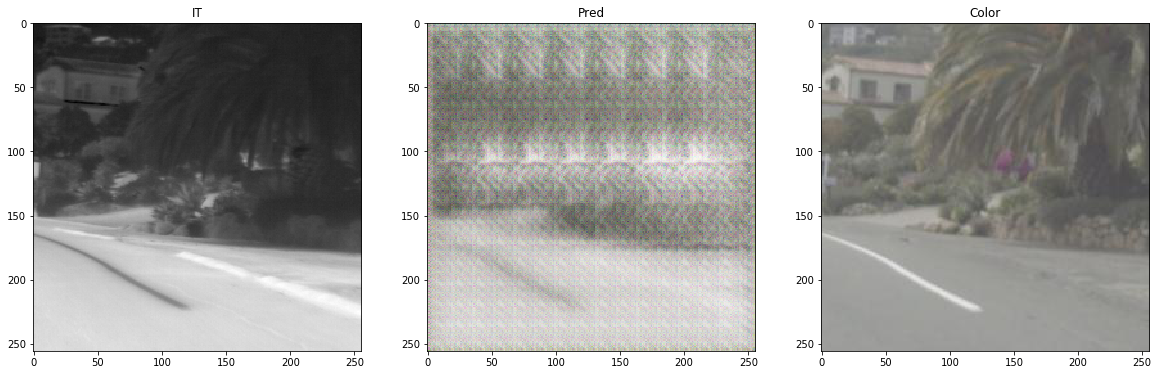

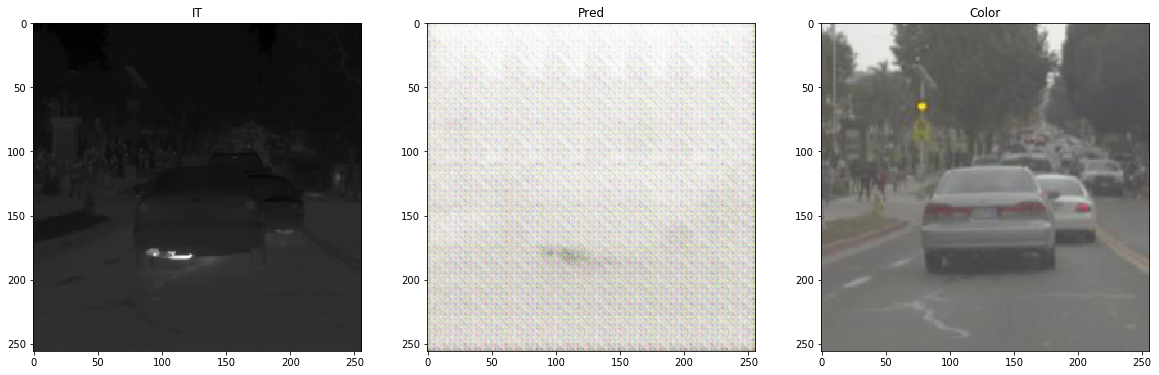

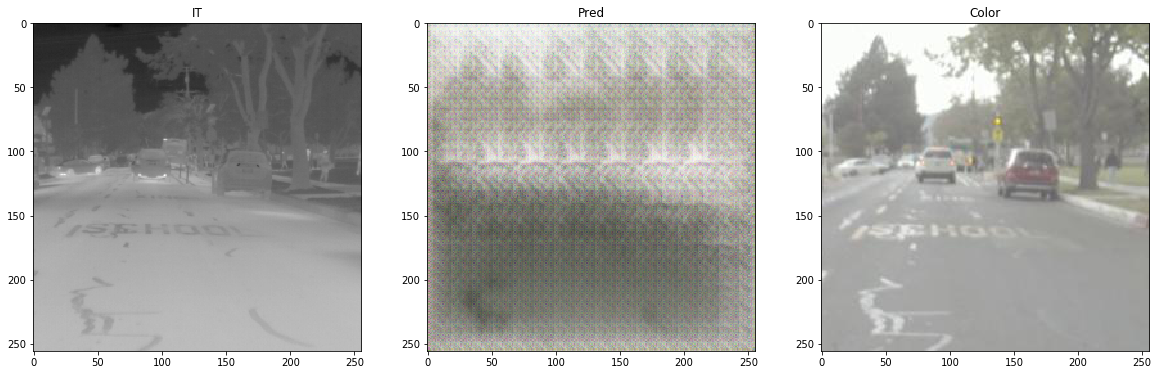

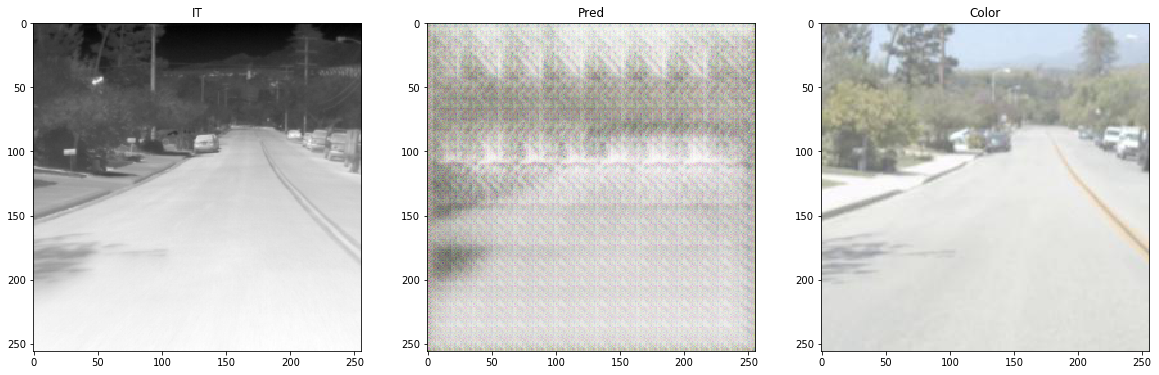

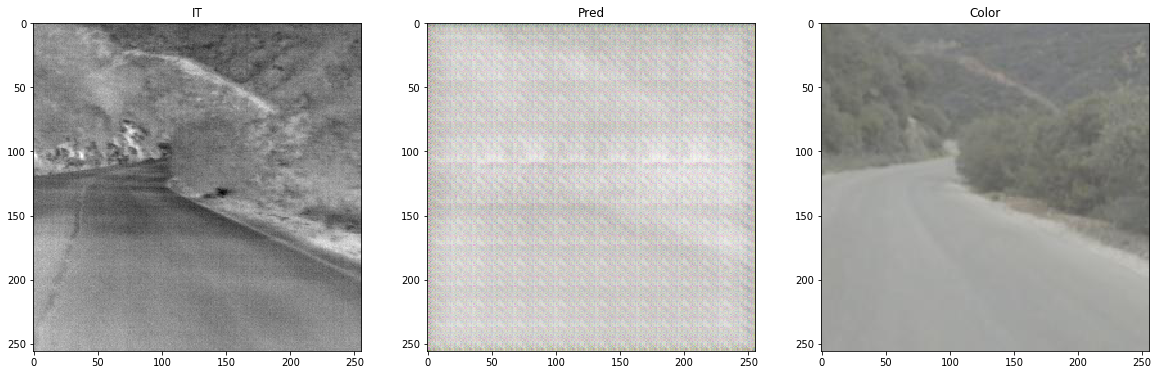

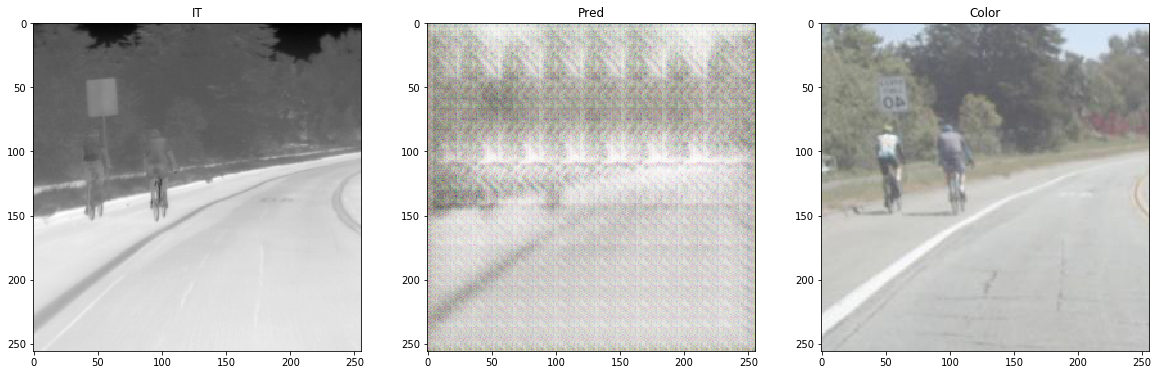

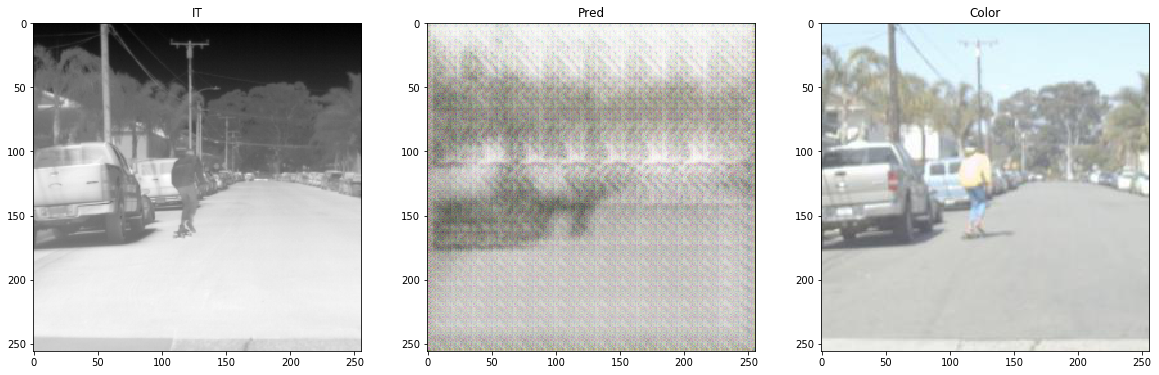

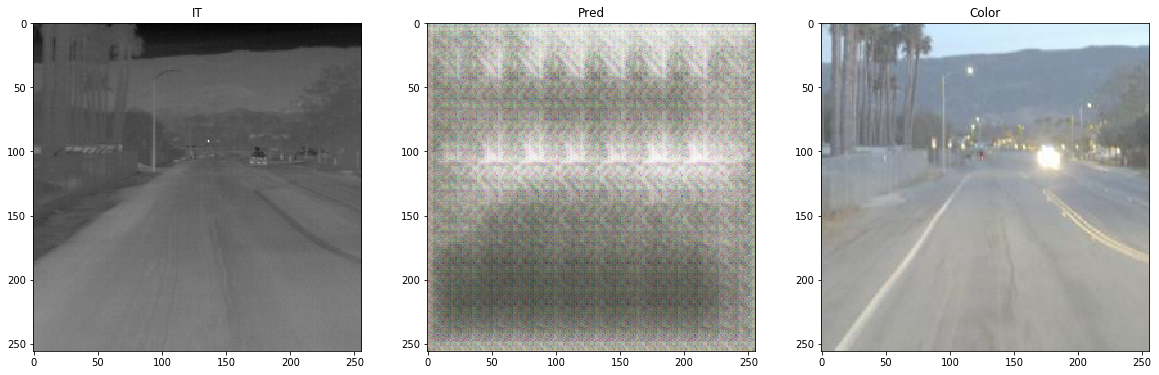

In [21]:
xi = plot_sample(train_crops, g_model)

In [30]:
#g_model.load_weights(weight_name+'/g_model_best_cross_' + weight_name + '.h5')
yimage_generator = image_datagen.flow(y_test, seed=2019, batch_size=8, shuffle=True)
Ximage_generator = image_datagen.flow(X_test, seed=2019, batch_size=8, shuffle=True)

train_generator = zip(Ximage_generator, yimage_generator)
train_crops = crop_generator(train_generator, 256, rand_crop=False)

In [43]:
x2, y2 = next(train_crops)
xi2 = K.constant(x2)
yi2= K.constant(y2)
Xr = K.constant(g_model.predict(x2))
ssimTF = ssim_tf(ssim_fact=1)
# ls = ssimTF(Xr,yi2)
ls=mean_absolute_error(Xr,yi2)
#ls = vgg_loss_bach(Xr, yi2,c_image_shape)
# Y_pred = np.expand_dims(Xr, axis=0)
#res = np.sum(np.sum(K.eval(ls), axis=-1), axis=-1)

y_true = yi2
y_pred = Xr
batch_size = y_true.shape[0];
ssim_sum = []
for i in range(batch_size):
    ssim_sum.append(tf.image.ssim_multiscale(y_true,y_pred,1))

print(ssim_sum)

[<tf.Tensor 'MS-SSIM_3/Mean:0' shape=(2,) dtype=float32>, <tf.Tensor 'MS-SSIM_4/Mean:0' shape=(2,) dtype=float32>]


In [ ]:
gan_model = define_gan(g_model, d_model, t_image_shape)
g_total, g_cross, g_loss = gan_model.train_on_batch(X_realA, [y_real, X_realB])
X_realA.shape

In [23]:
n_patch = 16;n_batch = 2
[X_realA, X_realB], y_real = generate_real_samples(train_crops, n_batch, n_patch)
# generate a batch of fake samples
X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
# update discriminator for real samples
d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
# update discriminator for generated samples
d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
# update the generator
g_total, g_cross, g_loss = gan_model.train_on_batch(X_realA, [y_real, X_realB])

ValueError: Input arrays should have the same number of samples as target arrays. Found 8 input samples and 2 target samples.

In [31]:
scedual_trainings()

0, d_real[0.024] d_fake[1.327] g_total[24.629] g_cross[3.007] g_loss[0.009] 10.060[sec]
best loss model saved!
model saved...
1, d_real[0.028] d_fake[0.020] g_total[40.941] g_cross[5.019] g_loss[0.014] 0.615[sec]
2, d_real[0.803] d_fake[0.168] g_total[28.597] g_cross[1.803] g_loss[0.011] 0.510[sec]
3, d_real[0.081] d_fake[0.079] g_total[37.600] g_cross[3.003] g_loss[0.014] 0.506[sec]
4, d_real[0.009] d_fake[0.492] g_total[40.388] g_cross[4.101] g_loss[0.015] 0.506[sec]
5, d_real[0.339] d_fake[0.029] g_total[40.433] g_cross[3.076] g_loss[0.015] 0.509[sec]
6, d_real[0.345] d_fake[0.120] g_total[35.320] g_cross[2.077] g_loss[0.013] 0.511[sec]
7, d_real[0.029] d_fake[0.411] g_total[32.737] g_cross[3.730] g_loss[0.012] 0.519[sec]
8, d_real[0.109] d_fake[0.080] g_total[28.320] g_cross[3.433] g_loss[0.010] 0.511[sec]
9, d_real[0.200] d_fake[0.080] g_total[33.966] g_cross[2.749] g_loss[0.012] 0.513[sec]
10, d_real[0.056] d_fake[0.121] g_total[36.098] g_cross[3.638] g_loss[0.013] 0.508[sec]
11,

93, d_real[0.461] d_fake[0.084] g_total[28.916] g_cross[2.240] g_loss[0.011] 0.505[sec]
94, d_real[0.032] d_fake[0.110] g_total[35.484] g_cross[3.465] g_loss[0.013] 0.510[sec]
95, d_real[0.096] d_fake[0.049] g_total[38.739] g_cross[3.144] g_loss[0.014] 0.511[sec]
96, d_real[0.082] d_fake[0.194] g_total[44.024] g_cross[4.156] g_loss[0.016] 0.519[sec]
97, d_real[0.105] d_fake[0.018] g_total[40.835] g_cross[3.822] g_loss[0.015] 0.515[sec]
98, d_real[0.019] d_fake[0.134] g_total[39.793] g_cross[4.206] g_loss[0.014] 0.518[sec]
99, d_real[0.571] d_fake[0.345] g_total[41.249] g_cross[3.631] g_loss[0.015] 0.519[sec]
100, d_real[0.023] d_fake[0.073] g_total[36.784] g_cross[4.102] g_loss[0.013] 0.521[sec]
101, d_real[0.179] d_fake[0.106] g_total[39.783] g_cross[2.916] g_loss[0.015] 0.514[sec]
102, d_real[0.089] d_fake[0.148] g_total[36.255] g_cross[3.794] g_loss[0.013] 0.509[sec]
103, d_real[0.050] d_fake[0.055] g_total[38.620] g_cross[3.660] g_loss[0.014] 0.512[sec]
104, d_real[0.162] d_fake[0.

186, d_real[0.085] d_fake[0.015] g_total[44.865] g_cross[4.615] g_loss[0.016] 0.505[sec]
187, d_real[0.144] d_fake[0.056] g_total[43.263] g_cross[2.930] g_loss[0.016] 0.499[sec]
188, d_real[0.137] d_fake[0.192] g_total[32.766] g_cross[3.708] g_loss[0.012] 0.507[sec]
189, d_real[0.083] d_fake[0.160] g_total[40.019] g_cross[4.159] g_loss[0.014] 0.502[sec]
190, d_real[0.440] d_fake[0.138] g_total[36.351] g_cross[2.527] g_loss[0.014] 0.507[sec]
191, d_real[0.145] d_fake[0.535] g_total[33.732] g_cross[5.118] g_loss[0.011] 0.506[sec]
192, d_real[0.250] d_fake[0.012] g_total[40.259] g_cross[4.496] g_loss[0.014] 0.497[sec]
193, d_real[0.131] d_fake[0.095] g_total[33.304] g_cross[2.836] g_loss[0.012] 0.503[sec]
194, d_real[0.026] d_fake[0.077] g_total[29.152] g_cross[3.472] g_loss[0.010] 0.494[sec]
195, d_real[0.045] d_fake[0.092] g_total[33.451] g_cross[3.418] g_loss[0.012] 0.503[sec]
196, d_real[0.089] d_fake[0.060] g_total[27.583] g_cross[3.137] g_loss[0.010] 0.496[sec]
197, d_real[0.234] d_

278, d_real[0.034] d_fake[0.091] g_total[33.809] g_cross[3.842] g_loss[0.012] 0.500[sec]
279, d_real[0.068] d_fake[0.012] g_total[46.723] g_cross[4.174] g_loss[0.017] 0.504[sec]
280, d_real[0.404] d_fake[0.834] g_total[32.273] g_cross[4.813] g_loss[0.011] 0.506[sec]
281, d_real[0.162] d_fake[0.034] g_total[28.513] g_cross[3.536] g_loss[0.010] 0.502[sec]
282, d_real[0.087] d_fake[0.074] g_total[29.565] g_cross[2.865] g_loss[0.011] 0.499[sec]
283, d_real[0.063] d_fake[0.114] g_total[36.035] g_cross[3.401] g_loss[0.013] 0.502[sec]
284, d_real[0.065] d_fake[0.038] g_total[32.871] g_cross[3.603] g_loss[0.012] 0.505[sec]
285, d_real[0.136] d_fake[0.618] g_total[33.147] g_cross[6.188] g_loss[0.011] 0.498[sec]
286, d_real[0.912] d_fake[0.166] g_total[32.021] g_cross[2.449] g_loss[0.012] 0.495[sec]
287, d_real[0.127] d_fake[0.043] g_total[30.596] g_cross[2.956] g_loss[0.011] 0.496[sec]
288, d_real[0.029] d_fake[0.152] g_total[33.951] g_cross[3.693] g_loss[0.012] 0.496[sec]
289, d_real[0.050] d_

371, d_real[0.112] d_fake[0.010] g_total[31.140] g_cross[4.952] g_loss[0.010] 0.508[sec]
372, d_real[0.229] d_fake[0.067] g_total[31.971] g_cross[2.427] g_loss[0.012] 0.496[sec]
373, d_real[0.105] d_fake[0.745] g_total[29.984] g_cross[6.687] g_loss[0.009] 0.502[sec]
374, d_real[0.342] d_fake[0.023] g_total[29.069] g_cross[3.202] g_loss[0.010] 0.502[sec]
375, d_real[0.058] d_fake[0.131] g_total[42.104] g_cross[3.621] g_loss[0.015] 0.496[sec]
376, d_real[0.095] d_fake[0.039] g_total[37.148] g_cross[3.625] g_loss[0.013] 0.499[sec]
377, d_real[0.038] d_fake[0.046] g_total[42.189] g_cross[3.707] g_loss[0.015] 0.509[sec]
378, d_real[0.059] d_fake[0.184] g_total[45.596] g_cross[4.736] g_loss[0.016] 0.502[sec]
379, d_real[0.238] d_fake[0.036] g_total[32.747] g_cross[2.878] g_loss[0.012] 0.497[sec]
380, d_real[0.080] d_fake[0.031] g_total[35.011] g_cross[3.190] g_loss[0.013] 0.503[sec]
381, d_real[0.007] d_fake[0.618] g_total[36.167] g_cross[6.921] g_loss[0.012] 0.502[sec]
382, d_real[2.239] d_

463, d_real[0.148] d_fake[0.015] g_total[35.023] g_cross[3.441] g_loss[0.013] 0.510[sec]
464, d_real[0.006] d_fake[0.308] g_total[40.740] g_cross[5.539] g_loss[0.014] 0.496[sec]
465, d_real[0.160] d_fake[0.012] g_total[32.491] g_cross[4.344] g_loss[0.011] 0.499[sec]
466, d_real[0.182] d_fake[0.126] g_total[31.139] g_cross[2.915] g_loss[0.011] 0.496[sec]
467, d_real[0.024] d_fake[0.100] g_total[36.488] g_cross[4.140] g_loss[0.013] 0.507[sec]
468, d_real[0.185] d_fake[0.160] g_total[42.553] g_cross[3.708] g_loss[0.016] 0.495[sec]
469, d_real[0.244] d_fake[0.471] g_total[37.086] g_cross[6.023] g_loss[0.012] 0.510[sec]
470, d_real[0.293] d_fake[0.122] g_total[38.233] g_cross[4.043] g_loss[0.014] 0.498[sec]
471, d_real[0.172] d_fake[0.082] g_total[44.342] g_cross[3.185] g_loss[0.016] 0.502[sec]
472, d_real[0.187] d_fake[0.601] g_total[28.485] g_cross[5.634] g_loss[0.009] 0.501[sec]
473, d_real[0.450] d_fake[0.022] g_total[46.037] g_cross[2.682] g_loss[0.017] 0.504[sec]
474, d_real[0.051] d_

556, d_real[0.625] d_fake[0.693] g_total[34.404] g_cross[3.474] g_loss[0.012] 0.502[sec]
557, d_real[0.041] d_fake[0.015] g_total[48.056] g_cross[4.597] g_loss[0.017] 0.497[sec]
558, d_real[0.066] d_fake[0.032] g_total[41.351] g_cross[3.582] g_loss[0.015] 0.504[sec]
559, d_real[0.189] d_fake[0.097] g_total[37.369] g_cross[2.597] g_loss[0.014] 0.508[sec]
560, d_real[0.053] d_fake[0.126] g_total[33.067] g_cross[3.265] g_loss[0.012] 0.498[sec]
561, d_real[0.050] d_fake[0.510] g_total[42.124] g_cross[6.540] g_loss[0.014] 0.494[sec]
562, d_real[1.379] d_fake[0.091] g_total[29.466] g_cross[1.361] g_loss[0.011] 0.524[sec]
563, d_real[0.052] d_fake[0.328] g_total[28.878] g_cross[4.005] g_loss[0.010] 0.505[sec]
564, d_real[0.087] d_fake[0.036] g_total[27.456] g_cross[4.029] g_loss[0.009] 0.496[sec]
565, d_real[0.066] d_fake[0.038] g_total[24.823] g_cross[3.092] g_loss[0.009] 0.498[sec]
566, d_real[0.131] d_fake[0.046] g_total[33.473] g_cross[2.775] g_loss[0.012] 0.507[sec]
567, d_real[0.036] d_

648, d_real[0.048] d_fake[0.361] g_total[33.444] g_cross[5.319] g_loss[0.011] 0.510[sec]
649, d_real[0.214] d_fake[0.021] g_total[39.107] g_cross[3.560] g_loss[0.014] 0.498[sec]
650, d_real[0.625] d_fake[1.389] g_total[32.700] g_cross[2.432] g_loss[0.012] 0.500[sec]
651, d_real[0.049] d_fake[0.020] g_total[34.926] g_cross[4.387] g_loss[0.012] 0.499[sec]
652, d_real[0.364] d_fake[0.194] g_total[39.739] g_cross[2.916] g_loss[0.015] 0.502[sec]
653, d_real[0.027] d_fake[0.224] g_total[31.082] g_cross[4.243] g_loss[0.011] 0.506[sec]
654, d_real[1.077] d_fake[0.597] g_total[34.897] g_cross[2.913] g_loss[0.013] 0.497[sec]
655, d_real[0.055] d_fake[0.101] g_total[33.642] g_cross[4.152] g_loss[0.012] 0.507[sec]
656, d_real[0.112] d_fake[0.045] g_total[31.422] g_cross[3.674] g_loss[0.011] 0.513[sec]
657, d_real[0.034] d_fake[0.096] g_total[37.146] g_cross[3.678] g_loss[0.013] 0.496[sec]
658, d_real[0.391] d_fake[0.177] g_total[32.673] g_cross[2.095] g_loss[0.012] 0.501[sec]
659, d_real[0.087] d_

741, d_real[0.397] d_fake[0.296] g_total[44.768] g_cross[2.740] g_loss[0.017] 0.502[sec]
742, d_real[0.046] d_fake[0.067] g_total[34.572] g_cross[3.330] g_loss[0.012] 0.503[sec]
743, d_real[0.317] d_fake[0.398] g_total[36.376] g_cross[4.128] g_loss[0.013] 0.495[sec]
744, d_real[0.070] d_fake[0.012] g_total[38.663] g_cross[4.473] g_loss[0.014] 0.497[sec]
745, d_real[0.407] d_fake[0.717] g_total[34.508] g_cross[4.186] g_loss[0.012] 0.497[sec]
746, d_real[0.114] d_fake[0.019] g_total[30.906] g_cross[3.792] g_loss[0.011] 0.496[sec]
747, d_real[0.135] d_fake[0.065] g_total[20.480] g_cross[2.917] g_loss[0.007] 0.499[sec]
748, d_real[0.096] d_fake[0.309] g_total[31.144] g_cross[4.429] g_loss[0.011] 0.506[sec]
749, d_real[0.016] d_fake[0.012] g_total[39.947] g_cross[4.838] g_loss[0.014] 0.502[sec]
750, d_real[0.970] d_fake[0.359] g_total[26.949] g_cross[2.224] g_loss[0.010] 0.497[sec]
751, d_real[0.252] d_fake[0.472] g_total[27.390] g_cross[3.817] g_loss[0.009] 0.500[sec]
752, d_real[0.020] d_

833, d_real[0.099] d_fake[0.099] g_total[36.814] g_cross[3.310] g_loss[0.013] 0.505[sec]
834, d_real[0.100] d_fake[0.041] g_total[34.778] g_cross[3.055] g_loss[0.013] 0.510[sec]
835, d_real[0.014] d_fake[0.198] g_total[31.324] g_cross[4.771] g_loss[0.011] 0.503[sec]
836, d_real[0.545] d_fake[0.530] g_total[28.661] g_cross[4.546] g_loss[0.010] 0.507[sec]
837, d_real[0.046] d_fake[0.004] g_total[42.113] g_cross[5.590] g_loss[0.015] 0.507[sec]
838, d_real[0.250] d_fake[0.028] g_total[37.246] g_cross[2.490] g_loss[0.014] 0.501[sec]
839, d_real[0.019] d_fake[0.209] g_total[29.095] g_cross[4.082] g_loss[0.010] 0.507[sec]
840, d_real[0.170] d_fake[0.028] g_total[36.792] g_cross[3.272] g_loss[0.013] 0.506[sec]
841, d_real[0.031] d_fake[0.143] g_total[33.055] g_cross[3.665] g_loss[0.012] 0.497[sec]
842, d_real[0.073] d_fake[0.106] g_total[30.806] g_cross[3.741] g_loss[0.011] 0.496[sec]
843, d_real[0.285] d_fake[0.243] g_total[36.309] g_cross[3.185] g_loss[0.013] 0.501[sec]
844, d_real[0.011] d_

926, d_real[0.107] d_fake[0.014] g_total[39.570] g_cross[3.938] g_loss[0.014] 0.503[sec]
927, d_real[0.148] d_fake[0.080] g_total[38.635] g_cross[2.697] g_loss[0.014] 0.503[sec]
928, d_real[0.020] d_fake[0.157] g_total[33.258] g_cross[4.249] g_loss[0.012] 0.504[sec]
929, d_real[0.023] d_fake[0.026] g_total[37.548] g_cross[4.235] g_loss[0.013] 0.505[sec]
930, d_real[1.163] d_fake[1.756] g_total[25.769] g_cross[3.395] g_loss[0.009] 0.501[sec]
931, d_real[0.027] d_fake[0.093] g_total[33.678] g_cross[4.873] g_loss[0.012] 0.512[sec]
932, d_real[0.075] d_fake[0.030] g_total[37.507] g_cross[3.972] g_loss[0.013] 0.504[sec]
933, d_real[0.340] d_fake[0.286] g_total[39.449] g_cross[3.705] g_loss[0.014] 0.499[sec]
934, d_real[0.121] d_fake[0.120] g_total[38.034] g_cross[3.802] g_loss[0.014] 0.498[sec]
935, d_real[0.070] d_fake[0.085] g_total[31.212] g_cross[3.358] g_loss[0.011] 0.509[sec]
936, d_real[0.752] d_fake[0.910] g_total[28.161] g_cross[3.998] g_loss[0.010] 0.510[sec]
937, d_real[0.052] d_

1018, d_real[0.014] d_fake[0.133] g_total[36.410] g_cross[3.413] g_loss[0.013] 0.498[sec]
1019, d_real[0.205] d_fake[0.064] g_total[25.937] g_cross[2.787] g_loss[0.009] 0.504[sec]
1020, d_real[0.006] d_fake[0.188] g_total[35.400] g_cross[3.801] g_loss[0.013] 0.497[sec]
1021, d_real[0.112] d_fake[0.040] g_total[33.358] g_cross[3.506] g_loss[0.012] 0.499[sec]
1022, d_real[0.251] d_fake[0.142] g_total[28.612] g_cross[2.284] g_loss[0.011] 0.495[sec]
1023, d_real[0.004] d_fake[0.183] g_total[36.897] g_cross[3.514] g_loss[0.013] 0.496[sec]
1024, d_real[0.023] d_fake[0.048] g_total[36.339] g_cross[3.783] g_loss[0.013] 0.502[sec]
1025, d_real[0.251] d_fake[0.125] g_total[35.595] g_cross[2.688] g_loss[0.013] 0.502[sec]
1026, d_real[0.020] d_fake[0.148] g_total[36.300] g_cross[3.846] g_loss[0.013] 0.495[sec]
1027, d_real[0.772] d_fake[0.784] g_total[27.685] g_cross[3.337] g_loss[0.010] 0.503[sec]
1028, d_real[0.087] d_fake[0.060] g_total[36.406] g_cross[3.398] g_loss[0.013] 0.507[sec]
1029, d_re

1109, d_real[0.065] d_fake[0.092] g_total[34.423] g_cross[3.552] g_loss[0.012] 0.492[sec]
1110, d_real[0.390] d_fake[0.451] g_total[31.059] g_cross[3.977] g_loss[0.011] 0.498[sec]
1111, d_real[0.093] d_fake[0.066] g_total[29.327] g_cross[3.672] g_loss[0.010] 0.499[sec]
1112, d_real[0.258] d_fake[0.318] g_total[34.650] g_cross[4.664] g_loss[0.012] 0.494[sec]
1113, d_real[0.439] d_fake[0.034] g_total[40.188] g_cross[2.527] g_loss[0.015] 0.503[sec]
1114, d_real[0.002] d_fake[0.678] g_total[34.483] g_cross[4.764] g_loss[0.012] 0.509[sec]
1115, d_real[0.137] d_fake[0.005] g_total[32.906] g_cross[5.460] g_loss[0.011] 0.503[sec]
1116, d_real[0.053] d_fake[0.038] g_total[32.774] g_cross[3.467] g_loss[0.012] 0.497[sec]
1117, d_real[0.738] d_fake[0.968] g_total[34.240] g_cross[4.206] g_loss[0.012] 0.504[sec]
1118, d_real[0.101] d_fake[0.024] g_total[39.728] g_cross[3.938] g_loss[0.014] 0.497[sec]
1119, d_real[0.083] d_fake[0.149] g_total[38.162] g_cross[4.529] g_loss[0.013] 0.503[sec]
1120, d_re

model saved...
1201, d_real[0.001] d_fake[0.169] g_total[37.189] g_cross[5.082] g_loss[0.013] 0.495[sec]
1202, d_real[0.336] d_fake[0.061] g_total[32.236] g_cross[2.485] g_loss[0.012] 0.496[sec]
1203, d_real[0.017] d_fake[0.049] g_total[38.857] g_cross[3.511] g_loss[0.014] 0.497[sec]
1204, d_real[0.006] d_fake[0.359] g_total[37.154] g_cross[6.568] g_loss[0.012] 0.496[sec]
1205, d_real[0.555] d_fake[0.084] g_total[28.342] g_cross[2.127] g_loss[0.010] 0.503[sec]
1206, d_real[0.018] d_fake[0.183] g_total[36.224] g_cross[5.284] g_loss[0.012] 0.497[sec]
1207, d_real[0.032] d_fake[0.007] g_total[44.909] g_cross[5.133] g_loss[0.016] 0.501[sec]
1208, d_real[0.809] d_fake[0.822] g_total[32.136] g_cross[6.370] g_loss[0.010] 0.512[sec]
1209, d_real[1.197] d_fake[0.190] g_total[29.080] g_cross[4.325] g_loss[0.010] 0.503[sec]
1210, d_real[0.516] d_fake[2.212] g_total[27.084] g_cross[2.729] g_loss[0.010] 0.499[sec]
1211, d_real[0.249] d_fake[0.673] g_total[32.064] g_cross[5.321] g_loss[0.011] 0.496[

1292, d_real[0.098] d_fake[0.021] g_total[36.081] g_cross[3.509] g_loss[0.013] 0.506[sec]
1293, d_real[0.051] d_fake[0.099] g_total[31.614] g_cross[3.402] g_loss[0.011] 0.500[sec]
1294, d_real[0.255] d_fake[0.431] g_total[32.029] g_cross[5.188] g_loss[0.011] 0.512[sec]
1295, d_real[0.198] d_fake[0.020] g_total[38.450] g_cross[3.559] g_loss[0.014] 0.501[sec]
1296, d_real[0.037] d_fake[0.099] g_total[25.498] g_cross[3.591] g_loss[0.009] 0.504[sec]
1297, d_real[0.248] d_fake[0.148] g_total[31.451] g_cross[3.050] g_loss[0.011] 0.500[sec]
1298, d_real[0.015] d_fake[0.163] g_total[30.896] g_cross[4.099] g_loss[0.011] 0.500[sec]
1299, d_real[0.053] d_fake[0.012] g_total[33.710] g_cross[4.496] g_loss[0.012] 0.498[sec]
1300, d_real[0.370] d_fake[0.397] g_total[36.082] g_cross[4.020] g_loss[0.013] 0.504[sec]
1301, d_real[0.010] d_fake[0.049] g_total[36.187] g_cross[4.296] g_loss[0.013] 0.502[sec]
1302, d_real[0.099] d_fake[0.043] g_total[30.884] g_cross[3.281] g_loss[0.011] 0.504[sec]
1303, d_re

1384, d_real[0.026] d_fake[0.009] g_total[41.798] g_cross[5.367] g_loss[0.015] 0.495[sec]
1385, d_real[0.490] d_fake[0.095] g_total[37.177] g_cross[1.731] g_loss[0.014] 0.508[sec]
1386, d_real[0.004] d_fake[0.316] g_total[37.223] g_cross[4.305] g_loss[0.013] 0.491[sec]
1387, d_real[0.074] d_fake[0.067] g_total[35.115] g_cross[4.065] g_loss[0.012] 0.501[sec]
1388, d_real[0.980] d_fake[0.985] g_total[28.058] g_cross[3.281] g_loss[0.010] 0.508[sec]
1389, d_real[0.118] d_fake[0.032] g_total[36.013] g_cross[3.719] g_loss[0.013] 0.500[sec]
1390, d_real[0.200] d_fake[0.144] g_total[27.969] g_cross[2.516] g_loss[0.010] 0.501[sec]
1391, d_real[0.013] d_fake[0.260] g_total[39.122] g_cross[4.862] g_loss[0.014] 0.506[sec]
1392, d_real[0.062] d_fake[0.044] g_total[34.353] g_cross[3.724] g_loss[0.012] 0.496[sec]
1393, d_real[0.359] d_fake[0.227] g_total[32.732] g_cross[3.100] g_loss[0.012] 0.496[sec]
1394, d_real[0.023] d_fake[0.037] g_total[32.641] g_cross[3.734] g_loss[0.012] 0.503[sec]
1395, d_re

1475, d_real[0.080] d_fake[0.122] g_total[28.638] g_cross[3.881] g_loss[0.010] 0.513[sec]
1476, d_real[0.514] d_fake[0.730] g_total[28.064] g_cross[4.557] g_loss[0.009] 0.499[sec]
1477, d_real[0.132] d_fake[0.038] g_total[23.752] g_cross[3.440] g_loss[0.008] 0.500[sec]
1478, d_real[0.293] d_fake[0.239] g_total[35.594] g_cross[2.952] g_loss[0.013] 0.497[sec]
1479, d_real[0.013] d_fake[0.018] g_total[35.534] g_cross[4.297] g_loss[0.012] 0.511[sec]
1480, d_real[0.071] d_fake[0.029] g_total[43.047] g_cross[3.375] g_loss[0.016] 0.499[sec]
1481, d_real[0.153] d_fake[0.464] g_total[31.654] g_cross[5.271] g_loss[0.011] 0.501[sec]
1482, d_real[0.148] d_fake[0.008] g_total[36.545] g_cross[4.293] g_loss[0.013] 0.501[sec]
1483, d_real[0.029] d_fake[0.020] g_total[36.233] g_cross[3.684] g_loss[0.013] 0.502[sec]
1484, d_real[0.072] d_fake[0.050] g_total[34.360] g_cross[3.038] g_loss[0.013] 0.500[sec]
1485, d_real[0.108] d_fake[0.172] g_total[35.858] g_cross[3.737] g_loss[0.013] 0.514[sec]
1486, d_re

1567, d_real[0.067] d_fake[0.153] g_total[25.886] g_cross[3.252] g_loss[0.009] 0.496[sec]
1568, d_real[0.185] d_fake[0.074] g_total[30.187] g_cross[2.804] g_loss[0.011] 0.506[sec]
1569, d_real[0.008] d_fake[0.334] g_total[44.621] g_cross[6.539] g_loss[0.015] 0.504[sec]
1570, d_real[0.550] d_fake[0.042] g_total[31.412] g_cross[2.023] g_loss[0.012] 0.502[sec]
1571, d_real[0.001] d_fake[0.302] g_total[35.894] g_cross[5.202] g_loss[0.012] 0.506[sec]
1572, d_real[0.301] d_fake[0.076] g_total[37.484] g_cross[2.556] g_loss[0.014] 0.498[sec]
1573, d_real[0.006] d_fake[0.081] g_total[35.187] g_cross[3.688] g_loss[0.013] 0.507[sec]
1574, d_real[0.020] d_fake[0.094] g_total[31.438] g_cross[4.007] g_loss[0.011] 0.505[sec]
1575, d_real[0.131] d_fake[0.012] g_total[29.935] g_cross[3.962] g_loss[0.010] 0.503[sec]
1576, d_real[0.224] d_fake[0.344] g_total[31.107] g_cross[4.516] g_loss[0.011] 0.496[sec]
1577, d_real[0.024] d_fake[0.004] g_total[37.474] g_cross[5.734] g_loss[0.013] 0.501[sec]
1578, d_re

1658, d_real[0.105] d_fake[0.003] g_total[34.885] g_cross[5.696] g_loss[0.012] 0.501[sec]
1659, d_real[0.294] d_fake[0.298] g_total[28.183] g_cross[3.597] g_loss[0.010] 0.497[sec]
1660, d_real[0.204] d_fake[0.507] g_total[32.980] g_cross[6.293] g_loss[0.011] 0.498[sec]
1661, d_real[0.260] d_fake[0.009] g_total[41.504] g_cross[4.252] g_loss[0.015] 0.499[sec]
1662, d_real[0.027] d_fake[0.013] g_total[34.169] g_cross[3.986] g_loss[0.012] 0.497[sec]
1663, d_real[0.120] d_fake[0.071] g_total[29.108] g_cross[2.888] g_loss[0.010] 0.500[sec]
1664, d_real[0.073] d_fake[0.367] g_total[30.162] g_cross[5.022] g_loss[0.010] 0.499[sec]
1665, d_real[0.181] d_fake[0.017] g_total[37.151] g_cross[3.816] g_loss[0.013] 0.500[sec]
1666, d_real[0.056] d_fake[0.108] g_total[37.074] g_cross[3.225] g_loss[0.014] 0.500[sec]
1667, d_real[0.045] d_fake[0.021] g_total[39.510] g_cross[3.908] g_loss[0.014] 0.507[sec]
1668, d_real[0.014] d_fake[0.044] g_total[31.556] g_cross[3.527] g_loss[0.011] 0.502[sec]
1669, d_re

1750, d_real[0.441] d_fake[0.250] g_total[36.273] g_cross[3.030] g_loss[0.013] 0.498[sec]
1751, d_real[0.008] d_fake[0.079] g_total[43.682] g_cross[4.457] g_loss[0.016] 0.502[sec]
1752, d_real[0.237] d_fake[0.162] g_total[27.034] g_cross[3.446] g_loss[0.009] 0.492[sec]
1753, d_real[0.057] d_fake[0.045] g_total[38.630] g_cross[3.547] g_loss[0.014] 0.501[sec]
1754, d_real[0.004] d_fake[0.021] g_total[40.602] g_cross[3.973] g_loss[0.015] 0.498[sec]
1755, d_real[0.094] d_fake[0.043] g_total[30.945] g_cross[3.203] g_loss[0.011] 0.501[sec]
1756, d_real[0.012] d_fake[0.078] g_total[33.632] g_cross[3.720] g_loss[0.012] 0.499[sec]
1757, d_real[0.064] d_fake[0.022] g_total[37.760] g_cross[3.671] g_loss[0.014] 0.504[sec]
1758, d_real[0.052] d_fake[0.166] g_total[32.366] g_cross[3.897] g_loss[0.011] 0.497[sec]
1759, d_real[0.032] d_fake[0.014] g_total[33.166] g_cross[4.536] g_loss[0.011] 0.505[sec]
1760, d_real[0.323] d_fake[0.060] g_total[31.732] g_cross[2.020] g_loss[0.012] 0.507[sec]
1761, d_re

1841, d_real[0.053] d_fake[0.049] g_total[36.198] g_cross[3.371] g_loss[0.013] 0.500[sec]
1842, d_real[0.015] d_fake[0.021] g_total[38.763] g_cross[4.207] g_loss[0.014] 0.494[sec]
1843, d_real[0.242] d_fake[0.460] g_total[25.948] g_cross[4.315] g_loss[0.009] 0.499[sec]
1844, d_real[0.314] d_fake[0.036] g_total[28.290] g_cross[2.611] g_loss[0.010] 0.498[sec]
1845, d_real[0.015] d_fake[0.155] g_total[41.522] g_cross[4.565] g_loss[0.015] 0.508[sec]
1846, d_real[0.448] d_fake[0.111] g_total[33.666] g_cross[2.404] g_loss[0.013] 0.498[sec]
1847, d_real[0.008] d_fake[0.192] g_total[30.399] g_cross[3.755] g_loss[0.011] 0.498[sec]
1848, d_real[0.066] d_fake[0.006] g_total[32.061] g_cross[4.933] g_loss[0.011] 0.506[sec]
1849, d_real[0.155] d_fake[0.092] g_total[25.126] g_cross[2.629] g_loss[0.009] 0.509[sec]
1850, d_real[0.012] d_fake[0.084] g_total[35.175] g_cross[3.526] g_loss[0.013] 0.509[sec]
1851, d_real[0.073] d_fake[0.067] g_total[32.273] g_cross[3.164] g_loss[0.012] 0.505[sec]
1852, d_re

1933, d_real[0.015] d_fake[0.023] g_total[38.963] g_cross[3.834] g_loss[0.014] 0.509[sec]
1934, d_real[0.145] d_fake[0.268] g_total[29.168] g_cross[4.181] g_loss[0.010] 0.504[sec]
1935, d_real[0.014] d_fake[0.058] g_total[33.790] g_cross[4.939] g_loss[0.012] 0.496[sec]
1936, d_real[0.778] d_fake[1.260] g_total[24.884] g_cross[4.233] g_loss[0.008] 0.495[sec]
1937, d_real[0.385] d_fake[0.200] g_total[28.700] g_cross[4.156] g_loss[0.010] 0.501[sec]
1938, d_real[0.192] d_fake[0.069] g_total[29.807] g_cross[2.885] g_loss[0.011] 0.497[sec]
1939, d_real[0.044] d_fake[0.259] g_total[34.353] g_cross[4.900] g_loss[0.012] 0.497[sec]
1940, d_real[0.220] d_fake[0.010] g_total[31.008] g_cross[3.992] g_loss[0.011] 0.505[sec]
1941, d_real[0.034] d_fake[0.042] g_total[41.854] g_cross[3.345] g_loss[0.015] 0.501[sec]
1942, d_real[0.044] d_fake[0.119] g_total[32.288] g_cross[3.550] g_loss[0.011] 0.510[sec]
1943, d_real[0.131] d_fake[0.015] g_total[33.279] g_cross[3.528] g_loss[0.012] 0.518[sec]
1944, d_re

2024, d_real[0.044] d_fake[0.088] g_total[39.820] g_cross[3.805] g_loss[0.014] 0.513[sec]
2025, d_real[0.039] d_fake[0.005] g_total[43.233] g_cross[5.180] g_loss[0.015] 0.500[sec]
2026, d_real[0.094] d_fake[0.036] g_total[33.351] g_cross[2.961] g_loss[0.012] 0.498[sec]
2027, d_real[0.031] d_fake[0.173] g_total[34.472] g_cross[4.666] g_loss[0.012] 0.511[sec]
2028, d_real[0.057] d_fake[0.030] g_total[38.787] g_cross[3.943] g_loss[0.014] 0.504[sec]
2029, d_real[0.515] d_fake[0.275] g_total[31.332] g_cross[3.365] g_loss[0.011] 0.496[sec]
2030, d_real[0.070] d_fake[0.131] g_total[33.081] g_cross[4.335] g_loss[0.011] 0.503[sec]
2031, d_real[0.094] d_fake[0.019] g_total[38.631] g_cross[3.735] g_loss[0.014] 0.498[sec]
2032, d_real[0.061] d_fake[0.044] g_total[25.654] g_cross[3.148] g_loss[0.009] 0.507[sec]
2033, d_real[0.002] d_fake[0.044] g_total[37.086] g_cross[3.540] g_loss[0.013] 0.503[sec]
2034, d_real[0.022] d_fake[0.189] g_total[34.129] g_cross[4.545] g_loss[0.012] 0.508[sec]
2035, d_re

2116, d_real[0.016] d_fake[0.015] g_total[45.516] g_cross[4.333] g_loss[0.016] 0.499[sec]
2117, d_real[0.050] d_fake[0.117] g_total[28.617] g_cross[3.775] g_loss[0.010] 0.507[sec]
2118, d_real[0.067] d_fake[0.007] g_total[35.644] g_cross[4.607] g_loss[0.012] 0.503[sec]
2119, d_real[0.281] d_fake[0.351] g_total[29.639] g_cross[4.050] g_loss[0.010] 0.505[sec]
2120, d_real[0.131] d_fake[0.040] g_total[31.384] g_cross[3.269] g_loss[0.011] 0.512[sec]
2121, d_real[0.073] d_fake[0.140] g_total[28.481] g_cross[3.644] g_loss[0.010] 0.507[sec]
2122, d_real[0.030] d_fake[0.031] g_total[38.244] g_cross[3.839] g_loss[0.014] 0.497[sec]
2123, d_real[0.090] d_fake[0.033] g_total[37.176] g_cross[3.132] g_loss[0.014] 0.497[sec]
2124, d_real[0.034] d_fake[0.129] g_total[31.905] g_cross[3.580] g_loss[0.011] 0.504[sec]
2125, d_real[0.092] d_fake[0.017] g_total[31.659] g_cross[3.727] g_loss[0.011] 0.512[sec]
2126, d_real[0.021] d_fake[0.047] g_total[26.560] g_cross[3.492] g_loss[0.009] 0.510[sec]
2127, d_re

2207, d_real[0.177] d_fake[0.296] g_total[29.828] g_cross[4.384] g_loss[0.010] 0.496[sec]
2208, d_real[0.064] d_fake[0.013] g_total[32.755] g_cross[4.550] g_loss[0.011] 0.496[sec]
2209, d_real[0.180] d_fake[0.046] g_total[37.361] g_cross[2.398] g_loss[0.014] 0.497[sec]
2210, d_real[0.030] d_fake[0.160] g_total[36.537] g_cross[3.927] g_loss[0.013] 0.495[sec]
2211, d_real[0.038] d_fake[0.050] g_total[35.320] g_cross[3.834] g_loss[0.013] 0.503[sec]
2212, d_real[0.364] d_fake[0.307] g_total[29.674] g_cross[3.698] g_loss[0.010] 0.501[sec]
2213, d_real[0.242] d_fake[0.099] g_total[32.871] g_cross[2.969] g_loss[0.012] 0.502[sec]
2214, d_real[0.004] d_fake[0.124] g_total[39.951] g_cross[4.165] g_loss[0.014] 0.496[sec]
2215, d_real[0.125] d_fake[0.014] g_total[29.611] g_cross[3.939] g_loss[0.010] 0.500[sec]
2216, d_real[0.036] d_fake[0.172] g_total[35.622] g_cross[4.745] g_loss[0.012] 0.501[sec]
2217, d_real[0.062] d_fake[0.004] g_total[39.200] g_cross[5.481] g_loss[0.013] 0.498[sec]
2218, d_re

2299, d_real[0.186] d_fake[0.342] g_total[32.861] g_cross[4.833] g_loss[0.011] 0.505[sec]
2300, d_real[0.102] d_fake[0.006] g_total[35.671] g_cross[4.987] g_loss[0.012] 0.503[sec]
2301, d_real[0.057] d_fake[0.007] g_total[46.950] g_cross[4.439] g_loss[0.017] 0.509[sec]
2302, d_real[0.009] d_fake[0.030] g_total[45.798] g_cross[3.608] g_loss[0.017] 0.506[sec]
2303, d_real[0.060] d_fake[0.054] g_total[35.366] g_cross[3.248] g_loss[0.013] 0.493[sec]
2304, d_real[0.040] d_fake[0.084] g_total[35.079] g_cross[3.739] g_loss[0.013] 0.513[sec]
2305, d_real[0.117] d_fake[0.143] g_total[29.948] g_cross[3.925] g_loss[0.010] 0.501[sec]
2306, d_real[0.146] d_fake[0.020] g_total[31.274] g_cross[3.471] g_loss[0.011] 0.500[sec]
2307, d_real[0.007] d_fake[0.110] g_total[41.325] g_cross[3.802] g_loss[0.015] 0.495[sec]
2308, d_real[0.064] d_fake[0.024] g_total[39.858] g_cross[3.722] g_loss[0.014] 0.508[sec]
2309, d_real[0.163] d_fake[0.094] g_total[33.861] g_cross[2.731] g_loss[0.012] 0.499[sec]
2310, d_re

2391, d_real[0.095] d_fake[0.410] g_total[28.693] g_cross[4.532] g_loss[0.010] 0.499[sec]
2392, d_real[0.188] d_fake[0.025] g_total[36.588] g_cross[3.457] g_loss[0.013] 0.502[sec]
2393, d_real[0.064] d_fake[0.085] g_total[40.429] g_cross[3.480] g_loss[0.015] 0.498[sec]
2394, d_real[0.012] d_fake[0.070] g_total[32.804] g_cross[3.944] g_loss[0.012] 0.497[sec]
2395, d_real[0.067] d_fake[0.016] g_total[35.146] g_cross[3.927] g_loss[0.012] 0.499[sec]
2396, d_real[0.119] d_fake[0.230] g_total[36.597] g_cross[4.816] g_loss[0.013] 0.494[sec]
2397, d_real[0.618] d_fake[0.397] g_total[30.782] g_cross[3.442] g_loss[0.011] 0.509[sec]
2398, d_real[0.094] d_fake[0.013] g_total[36.089] g_cross[4.120] g_loss[0.013] 0.498[sec]
2399, d_real[0.064] d_fake[0.016] g_total[38.513] g_cross[3.772] g_loss[0.014] 0.514[sec]
2400, d_real[0.011] d_fake[0.198] g_total[37.329] g_cross[4.824] g_loss[0.013] 0.500[sec]
model saved...
2401, d_real[0.169] d_fake[0.090] g_total[28.705] g_cross[3.516] g_loss[0.010] 0.498[

2482, d_real[0.024] d_fake[0.051] g_total[30.060] g_cross[4.134] g_loss[0.010] 0.490[sec]
2483, d_real[0.180] d_fake[0.058] g_total[35.956] g_cross[2.759] g_loss[0.013] 0.495[sec]
2484, d_real[0.013] d_fake[0.512] g_total[28.523] g_cross[6.204] g_loss[0.009] 0.497[sec]
2485, d_real[0.443] d_fake[0.007] g_total[34.551] g_cross[3.905] g_loss[0.012] 0.506[sec]
2486, d_real[0.066] d_fake[0.062] g_total[22.428] g_cross[2.871] g_loss[0.008] 0.496[sec]
2487, d_real[0.039] d_fake[0.082] g_total[40.107] g_cross[3.356] g_loss[0.015] 0.503[sec]
2488, d_real[0.045] d_fake[0.078] g_total[29.429] g_cross[3.664] g_loss[0.010] 0.498[sec]
2489, d_real[0.082] d_fake[0.085] g_total[27.808] g_cross[3.388] g_loss[0.010] 0.498[sec]
2490, d_real[0.451] d_fake[0.792] g_total[25.534] g_cross[4.859] g_loss[0.008] 0.503[sec]
2491, d_real[0.134] d_fake[0.004] g_total[30.978] g_cross[5.304] g_loss[0.010] 0.500[sec]
2492, d_real[0.097] d_fake[0.045] g_total[36.187] g_cross[2.917] g_loss[0.013] 0.496[sec]
2493, d_re

2574, d_real[0.016] d_fake[0.058] g_total[35.675] g_cross[3.209] g_loss[0.013] 0.500[sec]
2575, d_real[0.019] d_fake[0.066] g_total[36.677] g_cross[3.513] g_loss[0.013] 0.501[sec]
2576, d_real[0.022] d_fake[0.030] g_total[37.366] g_cross[3.628] g_loss[0.013] 0.507[sec]
2577, d_real[0.082] d_fake[0.046] g_total[29.879] g_cross[3.230] g_loss[0.011] 0.514[sec]
2578, d_real[0.069] d_fake[0.086] g_total[38.089] g_cross[3.331] g_loss[0.014] 0.503[sec]
2579, d_real[0.129] d_fake[0.049] g_total[28.942] g_cross[3.039] g_loss[0.010] 0.503[sec]
2580, d_real[0.005] d_fake[0.241] g_total[40.749] g_cross[4.974] g_loss[0.014] 0.495[sec]
2581, d_real[0.337] d_fake[0.069] g_total[40.909] g_cross[2.261] g_loss[0.015] 0.505[sec]
2582, d_real[0.021] d_fake[0.136] g_total[32.377] g_cross[3.836] g_loss[0.011] 0.508[sec]
2583, d_real[0.011] d_fake[0.033] g_total[38.266] g_cross[3.839] g_loss[0.014] 0.502[sec]
2584, d_real[0.314] d_fake[0.432] g_total[33.108] g_cross[3.697] g_loss[0.012] 0.496[sec]
2585, d_re

2665, d_real[0.072] d_fake[0.035] g_total[31.741] g_cross[3.470] g_loss[0.011] 0.501[sec]
2666, d_real[0.028] d_fake[0.243] g_total[34.793] g_cross[5.575] g_loss[0.012] 0.501[sec]
2667, d_real[0.120] d_fake[0.011] g_total[33.402] g_cross[4.339] g_loss[0.012] 0.498[sec]
2668, d_real[0.296] d_fake[0.430] g_total[36.392] g_cross[3.786] g_loss[0.013] 0.496[sec]
2669, d_real[0.018] d_fake[0.006] g_total[39.870] g_cross[5.597] g_loss[0.014] 0.496[sec]
2670, d_real[0.278] d_fake[0.321] g_total[34.186] g_cross[5.090] g_loss[0.012] 0.514[sec]
2671, d_real[0.049] d_fake[0.004] g_total[32.632] g_cross[5.519] g_loss[0.011] 0.506[sec]
2672, d_real[0.071] d_fake[0.011] g_total[39.140] g_cross[4.250] g_loss[0.014] 0.509[sec]
2673, d_real[0.176] d_fake[0.245] g_total[37.504] g_cross[4.183] g_loss[0.013] 0.496[sec]
2674, d_real[0.004] d_fake[0.008] g_total[35.397] g_cross[5.768] g_loss[0.012] 0.499[sec]
2675, d_real[0.411] d_fake[0.479] g_total[32.012] g_cross[5.197] g_loss[0.011] 0.508[sec]
2676, d_re

2757, d_real[0.333] d_fake[0.435] g_total[28.553] g_cross[5.291] g_loss[0.009] 0.505[sec]
2758, d_real[0.032] d_fake[0.015] g_total[32.575] g_cross[4.949] g_loss[0.011] 0.500[sec]
2759, d_real[0.188] d_fake[0.037] g_total[29.535] g_cross[2.687] g_loss[0.011] 0.499[sec]
2760, d_real[0.002] d_fake[0.228] g_total[41.572] g_cross[5.446] g_loss[0.014] 0.497[sec]
2761, d_real[0.064] d_fake[0.015] g_total[40.622] g_cross[5.003] g_loss[0.014] 0.500[sec]
2762, d_real[0.051] d_fake[0.001] g_total[41.323] g_cross[6.282] g_loss[0.014] 0.502[sec]
2763, d_real[0.329] d_fake[0.415] g_total[32.479] g_cross[5.031] g_loss[0.011] 0.505[sec]
2764, d_real[0.069] d_fake[0.003] g_total[37.363] g_cross[5.925] g_loss[0.013] 0.506[sec]
2765, d_real[0.018] d_fake[0.022] g_total[34.015] g_cross[4.005] g_loss[0.012] 0.494[sec]
2766, d_real[0.016] d_fake[0.017] g_total[31.971] g_cross[4.303] g_loss[0.011] 0.498[sec]
2767, d_real[0.027] d_fake[0.073] g_total[32.860] g_cross[4.043] g_loss[0.012] 0.497[sec]
2768, d_re

2848, d_real[0.196] d_fake[0.066] g_total[23.314] g_cross[2.461] g_loss[0.008] 0.504[sec]
2849, d_real[0.002] d_fake[0.120] g_total[37.178] g_cross[3.119] g_loss[0.014] 0.501[sec]
2850, d_real[0.029] d_fake[0.021] g_total[28.714] g_cross[3.828] g_loss[0.010] 0.508[sec]
2851, d_real[0.078] d_fake[0.154] g_total[31.890] g_cross[2.938] g_loss[0.012] 0.499[sec]
2852, d_real[0.116] d_fake[0.031] g_total[30.995] g_cross[3.135] g_loss[0.011] 0.504[sec]
2853, d_real[0.041] d_fake[0.086] g_total[38.202] g_cross[3.123] g_loss[0.014] 0.494[sec]
2854, d_real[0.173] d_fake[0.204] g_total[30.858] g_cross[3.079] g_loss[0.011] 0.500[sec]
2855, d_real[0.174] d_fake[0.115] g_total[36.443] g_cross[2.973] g_loss[0.013] 0.505[sec]
2856, d_real[0.062] d_fake[0.016] g_total[25.759] g_cross[3.851] g_loss[0.009] 0.497[sec]
2857, d_real[0.040] d_fake[0.120] g_total[37.111] g_cross[3.676] g_loss[0.013] 0.499[sec]
2858, d_real[0.292] d_fake[0.193] g_total[26.130] g_cross[3.049] g_loss[0.009] 0.502[sec]
2859, d_re

2940, d_real[0.023] d_fake[0.030] g_total[26.412] g_cross[3.457] g_loss[0.009] 0.502[sec]
2941, d_real[0.483] d_fake[0.875] g_total[25.941] g_cross[4.438] g_loss[0.009] 0.497[sec]
2942, d_real[0.026] d_fake[0.007] g_total[36.832] g_cross[5.563] g_loss[0.013] 0.506[sec]
2943, d_real[1.312] d_fake[0.657] g_total[25.661] g_cross[2.848] g_loss[0.009] 0.508[sec]
2944, d_real[0.088] d_fake[0.203] g_total[30.804] g_cross[3.466] g_loss[0.011] 0.497[sec]
2945, d_real[0.009] d_fake[0.026] g_total[38.650] g_cross[4.223] g_loss[0.014] 0.501[sec]
2946, d_real[0.077] d_fake[0.014] g_total[32.069] g_cross[4.091] g_loss[0.011] 0.500[sec]
2947, d_real[0.233] d_fake[0.480] g_total[29.583] g_cross[4.738] g_loss[0.010] 0.508[sec]
2948, d_real[0.511] d_fake[0.034] g_total[35.451] g_cross[2.566] g_loss[0.013] 0.503[sec]
2949, d_real[0.011] d_fake[0.076] g_total[45.618] g_cross[3.026] g_loss[0.017] 0.496[sec]
2950, d_real[0.012] d_fake[0.116] g_total[29.181] g_cross[3.569] g_loss[0.010] 0.508[sec]
2951, d_re

3031, d_real[0.026] d_fake[0.080] g_total[32.997] g_cross[3.999] g_loss[0.012] 0.511[sec]
3032, d_real[0.046] d_fake[0.067] g_total[34.343] g_cross[4.113] g_loss[0.012] 0.505[sec]
3033, d_real[0.491] d_fake[0.588] g_total[27.123] g_cross[4.874] g_loss[0.009] 0.493[sec]
3034, d_real[0.039] d_fake[0.016] g_total[32.411] g_cross[5.185] g_loss[0.011] 0.495[sec]
3035, d_real[0.640] d_fake[0.854] g_total[31.585] g_cross[5.380] g_loss[0.010] 0.495[sec]
3036, d_real[0.038] d_fake[0.040] g_total[31.552] g_cross[6.045] g_loss[0.010] 0.497[sec]
3037, d_real[0.386] d_fake[0.057] g_total[28.062] g_cross[2.337] g_loss[0.010] 0.507[sec]
3038, d_real[0.001] d_fake[0.352] g_total[44.218] g_cross[4.569] g_loss[0.016] 0.493[sec]
3039, d_real[0.052] d_fake[0.018] g_total[33.399] g_cross[4.874] g_loss[0.011] 0.504[sec]
3040, d_real[0.019] d_fake[0.013] g_total[42.643] g_cross[4.387] g_loss[0.015] 0.499[sec]
3041, d_real[0.102] d_fake[0.026] g_total[44.196] g_cross[3.308] g_loss[0.016] 0.504[sec]
3042, d_re

3123, d_real[0.139] d_fake[0.127] g_total[30.918] g_cross[3.111] g_loss[0.011] 0.504[sec]
3124, d_real[0.033] d_fake[0.070] g_total[29.857] g_cross[3.552] g_loss[0.011] 0.499[sec]
3125, d_real[0.133] d_fake[0.025] g_total[28.436] g_cross[3.367] g_loss[0.010] 0.499[sec]
3126, d_real[0.002] d_fake[0.061] g_total[47.288] g_cross[3.658] g_loss[0.017] 0.496[sec]
3127, d_real[0.010] d_fake[0.039] g_total[36.850] g_cross[3.990] g_loss[0.013] 0.497[sec]
3128, d_real[0.031] d_fake[0.253] g_total[35.468] g_cross[5.705] g_loss[0.012] 0.506[sec]
3129, d_real[0.694] d_fake[0.037] g_total[32.760] g_cross[1.815] g_loss[0.012] 0.500[sec]
3130, d_real[0.022] d_fake[0.255] g_total[35.381] g_cross[4.342] g_loss[0.012] 0.500[sec]
3131, d_real[0.039] d_fake[0.012] g_total[37.520] g_cross[4.863] g_loss[0.013] 0.509[sec]
3132, d_real[1.205] d_fake[1.017] g_total[27.559] g_cross[3.135] g_loss[0.010] 0.500[sec]
3133, d_real[0.073] d_fake[0.146] g_total[25.457] g_cross[3.771] g_loss[0.009] 0.501[sec]
3134, d_re

3214, d_real[0.043] d_fake[0.094] g_total[39.455] g_cross[4.517] g_loss[0.014] 0.496[sec]
3215, d_real[0.082] d_fake[0.013] g_total[34.769] g_cross[4.006] g_loss[0.012] 0.505[sec]
3216, d_real[0.068] d_fake[0.055] g_total[36.767] g_cross[3.355] g_loss[0.013] 0.499[sec]
3217, d_real[0.037] d_fake[0.063] g_total[27.162] g_cross[3.649] g_loss[0.009] 0.503[sec]
3218, d_real[0.045] d_fake[0.072] g_total[35.386] g_cross[3.711] g_loss[0.013] 0.506[sec]
3219, d_real[0.045] d_fake[0.011] g_total[36.887] g_cross[4.493] g_loss[0.013] 0.500[sec]
3220, d_real[0.345] d_fake[0.775] g_total[33.114] g_cross[6.586] g_loss[0.011] 0.503[sec]
3221, d_real[0.633] d_fake[0.097] g_total[32.452] g_cross[2.543] g_loss[0.012] 0.499[sec]
3222, d_real[0.014] d_fake[0.079] g_total[32.325] g_cross[4.372] g_loss[0.011] 0.501[sec]
3223, d_real[0.081] d_fake[0.063] g_total[22.275] g_cross[3.839] g_loss[0.007] 0.497[sec]
3224, d_real[0.123] d_fake[0.081] g_total[28.942] g_cross[3.278] g_loss[0.010] 0.502[sec]
3225, d_re

3306, d_real[0.253] d_fake[0.058] g_total[27.297] g_cross[2.877] g_loss[0.010] 0.496[sec]
3307, d_real[0.013] d_fake[0.033] g_total[35.182] g_cross[3.930] g_loss[0.013] 0.503[sec]
3308, d_real[0.029] d_fake[0.116] g_total[34.459] g_cross[4.080] g_loss[0.012] 0.501[sec]
3309, d_real[0.079] d_fake[0.072] g_total[25.346] g_cross[3.577] g_loss[0.009] 0.503[sec]
3310, d_real[0.012] d_fake[0.910] g_total[48.780] g_cross[8.818] g_loss[0.016] 0.500[sec]
3311, d_real[2.435] d_fake[0.013] g_total[33.488] g_cross[2.350] g_loss[0.012] 0.501[sec]
3312, d_real[0.030] d_fake[0.277] g_total[38.023] g_cross[4.606] g_loss[0.013] 0.499[sec]
3313, d_real[0.227] d_fake[0.122] g_total[35.617] g_cross[3.435] g_loss[0.013] 0.507[sec]
3314, d_real[0.291] d_fake[0.493] g_total[29.857] g_cross[5.124] g_loss[0.010] 0.503[sec]
3315, d_real[0.036] d_fake[0.006] g_total[40.368] g_cross[5.283] g_loss[0.014] 0.499[sec]
3316, d_real[0.148] d_fake[0.027] g_total[30.441] g_cross[3.047] g_loss[0.011] 0.497[sec]
3317, d_re

3398, d_real[0.047] d_fake[0.029] g_total[33.584] g_cross[3.817] g_loss[0.012] 0.494[sec]
3399, d_real[0.029] d_fake[0.025] g_total[40.113] g_cross[3.818] g_loss[0.015] 0.502[sec]
3400, d_real[0.015] d_fake[0.075] g_total[37.988] g_cross[3.942] g_loss[0.014] 0.497[sec]
model saved...
3401, d_real[0.037] d_fake[0.016] g_total[44.004] g_cross[4.168] g_loss[0.016] 0.501[sec]
3402, d_real[0.080] d_fake[0.024] g_total[32.765] g_cross[3.339] g_loss[0.012] 0.501[sec]
3403, d_real[0.058] d_fake[0.074] g_total[22.736] g_cross[3.475] g_loss[0.008] 0.507[sec]
3404, d_real[0.284] d_fake[0.328] g_total[28.826] g_cross[3.944] g_loss[0.010] 0.499[sec]
3405, d_real[0.007] d_fake[0.027] g_total[41.981] g_cross[4.571] g_loss[0.015] 0.509[sec]
3406, d_real[0.213] d_fake[0.027] g_total[32.778] g_cross[2.673] g_loss[0.012] 0.496[sec]
3407, d_real[0.006] d_fake[0.331] g_total[35.454] g_cross[5.848] g_loss[0.012] 0.501[sec]
3408, d_real[0.097] d_fake[0.009] g_total[43.530] g_cross[5.689] g_loss[0.015] 0.497[

3489, d_real[0.097] d_fake[0.089] g_total[25.227] g_cross[3.197] g_loss[0.009] 0.510[sec]
3490, d_real[0.006] d_fake[0.037] g_total[31.759] g_cross[3.966] g_loss[0.011] 0.500[sec]
3491, d_real[0.234] d_fake[0.154] g_total[30.199] g_cross[3.238] g_loss[0.011] 0.501[sec]
3492, d_real[0.008] d_fake[0.066] g_total[32.675] g_cross[3.806] g_loss[0.012] 0.504[sec]
3493, d_real[0.012] d_fake[0.013] g_total[45.148] g_cross[4.453] g_loss[0.016] 0.499[sec]
3494, d_real[0.061] d_fake[0.055] g_total[36.862] g_cross[3.426] g_loss[0.013] 0.498[sec]
3495, d_real[0.274] d_fake[0.416] g_total[26.875] g_cross[4.785] g_loss[0.009] 0.492[sec]
3496, d_real[0.018] d_fake[0.005] g_total[32.400] g_cross[5.836] g_loss[0.011] 0.509[sec]
3497, d_real[0.698] d_fake[0.781] g_total[33.863] g_cross[4.039] g_loss[0.012] 0.500[sec]
3498, d_real[0.073] d_fake[0.023] g_total[30.374] g_cross[4.720] g_loss[0.010] 0.506[sec]
3499, d_real[0.010] d_fake[0.023] g_total[39.847] g_cross[4.247] g_loss[0.014] 0.503[sec]
3500, d_re

3581, d_real[0.082] d_fake[0.031] g_total[28.829] g_cross[3.607] g_loss[0.010] 0.497[sec]
3582, d_real[0.026] d_fake[0.027] g_total[38.835] g_cross[3.799] g_loss[0.014] 0.498[sec]
3583, d_real[0.001] d_fake[0.058] g_total[55.330] g_cross[3.846] g_loss[0.021] 0.512[sec]
3584, d_real[0.003] d_fake[0.381] g_total[39.282] g_cross[7.194] g_loss[0.013] 0.497[sec]
3585, d_real[0.531] d_fake[0.017] g_total[32.339] g_cross[2.585] g_loss[0.012] 0.500[sec]
3586, d_real[0.151] d_fake[0.515] g_total[28.488] g_cross[5.309] g_loss[0.009] 0.500[sec]
3587, d_real[0.099] d_fake[0.006] g_total[40.382] g_cross[5.083] g_loss[0.014] 0.505[sec]
3588, d_real[0.300] d_fake[0.271] g_total[33.992] g_cross[4.153] g_loss[0.012] 0.495[sec]
3589, d_real[0.038] d_fake[0.004] g_total[37.160] g_cross[5.318] g_loss[0.013] 0.499[sec]
3590, d_real[0.098] d_fake[0.045] g_total[28.100] g_cross[3.553] g_loss[0.010] 0.500[sec]
3591, d_real[0.001] d_fake[0.081] g_total[41.759] g_cross[4.527] g_loss[0.015] 0.495[sec]
3592, d_re

3672, d_real[0.153] d_fake[0.052] g_total[27.353] g_cross[3.693] g_loss[0.009] 0.505[sec]
3673, d_real[0.020] d_fake[0.027] g_total[37.710] g_cross[4.267] g_loss[0.013] 0.500[sec]
3674, d_real[0.089] d_fake[0.635] g_total[31.550] g_cross[7.031] g_loss[0.010] 0.495[sec]
3675, d_real[0.610] d_fake[0.110] g_total[30.784] g_cross[3.005] g_loss[0.011] 0.496[sec]
3676, d_real[0.025] d_fake[0.039] g_total[37.162] g_cross[4.059] g_loss[0.013] 0.494[sec]
3677, d_real[0.012] d_fake[0.090] g_total[35.002] g_cross[4.395] g_loss[0.012] 0.493[sec]
3678, d_real[0.046] d_fake[0.006] g_total[40.802] g_cross[4.842] g_loss[0.014] 0.503[sec]
3679, d_real[0.354] d_fake[0.517] g_total[37.081] g_cross[4.804] g_loss[0.013] 0.501[sec]
3680, d_real[0.089] d_fake[0.019] g_total[30.229] g_cross[4.225] g_loss[0.010] 0.496[sec]
3681, d_real[0.437] d_fake[0.498] g_total[30.827] g_cross[3.737] g_loss[0.011] 0.505[sec]
3682, d_real[0.198] d_fake[0.082] g_total[32.595] g_cross[2.885] g_loss[0.012] 0.498[sec]
3683, d_re

3764, d_real[0.108] d_fake[0.058] g_total[31.814] g_cross[3.002] g_loss[0.012] 0.499[sec]
3765, d_real[0.112] d_fake[0.182] g_total[28.121] g_cross[3.796] g_loss[0.010] 0.505[sec]
3766, d_real[0.183] d_fake[0.034] g_total[33.968] g_cross[3.166] g_loss[0.012] 0.502[sec]
3767, d_real[0.001] d_fake[0.105] g_total[46.455] g_cross[3.962] g_loss[0.017] 0.505[sec]
3768, d_real[0.156] d_fake[0.120] g_total[31.885] g_cross[3.174] g_loss[0.011] 0.497[sec]
3769, d_real[0.058] d_fake[0.130] g_total[27.882] g_cross[3.626] g_loss[0.010] 0.502[sec]
3770, d_real[0.055] d_fake[0.018] g_total[38.369] g_cross[4.341] g_loss[0.014] 0.495[sec]
3771, d_real[0.439] d_fake[0.427] g_total[33.545] g_cross[3.794] g_loss[0.012] 0.512[sec]
3772, d_real[0.024] d_fake[0.028] g_total[35.378] g_cross[4.476] g_loss[0.012] 0.509[sec]
3773, d_real[0.044] d_fake[0.005] g_total[26.686] g_cross[4.885] g_loss[0.009] 0.503[sec]
3774, d_real[0.016] d_fake[0.004] g_total[39.719] g_cross[5.402] g_loss[0.014] 0.504[sec]
3775, d_re

3855, d_real[0.070] d_fake[0.026] g_total[34.885] g_cross[3.856] g_loss[0.012] 0.510[sec]
3856, d_real[0.079] d_fake[0.036] g_total[31.125] g_cross[3.246] g_loss[0.011] 0.494[sec]
3857, d_real[0.235] d_fake[0.345] g_total[23.967] g_cross[4.451] g_loss[0.008] 0.502[sec]
3858, d_real[0.010] d_fake[0.031] g_total[34.297] g_cross[4.458] g_loss[0.012] 0.508[sec]
3859, d_real[0.178] d_fake[0.118] g_total[28.452] g_cross[3.304] g_loss[0.010] 0.494[sec]
3860, d_real[0.459] d_fake[0.954] g_total[26.368] g_cross[4.639] g_loss[0.009] 0.513[sec]
3861, d_real[0.059] d_fake[0.009] g_total[34.968] g_cross[4.856] g_loss[0.012] 0.511[sec]
3862, d_real[0.087] d_fake[0.046] g_total[37.080] g_cross[3.198] g_loss[0.014] 0.498[sec]
3863, d_real[0.019] d_fake[0.030] g_total[47.847] g_cross[3.688] g_loss[0.018] 0.498[sec]
3864, d_real[0.791] d_fake[0.990] g_total[19.821] g_cross[3.693] g_loss[0.006] 0.500[sec]
3865, d_real[0.082] d_fake[0.023] g_total[29.119] g_cross[4.025] g_loss[0.010] 0.505[sec]
3866, d_re

3947, d_real[0.014] d_fake[0.043] g_total[35.890] g_cross[3.654] g_loss[0.013] 0.497[sec]
3948, d_real[0.080] d_fake[0.130] g_total[29.004] g_cross[4.252] g_loss[0.010] 0.493[sec]
3949, d_real[0.056] d_fake[0.019] g_total[49.090] g_cross[3.965] g_loss[0.018] 0.498[sec]
3950, d_real[0.149] d_fake[0.150] g_total[28.891] g_cross[3.819] g_loss[0.010] 0.496[sec]
3951, d_real[0.041] d_fake[0.016] g_total[31.228] g_cross[4.139] g_loss[0.011] 0.499[sec]
3952, d_real[0.251] d_fake[0.139] g_total[27.131] g_cross[2.547] g_loss[0.010] 0.495[sec]
3953, d_real[0.007] d_fake[0.078] g_total[31.984] g_cross[3.822] g_loss[0.011] 0.505[sec]
3954, d_real[0.123] d_fake[0.057] g_total[25.454] g_cross[2.939] g_loss[0.009] 0.504[sec]
3955, d_real[0.006] d_fake[0.077] g_total[35.705] g_cross[3.670] g_loss[0.013] 0.502[sec]
3956, d_real[0.030] d_fake[0.009] g_total[32.382] g_cross[4.557] g_loss[0.011] 0.502[sec]
3957, d_real[0.090] d_fake[0.215] g_total[32.650] g_cross[4.249] g_loss[0.011] 0.499[sec]
3958, d_re

4038, d_real[0.045] d_fake[0.009] g_total[40.197] g_cross[4.434] g_loss[0.014] 0.503[sec]
4039, d_real[0.071] d_fake[0.044] g_total[34.514] g_cross[2.943] g_loss[0.013] 0.506[sec]
4040, d_real[0.010] d_fake[0.056] g_total[32.677] g_cross[3.512] g_loss[0.012] 0.500[sec]
4041, d_real[0.154] d_fake[0.260] g_total[26.591] g_cross[4.117] g_loss[0.009] 0.499[sec]
4042, d_real[0.096] d_fake[0.041] g_total[31.011] g_cross[3.815] g_loss[0.011] 0.504[sec]
4043, d_real[0.015] d_fake[0.013] g_total[38.883] g_cross[4.246] g_loss[0.014] 0.505[sec]
4044, d_real[0.203] d_fake[0.409] g_total[31.231] g_cross[5.316] g_loss[0.010] 0.501[sec]
4045, d_real[0.435] d_fake[0.209] g_total[25.841] g_cross[3.805] g_loss[0.009] 0.497[sec]
4046, d_real[0.036] d_fake[0.039] g_total[37.055] g_cross[3.770] g_loss[0.013] 0.499[sec]
4047, d_real[0.151] d_fake[0.050] g_total[33.368] g_cross[2.897] g_loss[0.012] 0.501[sec]
4048, d_real[0.214] d_fake[0.220] g_total[24.823] g_cross[3.337] g_loss[0.009] 0.500[sec]
4049, d_re

4130, d_real[0.030] d_fake[0.019] g_total[28.085] g_cross[4.677] g_loss[0.009] 0.500[sec]
4131, d_real[0.055] d_fake[0.004] g_total[34.440] g_cross[5.449] g_loss[0.012] 0.509[sec]
4132, d_real[0.299] d_fake[0.296] g_total[27.659] g_cross[3.948] g_loss[0.009] 0.504[sec]
4133, d_real[0.002] d_fake[0.021] g_total[36.687] g_cross[4.790] g_loss[0.013] 0.503[sec]
4134, d_real[0.070] d_fake[0.048] g_total[32.198] g_cross[3.545] g_loss[0.011] 0.503[sec]
4135, d_real[0.449] d_fake[1.079] g_total[28.905] g_cross[5.523] g_loss[0.009] 0.496[sec]
4136, d_real[1.304] d_fake[0.373] g_total[21.877] g_cross[3.454] g_loss[0.007] 0.503[sec]
4137, d_real[0.038] d_fake[0.072] g_total[38.155] g_cross[3.921] g_loss[0.014] 0.504[sec]
4138, d_real[0.088] d_fake[0.043] g_total[29.794] g_cross[3.254] g_loss[0.011] 0.509[sec]
4139, d_real[0.005] d_fake[0.048] g_total[42.918] g_cross[3.831] g_loss[0.016] 0.496[sec]
4140, d_real[0.578] d_fake[0.706] g_total[34.682] g_cross[3.985] g_loss[0.012] 0.496[sec]
4141, d_re

4221, d_real[0.003] d_fake[0.256] g_total[24.865] g_cross[4.470] g_loss[0.008] 0.498[sec]
4222, d_real[0.053] d_fake[0.007] g_total[37.812] g_cross[5.090] g_loss[0.013] 0.498[sec]
4223, d_real[0.099] d_fake[0.016] g_total[30.247] g_cross[3.328] g_loss[0.011] 0.499[sec]
4224, d_real[0.006] d_fake[0.050] g_total[36.629] g_cross[3.412] g_loss[0.013] 0.505[sec]
4225, d_real[0.113] d_fake[0.052] g_total[28.869] g_cross[3.004] g_loss[0.010] 0.508[sec]
4226, d_real[0.145] d_fake[0.523] g_total[34.679] g_cross[5.374] g_loss[0.012] 0.502[sec]
4227, d_real[0.028] d_fake[0.004] g_total[27.801] g_cross[5.868] g_loss[0.009] 0.506[sec]
4228, d_real[0.954] d_fake[0.114] g_total[26.727] g_cross[1.914] g_loss[0.010] 0.493[sec]
4229, d_real[0.007] d_fake[0.126] g_total[34.749] g_cross[4.307] g_loss[0.012] 0.500[sec]
4230, d_real[0.017] d_fake[0.016] g_total[40.718] g_cross[4.545] g_loss[0.014] 0.502[sec]
4231, d_real[0.074] d_fake[0.050] g_total[28.115] g_cross[3.351] g_loss[0.010] 0.500[sec]
4232, d_re

4313, d_real[0.870] d_fake[1.861] g_total[24.416] g_cross[4.298] g_loss[0.008] 0.496[sec]
4314, d_real[0.061] d_fake[0.011] g_total[36.398] g_cross[5.180] g_loss[0.012] 0.501[sec]
4315, d_real[0.311] d_fake[0.756] g_total[32.309] g_cross[5.529] g_loss[0.011] 0.508[sec]
4316, d_real[0.629] d_fake[0.417] g_total[37.107] g_cross[3.467] g_loss[0.013] 0.506[sec]
4317, d_real[0.150] d_fake[0.083] g_total[36.757] g_cross[3.449] g_loss[0.013] 0.494[sec]
4318, d_real[0.603] d_fake[1.966] g_total[28.575] g_cross[3.669] g_loss[0.010] 0.494[sec]
4319, d_real[0.101] d_fake[0.021] g_total[34.674] g_cross[3.940] g_loss[0.012] 0.499[sec]
4320, d_real[0.645] d_fake[1.028] g_total[37.146] g_cross[3.081] g_loss[0.014] 0.495[sec]
4321, d_real[0.800] d_fake[0.171] g_total[28.980] g_cross[1.773] g_loss[0.011] 0.497[sec]
4322, d_real[0.019] d_fake[0.180] g_total[34.062] g_cross[3.289] g_loss[0.012] 0.509[sec]
4323, d_real[0.025] d_fake[0.029] g_total[41.443] g_cross[4.050] g_loss[0.015] 0.512[sec]
4324, d_re

4404, d_real[0.404] d_fake[0.120] g_total[25.683] g_cross[2.789] g_loss[0.009] 0.496[sec]
4405, d_real[0.042] d_fake[0.028] g_total[32.986] g_cross[3.545] g_loss[0.012] 0.492[sec]
4406, d_real[0.133] d_fake[0.294] g_total[36.636] g_cross[3.746] g_loss[0.013] 0.508[sec]
4407, d_real[0.033] d_fake[0.010] g_total[31.624] g_cross[4.752] g_loss[0.011] 0.499[sec]
4408, d_real[0.032] d_fake[0.015] g_total[34.468] g_cross[4.118] g_loss[0.012] 0.503[sec]
4409, d_real[0.129] d_fake[0.017] g_total[30.914] g_cross[3.382] g_loss[0.011] 0.506[sec]
4410, d_real[0.076] d_fake[0.074] g_total[30.845] g_cross[2.807] g_loss[0.011] 0.506[sec]
4411, d_real[0.024] d_fake[0.152] g_total[32.182] g_cross[3.851] g_loss[0.011] 0.501[sec]
4412, d_real[0.006] d_fake[0.030] g_total[34.627] g_cross[4.162] g_loss[0.012] 0.496[sec]
4413, d_real[0.981] d_fake[0.797] g_total[28.415] g_cross[3.565] g_loss[0.010] 0.501[sec]
4414, d_real[0.156] d_fake[0.055] g_total[31.102] g_cross[3.025] g_loss[0.011] 0.499[sec]
4415, d_re

4496, d_real[0.026] d_fake[0.041] g_total[39.797] g_cross[4.205] g_loss[0.014] 0.498[sec]
4497, d_real[0.157] d_fake[0.029] g_total[32.907] g_cross[3.120] g_loss[0.012] 0.497[sec]
4498, d_real[0.021] d_fake[0.060] g_total[26.963] g_cross[3.780] g_loss[0.009] 0.504[sec]
4499, d_real[0.194] d_fake[0.249] g_total[31.547] g_cross[4.999] g_loss[0.011] 0.508[sec]
4500, d_real[0.015] d_fake[0.003] g_total[39.511] g_cross[6.097] g_loss[0.013] 0.503[sec]
4501, d_real[0.633] d_fake[0.416] g_total[24.900] g_cross[4.081] g_loss[0.008] 0.494[sec]
4502, d_real[0.014] d_fake[0.056] g_total[32.393] g_cross[4.898] g_loss[0.011] 0.500[sec]
4503, d_real[0.073] d_fake[0.014] g_total[32.326] g_cross[4.015] g_loss[0.011] 0.500[sec]
4504, d_real[0.004] d_fake[0.035] g_total[36.581] g_cross[4.054] g_loss[0.013] 0.500[sec]
4505, d_real[0.005] d_fake[0.038] g_total[39.022] g_cross[4.180] g_loss[0.014] 0.497[sec]
4506, d_real[0.132] d_fake[0.309] g_total[28.246] g_cross[5.892] g_loss[0.009] 0.501[sec]
4507, d_re

4588, d_real[0.003] d_fake[0.540] g_total[34.632] g_cross[5.208] g_loss[0.012] 0.504[sec]
4589, d_real[0.254] d_fake[0.054] g_total[23.377] g_cross[3.138] g_loss[0.008] 0.498[sec]
4590, d_real[0.005] d_fake[0.013] g_total[41.888] g_cross[4.847] g_loss[0.015] 0.499[sec]
4591, d_real[0.302] d_fake[0.105] g_total[28.118] g_cross[2.440] g_loss[0.010] 0.506[sec]
4592, d_real[0.007] d_fake[0.079] g_total[31.144] g_cross[3.794] g_loss[0.011] 0.501[sec]
4593, d_real[0.001] d_fake[0.017] g_total[42.276] g_cross[4.363] g_loss[0.015] 0.496[sec]
4594, d_real[0.027] d_fake[0.023] g_total[33.641] g_cross[3.795] g_loss[0.012] 0.511[sec]
4595, d_real[0.071] d_fake[0.034] g_total[29.773] g_cross[3.285] g_loss[0.011] 0.502[sec]
4596, d_real[0.032] d_fake[0.084] g_total[30.998] g_cross[3.354] g_loss[0.011] 0.501[sec]
4597, d_real[0.142] d_fake[0.041] g_total[39.576] g_cross[2.878] g_loss[0.015] 0.505[sec]
4598, d_real[0.034] d_fake[0.098] g_total[41.295] g_cross[3.535] g_loss[0.015] 0.509[sec]
4599, d_re

4679, d_real[0.050] d_fake[0.122] g_total[35.456] g_cross[4.191] g_loss[0.013] 0.503[sec]
4680, d_real[0.041] d_fake[0.009] g_total[40.279] g_cross[4.737] g_loss[0.014] 0.497[sec]
4681, d_real[0.014] d_fake[0.007] g_total[30.534] g_cross[4.815] g_loss[0.010] 0.498[sec]
4682, d_real[0.009] d_fake[0.014] g_total[30.960] g_cross[4.262] g_loss[0.011] 0.497[sec]
4683, d_real[0.025] d_fake[0.059] g_total[36.013] g_cross[3.748] g_loss[0.013] 0.507[sec]
4684, d_real[0.001] d_fake[0.044] g_total[35.501] g_cross[4.229] g_loss[0.013] 0.499[sec]
4685, d_real[0.038] d_fake[0.011] g_total[33.710] g_cross[4.454] g_loss[0.012] 0.505[sec]
4686, d_real[0.012] d_fake[0.008] g_total[37.345] g_cross[4.523] g_loss[0.013] 0.492[sec]
4687, d_real[0.127] d_fake[0.082] g_total[34.104] g_cross[3.505] g_loss[0.012] 0.498[sec]
4688, d_real[0.044] d_fake[0.038] g_total[34.349] g_cross[3.670] g_loss[0.012] 0.508[sec]
4689, d_real[0.272] d_fake[0.933] g_total[27.751] g_cross[7.182] g_loss[0.008] 0.505[sec]
4690, d_re

4771, d_real[0.133] d_fake[0.099] g_total[28.395] g_cross[3.380] g_loss[0.010] 0.507[sec]
4772, d_real[0.008] d_fake[0.180] g_total[33.881] g_cross[5.662] g_loss[0.011] 0.494[sec]
4773, d_real[0.080] d_fake[0.003] g_total[38.830] g_cross[5.390] g_loss[0.013] 0.497[sec]
4774, d_real[0.281] d_fake[1.052] g_total[34.584] g_cross[7.520] g_loss[0.011] 0.511[sec]
4775, d_real[1.759] d_fake[0.140] g_total[23.326] g_cross[1.801] g_loss[0.009] 0.500[sec]
4776, d_real[0.037] d_fake[0.061] g_total[22.807] g_cross[3.388] g_loss[0.008] 0.500[sec]
4777, d_real[0.022] d_fake[0.040] g_total[34.703] g_cross[3.556] g_loss[0.012] 0.503[sec]
4778, d_real[0.022] d_fake[0.106] g_total[32.772] g_cross[3.552] g_loss[0.012] 0.500[sec]
4779, d_real[0.476] d_fake[0.454] g_total[28.076] g_cross[3.692] g_loss[0.010] 0.507[sec]
4780, d_real[0.034] d_fake[0.075] g_total[32.854] g_cross[4.089] g_loss[0.012] 0.501[sec]
4781, d_real[0.453] d_fake[0.566] g_total[26.418] g_cross[4.371] g_loss[0.009] 0.510[sec]
4782, d_re

4862, d_real[0.086] d_fake[0.032] g_total[31.667] g_cross[3.008] g_loss[0.011] 0.495[sec]
4863, d_real[0.028] d_fake[0.044] g_total[26.753] g_cross[3.590] g_loss[0.009] 0.496[sec]
4864, d_real[0.012] d_fake[0.082] g_total[34.317] g_cross[4.146] g_loss[0.012] 0.500[sec]
4865, d_real[0.012] d_fake[0.109] g_total[34.987] g_cross[5.036] g_loss[0.012] 0.501[sec]
4866, d_real[0.252] d_fake[0.052] g_total[35.739] g_cross[3.061] g_loss[0.013] 0.496[sec]
4867, d_real[0.037] d_fake[0.044] g_total[28.499] g_cross[3.386] g_loss[0.010] 0.502[sec]
4868, d_real[0.057] d_fake[0.108] g_total[28.598] g_cross[3.941] g_loss[0.010] 0.509[sec]
4869, d_real[0.012] d_fake[0.062] g_total[31.966] g_cross[4.482] g_loss[0.011] 0.494[sec]
4870, d_real[0.028] d_fake[0.089] g_total[39.988] g_cross[4.572] g_loss[0.014] 0.497[sec]
4871, d_real[0.156] d_fake[0.014] g_total[27.624] g_cross[3.676] g_loss[0.010] 0.495[sec]
4872, d_real[0.400] d_fake[1.362] g_total[28.696] g_cross[6.584] g_loss[0.009] 0.509[sec]
4873, d_re

4954, d_real[0.104] d_fake[0.067] g_total[28.701] g_cross[3.021] g_loss[0.010] 0.507[sec]
4955, d_real[0.012] d_fake[0.026] g_total[33.047] g_cross[3.682] g_loss[0.012] 0.502[sec]
4956, d_real[0.001] d_fake[0.086] g_total[39.813] g_cross[3.919] g_loss[0.014] 0.508[sec]
4957, d_real[0.171] d_fake[0.059] g_total[32.638] g_cross[2.830] g_loss[0.012] 0.497[sec]
4958, d_real[0.046] d_fake[0.036] g_total[36.196] g_cross[3.246] g_loss[0.013] 0.505[sec]
4959, d_real[0.124] d_fake[0.222] g_total[32.011] g_cross[4.199] g_loss[0.011] 0.500[sec]
4960, d_real[0.020] d_fake[0.034] g_total[33.194] g_cross[4.044] g_loss[0.012] 0.498[sec]
4961, d_real[0.104] d_fake[0.025] g_total[36.291] g_cross[3.380] g_loss[0.013] 0.505[sec]
4962, d_real[0.227] d_fake[0.233] g_total[28.057] g_cross[3.071] g_loss[0.010] 0.504[sec]
4963, d_real[0.007] d_fake[0.069] g_total[31.833] g_cross[3.887] g_loss[0.011] 0.510[sec]
4964, d_real[0.029] d_fake[0.027] g_total[25.988] g_cross[3.900] g_loss[0.009] 0.509[sec]
4965, d_re

5045, d_real[0.078] d_fake[0.073] g_total[28.808] g_cross[3.151] g_loss[0.010] 0.500[sec]
5046, d_real[0.017] d_fake[0.105] g_total[33.041] g_cross[3.837] g_loss[0.012] 0.500[sec]
5047, d_real[0.037] d_fake[0.014] g_total[32.977] g_cross[4.287] g_loss[0.011] 0.500[sec]
5048, d_real[0.006] d_fake[0.019] g_total[40.042] g_cross[4.114] g_loss[0.014] 0.505[sec]
5049, d_real[0.367] d_fake[0.282] g_total[32.849] g_cross[3.109] g_loss[0.012] 0.514[sec]
5050, d_real[0.004] d_fake[0.110] g_total[37.643] g_cross[4.682] g_loss[0.013] 0.505[sec]
5051, d_real[0.032] d_fake[0.008] g_total[34.244] g_cross[4.965] g_loss[0.012] 0.511[sec]
5052, d_real[0.074] d_fake[0.033] g_total[32.724] g_cross[3.283] g_loss[0.012] 0.495[sec]
5053, d_real[0.710] d_fake[0.828] g_total[24.534] g_cross[4.080] g_loss[0.008] 0.500[sec]
5054, d_real[0.112] d_fake[0.045] g_total[28.252] g_cross[3.422] g_loss[0.010] 0.495[sec]
5055, d_real[0.294] d_fake[0.158] g_total[30.113] g_cross[3.249] g_loss[0.011] 0.505[sec]
5056, d_re

5137, d_real[0.004] d_fake[0.026] g_total[30.577] g_cross[4.517] g_loss[0.010] 0.498[sec]
5138, d_real[0.027] d_fake[0.027] g_total[38.858] g_cross[3.956] g_loss[0.014] 0.501[sec]
5139, d_real[0.056] d_fake[0.015] g_total[35.872] g_cross[3.910] g_loss[0.013] 0.498[sec]
5140, d_real[0.060] d_fake[0.026] g_total[32.584] g_cross[3.343] g_loss[0.012] 0.505[sec]
5141, d_real[0.055] d_fake[0.070] g_total[25.309] g_cross[3.067] g_loss[0.009] 0.503[sec]
5142, d_real[0.027] d_fake[0.035] g_total[30.955] g_cross[3.732] g_loss[0.011] 0.504[sec]
5143, d_real[0.020] d_fake[0.017] g_total[28.080] g_cross[3.988] g_loss[0.010] 0.507[sec]
5144, d_real[0.051] d_fake[0.060] g_total[24.087] g_cross[3.061] g_loss[0.008] 0.497[sec]
5145, d_real[0.007] d_fake[0.021] g_total[39.960] g_cross[3.993] g_loss[0.014] 0.502[sec]
5146, d_real[0.052] d_fake[0.044] g_total[33.556] g_cross[3.401] g_loss[0.012] 0.498[sec]
5147, d_real[0.006] d_fake[0.017] g_total[41.299] g_cross[4.157] g_loss[0.015] 0.505[sec]
5148, d_re

5228, d_real[0.007] d_fake[0.083] g_total[45.104] g_cross[5.097] g_loss[0.016] 0.497[sec]
5229, d_real[0.028] d_fake[0.001] g_total[36.974] g_cross[6.706] g_loss[0.012] 0.504[sec]
5230, d_real[0.733] d_fake[0.225] g_total[26.783] g_cross[2.339] g_loss[0.010] 0.500[sec]
5231, d_real[0.001] d_fake[0.189] g_total[39.292] g_cross[4.683] g_loss[0.014] 0.503[sec]
5232, d_real[0.101] d_fake[0.018] g_total[33.446] g_cross[4.072] g_loss[0.012] 0.504[sec]
5233, d_real[0.077] d_fake[0.179] g_total[32.434] g_cross[4.096] g_loss[0.011] 0.500[sec]
5234, d_real[0.229] d_fake[0.321] g_total[32.957] g_cross[5.337] g_loss[0.011] 0.504[sec]
5235, d_real[0.001] d_fake[0.003] g_total[40.870] g_cross[6.774] g_loss[0.014] 0.497[sec]
5236, d_real[0.297] d_fake[0.042] g_total[29.979] g_cross[3.088] g_loss[0.011] 0.497[sec]
5237, d_real[0.012] d_fake[0.073] g_total[39.293] g_cross[4.615] g_loss[0.014] 0.496[sec]
5238, d_real[0.047] d_fake[0.097] g_total[32.390] g_cross[4.937] g_loss[0.011] 0.498[sec]
5239, d_re

5320, d_real[0.428] d_fake[0.164] g_total[29.573] g_cross[2.280] g_loss[0.011] 0.498[sec]
5321, d_real[0.255] d_fake[0.847] g_total[30.332] g_cross[5.206] g_loss[0.010] 0.496[sec]
5322, d_real[0.351] d_fake[0.047] g_total[29.373] g_cross[2.543] g_loss[0.011] 0.495[sec]
5323, d_real[0.085] d_fake[0.142] g_total[37.370] g_cross[3.078] g_loss[0.014] 0.504[sec]
5324, d_real[0.077] d_fake[0.059] g_total[34.857] g_cross[3.421] g_loss[0.013] 0.515[sec]
5325, d_real[0.385] d_fake[0.544] g_total[29.336] g_cross[4.103] g_loss[0.010] 0.500[sec]
5326, d_real[0.485] d_fake[0.176] g_total[29.437] g_cross[2.249] g_loss[0.011] 0.504[sec]
5327, d_real[0.003] d_fake[0.272] g_total[27.798] g_cross[3.743] g_loss[0.010] 0.500[sec]
5328, d_real[0.145] d_fake[0.020] g_total[32.826] g_cross[3.711] g_loss[0.012] 0.496[sec]
5329, d_real[0.097] d_fake[0.143] g_total[27.185] g_cross[3.199] g_loss[0.010] 0.508[sec]
5330, d_real[0.081] d_fake[0.054] g_total[28.856] g_cross[3.149] g_loss[0.010] 0.499[sec]
5331, d_re

5411, d_real[0.922] d_fake[1.602] g_total[24.847] g_cross[3.232] g_loss[0.009] 0.503[sec]
5412, d_real[0.098] d_fake[0.052] g_total[35.316] g_cross[3.574] g_loss[0.013] 0.502[sec]
5413, d_real[0.099] d_fake[0.015] g_total[36.468] g_cross[3.775] g_loss[0.013] 0.500[sec]
5414, d_real[0.125] d_fake[0.217] g_total[32.848] g_cross[3.282] g_loss[0.012] 0.495[sec]
5415, d_real[0.547] d_fake[0.422] g_total[27.475] g_cross[2.968] g_loss[0.010] 0.503[sec]
5416, d_real[0.092] d_fake[0.039] g_total[28.971] g_cross[3.476] g_loss[0.010] 0.495[sec]
5417, d_real[0.107] d_fake[0.082] g_total[26.553] g_cross[2.823] g_loss[0.009] 0.499[sec]
5418, d_real[0.091] d_fake[0.091] g_total[25.481] g_cross[2.929] g_loss[0.009] 0.497[sec]
5419, d_real[0.022] d_fake[0.050] g_total[40.812] g_cross[3.444] g_loss[0.015] 0.503[sec]
5420, d_real[0.368] d_fake[0.385] g_total[24.989] g_cross[3.980] g_loss[0.008] 0.499[sec]
5421, d_real[0.094] d_fake[0.074] g_total[28.142] g_cross[3.133] g_loss[0.010] 0.495[sec]
5422, d_re

5503, d_real[0.027] d_fake[0.065] g_total[32.901] g_cross[4.055] g_loss[0.012] 0.504[sec]
5504, d_real[0.109] d_fake[0.003] g_total[42.120] g_cross[5.193] g_loss[0.015] 0.503[sec]
5505, d_real[0.045] d_fake[0.049] g_total[30.582] g_cross[3.473] g_loss[0.011] 0.496[sec]
5506, d_real[0.202] d_fake[0.266] g_total[29.735] g_cross[4.283] g_loss[0.010] 0.501[sec]
5507, d_real[0.024] d_fake[0.034] g_total[33.529] g_cross[4.335] g_loss[0.012] 0.503[sec]
5508, d_real[0.095] d_fake[0.023] g_total[39.454] g_cross[3.561] g_loss[0.014] 0.500[sec]
5509, d_real[0.038] d_fake[0.131] g_total[30.716] g_cross[4.291] g_loss[0.011] 0.502[sec]
5510, d_real[0.175] d_fake[0.032] g_total[35.601] g_cross[3.203] g_loss[0.013] 0.515[sec]
5511, d_real[0.076] d_fake[0.078] g_total[29.260] g_cross[3.524] g_loss[0.010] 0.507[sec]
5512, d_real[0.001] d_fake[0.020] g_total[36.397] g_cross[4.330] g_loss[0.013] 0.513[sec]
5513, d_real[0.011] d_fake[0.031] g_total[33.618] g_cross[3.992] g_loss[0.012] 0.508[sec]
5514, d_re

5595, d_real[0.125] d_fake[0.008] g_total[35.682] g_cross[4.131] g_loss[0.013] 0.513[sec]
5596, d_real[0.387] d_fake[1.004] g_total[27.582] g_cross[5.792] g_loss[0.009] 0.499[sec]
5597, d_real[0.202] d_fake[0.009] g_total[34.039] g_cross[4.565] g_loss[0.012] 0.500[sec]
5598, d_real[0.017] d_fake[0.006] g_total[34.145] g_cross[5.143] g_loss[0.012] 0.494[sec]
5599, d_real[0.031] d_fake[0.057] g_total[35.262] g_cross[3.515] g_loss[0.013] 0.500[sec]
5600, d_real[0.237] d_fake[0.154] g_total[28.635] g_cross[3.015] g_loss[0.010] 0.499[sec]
model saved...
5601, d_real[0.074] d_fake[0.112] g_total[32.404] g_cross[3.664] g_loss[0.011] 0.501[sec]
5602, d_real[0.135] d_fake[0.026] g_total[26.530] g_cross[3.251] g_loss[0.009] 0.501[sec]
5603, d_real[0.024] d_fake[0.326] g_total[36.722] g_cross[6.131] g_loss[0.012] 0.493[sec]
5604, d_real[0.035] d_fake[0.009] g_total[42.416] g_cross[5.251] g_loss[0.015] 0.503[sec]
5605, d_real[1.066] d_fake[0.756] g_total[31.188] g_cross[3.666] g_loss[0.011] 0.496[

5686, d_real[0.012] d_fake[0.084] g_total[33.118] g_cross[3.500] g_loss[0.012] 0.505[sec]
5687, d_real[0.028] d_fake[0.031] g_total[36.995] g_cross[3.626] g_loss[0.013] 0.503[sec]
5688, d_real[0.140] d_fake[0.042] g_total[29.212] g_cross[2.840] g_loss[0.011] 0.504[sec]
5689, d_real[0.056] d_fake[0.131] g_total[28.778] g_cross[3.082] g_loss[0.010] 0.505[sec]
5690, d_real[0.039] d_fake[0.025] g_total[33.029] g_cross[3.761] g_loss[0.012] 0.513[sec]
5691, d_real[0.020] d_fake[0.035] g_total[36.504] g_cross[3.524] g_loss[0.013] 0.495[sec]
5692, d_real[0.054] d_fake[0.123] g_total[35.190] g_cross[3.841] g_loss[0.013] 0.507[sec]
5693, d_real[0.440] d_fake[0.327] g_total[26.871] g_cross[2.834] g_loss[0.010] 0.515[sec]
5694, d_real[0.007] d_fake[0.013] g_total[41.052] g_cross[4.688] g_loss[0.015] 0.500[sec]
5695, d_real[0.073] d_fake[0.028] g_total[31.104] g_cross[3.372] g_loss[0.011] 0.506[sec]
5696, d_real[0.262] d_fake[0.427] g_total[30.989] g_cross[4.023] g_loss[0.011] 0.498[sec]
5697, d_re

5778, d_real[0.027] d_fake[0.038] g_total[34.995] g_cross[3.813] g_loss[0.012] 0.500[sec]
5779, d_real[0.142] d_fake[0.088] g_total[30.846] g_cross[3.052] g_loss[0.011] 0.498[sec]
5780, d_real[0.154] d_fake[0.391] g_total[30.040] g_cross[5.844] g_loss[0.010] 0.509[sec]
5781, d_real[0.440] d_fake[0.067] g_total[35.981] g_cross[2.318] g_loss[0.013] 0.496[sec]
5782, d_real[0.019] d_fake[0.113] g_total[35.269] g_cross[3.538] g_loss[0.013] 0.504[sec]
5783, d_real[0.088] d_fake[0.162] g_total[27.017] g_cross[4.216] g_loss[0.009] 0.501[sec]
5784, d_real[0.029] d_fake[0.009] g_total[36.608] g_cross[5.122] g_loss[0.013] 0.503[sec]
5785, d_real[0.060] d_fake[0.023] g_total[45.153] g_cross[3.580] g_loss[0.017] 0.510[sec]
5786, d_real[0.213] d_fake[0.093] g_total[30.809] g_cross[2.438] g_loss[0.011] 0.495[sec]
5787, d_real[0.010] d_fake[0.440] g_total[32.409] g_cross[5.983] g_loss[0.011] 0.511[sec]
5788, d_real[0.100] d_fake[0.001] g_total[35.213] g_cross[6.881] g_loss[0.011] 0.508[sec]
5789, d_re

5869, d_real[0.039] d_fake[0.047] g_total[33.106] g_cross[3.499] g_loss[0.012] 0.506[sec]
5870, d_real[0.014] d_fake[0.019] g_total[35.860] g_cross[4.156] g_loss[0.013] 0.508[sec]
5871, d_real[0.012] d_fake[0.050] g_total[32.687] g_cross[3.767] g_loss[0.012] 0.499[sec]
5872, d_real[0.055] d_fake[0.030] g_total[34.735] g_cross[3.543] g_loss[0.012] 0.498[sec]
5873, d_real[0.016] d_fake[0.030] g_total[36.424] g_cross[3.716] g_loss[0.013] 0.502[sec]
5874, d_real[0.690] d_fake[0.602] g_total[27.407] g_cross[3.839] g_loss[0.009] 0.492[sec]
5875, d_real[0.002] d_fake[0.102] g_total[42.377] g_cross[4.622] g_loss[0.015] 0.504[sec]
5876, d_real[0.018] d_fake[0.002] g_total[40.268] g_cross[6.324] g_loss[0.014] 0.507[sec]
5877, d_real[1.153] d_fake[0.318] g_total[26.122] g_cross[2.103] g_loss[0.010] 0.494[sec]
5878, d_real[0.002] d_fake[0.086] g_total[36.500] g_cross[3.828] g_loss[0.013] 0.495[sec]
5879, d_real[0.019] d_fake[0.044] g_total[30.947] g_cross[3.901] g_loss[0.011] 0.506[sec]
5880, d_re

5961, d_real[0.037] d_fake[0.300] g_total[33.641] g_cross[5.786] g_loss[0.011] 0.508[sec]
5962, d_real[0.027] d_fake[0.005] g_total[36.265] g_cross[5.942] g_loss[0.012] 0.507[sec]
5963, d_real[1.186] d_fake[1.541] g_total[25.981] g_cross[4.232] g_loss[0.009] 0.509[sec]
5964, d_real[0.300] d_fake[0.210] g_total[25.022] g_cross[4.608] g_loss[0.008] 0.498[sec]
5965, d_real[0.338] d_fake[0.064] g_total[31.622] g_cross[2.431] g_loss[0.012] 0.505[sec]
5966, d_real[0.011] d_fake[0.226] g_total[30.196] g_cross[5.150] g_loss[0.010] 0.501[sec]
5967, d_real[0.243] d_fake[0.224] g_total[27.496] g_cross[3.992] g_loss[0.009] 0.493[sec]
5968, d_real[0.026] d_fake[0.025] g_total[35.852] g_cross[4.573] g_loss[0.013] 0.497[sec]
5969, d_real[0.036] d_fake[0.016] g_total[35.156] g_cross[4.415] g_loss[0.012] 0.497[sec]
5970, d_real[0.008] d_fake[0.053] g_total[31.998] g_cross[4.388] g_loss[0.011] 0.494[sec]
5971, d_real[0.013] d_fake[0.023] g_total[33.934] g_cross[4.965] g_loss[0.012] 0.503[sec]
5972, d_re

6052, d_real[0.135] d_fake[0.040] g_total[30.479] g_cross[3.216] g_loss[0.011] 0.499[sec]
6053, d_real[0.367] d_fake[0.578] g_total[29.293] g_cross[5.780] g_loss[0.009] 0.509[sec]
6054, d_real[0.002] d_fake[0.030] g_total[32.518] g_cross[5.192] g_loss[0.011] 0.496[sec]
6055, d_real[0.144] d_fake[0.006] g_total[36.712] g_cross[4.685] g_loss[0.013] 0.496[sec]
6056, d_real[0.012] d_fake[0.038] g_total[30.879] g_cross[4.328] g_loss[0.011] 0.495[sec]
6057, d_real[0.003] d_fake[0.114] g_total[33.850] g_cross[5.353] g_loss[0.011] 0.500[sec]
6058, d_real[0.114] d_fake[0.027] g_total[33.745] g_cross[3.401] g_loss[0.012] 0.508[sec]
6059, d_real[0.014] d_fake[0.015] g_total[40.213] g_cross[4.131] g_loss[0.014] 0.506[sec]
6060, d_real[0.070] d_fake[0.037] g_total[29.051] g_cross[3.426] g_loss[0.010] 0.498[sec]
6061, d_real[0.043] d_fake[0.033] g_total[33.309] g_cross[3.419] g_loss[0.012] 0.495[sec]
6062, d_real[0.007] d_fake[0.106] g_total[29.171] g_cross[4.143] g_loss[0.010] 0.500[sec]
6063, d_re

6144, d_real[0.176] d_fake[0.100] g_total[27.851] g_cross[2.644] g_loss[0.010] 0.511[sec]
6145, d_real[0.020] d_fake[0.291] g_total[30.214] g_cross[5.169] g_loss[0.010] 0.503[sec]
6146, d_real[0.085] d_fake[0.005] g_total[35.300] g_cross[5.044] g_loss[0.012] 0.498[sec]
6147, d_real[0.275] d_fake[0.162] g_total[26.509] g_cross[2.873] g_loss[0.009] 0.496[sec]
6148, d_real[0.054] d_fake[0.037] g_total[27.615] g_cross[3.395] g_loss[0.010] 0.497[sec]
6149, d_real[0.005] d_fake[0.019] g_total[39.231] g_cross[4.035] g_loss[0.014] 0.499[sec]
6150, d_real[0.018] d_fake[0.082] g_total[30.834] g_cross[3.590] g_loss[0.011] 0.499[sec]
6151, d_real[0.065] d_fake[0.031] g_total[33.005] g_cross[3.703] g_loss[0.012] 0.503[sec]
6152, d_real[0.029] d_fake[0.016] g_total[31.562] g_cross[4.037] g_loss[0.011] 0.503[sec]
6153, d_real[0.024] d_fake[0.029] g_total[39.330] g_cross[3.689] g_loss[0.014] 0.496[sec]
6154, d_real[0.142] d_fake[0.038] g_total[28.269] g_cross[2.807] g_loss[0.010] 0.497[sec]
6155, d_re

6235, d_real[0.009] d_fake[0.090] g_total[30.006] g_cross[4.938] g_loss[0.010] 0.508[sec]
6236, d_real[0.571] d_fake[0.269] g_total[26.954] g_cross[3.227] g_loss[0.009] 0.497[sec]
6237, d_real[0.005] d_fake[0.091] g_total[30.468] g_cross[4.469] g_loss[0.010] 0.499[sec]
6238, d_real[0.066] d_fake[0.067] g_total[29.964] g_cross[3.825] g_loss[0.010] 0.509[sec]
6239, d_real[0.116] d_fake[0.110] g_total[33.399] g_cross[3.966] g_loss[0.012] 0.515[sec]
6240, d_real[0.191] d_fake[0.174] g_total[32.386] g_cross[3.885] g_loss[0.011] 0.499[sec]
6241, d_real[0.056] d_fake[0.038] g_total[31.983] g_cross[3.957] g_loss[0.011] 0.503[sec]
6242, d_real[0.015] d_fake[0.015] g_total[36.821] g_cross[4.435] g_loss[0.013] 0.507[sec]
6243, d_real[0.062] d_fake[0.149] g_total[33.722] g_cross[3.679] g_loss[0.012] 0.507[sec]
6244, d_real[0.107] d_fake[0.040] g_total[33.161] g_cross[3.409] g_loss[0.012] 0.497[sec]
6245, d_real[0.038] d_fake[0.030] g_total[33.535] g_cross[3.678] g_loss[0.012] 0.499[sec]
6246, d_re

6327, d_real[0.092] d_fake[0.089] g_total[30.300] g_cross[3.045] g_loss[0.011] 0.496[sec]
6328, d_real[0.023] d_fake[0.022] g_total[35.847] g_cross[3.852] g_loss[0.013] 0.495[sec]
6329, d_real[0.014] d_fake[0.026] g_total[33.148] g_cross[3.703] g_loss[0.012] 0.498[sec]
6330, d_real[0.392] d_fake[0.567] g_total[31.094] g_cross[4.231] g_loss[0.011] 0.510[sec]
6331, d_real[0.193] d_fake[0.050] g_total[21.473] g_cross[2.958] g_loss[0.007] 0.496[sec]
6332, d_real[0.002] d_fake[0.035] g_total[27.876] g_cross[3.773] g_loss[0.010] 0.507[sec]
6333, d_real[0.273] d_fake[0.311] g_total[26.488] g_cross[3.473] g_loss[0.009] 0.504[sec]
6334, d_real[0.015] d_fake[0.087] g_total[25.394] g_cross[4.116] g_loss[0.009] 0.502[sec]
6335, d_real[0.099] d_fake[0.022] g_total[37.181] g_cross[3.502] g_loss[0.013] 0.498[sec]
6336, d_real[0.023] d_fake[0.090] g_total[28.354] g_cross[3.565] g_loss[0.010] 0.507[sec]
6337, d_real[0.133] d_fake[0.025] g_total[23.710] g_cross[3.407] g_loss[0.008] 0.495[sec]
6338, d_re

6418, d_real[0.045] d_fake[0.147] g_total[33.498] g_cross[3.840] g_loss[0.012] 0.514[sec]
6419, d_real[0.001] d_fake[0.026] g_total[35.157] g_cross[4.109] g_loss[0.012] 0.505[sec]
6420, d_real[0.348] d_fake[0.088] g_total[31.845] g_cross[2.217] g_loss[0.012] 0.511[sec]
6421, d_real[0.023] d_fake[0.075] g_total[31.215] g_cross[3.402] g_loss[0.011] 0.501[sec]
6422, d_real[0.112] d_fake[0.171] g_total[27.908] g_cross[3.998] g_loss[0.010] 0.507[sec]
6423, d_real[0.017] d_fake[0.030] g_total[36.344] g_cross[4.152] g_loss[0.013] 0.502[sec]
6424, d_real[0.006] d_fake[0.004] g_total[42.770] g_cross[5.520] g_loss[0.015] 0.502[sec]
6425, d_real[0.460] d_fake[0.408] g_total[27.395] g_cross[3.657] g_loss[0.009] 0.501[sec]
6426, d_real[0.013] d_fake[0.014] g_total[34.930] g_cross[4.939] g_loss[0.012] 0.510[sec]
6427, d_real[0.428] d_fake[1.041] g_total[23.534] g_cross[6.368] g_loss[0.007] 0.494[sec]
6428, d_real[0.486] d_fake[0.668] g_total[36.127] g_cross[6.316] g_loss[0.012] 0.503[sec]
6429, d_re

6510, d_real[2.322] d_fake[0.158] g_total[25.744] g_cross[1.200] g_loss[0.010] 0.500[sec]
6511, d_real[0.003] d_fake[0.835] g_total[34.887] g_cross[5.957] g_loss[0.012] 0.504[sec]
6512, d_real[0.348] d_fake[0.056] g_total[25.280] g_cross[2.963] g_loss[0.009] 0.496[sec]
6513, d_real[0.018] d_fake[0.066] g_total[31.536] g_cross[3.639] g_loss[0.011] 0.501[sec]
6514, d_real[0.290] d_fake[0.188] g_total[24.986] g_cross[3.463] g_loss[0.009] 0.502[sec]
6515, d_real[0.040] d_fake[0.055] g_total[32.904] g_cross[3.797] g_loss[0.012] 0.504[sec]
6516, d_real[0.004] d_fake[0.027] g_total[29.566] g_cross[4.036] g_loss[0.010] 0.496[sec]
6517, d_real[0.088] d_fake[0.040] g_total[32.705] g_cross[3.226] g_loss[0.012] 0.506[sec]
6518, d_real[0.116] d_fake[0.373] g_total[28.944] g_cross[5.338] g_loss[0.009] 0.507[sec]
6519, d_real[0.085] d_fake[0.003] g_total[43.282] g_cross[5.637] g_loss[0.015] 0.501[sec]
6520, d_real[0.050] d_fake[0.018] g_total[29.277] g_cross[3.891] g_loss[0.010] 0.497[sec]
6521, d_re

6601, d_real[0.016] d_fake[0.026] g_total[33.055] g_cross[4.377] g_loss[0.011] 0.497[sec]
6602, d_real[0.756] d_fake[0.267] g_total[23.948] g_cross[2.291] g_loss[0.009] 0.495[sec]
6603, d_real[0.002] d_fake[0.415] g_total[35.518] g_cross[5.155] g_loss[0.012] 0.503[sec]
6604, d_real[0.206] d_fake[0.013] g_total[39.127] g_cross[4.303] g_loss[0.014] 0.500[sec]
6605, d_real[0.088] d_fake[0.028] g_total[39.118] g_cross[3.342] g_loss[0.014] 0.495[sec]
6606, d_real[0.102] d_fake[0.041] g_total[27.668] g_cross[3.056] g_loss[0.010] 0.504[sec]
6607, d_real[0.016] d_fake[0.148] g_total[34.999] g_cross[3.977] g_loss[0.012] 0.496[sec]
6608, d_real[0.051] d_fake[0.028] g_total[34.761] g_cross[3.881] g_loss[0.012] 0.503[sec]
6609, d_real[0.002] d_fake[0.023] g_total[45.207] g_cross[4.163] g_loss[0.016] 0.503[sec]
6610, d_real[0.117] d_fake[0.028] g_total[31.438] g_cross[3.145] g_loss[0.011] 0.498[sec]
6611, d_real[0.031] d_fake[0.060] g_total[33.104] g_cross[3.317] g_loss[0.012] 0.501[sec]
6612, d_re

6693, d_real[0.014] d_fake[0.023] g_total[34.975] g_cross[3.722] g_loss[0.013] 0.504[sec]
6694, d_real[0.201] d_fake[0.327] g_total[27.860] g_cross[3.522] g_loss[0.010] 0.495[sec]
6695, d_real[0.079] d_fake[0.022] g_total[31.298] g_cross[3.749] g_loss[0.011] 0.505[sec]
6696, d_real[0.219] d_fake[0.230] g_total[33.954] g_cross[3.812] g_loss[0.012] 0.501[sec]
6697, d_real[0.145] d_fake[0.058] g_total[27.855] g_cross[3.009] g_loss[0.010] 0.501[sec]
6698, d_real[0.094] d_fake[0.118] g_total[26.724] g_cross[3.342] g_loss[0.009] 0.502[sec]
6699, d_real[0.028] d_fake[0.140] g_total[38.295] g_cross[4.217] g_loss[0.014] 0.507[sec]
6700, d_real[0.184] d_fake[0.016] g_total[41.510] g_cross[3.637] g_loss[0.015] 0.499[sec]
6701, d_real[0.025] d_fake[0.017] g_total[34.520] g_cross[4.010] g_loss[0.012] 0.512[sec]
6702, d_real[0.009] d_fake[0.016] g_total[33.993] g_cross[4.155] g_loss[0.012] 0.510[sec]
6703, d_real[0.036] d_fake[0.062] g_total[27.257] g_cross[3.356] g_loss[0.010] 0.506[sec]
6704, d_re

6785, d_real[0.151] d_fake[0.090] g_total[28.632] g_cross[2.756] g_loss[0.010] 0.499[sec]
6786, d_real[0.033] d_fake[0.266] g_total[25.953] g_cross[4.026] g_loss[0.009] 0.502[sec]
6787, d_real[0.007] d_fake[0.021] g_total[32.803] g_cross[4.424] g_loss[0.011] 0.503[sec]
6788, d_real[0.227] d_fake[0.011] g_total[31.444] g_cross[3.504] g_loss[0.011] 0.503[sec]
6789, d_real[0.143] d_fake[0.021] g_total[29.731] g_cross[3.081] g_loss[0.011] 0.502[sec]
6790, d_real[0.026] d_fake[0.274] g_total[26.086] g_cross[3.822] g_loss[0.009] 0.507[sec]
6791, d_real[0.043] d_fake[0.017] g_total[34.311] g_cross[4.468] g_loss[0.012] 0.499[sec]
6792, d_real[0.526] d_fake[0.306] g_total[27.111] g_cross[2.972] g_loss[0.010] 0.501[sec]
6793, d_real[0.054] d_fake[0.168] g_total[24.867] g_cross[3.439] g_loss[0.009] 0.509[sec]
6794, d_real[0.010] d_fake[0.028] g_total[45.026] g_cross[4.323] g_loss[0.016] 0.497[sec]
6795, d_real[0.194] d_fake[0.052] g_total[30.245] g_cross[2.718] g_loss[0.011] 0.503[sec]
6796, d_re

6876, d_real[0.088] d_fake[0.050] g_total[28.682] g_cross[2.921] g_loss[0.010] 0.497[sec]
6877, d_real[0.006] d_fake[0.059] g_total[28.295] g_cross[3.547] g_loss[0.010] 0.501[sec]
6878, d_real[0.005] d_fake[0.049] g_total[34.907] g_cross[3.744] g_loss[0.012] 0.505[sec]
6879, d_real[0.164] d_fake[0.055] g_total[35.492] g_cross[2.635] g_loss[0.013] 0.504[sec]
6880, d_real[0.015] d_fake[0.144] g_total[32.999] g_cross[4.337] g_loss[0.011] 0.495[sec]
6881, d_real[0.347] d_fake[0.309] g_total[21.464] g_cross[3.807] g_loss[0.007] 0.494[sec]
6882, d_real[0.077] d_fake[0.020] g_total[33.451] g_cross[3.848] g_loss[0.012] 0.507[sec]
6883, d_real[0.036] d_fake[0.043] g_total[32.848] g_cross[3.429] g_loss[0.012] 0.509[sec]
6884, d_real[0.111] d_fake[0.043] g_total[22.768] g_cross[3.166] g_loss[0.008] 0.509[sec]
6885, d_real[0.003] d_fake[0.035] g_total[48.220] g_cross[3.807] g_loss[0.018] 0.512[sec]
6886, d_real[0.025] d_fake[0.064] g_total[32.046] g_cross[3.680] g_loss[0.011] 0.498[sec]
6887, d_re

6968, d_real[0.138] d_fake[0.047] g_total[27.547] g_cross[3.381] g_loss[0.010] 0.501[sec]
6969, d_real[0.016] d_fake[0.115] g_total[31.585] g_cross[3.709] g_loss[0.011] 0.514[sec]
6970, d_real[0.046] d_fake[0.012] g_total[36.933] g_cross[4.453] g_loss[0.013] 0.506[sec]
6971, d_real[0.317] d_fake[0.189] g_total[28.787] g_cross[2.652] g_loss[0.010] 0.511[sec]
6972, d_real[0.017] d_fake[0.056] g_total[26.650] g_cross[3.766] g_loss[0.009] 0.498[sec]
6973, d_real[0.006] d_fake[0.017] g_total[36.900] g_cross[4.346] g_loss[0.013] 0.501[sec]
6974, d_real[0.015] d_fake[0.037] g_total[29.251] g_cross[3.740] g_loss[0.010] 0.496[sec]
6975, d_real[0.008] d_fake[0.015] g_total[35.533] g_cross[4.049] g_loss[0.013] 0.507[sec]
6976, d_real[0.018] d_fake[0.006] g_total[38.525] g_cross[4.805] g_loss[0.013] 0.503[sec]
6977, d_real[0.141] d_fake[0.192] g_total[25.556] g_cross[3.566] g_loss[0.009] 0.506[sec]
6978, d_real[0.004] d_fake[0.023] g_total[41.304] g_cross[4.188] g_loss[0.015] 0.504[sec]
6979, d_re

7059, d_real[0.163] d_fake[0.001] g_total[33.843] g_cross[6.387] g_loss[0.011] 0.508[sec]
7060, d_real[0.065] d_fake[0.015] g_total[32.686] g_cross[3.878] g_loss[0.012] 0.500[sec]
7061, d_real[0.071] d_fake[0.050] g_total[39.127] g_cross[3.414] g_loss[0.014] 0.499[sec]
7062, d_real[0.009] d_fake[0.044] g_total[28.712] g_cross[4.104] g_loss[0.010] 0.506[sec]
7063, d_real[0.013] d_fake[0.088] g_total[33.228] g_cross[4.242] g_loss[0.012] 0.500[sec]
7064, d_real[0.050] d_fake[0.003] g_total[25.764] g_cross[5.600] g_loss[0.008] 0.502[sec]
7065, d_real[0.003] d_fake[0.009] g_total[34.401] g_cross[4.713] g_loss[0.012] 0.500[sec]
7066, d_real[0.049] d_fake[0.016] g_total[38.606] g_cross[3.933] g_loss[0.014] 0.500[sec]
7067, d_real[0.389] d_fake[1.659] g_total[30.653] g_cross[6.576] g_loss[0.010] 0.498[sec]
7068, d_real[0.272] d_fake[0.012] g_total[32.213] g_cross[4.519] g_loss[0.011] 0.497[sec]
7069, d_real[0.127] d_fake[0.043] g_total[27.490] g_cross[2.941] g_loss[0.010] 0.497[sec]
7070, d_re

7151, d_real[0.175] d_fake[0.039] g_total[28.233] g_cross[2.658] g_loss[0.010] 0.509[sec]
7152, d_real[0.002] d_fake[0.088] g_total[32.935] g_cross[3.842] g_loss[0.012] 0.503[sec]
7153, d_real[0.006] d_fake[0.025] g_total[31.209] g_cross[4.183] g_loss[0.011] 0.503[sec]
7154, d_real[0.223] d_fake[0.120] g_total[25.467] g_cross[2.648] g_loss[0.009] 0.495[sec]
7155, d_real[0.060] d_fake[0.120] g_total[21.828] g_cross[3.393] g_loss[0.007] 0.502[sec]
7156, d_real[0.041] d_fake[0.014] g_total[31.935] g_cross[4.236] g_loss[0.011] 0.497[sec]
7157, d_real[0.002] d_fake[0.026] g_total[31.462] g_cross[3.918] g_loss[0.011] 0.496[sec]
7158, d_real[0.029] d_fake[0.013] g_total[29.067] g_cross[4.143] g_loss[0.010] 0.499[sec]
7159, d_real[0.021] d_fake[0.045] g_total[30.756] g_cross[3.645] g_loss[0.011] 0.500[sec]
7160, d_real[0.006] d_fake[0.043] g_total[25.334] g_cross[3.959] g_loss[0.009] 0.508[sec]
7161, d_real[0.014] d_fake[0.013] g_total[32.866] g_cross[4.274] g_loss[0.011] 0.503[sec]
7162, d_re

7242, d_real[0.212] d_fake[0.217] g_total[27.337] g_cross[3.989] g_loss[0.009] 0.513[sec]
7243, d_real[0.065] d_fake[0.012] g_total[34.782] g_cross[4.360] g_loss[0.012] 0.500[sec]
7244, d_real[0.020] d_fake[0.016] g_total[37.228] g_cross[4.217] g_loss[0.013] 0.501[sec]
7245, d_real[0.008] d_fake[0.009] g_total[41.975] g_cross[4.681] g_loss[0.015] 0.504[sec]
7246, d_real[0.230] d_fake[1.135] g_total[29.025] g_cross[6.259] g_loss[0.009] 0.508[sec]
7247, d_real[0.422] d_fake[0.061] g_total[27.204] g_cross[2.633] g_loss[0.010] 0.500[sec]
7248, d_real[0.019] d_fake[0.015] g_total[35.442] g_cross[3.981] g_loss[0.013] 0.501[sec]
7249, d_real[0.008] d_fake[0.021] g_total[35.538] g_cross[3.943] g_loss[0.013] 0.501[sec]
7250, d_real[0.184] d_fake[0.089] g_total[30.305] g_cross[2.755] g_loss[0.011] 0.502[sec]
7251, d_real[0.016] d_fake[0.232] g_total[36.509] g_cross[5.120] g_loss[0.013] 0.503[sec]
7252, d_real[0.199] d_fake[0.006] g_total[29.514] g_cross[4.348] g_loss[0.010] 0.497[sec]
7253, d_re

7334, d_real[0.217] d_fake[0.020] g_total[31.067] g_cross[2.829] g_loss[0.011] 0.496[sec]
7335, d_real[0.090] d_fake[0.368] g_total[26.277] g_cross[5.289] g_loss[0.008] 0.505[sec]
7336, d_real[0.017] d_fake[0.006] g_total[30.833] g_cross[5.452] g_loss[0.010] 0.505[sec]
7337, d_real[0.046] d_fake[0.041] g_total[37.364] g_cross[3.878] g_loss[0.013] 0.503[sec]
7338, d_real[0.261] d_fake[0.944] g_total[31.112] g_cross[6.900] g_loss[0.010] 0.503[sec]
7339, d_real[0.739] d_fake[0.047] g_total[35.448] g_cross[2.232] g_loss[0.013] 0.493[sec]
7340, d_real[0.036] d_fake[0.265] g_total[35.366] g_cross[4.715] g_loss[0.012] 0.504[sec]
7341, d_real[0.052] d_fake[0.011] g_total[39.843] g_cross[4.654] g_loss[0.014] 0.502[sec]
7342, d_real[0.080] d_fake[0.053] g_total[35.262] g_cross[3.751] g_loss[0.013] 0.509[sec]
7343, d_real[0.062] d_fake[0.064] g_total[33.830] g_cross[3.102] g_loss[0.012] 0.503[sec]
7344, d_real[0.140] d_fake[0.079] g_total[29.212] g_cross[3.204] g_loss[0.010] 0.507[sec]
7345, d_re

7425, d_real[0.242] d_fake[0.381] g_total[33.210] g_cross[4.874] g_loss[0.011] 0.497[sec]
7426, d_real[0.214] d_fake[0.079] g_total[26.594] g_cross[3.529] g_loss[0.009] 0.494[sec]
7427, d_real[0.051] d_fake[0.042] g_total[26.373] g_cross[3.862] g_loss[0.009] 0.509[sec]
7428, d_real[0.005] d_fake[0.053] g_total[32.987] g_cross[3.935] g_loss[0.012] 0.498[sec]
7429, d_real[0.140] d_fake[0.064] g_total[32.075] g_cross[2.982] g_loss[0.012] 0.511[sec]
7430, d_real[0.006] d_fake[0.170] g_total[30.403] g_cross[4.506] g_loss[0.010] 0.498[sec]
7431, d_real[0.033] d_fake[0.029] g_total[25.819] g_cross[4.113] g_loss[0.009] 0.511[sec]
7432, d_real[0.008] d_fake[0.002] g_total[27.870] g_cross[6.004] g_loss[0.009] 0.507[sec]
7433, d_real[0.325] d_fake[0.090] g_total[37.642] g_cross[2.559] g_loss[0.014] 0.505[sec]
7434, d_real[0.044] d_fake[0.367] g_total[29.572] g_cross[6.219] g_loss[0.009] 0.498[sec]
7435, d_real[0.392] d_fake[0.082] g_total[33.745] g_cross[2.792] g_loss[0.012] 0.502[sec]
7436, d_re

7517, d_real[0.034] d_fake[0.028] g_total[31.061] g_cross[3.714] g_loss[0.011] 0.508[sec]
7518, d_real[0.023] d_fake[0.009] g_total[40.854] g_cross[4.240] g_loss[0.015] 0.506[sec]
7519, d_real[0.007] d_fake[0.040] g_total[39.295] g_cross[3.790] g_loss[0.014] 0.504[sec]
7520, d_real[0.410] d_fake[1.318] g_total[30.959] g_cross[5.769] g_loss[0.010] 0.496[sec]
7521, d_real[0.362] d_fake[0.050] g_total[36.228] g_cross[2.960] g_loss[0.013] 0.498[sec]
7522, d_real[0.063] d_fake[0.040] g_total[31.593] g_cross[3.315] g_loss[0.011] 0.505[sec]
7523, d_real[0.012] d_fake[0.018] g_total[39.022] g_cross[4.243] g_loss[0.014] 0.499[sec]
7524, d_real[0.009] d_fake[0.015] g_total[37.103] g_cross[4.093] g_loss[0.013] 0.495[sec]
7525, d_real[0.020] d_fake[0.111] g_total[31.841] g_cross[3.644] g_loss[0.011] 0.509[sec]
7526, d_real[0.006] d_fake[0.013] g_total[39.623] g_cross[4.530] g_loss[0.014] 0.500[sec]
7527, d_real[0.113] d_fake[0.040] g_total[32.109] g_cross[3.353] g_loss[0.012] 0.507[sec]
7528, d_re

7608, d_real[0.326] d_fake[0.540] g_total[28.590] g_cross[5.025] g_loss[0.009] 0.498[sec]
7609, d_real[0.062] d_fake[0.028] g_total[32.509] g_cross[4.187] g_loss[0.011] 0.505[sec]
7610, d_real[0.360] d_fake[0.074] g_total[23.834] g_cross[2.120] g_loss[0.009] 0.500[sec]
7611, d_real[0.008] d_fake[0.309] g_total[37.382] g_cross[6.125] g_loss[0.013] 0.494[sec]
7612, d_real[0.110] d_fake[0.012] g_total[28.386] g_cross[4.425] g_loss[0.010] 0.508[sec]
7613, d_real[0.236] d_fake[0.083] g_total[33.433] g_cross[2.423] g_loss[0.012] 0.493[sec]
7614, d_real[0.022] d_fake[0.168] g_total[38.114] g_cross[4.538] g_loss[0.013] 0.497[sec]
7615, d_real[0.001] d_fake[0.048] g_total[39.652] g_cross[4.252] g_loss[0.014] 0.508[sec]
7616, d_real[0.024] d_fake[0.011] g_total[40.269] g_cross[4.650] g_loss[0.014] 0.495[sec]
7617, d_real[0.196] d_fake[0.212] g_total[31.205] g_cross[3.514] g_loss[0.011] 0.498[sec]
7618, d_real[0.401] d_fake[0.170] g_total[24.761] g_cross[2.468] g_loss[0.009] 0.498[sec]
7619, d_re

7699, d_real[0.086] d_fake[0.006] g_total[30.599] g_cross[4.794] g_loss[0.010] 0.507[sec]
7700, d_real[0.030] d_fake[0.017] g_total[40.174] g_cross[3.957] g_loss[0.014] 0.497[sec]
7701, d_real[0.102] d_fake[0.053] g_total[31.764] g_cross[3.091] g_loss[0.011] 0.499[sec]
7702, d_real[0.006] d_fake[0.044] g_total[35.577] g_cross[3.743] g_loss[0.013] 0.497[sec]
7703, d_real[0.012] d_fake[0.034] g_total[33.194] g_cross[3.747] g_loss[0.012] 0.502[sec]
7704, d_real[0.127] d_fake[0.077] g_total[31.354] g_cross[3.114] g_loss[0.011] 0.507[sec]
7705, d_real[0.003] d_fake[0.019] g_total[32.158] g_cross[4.244] g_loss[0.011] 0.507[sec]
7706, d_real[0.150] d_fake[0.407] g_total[28.907] g_cross[5.397] g_loss[0.009] 0.500[sec]
7707, d_real[0.043] d_fake[0.002] g_total[35.630] g_cross[6.668] g_loss[0.012] 0.500[sec]
7708, d_real[0.227] d_fake[0.025] g_total[30.962] g_cross[2.908] g_loss[0.011] 0.500[sec]
7709, d_real[0.023] d_fake[0.080] g_total[30.535] g_cross[3.581] g_loss[0.011] 0.503[sec]
7710, d_re

7791, d_real[0.128] d_fake[0.038] g_total[31.937] g_cross[3.216] g_loss[0.011] 0.495[sec]
7792, d_real[0.006] d_fake[0.031] g_total[33.955] g_cross[3.729] g_loss[0.012] 0.492[sec]
7793, d_real[0.048] d_fake[0.112] g_total[34.624] g_cross[4.048] g_loss[0.012] 0.497[sec]
7794, d_real[0.004] d_fake[0.011] g_total[27.922] g_cross[4.810] g_loss[0.009] 0.502[sec]
7795, d_real[0.038] d_fake[0.010] g_total[36.159] g_cross[4.208] g_loss[0.013] 0.502[sec]
7796, d_real[0.049] d_fake[0.109] g_total[26.962] g_cross[3.921] g_loss[0.009] 0.500[sec]
7797, d_real[0.059] d_fake[0.008] g_total[34.746] g_cross[4.614] g_loss[0.012] 0.501[sec]
7798, d_real[0.351] d_fake[0.343] g_total[30.292] g_cross[4.307] g_loss[0.010] 0.511[sec]
7799, d_real[0.086] d_fake[0.124] g_total[26.992] g_cross[4.192] g_loss[0.009] 0.493[sec]
7800, d_real[0.084] d_fake[0.119] g_total[35.569] g_cross[4.614] g_loss[0.012] 0.506[sec]
model saved...
7801, d_real[0.296] d_fake[0.178] g_total[36.061] g_cross[3.830] g_loss[0.013] 0.494[

7882, d_real[0.048] d_fake[0.098] g_total[33.736] g_cross[4.205] g_loss[0.012] 0.495[sec]
7883, d_real[0.169] d_fake[0.758] g_total[34.958] g_cross[9.780] g_loss[0.010] 0.498[sec]
7884, d_real[0.991] d_fake[0.101] g_total[32.161] g_cross[2.157] g_loss[0.012] 0.496[sec]
7885, d_real[0.018] d_fake[0.076] g_total[37.929] g_cross[5.069] g_loss[0.013] 0.505[sec]
7886, d_real[0.659] d_fake[1.793] g_total[30.000] g_cross[6.971] g_loss[0.009] 0.504[sec]
7887, d_real[0.686] d_fake[0.345] g_total[34.401] g_cross[6.031] g_loss[0.011] 0.505[sec]
7888, d_real[0.498] d_fake[0.626] g_total[37.830] g_cross[4.943] g_loss[0.013] 0.514[sec]
7889, d_real[0.092] d_fake[0.031] g_total[33.493] g_cross[4.722] g_loss[0.012] 0.505[sec]
7890, d_real[0.624] d_fake[0.783] g_total[25.351] g_cross[4.035] g_loss[0.009] 0.506[sec]
7891, d_real[0.037] d_fake[0.038] g_total[27.132] g_cross[4.573] g_loss[0.009] 0.505[sec]
7892, d_real[0.117] d_fake[0.079] g_total[30.348] g_cross[3.330] g_loss[0.011] 0.511[sec]
7893, d_re

7974, d_real[0.030] d_fake[0.026] g_total[32.185] g_cross[3.737] g_loss[0.011] 0.493[sec]
7975, d_real[0.011] d_fake[0.029] g_total[35.440] g_cross[3.886] g_loss[0.013] 0.498[sec]
7976, d_real[0.039] d_fake[0.026] g_total[31.922] g_cross[3.746] g_loss[0.011] 0.506[sec]
7977, d_real[0.015] d_fake[0.057] g_total[37.898] g_cross[3.858] g_loss[0.014] 0.494[sec]
7978, d_real[0.011] d_fake[0.021] g_total[32.755] g_cross[4.197] g_loss[0.011] 0.500[sec]
7979, d_real[0.063] d_fake[0.032] g_total[38.837] g_cross[3.461] g_loss[0.014] 0.502[sec]
7980, d_real[0.035] d_fake[0.054] g_total[29.430] g_cross[3.777] g_loss[0.010] 0.502[sec]
7981, d_real[0.041] d_fake[0.189] g_total[38.277] g_cross[5.683] g_loss[0.013] 0.491[sec]
7982, d_real[0.747] d_fake[0.114] g_total[31.830] g_cross[2.316] g_loss[0.012] 0.498[sec]
7983, d_real[0.004] d_fake[0.110] g_total[39.283] g_cross[5.036] g_loss[0.014] 0.504[sec]
7984, d_real[0.050] d_fake[0.029] g_total[28.615] g_cross[4.269] g_loss[0.010] 0.503[sec]
7985, d_re

66, d_real[0.074] d_fake[0.006] g_total[159.389] g_cross[4.894] g_loss[0.062] 0.496[sec]
67, d_real[0.779] d_fake[0.044] g_total[124.360] g_cross[1.539] g_loss[0.049] 0.494[sec]
68, d_real[0.001] d_fake[1.059] g_total[124.773] g_cross[2.864] g_loss[0.049] 0.496[sec]
69, d_real[0.026] d_fake[0.027] g_total[142.978] g_cross[4.378] g_loss[0.055] 0.504[sec]
70, d_real[0.076] d_fake[0.008] g_total[200.269] g_cross[4.880] g_loss[0.078] 0.492[sec]
71, d_real[0.017] d_fake[0.020] g_total[166.596] g_cross[4.336] g_loss[0.065] 0.495[sec]
72, d_real[0.026] d_fake[0.113] g_total[113.201] g_cross[3.128] g_loss[0.044] 0.502[sec]
73, d_real[0.352] d_fake[0.147] g_total[138.595] g_cross[2.367] g_loss[0.054] 0.493[sec]
74, d_real[0.006] d_fake[0.089] g_total[151.170] g_cross[3.695] g_loss[0.059] 0.496[sec]
75, d_real[0.007] d_fake[0.022] g_total[125.631] g_cross[4.675] g_loss[0.048] 0.505[sec]
76, d_real[0.026] d_fake[0.006] g_total[135.904] g_cross[5.005] g_loss[0.052] 0.498[sec]
77, d_real[0.129] d_f

158, d_real[0.140] d_fake[0.005] g_total[165.823] g_cross[4.471] g_loss[0.065] 0.503[sec]
159, d_real[0.046] d_fake[0.001] g_total[131.750] g_cross[6.418] g_loss[0.050] 0.497[sec]
160, d_real[0.177] d_fake[0.071] g_total[134.804] g_cross[2.904] g_loss[0.053] 0.496[sec]
161, d_real[0.002] d_fake[0.063] g_total[176.115] g_cross[3.483] g_loss[0.069] 0.503[sec]
162, d_real[0.006] d_fake[0.009] g_total[174.887] g_cross[4.502] g_loss[0.068] 0.509[sec]
163, d_real[0.259] d_fake[0.245] g_total[160.709] g_cross[3.452] g_loss[0.063] 0.499[sec]
164, d_real[0.034] d_fake[0.513] g_total[143.392] g_cross[5.178] g_loss[0.055] 0.500[sec]
165, d_real[2.037] d_fake[0.012] g_total[125.529] g_cross[2.593] g_loss[0.049] 0.498[sec]
166, d_real[0.088] d_fake[0.155] g_total[157.908] g_cross[2.432] g_loss[0.062] 0.502[sec]
167, d_real[0.036] d_fake[0.018] g_total[152.651] g_cross[3.935] g_loss[0.059] 0.503[sec]
168, d_real[0.007] d_fake[0.050] g_total[147.656] g_cross[3.396] g_loss[0.058] 0.495[sec]
169, d_rea

249, d_real[0.055] d_fake[0.001] g_total[160.512] g_cross[6.729] g_loss[0.062] 0.506[sec]
250, d_real[0.004] d_fake[0.003] g_total[143.552] g_cross[5.295] g_loss[0.055] 0.506[sec]
251, d_real[0.003] d_fake[0.003] g_total[135.873] g_cross[5.297] g_loss[0.052] 0.496[sec]
252, d_real[0.552] d_fake[0.050] g_total[101.367] g_cross[1.498] g_loss[0.040] 0.505[sec]
253, d_real[0.001] d_fake[0.942] g_total[192.117] g_cross[4.753] g_loss[0.075] 0.499[sec]
254, d_real[0.029] d_fake[0.003] g_total[133.381] g_cross[5.924] g_loss[0.051] 0.507[sec]
255, d_real[0.300] d_fake[0.002] g_total[156.128] g_cross[5.336] g_loss[0.060] 0.500[sec]
256, d_real[0.001] d_fake[0.003] g_total[179.060] g_cross[5.470] g_loss[0.069] 0.506[sec]
257, d_real[0.015] d_fake[0.034] g_total[134.524] g_cross[3.837] g_loss[0.052] 0.499[sec]
258, d_real[0.001] d_fake[0.005] g_total[210.297] g_cross[5.107] g_loss[0.082] 0.502[sec]
259, d_real[0.001] d_fake[0.050] g_total[159.543] g_cross[3.916] g_loss[0.062] 0.495[sec]
260, d_rea

341, d_real[0.039] d_fake[0.008] g_total[155.447] g_cross[4.440] g_loss[0.060] 0.498[sec]
342, d_real[0.012] d_fake[0.023] g_total[147.466] g_cross[3.458] g_loss[0.058] 0.505[sec]
343, d_real[0.036] d_fake[0.016] g_total[158.379] g_cross[3.743] g_loss[0.062] 0.505[sec]
344, d_real[0.007] d_fake[0.028] g_total[168.724] g_cross[3.443] g_loss[0.066] 0.502[sec]
345, d_real[0.001] d_fake[0.006] g_total[212.836] g_cross[4.730] g_loss[0.083] 0.507[sec]
346, d_real[0.046] d_fake[0.006] g_total[143.530] g_cross[4.661] g_loss[0.056] 0.508[sec]
347, d_real[0.009] d_fake[0.019] g_total[163.575] g_cross[3.777] g_loss[0.064] 0.500[sec]
348, d_real[0.011] d_fake[0.004] g_total[131.795] g_cross[4.968] g_loss[0.051] 0.500[sec]
349, d_real[0.001] d_fake[0.002] g_total[159.610] g_cross[5.539] g_loss[0.062] 0.495[sec]
350, d_real[0.008] d_fake[0.019] g_total[147.085] g_cross[3.769] g_loss[0.057] 0.504[sec]
351, d_real[0.006] d_fake[0.004] g_total[135.816] g_cross[5.053] g_loss[0.052] 0.503[sec]
352, d_rea

432, d_real[0.236] d_fake[0.054] g_total[137.870] g_cross[2.254] g_loss[0.054] 0.498[sec]
433, d_real[0.371] d_fake[0.078] g_total[120.342] g_cross[1.759] g_loss[0.047] 0.497[sec]
434, d_real[0.002] d_fake[0.225] g_total[167.723] g_cross[3.288] g_loss[0.066] 0.495[sec]
435, d_real[0.002] d_fake[0.005] g_total[154.421] g_cross[5.331] g_loss[0.060] 0.494[sec]
436, d_real[0.004] d_fake[0.010] g_total[147.513] g_cross[4.434] g_loss[0.057] 0.495[sec]
437, d_real[0.047] d_fake[0.157] g_total[119.154] g_cross[3.038] g_loss[0.046] 0.494[sec]
438, d_real[0.007] d_fake[0.069] g_total[207.206] g_cross[3.650] g_loss[0.081] 0.497[sec]
439, d_real[0.068] d_fake[0.006] g_total[128.340] g_cross[4.674] g_loss[0.049] 0.506[sec]
440, d_real[0.083] d_fake[0.015] g_total[153.807] g_cross[3.598] g_loss[0.060] 0.505[sec]
441, d_real[0.004] d_fake[0.005] g_total[161.995] g_cross[4.895] g_loss[0.063] 0.504[sec]
442, d_real[0.017] d_fake[0.008] g_total[147.185] g_cross[4.404] g_loss[0.057] 0.496[sec]
443, d_rea

524, d_real[0.001] d_fake[0.008] g_total[176.562] g_cross[4.571] g_loss[0.069] 0.504[sec]
525, d_real[0.002] d_fake[0.002] g_total[140.743] g_cross[5.624] g_loss[0.054] 0.511[sec]
526, d_real[0.002] d_fake[0.002] g_total[135.596] g_cross[6.155] g_loss[0.052] 0.507[sec]
527, d_real[0.003] d_fake[0.052] g_total[164.430] g_cross[3.730] g_loss[0.064] 0.495[sec]
528, d_real[0.019] d_fake[0.005] g_total[144.768] g_cross[5.092] g_loss[0.056] 0.500[sec]
529, d_real[0.185] d_fake[0.006] g_total[126.653] g_cross[3.657] g_loss[0.049] 0.498[sec]
530, d_real[0.044] d_fake[0.083] g_total[107.476] g_cross[3.617] g_loss[0.042] 0.498[sec]
best loss model saved!
531, d_real[0.001] d_fake[0.109] g_total[164.286] g_cross[4.382] g_loss[0.064] 0.494[sec]
532, d_real[0.002] d_fake[0.002] g_total[133.524] g_cross[6.032] g_loss[0.051] 0.498[sec]
533, d_real[0.065] d_fake[0.006] g_total[176.033] g_cross[4.400] g_loss[0.069] 0.501[sec]
534, d_real[0.002] d_fake[0.003] g_total[130.114] g_cross[5.449] g_loss[0.050

615, d_real[0.272] d_fake[0.009] g_total[149.673] g_cross[5.222] g_loss[0.058] 0.495[sec]
616, d_real[0.039] d_fake[0.036] g_total[155.768] g_cross[3.949] g_loss[0.061] 0.506[sec]
617, d_real[0.534] d_fake[0.180] g_total[119.163] g_cross[2.361] g_loss[0.047] 0.499[sec]
618, d_real[0.000] d_fake[1.384] g_total[149.444] g_cross[4.306] g_loss[0.058] 0.505[sec]
619, d_real[0.006] d_fake[0.006] g_total[177.169] g_cross[5.567] g_loss[0.069] 0.495[sec]
620, d_real[0.972] d_fake[0.026] g_total[144.382] g_cross[1.528] g_loss[0.057] 0.500[sec]
621, d_real[0.002] d_fake[0.977] g_total[151.499] g_cross[4.863] g_loss[0.059] 0.500[sec]
622, d_real[0.126] d_fake[0.006] g_total[132.036] g_cross[5.233] g_loss[0.051] 0.503[sec]
623, d_real[0.157] d_fake[0.007] g_total[154.992] g_cross[4.438] g_loss[0.060] 0.508[sec]
624, d_real[0.138] d_fake[0.022] g_total[104.057] g_cross[3.073] g_loss[0.040] 0.498[sec]
625, d_real[0.060] d_fake[0.077] g_total[146.038] g_cross[2.636] g_loss[0.057] 0.507[sec]
626, d_rea

707, d_real[0.038] d_fake[0.299] g_total[120.439] g_cross[3.537] g_loss[0.047] 0.506[sec]
708, d_real[0.061] d_fake[0.027] g_total[145.657] g_cross[4.550] g_loss[0.056] 0.500[sec]
709, d_real[0.042] d_fake[0.035] g_total[141.718] g_cross[3.365] g_loss[0.055] 0.499[sec]
710, d_real[0.001] d_fake[0.023] g_total[182.421] g_cross[3.552] g_loss[0.072] 0.503[sec]
711, d_real[0.050] d_fake[0.009] g_total[149.320] g_cross[4.368] g_loss[0.058] 0.504[sec]
712, d_real[0.006] d_fake[0.075] g_total[177.686] g_cross[3.002] g_loss[0.070] 0.492[sec]
713, d_real[0.044] d_fake[0.011] g_total[128.807] g_cross[4.287] g_loss[0.050] 0.500[sec]
714, d_real[0.002] d_fake[0.011] g_total[152.736] g_cross[4.196] g_loss[0.059] 0.498[sec]
715, d_real[0.031] d_fake[0.003] g_total[140.215] g_cross[5.215] g_loss[0.054] 0.514[sec]
716, d_real[0.006] d_fake[0.003] g_total[165.346] g_cross[5.260] g_loss[0.064] 0.497[sec]
717, d_real[0.003] d_fake[0.001] g_total[161.417] g_cross[6.718] g_loss[0.062] 0.499[sec]
718, d_rea

798, d_real[0.002] d_fake[0.067] g_total[110.007] g_cross[3.635] g_loss[0.043] 0.500[sec]
799, d_real[0.015] d_fake[0.004] g_total[109.123] g_cross[5.368] g_loss[0.042] 0.500[sec]
800, d_real[0.015] d_fake[0.016] g_total[117.127] g_cross[3.857] g_loss[0.045] 0.499[sec]
model saved...
801, d_real[0.236] d_fake[0.772] g_total[129.361] g_cross[4.768] g_loss[0.050] 0.494[sec]
802, d_real[0.026] d_fake[0.003] g_total[139.790] g_cross[5.779] g_loss[0.054] 0.505[sec]
803, d_real[0.071] d_fake[0.004] g_total[142.062] g_cross[5.023] g_loss[0.055] 0.495[sec]
804, d_real[0.394] d_fake[0.121] g_total[154.908] g_cross[1.601] g_loss[0.061] 0.492[sec]
805, d_real[0.000] d_fake[1.105] g_total[151.739] g_cross[5.793] g_loss[0.058] 0.500[sec]
806, d_real[0.735] d_fake[0.020] g_total[164.580] g_cross[3.076] g_loss[0.065] 0.497[sec]
807, d_real[0.012] d_fake[0.013] g_total[146.587] g_cross[4.405] g_loss[0.057] 0.504[sec]
808, d_real[0.007] d_fake[0.017] g_total[142.204] g_cross[3.984] g_loss[0.055] 0.500[

889, d_real[1.040] d_fake[0.833] g_total[132.129] g_cross[3.129] g_loss[0.052] 0.497[sec]
890, d_real[0.034] d_fake[0.019] g_total[132.225] g_cross[3.921] g_loss[0.051] 0.510[sec]
891, d_real[0.102] d_fake[0.023] g_total[133.719] g_cross[3.211] g_loss[0.052] 0.510[sec]
892, d_real[0.014] d_fake[0.003] g_total[133.460] g_cross[5.283] g_loss[0.051] 0.502[sec]
893, d_real[0.154] d_fake[0.036] g_total[120.391] g_cross[2.666] g_loss[0.047] 0.496[sec]
894, d_real[0.030] d_fake[0.107] g_total[143.132] g_cross[3.824] g_loss[0.056] 0.497[sec]
895, d_real[0.000] d_fake[0.083] g_total[196.761] g_cross[3.467] g_loss[0.077] 0.501[sec]
896, d_real[0.097] d_fake[0.004] g_total[134.961] g_cross[5.137] g_loss[0.052] 0.498[sec]
897, d_real[0.022] d_fake[0.009] g_total[132.970] g_cross[4.381] g_loss[0.051] 0.511[sec]
898, d_real[0.002] d_fake[0.011] g_total[179.426] g_cross[4.033] g_loss[0.070] 0.494[sec]
899, d_real[0.012] d_fake[0.002] g_total[133.060] g_cross[5.633] g_loss[0.051] 0.496[sec]
900, d_rea

981, d_real[0.001] d_fake[0.055] g_total[152.832] g_cross[3.615] g_loss[0.060] 0.501[sec]
982, d_real[0.103] d_fake[0.012] g_total[127.671] g_cross[3.839] g_loss[0.050] 0.503[sec]
983, d_real[0.007] d_fake[0.005] g_total[128.292] g_cross[4.879] g_loss[0.049] 0.499[sec]
984, d_real[0.001] d_fake[0.005] g_total[161.197] g_cross[5.062] g_loss[0.062] 0.503[sec]
985, d_real[0.004] d_fake[0.013] g_total[133.069] g_cross[4.010] g_loss[0.052] 0.492[sec]
986, d_real[0.000] d_fake[0.040] g_total[153.886] g_cross[3.233] g_loss[0.060] 0.501[sec]
987, d_real[0.001] d_fake[0.047] g_total[157.560] g_cross[3.190] g_loss[0.062] 0.502[sec]
988, d_real[0.298] d_fake[0.109] g_total[155.152] g_cross[2.066] g_loss[0.061] 0.494[sec]
989, d_real[0.003] d_fake[0.027] g_total[135.300] g_cross[3.574] g_loss[0.053] 0.501[sec]
990, d_real[0.035] d_fake[0.027] g_total[143.342] g_cross[3.324] g_loss[0.056] 0.508[sec]
991, d_real[0.184] d_fake[0.318] g_total[142.493] g_cross[5.225] g_loss[0.055] 0.496[sec]
992, d_rea

1072, d_real[0.006] d_fake[0.023] g_total[144.939] g_cross[4.221] g_loss[0.056] 0.501[sec]
1073, d_real[0.071] d_fake[0.002] g_total[131.320] g_cross[5.299] g_loss[0.050] 0.498[sec]
1074, d_real[0.004] d_fake[0.004] g_total[191.194] g_cross[5.179] g_loss[0.074] 0.507[sec]
1075, d_real[0.000] d_fake[0.057] g_total[177.390] g_cross[3.341] g_loss[0.070] 0.497[sec]
1076, d_real[0.007] d_fake[0.024] g_total[140.401] g_cross[3.749] g_loss[0.055] 0.496[sec]
1077, d_real[0.004] d_fake[0.003] g_total[148.681] g_cross[5.266] g_loss[0.057] 0.502[sec]
1078, d_real[0.554] d_fake[0.327] g_total[127.871] g_cross[2.515] g_loss[0.050] 0.495[sec]
1079, d_real[0.016] d_fake[0.249] g_total[158.481] g_cross[4.792] g_loss[0.061] 0.505[sec]
1080, d_real[0.020] d_fake[0.064] g_total[135.449] g_cross[4.258] g_loss[0.052] 0.499[sec]
1081, d_real[0.004] d_fake[0.002] g_total[167.362] g_cross[6.532] g_loss[0.064] 0.506[sec]
1082, d_real[1.596] d_fake[0.002] g_total[150.054] g_cross[3.563] g_loss[0.059] 0.506[sec]

1162, d_real[0.003] d_fake[0.030] g_total[162.884] g_cross[3.954] g_loss[0.064] 0.501[sec]
1163, d_real[0.011] d_fake[0.008] g_total[135.940] g_cross[4.866] g_loss[0.052] 0.495[sec]
1164, d_real[0.000] d_fake[0.003] g_total[187.660] g_cross[5.569] g_loss[0.073] 0.506[sec]
1165, d_real[0.384] d_fake[0.039] g_total[132.162] g_cross[2.338] g_loss[0.052] 0.500[sec]
1166, d_real[0.001] d_fake[0.678] g_total[109.966] g_cross[3.041] g_loss[0.043] 0.499[sec]
1167, d_real[0.508] d_fake[0.007] g_total[134.012] g_cross[4.415] g_loss[0.052] 0.499[sec]
1168, d_real[0.008] d_fake[0.011] g_total[145.602] g_cross[3.854] g_loss[0.057] 0.492[sec]
1169, d_real[0.006] d_fake[0.058] g_total[126.119] g_cross[3.041] g_loss[0.049] 0.511[sec]
1170, d_real[0.031] d_fake[0.101] g_total[104.386] g_cross[2.794] g_loss[0.041] 0.499[sec]
best loss model saved!
1171, d_real[0.293] d_fake[0.221] g_total[130.697] g_cross[2.250] g_loss[0.051] 0.499[sec]
1172, d_real[0.009] d_fake[0.013] g_total[123.126] g_cross[4.126] g

1252, d_real[0.003] d_fake[0.162] g_total[139.659] g_cross[3.888] g_loss[0.054] 0.499[sec]
1253, d_real[0.000] d_fake[0.022] g_total[167.130] g_cross[4.697] g_loss[0.065] 0.505[sec]
1254, d_real[0.031] d_fake[0.002] g_total[144.293] g_cross[5.724] g_loss[0.055] 0.496[sec]
1255, d_real[0.017] d_fake[0.016] g_total[165.474] g_cross[3.737] g_loss[0.065] 0.502[sec]
1256, d_real[0.141] d_fake[0.069] g_total[145.584] g_cross[2.834] g_loss[0.057] 0.507[sec]
1257, d_real[0.011] d_fake[0.115] g_total[144.864] g_cross[3.447] g_loss[0.057] 0.505[sec]
1258, d_real[0.001] d_fake[0.010] g_total[179.358] g_cross[4.321] g_loss[0.070] 0.499[sec]
1259, d_real[0.046] d_fake[0.002] g_total[142.944] g_cross[5.556] g_loss[0.055] 0.490[sec]
1260, d_real[0.040] d_fake[0.001] g_total[126.032] g_cross[6.558] g_loss[0.048] 0.498[sec]
1261, d_real[0.004] d_fake[0.001] g_total[125.875] g_cross[6.569] g_loss[0.048] 0.498[sec]
1262, d_real[0.268] d_fake[0.010] g_total[111.309] g_cross[2.251] g_loss[0.044] 0.500[sec]

1343, d_real[0.003] d_fake[0.002] g_total[118.236] g_cross[5.699] g_loss[0.045] 0.499[sec]
1344, d_real[0.000] d_fake[0.164] g_total[179.141] g_cross[3.701] g_loss[0.070] 0.497[sec]
1345, d_real[0.882] d_fake[0.569] g_total[104.817] g_cross[2.823] g_loss[0.041] 0.496[sec]
1346, d_real[0.002] d_fake[0.141] g_total[130.240] g_cross[3.673] g_loss[0.051] 0.493[sec]
1347, d_real[0.014] d_fake[0.003] g_total[163.234] g_cross[6.008] g_loss[0.063] 0.504[sec]
1348, d_real[0.015] d_fake[0.003] g_total[159.936] g_cross[5.598] g_loss[0.062] 0.499[sec]
1349, d_real[0.178] d_fake[0.009] g_total[116.670] g_cross[4.432] g_loss[0.045] 0.496[sec]
1350, d_real[0.309] d_fake[0.004] g_total[113.107] g_cross[4.565] g_loss[0.043] 0.494[sec]
1351, d_real[0.000] d_fake[0.139] g_total[126.411] g_cross[3.247] g_loss[0.049] 0.500[sec]
1352, d_real[0.001] d_fake[0.015] g_total[179.288] g_cross[4.240] g_loss[0.070] 0.508[sec]
1353, d_real[0.001] d_fake[0.038] g_total[123.615] g_cross[3.680] g_loss[0.048] 0.505[sec]

1433, d_real[0.035] d_fake[0.012] g_total[132.056] g_cross[3.962] g_loss[0.051] 0.504[sec]
1434, d_real[0.001] d_fake[0.033] g_total[160.968] g_cross[3.238] g_loss[0.063] 0.502[sec]
1435, d_real[0.213] d_fake[0.038] g_total[136.254] g_cross[2.494] g_loss[0.054] 0.503[sec]
1436, d_real[0.019] d_fake[0.106] g_total[136.488] g_cross[3.577] g_loss[0.053] 0.506[sec]
1437, d_real[0.005] d_fake[0.015] g_total[129.986] g_cross[4.091] g_loss[0.050] 0.494[sec]
1438, d_real[0.005] d_fake[0.149] g_total[114.597] g_cross[3.359] g_loss[0.044] 0.500[sec]
1439, d_real[0.028] d_fake[0.001] g_total[135.172] g_cross[6.904] g_loss[0.051] 0.494[sec]
1440, d_real[0.111] d_fake[0.016] g_total[157.385] g_cross[3.484] g_loss[0.062] 0.503[sec]
1441, d_real[0.013] d_fake[0.003] g_total[153.063] g_cross[5.726] g_loss[0.059] 0.499[sec]
1442, d_real[0.005] d_fake[0.020] g_total[178.430] g_cross[3.906] g_loss[0.070] 0.510[sec]
1443, d_real[0.006] d_fake[0.033] g_total[133.928] g_cross[3.619] g_loss[0.052] 0.495[sec]

1524, d_real[0.037] d_fake[0.338] g_total[161.134] g_cross[3.719] g_loss[0.063] 0.511[sec]
1525, d_real[0.017] d_fake[0.004] g_total[126.715] g_cross[5.631] g_loss[0.048] 0.499[sec]
1526, d_real[0.100] d_fake[0.006] g_total[133.486] g_cross[4.602] g_loss[0.052] 0.507[sec]
1527, d_real[0.545] d_fake[0.011] g_total[126.685] g_cross[2.395] g_loss[0.050] 0.491[sec]
1528, d_real[0.004] d_fake[0.505] g_total[110.485] g_cross[3.670] g_loss[0.043] 0.497[sec]
1529, d_real[0.286] d_fake[0.054] g_total[163.346] g_cross[2.822] g_loss[0.064] 0.501[sec]
1530, d_real[0.002] d_fake[0.024] g_total[162.947] g_cross[4.070] g_loss[0.064] 0.496[sec]
1531, d_real[0.002] d_fake[0.069] g_total[145.869] g_cross[3.333] g_loss[0.057] 0.497[sec]
1532, d_real[0.000] d_fake[0.085] g_total[172.558] g_cross[3.543] g_loss[0.068] 0.498[sec]
1533, d_real[0.001] d_fake[0.080] g_total[161.916] g_cross[3.272] g_loss[0.063] 0.506[sec]
1534, d_real[0.580] d_fake[0.081] g_total[172.560] g_cross[1.390] g_loss[0.068] 0.501[sec]

1614, d_real[0.158] d_fake[0.041] g_total[109.247] g_cross[3.164] g_loss[0.042] 0.497[sec]
1615, d_real[0.239] d_fake[0.014] g_total[130.091] g_cross[3.046] g_loss[0.051] 0.504[sec]
1616, d_real[0.044] d_fake[0.167] g_total[139.179] g_cross[2.792] g_loss[0.055] 0.497[sec]
1617, d_real[0.038] d_fake[0.036] g_total[128.306] g_cross[3.388] g_loss[0.050] 0.496[sec]
1618, d_real[0.323] d_fake[0.030] g_total[124.812] g_cross[2.522] g_loss[0.049] 0.498[sec]
1619, d_real[0.000] d_fake[0.036] g_total[164.867] g_cross[3.205] g_loss[0.065] 0.490[sec]
1620, d_real[0.000] d_fake[0.083] g_total[155.771] g_cross[2.804] g_loss[0.061] 0.510[sec]
1621, d_real[0.000] d_fake[0.006] g_total[152.730] g_cross[4.766] g_loss[0.059] 0.513[sec]
1622, d_real[0.000] d_fake[0.344] g_total[143.541] g_cross[3.580] g_loss[0.056] 0.499[sec]
1623, d_real[0.000] d_fake[0.002] g_total[188.527] g_cross[6.422] g_loss[0.073] 0.493[sec]
1624, d_real[0.024] d_fake[0.006] g_total[146.388] g_cross[4.993] g_loss[0.057] 0.507[sec]

1705, d_real[0.001] d_fake[0.193] g_total[152.999] g_cross[3.595] g_loss[0.060] 0.507[sec]
1706, d_real[0.277] d_fake[0.004] g_total[131.421] g_cross[4.603] g_loss[0.051] 0.507[sec]
1707, d_real[0.075] d_fake[0.008] g_total[124.956] g_cross[4.006] g_loss[0.048] 0.507[sec]
1708, d_real[0.001] d_fake[0.129] g_total[123.939] g_cross[2.605] g_loss[0.049] 0.492[sec]
1709, d_real[0.000] d_fake[0.122] g_total[171.764] g_cross[2.935] g_loss[0.068] 0.506[sec]
1710, d_real[0.401] d_fake[0.012] g_total[135.890] g_cross[3.034] g_loss[0.053] 0.511[sec]
1711, d_real[0.001] d_fake[0.061] g_total[122.248] g_cross[3.012] g_loss[0.048] 0.500[sec]
1712, d_real[0.527] d_fake[0.549] g_total[159.825] g_cross[2.280] g_loss[0.063] 0.497[sec]
1713, d_real[0.004] d_fake[0.004] g_total[125.581] g_cross[5.470] g_loss[0.048] 0.496[sec]
1714, d_real[0.006] d_fake[0.001] g_total[164.445] g_cross[7.051] g_loss[0.063] 0.506[sec]
1715, d_real[0.048] d_fake[0.011] g_total[138.795] g_cross[4.204] g_loss[0.054] 0.506[sec]

1796, d_real[0.002] d_fake[0.047] g_total[139.915] g_cross[2.930] g_loss[0.055] 0.495[sec]
1797, d_real[0.001] d_fake[0.064] g_total[123.567] g_cross[2.929] g_loss[0.048] 0.505[sec]
1798, d_real[0.004] d_fake[0.014] g_total[130.357] g_cross[4.132] g_loss[0.050] 0.502[sec]
1799, d_real[0.021] d_fake[0.024] g_total[192.570] g_cross[3.508] g_loss[0.076] 0.500[sec]
1800, d_real[0.000] d_fake[0.169] g_total[177.656] g_cross[3.317] g_loss[0.070] 0.492[sec]
model saved...
1801, d_real[0.226] d_fake[0.008] g_total[133.125] g_cross[4.041] g_loss[0.052] 0.495[sec]
1802, d_real[0.090] d_fake[0.006] g_total[147.704] g_cross[4.367] g_loss[0.057] 0.503[sec]
1803, d_real[0.001] d_fake[0.381] g_total[134.471] g_cross[2.798] g_loss[0.053] 0.494[sec]
1804, d_real[0.007] d_fake[0.004] g_total[115.122] g_cross[5.830] g_loss[0.044] 0.493[sec]
1805, d_real[0.096] d_fake[0.025] g_total[115.699] g_cross[3.349] g_loss[0.045] 0.493[sec]
1806, d_real[0.002] d_fake[0.003] g_total[139.737] g_cross[5.491] g_loss[0.

1886, d_real[0.004] d_fake[0.007] g_total[123.750] g_cross[4.582] g_loss[0.048] 0.499[sec]
1887, d_real[0.002] d_fake[0.003] g_total[141.944] g_cross[5.418] g_loss[0.055] 0.502[sec]
1888, d_real[0.011] d_fake[0.010] g_total[163.160] g_cross[4.302] g_loss[0.064] 0.496[sec]
1889, d_real[0.001] d_fake[0.106] g_total[130.801] g_cross[3.170] g_loss[0.051] 0.498[sec]
1890, d_real[0.051] d_fake[0.041] g_total[139.031] g_cross[3.138] g_loss[0.054] 0.511[sec]
1891, d_real[0.001] d_fake[0.097] g_total[126.768] g_cross[3.113] g_loss[0.049] 0.500[sec]
1892, d_real[0.142] d_fake[0.400] g_total[145.598] g_cross[3.476] g_loss[0.057] 0.507[sec]
1893, d_real[0.705] d_fake[0.076] g_total[166.068] g_cross[1.945] g_loss[0.066] 0.498[sec]
1894, d_real[0.036] d_fake[0.016] g_total[143.415] g_cross[3.474] g_loss[0.056] 0.498[sec]
1895, d_real[0.001] d_fake[0.012] g_total[149.050] g_cross[4.046] g_loss[0.058] 0.500[sec]
1896, d_real[0.015] d_fake[0.006] g_total[146.106] g_cross[4.420] g_loss[0.057] 0.499[sec]

1976, d_real[0.120] d_fake[0.022] g_total[130.373] g_cross[3.294] g_loss[0.051] 0.503[sec]
1977, d_real[0.000] d_fake[0.408] g_total[135.749] g_cross[4.762] g_loss[0.052] 0.500[sec]
1978, d_real[0.001] d_fake[0.001] g_total[175.658] g_cross[7.523] g_loss[0.067] 0.510[sec]
1979, d_real[0.013] d_fake[0.000] g_total[128.940] g_cross[8.021] g_loss[0.048] 0.505[sec]
1980, d_real[0.675] d_fake[0.010] g_total[121.956] g_cross[1.995] g_loss[0.048] 0.506[sec]
1981, d_real[0.001] d_fake[0.235] g_total[135.007] g_cross[2.916] g_loss[0.053] 0.506[sec]
1982, d_real[0.001] d_fake[0.007] g_total[191.735] g_cross[5.195] g_loss[0.075] 0.496[sec]
1983, d_real[0.041] d_fake[0.095] g_total[114.760] g_cross[3.463] g_loss[0.045] 0.502[sec]
1984, d_real[0.005] d_fake[0.008] g_total[124.592] g_cross[4.736] g_loss[0.048] 0.498[sec]
1985, d_real[0.010] d_fake[0.029] g_total[123.527] g_cross[3.620] g_loss[0.048] 0.502[sec]
1986, d_real[0.032] d_fake[0.008] g_total[152.926] g_cross[4.198] g_loss[0.059] 0.494[sec]

2066, d_real[0.004] d_fake[0.071] g_total[149.471] g_cross[4.089] g_loss[0.058] 0.504[sec]
2067, d_real[0.039] d_fake[0.002] g_total[133.285] g_cross[5.944] g_loss[0.051] 0.500[sec]
2068, d_real[0.593] d_fake[0.024] g_total[138.841] g_cross[2.036] g_loss[0.055] 0.505[sec]
2069, d_real[0.035] d_fake[0.531] g_total[142.441] g_cross[3.704] g_loss[0.055] 0.496[sec]
2070, d_real[0.164] d_fake[0.009] g_total[121.570] g_cross[4.480] g_loss[0.047] 0.497[sec]
2071, d_real[0.008] d_fake[0.013] g_total[108.872] g_cross[4.318] g_loss[0.042] 0.495[sec]
2072, d_real[0.001] d_fake[0.016] g_total[135.735] g_cross[4.100] g_loss[0.053] 0.499[sec]
2073, d_real[0.004] d_fake[0.012] g_total[145.397] g_cross[4.320] g_loss[0.056] 0.502[sec]
2074, d_real[0.033] d_fake[0.027] g_total[122.681] g_cross[3.101] g_loss[0.048] 0.503[sec]
2075, d_real[0.009] d_fake[0.030] g_total[152.306] g_cross[3.576] g_loss[0.059] 0.496[sec]
2076, d_real[0.027] d_fake[0.004] g_total[122.243] g_cross[5.120] g_loss[0.047] 0.512[sec]

2157, d_real[0.087] d_fake[0.010] g_total[158.520] g_cross[3.738] g_loss[0.062] 0.515[sec]
2158, d_real[0.001] d_fake[0.009] g_total[167.804] g_cross[4.386] g_loss[0.065] 0.499[sec]
2159, d_real[0.004] d_fake[0.010] g_total[121.014] g_cross[4.221] g_loss[0.047] 0.499[sec]
2160, d_real[0.002] d_fake[0.015] g_total[194.660] g_cross[3.831] g_loss[0.076] 0.496[sec]
2161, d_real[0.001] d_fake[0.208] g_total[132.747] g_cross[3.099] g_loss[0.052] 0.500[sec]
2162, d_real[0.074] d_fake[0.016] g_total[141.946] g_cross[3.951] g_loss[0.055] 0.504[sec]
2163, d_real[0.006] d_fake[0.030] g_total[138.093] g_cross[3.454] g_loss[0.054] 0.502[sec]
2164, d_real[0.016] d_fake[0.025] g_total[144.785] g_cross[3.516] g_loss[0.057] 0.506[sec]
2165, d_real[0.134] d_fake[0.015] g_total[141.636] g_cross[3.519] g_loss[0.055] 0.496[sec]
2166, d_real[0.012] d_fake[0.017] g_total[149.340] g_cross[3.449] g_loss[0.058] 0.503[sec]
2167, d_real[0.000] d_fake[0.059] g_total[196.126] g_cross[2.887] g_loss[0.077] 0.499[sec]

2247, d_real[0.985] d_fake[0.019] g_total[113.598] g_cross[1.706] g_loss[0.045] 0.500[sec]
2248, d_real[0.001] d_fake[1.092] g_total[204.435] g_cross[4.118] g_loss[0.080] 0.504[sec]
2249, d_real[0.004] d_fake[0.009] g_total[138.705] g_cross[5.029] g_loss[0.053] 0.505[sec]
2250, d_real[0.048] d_fake[0.003] g_total[141.027] g_cross[5.580] g_loss[0.054] 0.496[sec]
2251, d_real[0.014] d_fake[0.032] g_total[126.755] g_cross[4.654] g_loss[0.049] 0.496[sec]
2252, d_real[0.003] d_fake[0.248] g_total[129.392] g_cross[5.870] g_loss[0.049] 0.497[sec]
2253, d_real[0.922] d_fake[0.097] g_total[145.963] g_cross[1.828] g_loss[0.058] 0.495[sec]
2254, d_real[0.002] d_fake[0.206] g_total[139.616] g_cross[3.690] g_loss[0.054] 0.503[sec]
2255, d_real[0.140] d_fake[0.009] g_total[149.141] g_cross[4.409] g_loss[0.058] 0.500[sec]
2256, d_real[0.048] d_fake[0.044] g_total[134.647] g_cross[3.120] g_loss[0.053] 0.504[sec]
2257, d_real[0.004] d_fake[0.007] g_total[177.679] g_cross[4.913] g_loss[0.069] 0.500[sec]

2338, d_real[0.191] d_fake[0.006] g_total[122.006] g_cross[4.524] g_loss[0.047] 0.498[sec]
2339, d_real[0.024] d_fake[0.018] g_total[162.902] g_cross[3.923] g_loss[0.064] 0.495[sec]
2340, d_real[0.006] d_fake[0.045] g_total[131.649] g_cross[3.295] g_loss[0.051] 0.498[sec]
2341, d_real[0.000] d_fake[0.061] g_total[134.448] g_cross[3.081] g_loss[0.053] 0.494[sec]
2342, d_real[0.018] d_fake[0.002] g_total[130.764] g_cross[5.729] g_loss[0.050] 0.500[sec]
2343, d_real[0.049] d_fake[0.007] g_total[127.386] g_cross[4.399] g_loss[0.049] 0.498[sec]
2344, d_real[0.005] d_fake[0.005] g_total[151.044] g_cross[4.791] g_loss[0.059] 0.500[sec]
2345, d_real[0.006] d_fake[0.004] g_total[193.398] g_cross[5.174] g_loss[0.075] 0.504[sec]
2346, d_real[0.124] d_fake[0.027] g_total[147.345] g_cross[2.961] g_loss[0.058] 0.502[sec]
2347, d_real[0.010] d_fake[0.004] g_total[139.191] g_cross[4.831] g_loss[0.054] 0.494[sec]
2348, d_real[0.001] d_fake[0.019] g_total[166.793] g_cross[3.459] g_loss[0.065] 0.497[sec]

2428, d_real[2.845] d_fake[0.018] g_total[110.222] g_cross[2.078] g_loss[0.043] 0.495[sec]
2429, d_real[0.039] d_fake[0.305] g_total[165.088] g_cross[2.723] g_loss[0.065] 0.511[sec]
2430, d_real[0.008] d_fake[0.007] g_total[148.560] g_cross[4.880] g_loss[0.057] 0.498[sec]
2431, d_real[0.011] d_fake[0.002] g_total[164.093] g_cross[5.976] g_loss[0.063] 0.504[sec]
2432, d_real[0.019] d_fake[0.019] g_total[147.175] g_cross[3.701] g_loss[0.057] 0.501[sec]
2433, d_real[0.165] d_fake[0.028] g_total[132.400] g_cross[2.738] g_loss[0.052] 0.496[sec]
2434, d_real[0.015] d_fake[0.302] g_total[134.709] g_cross[2.731] g_loss[0.053] 0.493[sec]
2435, d_real[0.005] d_fake[0.046] g_total[132.798] g_cross[3.411] g_loss[0.052] 0.500[sec]
2436, d_real[0.119] d_fake[0.004] g_total[140.203] g_cross[4.975] g_loss[0.054] 0.499[sec]
2437, d_real[0.056] d_fake[0.006] g_total[173.203] g_cross[4.600] g_loss[0.067] 0.493[sec]
2438, d_real[0.003] d_fake[0.013] g_total[145.227] g_cross[3.946] g_loss[0.057] 0.504[sec]

2519, d_real[0.007] d_fake[0.121] g_total[109.289] g_cross[3.446] g_loss[0.042] 0.495[sec]
2520, d_real[0.508] d_fake[0.253] g_total[101.213] g_cross[2.586] g_loss[0.039] 0.501[sec]
2521, d_real[0.001] d_fake[1.497] g_total[144.552] g_cross[4.735] g_loss[0.056] 0.502[sec]
2522, d_real[0.075] d_fake[0.006] g_total[130.691] g_cross[5.398] g_loss[0.050] 0.497[sec]
2523, d_real[1.217] d_fake[0.145] g_total[146.590] g_cross[1.282] g_loss[0.058] 0.503[sec]
2524, d_real[0.050] d_fake[0.115] g_total[133.207] g_cross[3.299] g_loss[0.052] 0.494[sec]
2525, d_real[0.169] d_fake[0.028] g_total[109.633] g_cross[2.948] g_loss[0.043] 0.498[sec]
2526, d_real[0.003] d_fake[0.096] g_total[124.590] g_cross[3.584] g_loss[0.048] 0.501[sec]
2527, d_real[0.040] d_fake[0.015] g_total[122.156] g_cross[3.963] g_loss[0.047] 0.497[sec]
2528, d_real[0.004] d_fake[0.008] g_total[134.966] g_cross[4.430] g_loss[0.052] 0.507[sec]
2529, d_real[0.283] d_fake[0.015] g_total[140.703] g_cross[2.733] g_loss[0.055] 0.500[sec]

2609, d_real[0.008] d_fake[0.004] g_total[166.562] g_cross[5.140] g_loss[0.065] 0.501[sec]
2610, d_real[0.000] d_fake[0.320] g_total[168.585] g_cross[3.282] g_loss[0.066] 0.504[sec]
2611, d_real[0.101] d_fake[0.000] g_total[165.945] g_cross[7.603] g_loss[0.063] 0.493[sec]
2612, d_real[1.052] d_fake[0.021] g_total[132.955] g_cross[1.743] g_loss[0.052] 0.510[sec]
2613, d_real[0.003] d_fake[0.038] g_total[151.773] g_cross[2.887] g_loss[0.060] 0.506[sec]
2614, d_real[0.000] d_fake[0.056] g_total[127.257] g_cross[3.246] g_loss[0.050] 0.504[sec]
2615, d_real[0.004] d_fake[0.020] g_total[137.567] g_cross[3.971] g_loss[0.053] 0.504[sec]
2616, d_real[0.000] d_fake[0.029] g_total[173.707] g_cross[3.329] g_loss[0.068] 0.498[sec]
2617, d_real[0.001] d_fake[0.017] g_total[157.288] g_cross[3.776] g_loss[0.061] 0.509[sec]
2618, d_real[0.003] d_fake[0.019] g_total[141.766] g_cross[3.567] g_loss[0.055] 0.493[sec]
2619, d_real[0.021] d_fake[0.034] g_total[140.865] g_cross[3.722] g_loss[0.055] 0.508[sec]

2700, d_real[0.004] d_fake[0.100] g_total[165.489] g_cross[2.919] g_loss[0.065] 0.498[sec]
2701, d_real[0.019] d_fake[0.002] g_total[158.340] g_cross[6.113] g_loss[0.061] 0.498[sec]
2702, d_real[1.768] d_fake[0.127] g_total[97.739] g_cross[1.213] g_loss[0.039] 0.498[sec]
2703, d_real[0.002] d_fake[0.247] g_total[140.189] g_cross[2.848] g_loss[0.055] 0.499[sec]
2704, d_real[0.005] d_fake[0.006] g_total[133.066] g_cross[5.024] g_loss[0.051] 0.499[sec]
2705, d_real[0.005] d_fake[0.030] g_total[136.974] g_cross[4.109] g_loss[0.053] 0.509[sec]
2706, d_real[0.000] d_fake[0.018] g_total[201.883] g_cross[3.844] g_loss[0.079] 0.499[sec]
2707, d_real[0.000] d_fake[0.009] g_total[143.137] g_cross[4.507] g_loss[0.055] 0.503[sec]
2708, d_real[0.001] d_fake[0.061] g_total[166.141] g_cross[3.134] g_loss[0.065] 0.501[sec]
2709, d_real[0.001] d_fake[0.010] g_total[142.866] g_cross[4.374] g_loss[0.055] 0.496[sec]
2710, d_real[0.155] d_fake[0.010] g_total[137.080] g_cross[3.709] g_loss[0.053] 0.503[sec]


2791, d_real[0.281] d_fake[0.009] g_total[99.202] g_cross[3.286] g_loss[0.038] 0.498[sec]
2792, d_real[0.000] d_fake[0.394] g_total[137.177] g_cross[4.131] g_loss[0.053] 0.511[sec]
2793, d_real[0.003] d_fake[0.033] g_total[148.675] g_cross[4.119] g_loss[0.058] 0.495[sec]
2794, d_real[0.022] d_fake[0.003] g_total[164.105] g_cross[5.847] g_loss[0.063] 0.500[sec]
2795, d_real[0.100] d_fake[0.007] g_total[135.406] g_cross[4.620] g_loss[0.052] 0.501[sec]
2796, d_real[0.002] d_fake[0.083] g_total[126.176] g_cross[2.987] g_loss[0.049] 0.507[sec]
2797, d_real[0.001] d_fake[0.008] g_total[139.398] g_cross[4.480] g_loss[0.054] 0.504[sec]
2798, d_real[0.072] d_fake[0.009] g_total[174.363] g_cross[4.381] g_loss[0.068] 0.504[sec]
2799, d_real[0.013] d_fake[0.085] g_total[155.138] g_cross[3.420] g_loss[0.061] 0.513[sec]
2800, d_real[0.028] d_fake[0.197] g_total[136.797] g_cross[3.397] g_loss[0.053] 0.499[sec]
model saved...
2801, d_real[0.276] d_fake[0.011] g_total[120.771] g_cross[3.176] g_loss[0.0

2881, d_real[0.000] d_fake[0.078] g_total[157.981] g_cross[3.214] g_loss[0.062] 0.503[sec]
2882, d_real[0.019] d_fake[0.011] g_total[125.705] g_cross[4.231] g_loss[0.049] 0.491[sec]
2883, d_real[0.009] d_fake[0.011] g_total[124.628] g_cross[4.151] g_loss[0.048] 0.499[sec]
2884, d_real[0.005] d_fake[0.034] g_total[121.280] g_cross[3.188] g_loss[0.047] 0.495[sec]
2885, d_real[0.000] d_fake[0.013] g_total[159.869] g_cross[4.228] g_loss[0.062] 0.499[sec]
2886, d_real[0.005] d_fake[0.018] g_total[126.733] g_cross[3.760] g_loss[0.049] 0.497[sec]
2887, d_real[0.009] d_fake[0.015] g_total[147.713] g_cross[4.236] g_loss[0.057] 0.492[sec]
2888, d_real[0.003] d_fake[0.048] g_total[148.913] g_cross[3.311] g_loss[0.058] 0.500[sec]
2889, d_real[0.058] d_fake[0.018] g_total[143.451] g_cross[3.444] g_loss[0.056] 0.496[sec]
2890, d_real[0.004] d_fake[0.018] g_total[141.310] g_cross[3.595] g_loss[0.055] 0.499[sec]
2891, d_real[0.001] d_fake[0.034] g_total[139.818] g_cross[3.480] g_loss[0.055] 0.501[sec]

2972, d_real[0.118] d_fake[0.007] g_total[112.349] g_cross[4.625] g_loss[0.043] 0.501[sec]
2973, d_real[0.000] d_fake[0.009] g_total[185.548] g_cross[4.374] g_loss[0.072] 0.507[sec]
2974, d_real[0.004] d_fake[0.145] g_total[143.614] g_cross[3.392] g_loss[0.056] 0.504[sec]
2975, d_real[0.006] d_fake[0.011] g_total[135.435] g_cross[5.119] g_loss[0.052] 0.502[sec]
2976, d_real[0.003] d_fake[0.276] g_total[142.680] g_cross[3.715] g_loss[0.056] 0.507[sec]
2977, d_real[0.232] d_fake[0.000] g_total[144.741] g_cross[7.269] g_loss[0.055] 0.498[sec]
2978, d_real[0.032] d_fake[0.010] g_total[116.852] g_cross[4.203] g_loss[0.045] 0.501[sec]
2979, d_real[0.015] d_fake[0.005] g_total[135.450] g_cross[5.169] g_loss[0.052] 0.501[sec]
2980, d_real[0.002] d_fake[0.017] g_total[125.280] g_cross[4.208] g_loss[0.048] 0.505[sec]
2981, d_real[0.002] d_fake[0.008] g_total[146.103] g_cross[4.658] g_loss[0.057] 0.501[sec]
2982, d_real[0.003] d_fake[0.010] g_total[137.870] g_cross[4.276] g_loss[0.053] 0.498[sec]

3062, d_real[0.012] d_fake[0.006] g_total[128.755] g_cross[4.645] g_loss[0.050] 0.502[sec]
3063, d_real[0.009] d_fake[0.030] g_total[115.397] g_cross[3.263] g_loss[0.045] 0.491[sec]
3064, d_real[0.008] d_fake[0.027] g_total[140.814] g_cross[3.496] g_loss[0.055] 0.500[sec]
3065, d_real[0.016] d_fake[0.252] g_total[151.535] g_cross[4.069] g_loss[0.059] 0.502[sec]
3066, d_real[0.110] d_fake[0.000] g_total[127.791] g_cross[7.972] g_loss[0.048] 0.501[sec]
3067, d_real[0.082] d_fake[0.002] g_total[131.616] g_cross[5.476] g_loss[0.050] 0.490[sec]
3068, d_real[0.007] d_fake[0.057] g_total[188.974] g_cross[2.983] g_loss[0.074] 0.493[sec]
3069, d_real[0.231] d_fake[0.123] g_total[160.832] g_cross[2.716] g_loss[0.063] 0.498[sec]
3070, d_real[0.003] d_fake[0.014] g_total[139.770] g_cross[4.346] g_loss[0.054] 0.498[sec]
3071, d_real[0.391] d_fake[0.157] g_total[126.598] g_cross[2.488] g_loss[0.050] 0.497[sec]
3072, d_real[0.002] d_fake[0.018] g_total[141.803] g_cross[4.127] g_loss[0.055] 0.497[sec]

3153, d_real[0.009] d_fake[0.016] g_total[116.103] g_cross[3.649] g_loss[0.045] 0.498[sec]
3154, d_real[0.001] d_fake[0.009] g_total[142.692] g_cross[4.275] g_loss[0.055] 0.495[sec]
3155, d_real[0.007] d_fake[0.026] g_total[123.151] g_cross[3.581] g_loss[0.048] 0.501[sec]
3156, d_real[0.006] d_fake[0.047] g_total[169.861] g_cross[2.924] g_loss[0.067] 0.495[sec]
3157, d_real[0.006] d_fake[0.068] g_total[138.162] g_cross[3.146] g_loss[0.054] 0.498[sec]
3158, d_real[0.010] d_fake[0.009] g_total[166.535] g_cross[4.497] g_loss[0.065] 0.496[sec]
3159, d_real[0.225] d_fake[0.019] g_total[152.688] g_cross[3.171] g_loss[0.060] 0.502[sec]
3160, d_real[0.000] d_fake[1.384] g_total[156.001] g_cross[3.877] g_loss[0.061] 0.502[sec]
3161, d_real[0.201] d_fake[0.002] g_total[129.128] g_cross[5.623] g_loss[0.049] 0.500[sec]
3162, d_real[0.011] d_fake[0.044] g_total[128.526] g_cross[3.516] g_loss[0.050] 0.496[sec]
3163, d_real[0.098] d_fake[0.174] g_total[120.901] g_cross[3.985] g_loss[0.047] 0.494[sec]

3243, d_real[0.010] d_fake[0.014] g_total[180.315] g_cross[4.007] g_loss[0.071] 0.496[sec]
3244, d_real[0.586] d_fake[0.059] g_total[125.119] g_cross[1.895] g_loss[0.049] 0.511[sec]
3245, d_real[0.008] d_fake[0.135] g_total[125.180] g_cross[2.839] g_loss[0.049] 0.508[sec]
3246, d_real[0.011] d_fake[0.344] g_total[122.169] g_cross[3.578] g_loss[0.047] 0.500[sec]
3247, d_real[0.234] d_fake[0.006] g_total[164.170] g_cross[4.430] g_loss[0.064] 0.496[sec]
3248, d_real[0.006] d_fake[0.015] g_total[151.251] g_cross[4.055] g_loss[0.059] 0.501[sec]
3249, d_real[0.007] d_fake[0.357] g_total[143.235] g_cross[3.633] g_loss[0.056] 0.499[sec]
3250, d_real[0.042] d_fake[0.015] g_total[135.916] g_cross[4.554] g_loss[0.053] 0.505[sec]
3251, d_real[0.027] d_fake[0.001] g_total[173.433] g_cross[6.877] g_loss[0.067] 0.495[sec]
3252, d_real[0.213] d_fake[0.003] g_total[128.939] g_cross[4.387] g_loss[0.050] 0.503[sec]
3253, d_real[0.004] d_fake[0.021] g_total[130.203] g_cross[3.440] g_loss[0.051] 0.495[sec]

3334, d_real[0.019] d_fake[0.004] g_total[197.331] g_cross[5.109] g_loss[0.077] 0.502[sec]
3335, d_real[0.022] d_fake[0.038] g_total[127.257] g_cross[3.419] g_loss[0.050] 0.501[sec]
3336, d_real[0.003] d_fake[0.007] g_total[161.583] g_cross[4.604] g_loss[0.063] 0.497[sec]
3337, d_real[0.089] d_fake[0.002] g_total[154.208] g_cross[5.579] g_loss[0.059] 0.500[sec]
3338, d_real[0.108] d_fake[0.014] g_total[132.766] g_cross[3.217] g_loss[0.052] 0.504[sec]
3339, d_real[0.002] d_fake[0.364] g_total[119.793] g_cross[5.544] g_loss[0.046] 0.497[sec]
3340, d_real[0.093] d_fake[0.012] g_total[159.486] g_cross[4.066] g_loss[0.062] 0.498[sec]
3341, d_real[0.215] d_fake[0.013] g_total[128.651] g_cross[3.380] g_loss[0.050] 0.498[sec]
3342, d_real[0.008] d_fake[0.008] g_total[136.433] g_cross[4.548] g_loss[0.053] 0.495[sec]
3343, d_real[0.105] d_fake[0.020] g_total[116.808] g_cross[3.267] g_loss[0.045] 0.506[sec]
3344, d_real[0.079] d_fake[0.584] g_total[117.325] g_cross[3.781] g_loss[0.045] 0.503[sec]

3424, d_real[0.625] d_fake[0.075] g_total[129.001] g_cross[1.793] g_loss[0.051] 0.498[sec]
3425, d_real[0.002] d_fake[1.184] g_total[144.021] g_cross[3.784] g_loss[0.056] 0.493[sec]
3426, d_real[0.005] d_fake[0.012] g_total[166.732] g_cross[4.789] g_loss[0.065] 0.489[sec]
3427, d_real[0.655] d_fake[0.005] g_total[146.076] g_cross[3.381] g_loss[0.057] 0.495[sec]
3428, d_real[0.055] d_fake[0.022] g_total[117.669] g_cross[3.396] g_loss[0.046] 0.491[sec]
3429, d_real[0.007] d_fake[0.011] g_total[124.737] g_cross[4.120] g_loss[0.048] 0.496[sec]
3430, d_real[0.002] d_fake[0.027] g_total[134.664] g_cross[3.565] g_loss[0.052] 0.500[sec]
3431, d_real[0.002] d_fake[0.135] g_total[116.837] g_cross[4.403] g_loss[0.045] 0.503[sec]
3432, d_real[0.005] d_fake[0.006] g_total[132.818] g_cross[5.190] g_loss[0.051] 0.499[sec]
3433, d_real[0.008] d_fake[0.022] g_total[148.124] g_cross[3.894] g_loss[0.058] 0.496[sec]
3434, d_real[0.021] d_fake[0.032] g_total[124.404] g_cross[3.209] g_loss[0.048] 0.499[sec]

3515, d_real[0.000] d_fake[0.003] g_total[142.653] g_cross[5.715] g_loss[0.055] 0.505[sec]
3516, d_real[0.613] d_fake[0.042] g_total[124.300] g_cross[1.765] g_loss[0.049] 0.497[sec]
3517, d_real[0.000] d_fake[2.731] g_total[156.673] g_cross[2.906] g_loss[0.062] 0.496[sec]
3518, d_real[0.078] d_fake[0.002] g_total[166.263] g_cross[6.093] g_loss[0.064] 0.501[sec]
3519, d_real[0.012] d_fake[0.001] g_total[152.603] g_cross[6.551] g_loss[0.058] 0.500[sec]
3520, d_real[0.250] d_fake[0.039] g_total[113.072] g_cross[2.158] g_loss[0.044] 0.495[sec]
3521, d_real[0.004] d_fake[0.315] g_total[146.924] g_cross[4.680] g_loss[0.057] 0.498[sec]
3522, d_real[0.858] d_fake[0.044] g_total[100.595] g_cross[1.824] g_loss[0.040] 0.494[sec]
3523, d_real[0.001] d_fake[0.795] g_total[117.893] g_cross[4.121] g_loss[0.046] 0.502[sec]
3524, d_real[0.065] d_fake[0.005] g_total[136.587] g_cross[5.590] g_loss[0.052] 0.497[sec]
3525, d_real[0.112] d_fake[0.001] g_total[132.079] g_cross[6.283] g_loss[0.050] 0.492[sec]

3605, d_real[0.690] d_fake[0.272] g_total[115.261] g_cross[2.463] g_loss[0.045] 0.496[sec]
3606, d_real[0.017] d_fake[0.870] g_total[113.583] g_cross[4.903] g_loss[0.043] 0.503[sec]
3607, d_real[0.052] d_fake[0.001] g_total[141.430] g_cross[7.426] g_loss[0.054] 0.500[sec]
3608, d_real[0.122] d_fake[0.000] g_total[179.208] g_cross[7.885] g_loss[0.069] 0.507[sec]
3609, d_real[0.250] d_fake[0.004] g_total[166.121] g_cross[4.450] g_loss[0.065] 0.501[sec]
3610, d_real[0.070] d_fake[0.515] g_total[135.487] g_cross[4.423] g_loss[0.052] 0.495[sec]
3611, d_real[0.472] d_fake[0.100] g_total[114.327] g_cross[2.291] g_loss[0.045] 0.499[sec]
3612, d_real[0.007] d_fake[0.001] g_total[144.491] g_cross[6.870] g_loss[0.055] 0.500[sec]
3613, d_real[0.140] d_fake[0.006] g_total[102.069] g_cross[4.062] g_loss[0.039] 0.503[sec]
3614, d_real[0.046] d_fake[0.057] g_total[155.008] g_cross[2.874] g_loss[0.061] 0.489[sec]
3615, d_real[0.006] d_fake[0.077] g_total[152.767] g_cross[3.307] g_loss[0.060] 0.491[sec]

3696, d_real[0.003] d_fake[0.001] g_total[149.464] g_cross[6.724] g_loss[0.057] 0.509[sec]
3697, d_real[0.000] d_fake[0.116] g_total[136.435] g_cross[3.421] g_loss[0.053] 0.502[sec]
3698, d_real[0.412] d_fake[0.032] g_total[128.543] g_cross[2.168] g_loss[0.051] 0.512[sec]
3699, d_real[0.001] d_fake[0.041] g_total[139.076] g_cross[3.514] g_loss[0.054] 0.503[sec]
3700, d_real[0.003] d_fake[0.029] g_total[149.008] g_cross[3.572] g_loss[0.058] 0.496[sec]
3701, d_real[0.028] d_fake[0.006] g_total[115.104] g_cross[4.676] g_loss[0.044] 0.509[sec]
3702, d_real[0.002] d_fake[0.034] g_total[104.589] g_cross[3.500] g_loss[0.040] 0.500[sec]
3703, d_real[0.044] d_fake[0.022] g_total[116.980] g_cross[3.395] g_loss[0.045] 0.500[sec]
3704, d_real[0.057] d_fake[0.041] g_total[102.726] g_cross[3.101] g_loss[0.040] 0.508[sec]
3705, d_real[0.000] d_fake[1.030] g_total[120.015] g_cross[4.707] g_loss[0.046] 0.503[sec]
3706, d_real[0.450] d_fake[0.012] g_total[131.760] g_cross[3.837] g_loss[0.051] 0.505[sec]

3787, d_real[0.460] d_fake[0.085] g_total[141.278] g_cross[1.865] g_loss[0.056] 0.503[sec]
3788, d_real[0.001] d_fake[0.152] g_total[115.219] g_cross[3.202] g_loss[0.045] 0.500[sec]
3789, d_real[0.000] d_fake[0.012] g_total[113.500] g_cross[4.592] g_loss[0.044] 0.507[sec]
3790, d_real[0.008] d_fake[0.005] g_total[162.373] g_cross[5.220] g_loss[0.063] 0.506[sec]
3791, d_real[0.002] d_fake[0.006] g_total[132.861] g_cross[4.763] g_loss[0.051] 0.493[sec]
3792, d_real[0.010] d_fake[0.062] g_total[133.354] g_cross[3.428] g_loss[0.052] 0.496[sec]
3793, d_real[0.153] d_fake[0.026] g_total[146.587] g_cross[3.183] g_loss[0.057] 0.496[sec]
3794, d_real[0.002] d_fake[0.052] g_total[108.417] g_cross[3.019] g_loss[0.042] 0.496[sec]
3795, d_real[0.052] d_fake[0.073] g_total[85.310] g_cross[2.887] g_loss[0.033] 0.506[sec]
3796, d_real[0.011] d_fake[0.167] g_total[134.267] g_cross[3.870] g_loss[0.052] 0.500[sec]
3797, d_real[0.000] d_fake[0.003] g_total[138.416] g_cross[6.217] g_loss[0.053] 0.497[sec]


3877, d_real[0.658] d_fake[0.553] g_total[122.749] g_cross[2.624] g_loss[0.048] 0.502[sec]
3878, d_real[0.025] d_fake[0.035] g_total[137.967] g_cross[4.057] g_loss[0.054] 0.505[sec]
3879, d_real[0.044] d_fake[0.004] g_total[150.160] g_cross[5.603] g_loss[0.058] 0.505[sec]
3880, d_real[0.002] d_fake[0.096] g_total[105.805] g_cross[3.305] g_loss[0.041] 0.492[sec]
3881, d_real[0.000] d_fake[0.003] g_total[182.600] g_cross[5.502] g_loss[0.071] 0.497[sec]
3882, d_real[0.537] d_fake[0.013] g_total[131.232] g_cross[2.720] g_loss[0.051] 0.493[sec]
3883, d_real[0.000] d_fake[0.162] g_total[128.768] g_cross[3.359] g_loss[0.050] 0.502[sec]
3884, d_real[0.007] d_fake[0.168] g_total[121.347] g_cross[4.164] g_loss[0.047] 0.500[sec]
3885, d_real[0.033] d_fake[0.250] g_total[113.939] g_cross[4.464] g_loss[0.044] 0.500[sec]
3886, d_real[1.025] d_fake[0.118] g_total[136.315] g_cross[1.691] g_loss[0.054] 0.503[sec]
3887, d_real[0.000] d_fake[0.115] g_total[186.295] g_cross[3.476] g_loss[0.073] 0.502[sec]

3968, d_real[0.008] d_fake[0.048] g_total[129.007] g_cross[3.243] g_loss[0.050] 0.500[sec]
3969, d_real[0.001] d_fake[0.011] g_total[170.970] g_cross[4.222] g_loss[0.067] 0.496[sec]
3970, d_real[0.050] d_fake[0.005] g_total[118.839] g_cross[4.604] g_loss[0.046] 0.497[sec]
3971, d_real[0.214] d_fake[0.039] g_total[145.368] g_cross[2.506] g_loss[0.057] 0.497[sec]
3972, d_real[0.011] d_fake[0.026] g_total[124.049] g_cross[3.281] g_loss[0.048] 0.507[sec]
3973, d_real[0.003] d_fake[0.022] g_total[157.238] g_cross[3.527] g_loss[0.061] 0.504[sec]
3974, d_real[0.003] d_fake[0.034] g_total[126.045] g_cross[3.301] g_loss[0.049] 0.494[sec]
3975, d_real[0.001] d_fake[0.047] g_total[138.942] g_cross[2.993] g_loss[0.054] 0.493[sec]
3976, d_real[0.005] d_fake[0.027] g_total[119.116] g_cross[3.668] g_loss[0.046] 0.504[sec]
3977, d_real[0.129] d_fake[0.110] g_total[121.577] g_cross[2.673] g_loss[0.048] 0.501[sec]
3978, d_real[0.063] d_fake[0.013] g_total[109.843] g_cross[3.819] g_loss[0.042] 0.491[sec]

4058, d_real[0.013] d_fake[0.007] g_total[134.304] g_cross[4.518] g_loss[0.052] 0.498[sec]
4059, d_real[0.010] d_fake[0.015] g_total[120.137] g_cross[3.948] g_loss[0.046] 0.505[sec]
4060, d_real[0.004] d_fake[0.221] g_total[132.009] g_cross[3.938] g_loss[0.051] 0.505[sec]
4061, d_real[0.002] d_fake[0.015] g_total[122.048] g_cross[4.236] g_loss[0.047] 0.501[sec]
4062, d_real[0.039] d_fake[0.001] g_total[127.965] g_cross[6.370] g_loss[0.049] 0.494[sec]
4063, d_real[0.150] d_fake[0.005] g_total[151.512] g_cross[4.414] g_loss[0.059] 0.498[sec]
4064, d_real[0.025] d_fake[0.058] g_total[162.019] g_cross[2.783] g_loss[0.064] 0.499[sec]
4065, d_real[0.021] d_fake[0.046] g_total[143.932] g_cross[3.321] g_loss[0.056] 0.501[sec]
4066, d_real[0.036] d_fake[0.094] g_total[117.819] g_cross[2.777] g_loss[0.046] 0.493[sec]
4067, d_real[0.201] d_fake[0.014] g_total[125.141] g_cross[3.227] g_loss[0.049] 0.496[sec]
4068, d_real[0.111] d_fake[0.119] g_total[111.140] g_cross[2.441] g_loss[0.043] 0.496[sec]

4149, d_real[0.056] d_fake[0.013] g_total[107.180] g_cross[4.452] g_loss[0.041] 0.499[sec]
4150, d_real[0.006] d_fake[0.005] g_total[115.249] g_cross[5.301] g_loss[0.044] 0.501[sec]
4151, d_real[0.018] d_fake[0.002] g_total[193.972] g_cross[5.929] g_loss[0.075] 0.503[sec]
4152, d_real[0.016] d_fake[0.024] g_total[106.773] g_cross[3.493] g_loss[0.041] 0.498[sec]
4153, d_real[0.002] d_fake[0.173] g_total[139.303] g_cross[3.420] g_loss[0.054] 0.502[sec]
4154, d_real[0.003] d_fake[0.003] g_total[133.667] g_cross[5.662] g_loss[0.051] 0.496[sec]
4155, d_real[0.461] d_fake[0.090] g_total[91.181] g_cross[1.612] g_loss[0.036] 0.499[sec]
4156, d_real[0.000] d_fake[0.143] g_total[131.986] g_cross[3.494] g_loss[0.051] 0.498[sec]
4157, d_real[0.226] d_fake[0.087] g_total[118.699] g_cross[2.642] g_loss[0.046] 0.497[sec]
4158, d_real[0.002] d_fake[0.140] g_total[112.072] g_cross[3.046] g_loss[0.044] 0.494[sec]
4159, d_real[0.014] d_fake[0.004] g_total[132.203] g_cross[5.232] g_loss[0.051] 0.495[sec]


4239, d_real[0.015] d_fake[0.014] g_total[114.305] g_cross[4.166] g_loss[0.044] 0.504[sec]
4240, d_real[0.000] d_fake[0.799] g_total[126.416] g_cross[5.174] g_loss[0.048] 0.492[sec]
4241, d_real[0.071] d_fake[0.004] g_total[136.114] g_cross[5.670] g_loss[0.052] 0.499[sec]
4242, d_real[0.385] d_fake[0.007] g_total[135.373] g_cross[3.758] g_loss[0.053] 0.501[sec]
4243, d_real[0.032] d_fake[0.058] g_total[160.990] g_cross[3.660] g_loss[0.063] 0.505[sec]
4244, d_real[0.014] d_fake[0.004] g_total[124.330] g_cross[5.511] g_loss[0.048] 0.504[sec]
4245, d_real[0.002] d_fake[0.048] g_total[123.639] g_cross[3.728] g_loss[0.048] 0.499[sec]
4246, d_real[0.001] d_fake[0.015] g_total[154.794] g_cross[4.298] g_loss[0.060] 0.507[sec]
4247, d_real[0.021] d_fake[0.004] g_total[112.763] g_cross[5.088] g_loss[0.043] 0.496[sec]
4248, d_real[0.427] d_fake[0.164] g_total[120.118] g_cross[2.023] g_loss[0.047] 0.496[sec]
4249, d_real[0.002] d_fake[0.453] g_total[131.048] g_cross[5.105] g_loss[0.050] 0.499[sec]

4330, d_real[0.006] d_fake[0.061] g_total[127.536] g_cross[3.308] g_loss[0.050] 0.501[sec]
4331, d_real[0.468] d_fake[0.153] g_total[171.270] g_cross[2.177] g_loss[0.068] 0.500[sec]
4332, d_real[0.401] d_fake[0.316] g_total[139.929] g_cross[3.323] g_loss[0.055] 0.500[sec]
4333, d_real[0.008] d_fake[0.014] g_total[130.895] g_cross[4.208] g_loss[0.051] 0.506[sec]
4334, d_real[0.000] d_fake[0.161] g_total[237.609] g_cross[2.987] g_loss[0.094] 0.498[sec]
4335, d_real[0.003] d_fake[0.003] g_total[150.785] g_cross[5.806] g_loss[0.058] 0.509[sec]
4336, d_real[0.003] d_fake[0.001] g_total[153.379] g_cross[6.589] g_loss[0.059] 0.503[sec]
4337, d_real[0.013] d_fake[0.001] g_total[168.480] g_cross[6.580] g_loss[0.065] 0.499[sec]
4338, d_real[0.562] d_fake[0.048] g_total[117.495] g_cross[2.097] g_loss[0.046] 0.498[sec]
4339, d_real[0.000] d_fake[0.104] g_total[134.466] g_cross[2.930] g_loss[0.053] 0.504[sec]
4340, d_real[0.001] d_fake[0.146] g_total[142.483] g_cross[3.521] g_loss[0.056] 0.501[sec]

4420, d_real[0.001] d_fake[0.014] g_total[130.875] g_cross[4.169] g_loss[0.051] 0.505[sec]
4421, d_real[0.001] d_fake[0.029] g_total[132.405] g_cross[3.918] g_loss[0.051] 0.501[sec]
4422, d_real[0.005] d_fake[0.028] g_total[176.703] g_cross[3.536] g_loss[0.069] 0.507[sec]
4423, d_real[0.059] d_fake[0.037] g_total[131.255] g_cross[3.367] g_loss[0.051] 0.501[sec]
4424, d_real[0.000] d_fake[0.013] g_total[140.930] g_cross[4.222] g_loss[0.055] 0.497[sec]
4425, d_real[0.002] d_fake[0.002] g_total[137.360] g_cross[5.870] g_loss[0.053] 0.494[sec]
4426, d_real[0.010] d_fake[0.065] g_total[158.371] g_cross[2.957] g_loss[0.062] 0.501[sec]
4427, d_real[0.017] d_fake[0.002] g_total[147.378] g_cross[5.945] g_loss[0.057] 0.502[sec]
4428, d_real[0.009] d_fake[0.005] g_total[161.931] g_cross[4.415] g_loss[0.063] 0.502[sec]
4429, d_real[0.002] d_fake[0.022] g_total[144.774] g_cross[3.820] g_loss[0.056] 0.500[sec]
4430, d_real[0.205] d_fake[0.218] g_total[130.874] g_cross[2.755] g_loss[0.051] 0.498[sec]

4511, d_real[0.012] d_fake[0.004] g_total[128.494] g_cross[5.197] g_loss[0.049] 0.498[sec]
4512, d_real[0.001] d_fake[0.007] g_total[147.895] g_cross[4.617] g_loss[0.057] 0.496[sec]
4513, d_real[0.000] d_fake[0.004] g_total[141.667] g_cross[5.124] g_loss[0.055] 0.494[sec]
4514, d_real[0.005] d_fake[0.178] g_total[107.076] g_cross[3.845] g_loss[0.041] 0.503[sec]
4515, d_real[0.043] d_fake[0.001] g_total[138.884] g_cross[7.073] g_loss[0.053] 0.500[sec]
4516, d_real[0.124] d_fake[0.009] g_total[130.375] g_cross[3.792] g_loss[0.051] 0.496[sec]
4517, d_real[0.014] d_fake[0.021] g_total[130.288] g_cross[3.792] g_loss[0.051] 0.503[sec]
4518, d_real[0.302] d_fake[0.065] g_total[126.836] g_cross[2.041] g_loss[0.050] 0.494[sec]
4519, d_real[0.000] d_fake[0.569] g_total[128.104] g_cross[4.676] g_loss[0.049] 0.497[sec]
4520, d_real[0.005] d_fake[0.013] g_total[129.881] g_cross[4.996] g_loss[0.050] 0.503[sec]
4521, d_real[0.141] d_fake[0.000] g_total[135.914] g_cross[6.743] g_loss[0.052] 0.501[sec]

4601, d_real[0.044] d_fake[0.008] g_total[122.137] g_cross[4.325] g_loss[0.047] 0.508[sec]
4602, d_real[0.156] d_fake[0.002] g_total[115.279] g_cross[5.258] g_loss[0.044] 0.496[sec]
4603, d_real[0.002] d_fake[0.015] g_total[143.129] g_cross[3.846] g_loss[0.056] 0.496[sec]
4604, d_real[0.000] d_fake[0.054] g_total[193.701] g_cross[3.367] g_loss[0.076] 0.503[sec]
4605, d_real[0.071] d_fake[0.352] g_total[165.390] g_cross[3.729] g_loss[0.065] 0.499[sec]
4606, d_real[0.025] d_fake[0.002] g_total[117.308] g_cross[6.156] g_loss[0.044] 0.506[sec]
4607, d_real[0.023] d_fake[0.000] g_total[157.899] g_cross[7.615] g_loss[0.060] 0.501[sec]
4608, d_real[0.002] d_fake[0.006] g_total[123.328] g_cross[4.626] g_loss[0.047] 0.496[sec]
4609, d_real[0.267] d_fake[0.001] g_total[113.513] g_cross[5.147] g_loss[0.043] 0.500[sec]
4610, d_real[0.002] d_fake[0.030] g_total[119.000] g_cross[3.746] g_loss[0.046] 0.497[sec]
4611, d_real[0.001] d_fake[0.025] g_total[147.454] g_cross[3.517] g_loss[0.058] 0.493[sec]

4692, d_real[1.078] d_fake[0.111] g_total[174.936] g_cross[1.500] g_loss[0.069] 0.498[sec]
4693, d_real[0.001] d_fake[0.246] g_total[120.579] g_cross[3.972] g_loss[0.047] 0.495[sec]
4694, d_real[0.001] d_fake[0.054] g_total[169.746] g_cross[4.108] g_loss[0.066] 0.503[sec]
4695, d_real[0.053] d_fake[0.006] g_total[111.863] g_cross[4.486] g_loss[0.043] 0.500[sec]
4696, d_real[0.000] d_fake[0.125] g_total[140.923] g_cross[4.164] g_loss[0.055] 0.498[sec]
4697, d_real[0.099] d_fake[0.120] g_total[135.850] g_cross[3.343] g_loss[0.053] 0.503[sec]
4698, d_real[0.120] d_fake[0.112] g_total[136.534] g_cross[2.891] g_loss[0.053] 0.503[sec]
4699, d_real[0.004] d_fake[0.023] g_total[156.213] g_cross[4.121] g_loss[0.061] 0.501[sec]
4700, d_real[0.758] d_fake[1.084] g_total[126.906] g_cross[4.909] g_loss[0.049] 0.501[sec]
4701, d_real[0.011] d_fake[0.006] g_total[123.345] g_cross[5.302] g_loss[0.047] 0.502[sec]
4702, d_real[0.860] d_fake[0.640] g_total[112.587] g_cross[3.446] g_loss[0.044] 0.494[sec]

4783, d_real[0.000] d_fake[0.044] g_total[115.534] g_cross[3.447] g_loss[0.045] 0.496[sec]
4784, d_real[0.000] d_fake[0.041] g_total[170.665] g_cross[3.559] g_loss[0.067] 0.496[sec]
4785, d_real[0.064] d_fake[0.008] g_total[149.850] g_cross[4.372] g_loss[0.058] 0.492[sec]
4786, d_real[0.000] d_fake[0.019] g_total[158.454] g_cross[3.852] g_loss[0.062] 0.495[sec]
4787, d_real[0.003] d_fake[0.013] g_total[127.366] g_cross[4.097] g_loss[0.049] 0.511[sec]
4788, d_real[0.006] d_fake[0.050] g_total[103.347] g_cross[2.981] g_loss[0.040] 0.495[sec]
4789, d_real[0.000] d_fake[0.084] g_total[178.258] g_cross[3.124] g_loss[0.070] 0.500[sec]
4790, d_real[0.000] d_fake[0.020] g_total[178.955] g_cross[3.929] g_loss[0.070] 0.495[sec]
4791, d_real[0.014] d_fake[0.002] g_total[154.820] g_cross[5.851] g_loss[0.060] 0.495[sec]
4792, d_real[0.129] d_fake[0.040] g_total[119.674] g_cross[2.377] g_loss[0.047] 0.495[sec]
4793, d_real[0.001] d_fake[0.009] g_total[152.383] g_cross[4.614] g_loss[0.059] 0.498[sec]

4873, d_real[0.044] d_fake[0.133] g_total[181.792] g_cross[3.542] g_loss[0.071] 0.498[sec]
4874, d_real[0.001] d_fake[0.008] g_total[117.996] g_cross[4.881] g_loss[0.045] 0.499[sec]
4875, d_real[1.726] d_fake[0.010] g_total[115.255] g_cross[2.082] g_loss[0.045] 0.507[sec]
4876, d_real[0.000] d_fake[0.300] g_total[149.025] g_cross[3.586] g_loss[0.058] 0.497[sec]
4877, d_real[0.001] d_fake[0.054] g_total[125.288] g_cross[3.735] g_loss[0.049] 0.499[sec]
4878, d_real[0.000] d_fake[0.136] g_total[131.529] g_cross[3.410] g_loss[0.051] 0.498[sec]
4879, d_real[0.002] d_fake[0.005] g_total[144.124] g_cross[5.103] g_loss[0.056] 0.498[sec]
4880, d_real[0.063] d_fake[0.003] g_total[125.411] g_cross[5.121] g_loss[0.048] 0.495[sec]
4881, d_real[0.000] d_fake[0.006] g_total[152.568] g_cross[4.903] g_loss[0.059] 0.504[sec]
4882, d_real[0.001] d_fake[0.011] g_total[118.179] g_cross[4.296] g_loss[0.046] 0.500[sec]
4883, d_real[0.001] d_fake[0.485] g_total[190.246] g_cross[3.844] g_loss[0.075] 0.502[sec]

4964, d_real[0.009] d_fake[1.238] g_total[124.175] g_cross[4.751] g_loss[0.048] 0.496[sec]
4965, d_real[1.774] d_fake[0.007] g_total[141.011] g_cross[3.907] g_loss[0.055] 0.504[sec]
4966, d_real[0.493] d_fake[0.285] g_total[123.821] g_cross[3.020] g_loss[0.048] 0.507[sec]
4967, d_real[0.049] d_fake[0.005] g_total[152.739] g_cross[5.346] g_loss[0.059] 0.502[sec]
4968, d_real[0.000] d_fake[0.014] g_total[165.965] g_cross[5.121] g_loss[0.064] 0.507[sec]
4969, d_real[0.116] d_fake[0.003] g_total[158.863] g_cross[5.107] g_loss[0.062] 0.501[sec]
4970, d_real[0.010] d_fake[0.017] g_total[136.680] g_cross[3.652] g_loss[0.053] 0.506[sec]
4971, d_real[0.002] d_fake[0.304] g_total[138.791] g_cross[3.672] g_loss[0.054] 0.499[sec]
4972, d_real[1.368] d_fake[0.421] g_total[100.309] g_cross[2.651] g_loss[0.039] 0.502[sec]
4973, d_real[0.026] d_fake[0.007] g_total[127.253] g_cross[5.690] g_loss[0.049] 0.498[sec]
4974, d_real[0.002] d_fake[0.190] g_total[146.418] g_cross[3.215] g_loss[0.057] 0.505[sec]

5054, d_real[0.065] d_fake[0.006] g_total[159.921] g_cross[4.471] g_loss[0.062] 0.494[sec]
5055, d_real[0.153] d_fake[0.003] g_total[134.772] g_cross[4.758] g_loss[0.052] 0.499[sec]
5056, d_real[0.046] d_fake[0.145] g_total[139.781] g_cross[2.515] g_loss[0.055] 0.499[sec]
5057, d_real[0.174] d_fake[0.091] g_total[113.508] g_cross[2.687] g_loss[0.044] 0.499[sec]
5058, d_real[0.003] d_fake[0.045] g_total[118.066] g_cross[3.333] g_loss[0.046] 0.496[sec]
5059, d_real[0.007] d_fake[0.002] g_total[177.714] g_cross[6.060] g_loss[0.069] 0.501[sec]
5060, d_real[0.006] d_fake[0.051] g_total[124.954] g_cross[3.177] g_loss[0.049] 0.497[sec]
5061, d_real[0.002] d_fake[0.019] g_total[153.893] g_cross[3.943] g_loss[0.060] 0.497[sec]
5062, d_real[0.004] d_fake[0.050] g_total[127.031] g_cross[3.331] g_loss[0.049] 0.505[sec]
5063, d_real[0.004] d_fake[0.080] g_total[158.084] g_cross[3.246] g_loss[0.062] 0.505[sec]
5064, d_real[0.018] d_fake[0.003] g_total[116.013] g_cross[5.716] g_loss[0.044] 0.502[sec]

5145, d_real[0.017] d_fake[0.020] g_total[153.704] g_cross[3.910] g_loss[0.060] 0.506[sec]
5146, d_real[0.000] d_fake[0.008] g_total[181.883] g_cross[4.885] g_loss[0.071] 0.507[sec]
5147, d_real[0.002] d_fake[0.273] g_total[117.851] g_cross[3.804] g_loss[0.046] 0.496[sec]
5148, d_real[0.408] d_fake[0.033] g_total[101.559] g_cross[2.375] g_loss[0.040] 0.508[sec]
5149, d_real[0.043] d_fake[1.383] g_total[131.475] g_cross[4.121] g_loss[0.051] 0.496[sec]
5150, d_real[0.144] d_fake[0.001] g_total[138.977] g_cross[7.290] g_loss[0.053] 0.503[sec]
5151, d_real[0.162] d_fake[0.007] g_total[138.030] g_cross[4.074] g_loss[0.054] 0.495[sec]
5152, d_real[0.058] d_fake[0.004] g_total[131.886] g_cross[4.761] g_loss[0.051] 0.496[sec]
5153, d_real[0.046] d_fake[0.011] g_total[132.862] g_cross[4.160] g_loss[0.051] 0.499[sec]
5154, d_real[0.003] d_fake[0.025] g_total[122.743] g_cross[3.908] g_loss[0.048] 0.510[sec]
5155, d_real[0.015] d_fake[0.060] g_total[138.894] g_cross[3.573] g_loss[0.054] 0.504[sec]

5235, d_real[0.161] d_fake[0.012] g_total[153.977] g_cross[3.956] g_loss[0.060] 0.501[sec]
5236, d_real[0.977] d_fake[0.297] g_total[129.250] g_cross[1.514] g_loss[0.051] 0.495[sec]
5237, d_real[0.000] d_fake[0.306] g_total[118.158] g_cross[3.790] g_loss[0.046] 0.499[sec]
5238, d_real[0.014] d_fake[0.053] g_total[134.929] g_cross[4.300] g_loss[0.052] 0.501[sec]
5239, d_real[0.360] d_fake[0.088] g_total[128.730] g_cross[2.770] g_loss[0.050] 0.503[sec]
5240, d_real[0.000] d_fake[0.028] g_total[131.607] g_cross[3.727] g_loss[0.051] 0.504[sec]
5241, d_real[0.008] d_fake[0.116] g_total[117.103] g_cross[3.203] g_loss[0.046] 0.495[sec]
5242, d_real[0.002] d_fake[0.005] g_total[141.640] g_cross[5.284] g_loss[0.055] 0.490[sec]
5243, d_real[1.138] d_fake[1.396] g_total[96.237] g_cross[4.128] g_loss[0.037] 0.496[sec]
5244, d_real[0.392] d_fake[0.056] g_total[124.735] g_cross[2.421] g_loss[0.049] 0.495[sec]
5245, d_real[0.010] d_fake[0.042] g_total[141.035] g_cross[3.174] g_loss[0.055] 0.495[sec]


5326, d_real[0.123] d_fake[0.004] g_total[147.609] g_cross[4.959] g_loss[0.057] 0.495[sec]
5327, d_real[0.138] d_fake[0.026] g_total[127.873] g_cross[3.110] g_loss[0.050] 0.497[sec]
5328, d_real[0.004] d_fake[0.010] g_total[148.252] g_cross[4.351] g_loss[0.058] 0.499[sec]
5329, d_real[0.054] d_fake[0.007] g_total[132.194] g_cross[4.563] g_loss[0.051] 0.508[sec]
5330, d_real[0.003] d_fake[0.020] g_total[132.433] g_cross[3.881] g_loss[0.051] 0.505[sec]
5331, d_real[0.073] d_fake[0.198] g_total[129.054] g_cross[2.868] g_loss[0.050] 0.493[sec]
5332, d_real[0.060] d_fake[0.009] g_total[125.865] g_cross[4.632] g_loss[0.048] 0.497[sec]
5333, d_real[0.243] d_fake[0.015] g_total[122.243] g_cross[2.734] g_loss[0.048] 0.499[sec]
5334, d_real[0.001] d_fake[0.097] g_total[106.573] g_cross[3.610] g_loss[0.041] 0.502[sec]
5335, d_real[0.000] d_fake[0.049] g_total[140.271] g_cross[3.581] g_loss[0.055] 0.497[sec]
5336, d_real[0.001] d_fake[0.009] g_total[136.185] g_cross[4.644] g_loss[0.053] 0.499[sec]

5416, d_real[0.009] d_fake[0.031] g_total[121.520] g_cross[3.387] g_loss[0.047] 0.495[sec]
5417, d_real[0.004] d_fake[0.123] g_total[124.628] g_cross[2.929] g_loss[0.049] 0.500[sec]
5418, d_real[0.007] d_fake[0.001] g_total[129.423] g_cross[7.063] g_loss[0.049] 0.501[sec]
5419, d_real[0.071] d_fake[0.001] g_total[139.584] g_cross[6.454] g_loss[0.053] 0.495[sec]
5420, d_real[0.008] d_fake[0.002] g_total[130.753] g_cross[5.754] g_loss[0.050] 0.496[sec]
5421, d_real[0.002] d_fake[0.006] g_total[107.977] g_cross[4.628] g_loss[0.041] 0.494[sec]
5422, d_real[0.009] d_fake[0.003] g_total[132.782] g_cross[5.637] g_loss[0.051] 0.497[sec]
5423, d_real[0.004] d_fake[0.002] g_total[121.719] g_cross[5.771] g_loss[0.046] 0.498[sec]
5424, d_real[0.054] d_fake[0.004] g_total[137.362] g_cross[4.860] g_loss[0.053] 0.506[sec]
5425, d_real[0.000] d_fake[0.006] g_total[134.433] g_cross[4.503] g_loss[0.052] 0.497[sec]
5426, d_real[0.002] d_fake[0.039] g_total[125.744] g_cross[3.423] g_loss[0.049] 0.493[sec]

5507, d_real[0.001] d_fake[0.032] g_total[151.996] g_cross[3.511] g_loss[0.059] 0.505[sec]
5508, d_real[0.009] d_fake[0.110] g_total[133.494] g_cross[3.503] g_loss[0.052] 0.495[sec]
5509, d_real[0.123] d_fake[0.011] g_total[153.757] g_cross[4.203] g_loss[0.060] 0.508[sec]
5510, d_real[0.003] d_fake[0.014] g_total[147.663] g_cross[3.887] g_loss[0.058] 0.499[sec]
5511, d_real[0.187] d_fake[0.291] g_total[121.574] g_cross[3.824] g_loss[0.047] 0.490[sec]
5512, d_real[0.007] d_fake[0.005] g_total[124.175] g_cross[5.363] g_loss[0.048] 0.502[sec]
5513, d_real[0.109] d_fake[0.005] g_total[130.943] g_cross[4.479] g_loss[0.051] 0.501[sec]
5514, d_real[0.048] d_fake[0.000] g_total[160.647] g_cross[7.125] g_loss[0.061] 0.495[sec]
5515, d_real[0.009] d_fake[0.014] g_total[125.043] g_cross[4.073] g_loss[0.048] 0.506[sec]
5516, d_real[0.004] d_fake[0.004] g_total[143.407] g_cross[5.063] g_loss[0.055] 0.501[sec]
5517, d_real[0.015] d_fake[0.013] g_total[123.990] g_cross[3.894] g_loss[0.048] 0.497[sec]

5598, d_real[0.000] d_fake[0.005] g_total[132.888] g_cross[5.169] g_loss[0.051] 0.504[sec]
5599, d_real[0.056] d_fake[0.010] g_total[101.894] g_cross[4.151] g_loss[0.039] 0.506[sec]
5600, d_real[0.019] d_fake[0.013] g_total[135.885] g_cross[3.937] g_loss[0.053] 0.493[sec]
model saved...
5601, d_real[0.000] d_fake[0.016] g_total[151.702] g_cross[3.978] g_loss[0.059] 0.494[sec]
5602, d_real[0.005] d_fake[0.005] g_total[112.494] g_cross[4.829] g_loss[0.043] 0.491[sec]
5603, d_real[0.000] d_fake[0.015] g_total[150.151] g_cross[3.965] g_loss[0.058] 0.505[sec]
5604, d_real[0.009] d_fake[0.031] g_total[120.299] g_cross[3.593] g_loss[0.047] 0.504[sec]
5605, d_real[0.024] d_fake[0.015] g_total[110.167] g_cross[4.118] g_loss[0.042] 0.494[sec]
5606, d_real[0.006] d_fake[0.514] g_total[160.287] g_cross[4.333] g_loss[0.062] 0.493[sec]
5607, d_real[0.001] d_fake[0.003] g_total[202.424] g_cross[6.734] g_loss[0.078] 0.505[sec]
5608, d_real[0.465] d_fake[0.023] g_total[135.828] g_cross[4.499] g_loss[0.

5688, d_real[0.025] d_fake[0.008] g_total[126.862] g_cross[4.845] g_loss[0.049] 0.504[sec]
5689, d_real[0.186] d_fake[0.060] g_total[114.487] g_cross[2.342] g_loss[0.045] 0.499[sec]
5690, d_real[0.000] d_fake[0.128] g_total[177.001] g_cross[3.284] g_loss[0.069] 0.495[sec]
5691, d_real[0.003] d_fake[0.002] g_total[129.898] g_cross[6.387] g_loss[0.049] 0.508[sec]
5692, d_real[0.001] d_fake[0.014] g_total[120.200] g_cross[4.372] g_loss[0.046] 0.498[sec]
5693, d_real[0.036] d_fake[0.002] g_total[163.724] g_cross[6.094] g_loss[0.063] 0.505[sec]
5694, d_real[0.002] d_fake[0.004] g_total[154.505] g_cross[5.295] g_loss[0.060] 0.507[sec]
5695, d_real[0.009] d_fake[0.006] g_total[127.495] g_cross[4.818] g_loss[0.049] 0.497[sec]
5696, d_real[0.375] d_fake[0.175] g_total[110.668] g_cross[2.688] g_loss[0.043] 0.496[sec]
5697, d_real[0.018] d_fake[0.029] g_total[98.235] g_cross[3.605] g_loss[0.038] 0.504[sec]
5698, d_real[0.002] d_fake[0.024] g_total[141.617] g_cross[3.910] g_loss[0.055] 0.504[sec]


5779, d_real[0.003] d_fake[0.002] g_total[159.273] g_cross[6.035] g_loss[0.061] 0.499[sec]
5780, d_real[0.231] d_fake[0.048] g_total[115.408] g_cross[2.385] g_loss[0.045] 0.495[sec]
5781, d_real[0.007] d_fake[0.113] g_total[140.609] g_cross[3.660] g_loss[0.055] 0.503[sec]
5782, d_real[0.002] d_fake[0.006] g_total[138.771] g_cross[5.019] g_loss[0.054] 0.497[sec]
5783, d_real[0.022] d_fake[0.008] g_total[166.427] g_cross[4.123] g_loss[0.065] 0.496[sec]
5784, d_real[0.005] d_fake[0.002] g_total[146.506] g_cross[5.747] g_loss[0.056] 0.503[sec]
5785, d_real[0.006] d_fake[0.004] g_total[134.974] g_cross[5.128] g_loss[0.052] 0.510[sec]
5786, d_real[0.011] d_fake[0.124] g_total[149.418] g_cross[3.559] g_loss[0.058] 0.501[sec]
5787, d_real[0.526] d_fake[0.057] g_total[118.303] g_cross[1.536] g_loss[0.047] 0.499[sec]
5788, d_real[0.001] d_fake[0.326] g_total[143.021] g_cross[3.889] g_loss[0.056] 0.496[sec]
5789, d_real[0.001] d_fake[0.011] g_total[147.716] g_cross[5.342] g_loss[0.057] 0.504[sec]

5869, d_real[0.006] d_fake[0.024] g_total[121.509] g_cross[3.784] g_loss[0.047] 0.491[sec]
5870, d_real[0.075] d_fake[0.031] g_total[117.412] g_cross[3.504] g_loss[0.046] 0.492[sec]
5871, d_real[0.001] d_fake[0.042] g_total[114.984] g_cross[3.616] g_loss[0.045] 0.502[sec]
5872, d_real[0.002] d_fake[0.004] g_total[136.133] g_cross[5.332] g_loss[0.052] 0.499[sec]
5873, d_real[0.073] d_fake[0.011] g_total[134.178] g_cross[3.753] g_loss[0.052] 0.497[sec]
5874, d_real[0.000] d_fake[0.008] g_total[158.644] g_cross[4.456] g_loss[0.062] 0.497[sec]
5875, d_real[0.003] d_fake[0.009] g_total[137.067] g_cross[4.454] g_loss[0.053] 0.500[sec]
5876, d_real[0.003] d_fake[0.004] g_total[132.559] g_cross[5.323] g_loss[0.051] 0.498[sec]
5877, d_real[0.253] d_fake[0.754] g_total[110.564] g_cross[5.011] g_loss[0.042] 0.497[sec]
5878, d_real[0.053] d_fake[0.003] g_total[123.211] g_cross[5.960] g_loss[0.047] 0.497[sec]
5879, d_real[0.101] d_fake[0.001] g_total[152.149] g_cross[5.966] g_loss[0.058] 0.498[sec]

5960, d_real[0.004] d_fake[0.044] g_total[149.530] g_cross[3.395] g_loss[0.058] 0.508[sec]
5961, d_real[0.001] d_fake[0.049] g_total[137.077] g_cross[3.527] g_loss[0.053] 0.499[sec]
5962, d_real[0.056] d_fake[0.013] g_total[104.714] g_cross[4.092] g_loss[0.040] 0.507[sec]
5963, d_real[0.008] d_fake[0.126] g_total[131.157] g_cross[2.941] g_loss[0.051] 0.494[sec]
5964, d_real[0.067] d_fake[0.011] g_total[114.115] g_cross[4.263] g_loss[0.044] 0.504[sec]
5965, d_real[0.164] d_fake[0.031] g_total[110.161] g_cross[2.788] g_loss[0.043] 0.500[sec]
5966, d_real[0.010] d_fake[0.054] g_total[141.901] g_cross[2.782] g_loss[0.056] 0.507[sec]
5967, d_real[0.002] d_fake[0.008] g_total[129.263] g_cross[4.678] g_loss[0.050] 0.503[sec]
5968, d_real[0.000] d_fake[0.045] g_total[152.018] g_cross[3.219] g_loss[0.060] 0.500[sec]
5969, d_real[0.002] d_fake[0.012] g_total[138.842] g_cross[4.258] g_loss[0.054] 0.503[sec]
5970, d_real[0.035] d_fake[0.013] g_total[107.778] g_cross[3.728] g_loss[0.042] 0.499[sec]

6050, d_real[0.112] d_fake[0.011] g_total[110.708] g_cross[3.452] g_loss[0.043] 0.501[sec]
6051, d_real[0.062] d_fake[0.076] g_total[127.968] g_cross[2.853] g_loss[0.050] 0.499[sec]
6052, d_real[0.000] d_fake[0.297] g_total[166.069] g_cross[4.112] g_loss[0.065] 0.499[sec]
6053, d_real[0.008] d_fake[0.010] g_total[168.069] g_cross[5.169] g_loss[0.065] 0.500[sec]
6054, d_real[1.041] d_fake[0.193] g_total[124.729] g_cross[2.022] g_loss[0.049] 0.496[sec]
6055, d_real[0.013] d_fake[0.033] g_total[126.789] g_cross[3.702] g_loss[0.049] 0.505[sec]
6056, d_real[0.000] d_fake[0.006] g_total[173.557] g_cross[4.884] g_loss[0.067] 0.503[sec]
6057, d_real[0.000] d_fake[0.018] g_total[176.678] g_cross[3.776] g_loss[0.069] 0.500[sec]
6058, d_real[0.006] d_fake[0.004] g_total[175.215] g_cross[5.235] g_loss[0.068] 0.497[sec]
6059, d_real[0.001] d_fake[0.042] g_total[108.658] g_cross[3.305] g_loss[0.042] 0.502[sec]
6060, d_real[0.001] d_fake[0.066] g_total[175.711] g_cross[3.310] g_loss[0.069] 0.501[sec]

6141, d_real[0.002] d_fake[0.002] g_total[137.245] g_cross[6.590] g_loss[0.052] 0.503[sec]
6142, d_real[0.001] d_fake[0.004] g_total[171.335] g_cross[5.499] g_loss[0.066] 0.508[sec]
6143, d_real[0.037] d_fake[0.002] g_total[142.760] g_cross[6.260] g_loss[0.055] 0.500[sec]
6144, d_real[0.043] d_fake[0.001] g_total[165.129] g_cross[6.456] g_loss[0.063] 0.506[sec]
6145, d_real[0.055] d_fake[0.007] g_total[134.240] g_cross[4.202] g_loss[0.052] 0.503[sec]
6146, d_real[0.021] d_fake[0.008] g_total[139.776] g_cross[4.080] g_loss[0.054] 0.497[sec]
6147, d_real[0.207] d_fake[0.010] g_total[116.570] g_cross[3.302] g_loss[0.045] 0.510[sec]
6148, d_real[0.000] d_fake[0.104] g_total[151.767] g_cross[2.863] g_loss[0.060] 0.500[sec]
6149, d_real[0.000] d_fake[0.237] g_total[115.323] g_cross[4.094] g_loss[0.044] 0.506[sec]
6150, d_real[0.121] d_fake[0.001] g_total[110.840] g_cross[6.142] g_loss[0.042] 0.504[sec]
6151, d_real[0.071] d_fake[0.007] g_total[118.218] g_cross[4.460] g_loss[0.046] 0.508[sec]

6231, d_real[0.000] d_fake[0.007] g_total[187.851] g_cross[5.566] g_loss[0.073] 0.504[sec]
6232, d_real[0.003] d_fake[0.004] g_total[128.803] g_cross[5.605] g_loss[0.049] 0.505[sec]
6233, d_real[0.002] d_fake[0.004] g_total[133.581] g_cross[5.347] g_loss[0.051] 0.504[sec]
6234, d_real[2.099] d_fake[0.449] g_total[104.346] g_cross[2.466] g_loss[0.041] 0.495[sec]
6235, d_real[0.045] d_fake[0.070] g_total[121.770] g_cross[3.115] g_loss[0.047] 0.496[sec]
6236, d_real[0.001] d_fake[0.030] g_total[151.430] g_cross[3.709] g_loss[0.059] 0.491[sec]
6237, d_real[0.000] d_fake[0.033] g_total[189.189] g_cross[3.677] g_loss[0.074] 0.499[sec]
6238, d_real[0.005] d_fake[0.031] g_total[113.376] g_cross[3.790] g_loss[0.044] 0.495[sec]
6239, d_real[0.613] d_fake[0.206] g_total[97.803] g_cross[1.747] g_loss[0.038] 0.503[sec]
6240, d_real[0.007] d_fake[0.274] g_total[116.160] g_cross[4.497] g_loss[0.045] 0.496[sec]
6241, d_real[0.001] d_fake[0.005] g_total[130.698] g_cross[5.700] g_loss[0.050] 0.510[sec]


6322, d_real[0.010] d_fake[0.060] g_total[111.676] g_cross[3.720] g_loss[0.043] 0.509[sec]
6323, d_real[0.001] d_fake[0.022] g_total[140.920] g_cross[4.322] g_loss[0.055] 0.500[sec]
6324, d_real[0.095] d_fake[0.006] g_total[108.803] g_cross[4.751] g_loss[0.042] 0.496[sec]
6325, d_real[0.058] d_fake[0.084] g_total[105.023] g_cross[3.458] g_loss[0.041] 0.499[sec]
6326, d_real[0.003] d_fake[0.681] g_total[145.135] g_cross[6.453] g_loss[0.055] 0.503[sec]
6327, d_real[0.134] d_fake[0.003] g_total[124.296] g_cross[5.989] g_loss[0.047] 0.502[sec]
6328, d_real[0.644] d_fake[0.127] g_total[103.821] g_cross[2.609] g_loss[0.040] 0.499[sec]
6329, d_real[0.001] d_fake[0.094] g_total[140.937] g_cross[3.579] g_loss[0.055] 0.499[sec]
6330, d_real[0.001] d_fake[0.037] g_total[139.488] g_cross[3.620] g_loss[0.054] 0.501[sec]
6331, d_real[0.000] d_fake[0.009] g_total[181.319] g_cross[4.639] g_loss[0.071] 0.498[sec]
6332, d_real[0.224] d_fake[0.063] g_total[120.781] g_cross[2.201] g_loss[0.047] 0.498[sec]

6412, d_real[0.001] d_fake[0.004] g_total[140.691] g_cross[5.096] g_loss[0.054] 0.505[sec]
6413, d_real[0.109] d_fake[0.011] g_total[113.076] g_cross[3.433] g_loss[0.044] 0.499[sec]
6414, d_real[0.001] d_fake[0.080] g_total[115.150] g_cross[3.377] g_loss[0.045] 0.508[sec]
6415, d_real[0.000] d_fake[0.136] g_total[155.164] g_cross[3.282] g_loss[0.061] 0.498[sec]
6416, d_real[0.004] d_fake[0.025] g_total[106.131] g_cross[4.206] g_loss[0.041] 0.501[sec]
6417, d_real[0.218] d_fake[0.038] g_total[94.329] g_cross[2.876] g_loss[0.037] 0.500[sec]
6418, d_real[0.002] d_fake[0.127] g_total[128.587] g_cross[3.508] g_loss[0.050] 0.507[sec]
6419, d_real[0.021] d_fake[0.098] g_total[149.979] g_cross[3.791] g_loss[0.058] 0.502[sec]
6420, d_real[0.023] d_fake[0.006] g_total[123.028] g_cross[4.955] g_loss[0.047] 0.498[sec]
6421, d_real[0.006] d_fake[0.039] g_total[137.254] g_cross[3.697] g_loss[0.053] 0.501[sec]
6422, d_real[0.075] d_fake[0.004] g_total[114.112] g_cross[4.926] g_loss[0.044] 0.496[sec]


6503, d_real[0.033] d_fake[0.005] g_total[146.058] g_cross[5.146] g_loss[0.056] 0.496[sec]
6504, d_real[0.000] d_fake[0.052] g_total[167.824] g_cross[3.386] g_loss[0.066] 0.493[sec]
6505, d_real[0.002] d_fake[0.011] g_total[146.378] g_cross[4.605] g_loss[0.057] 0.500[sec]
6506, d_real[0.001] d_fake[0.035] g_total[166.098] g_cross[3.504] g_loss[0.065] 0.505[sec]
6507, d_real[0.021] d_fake[0.008] g_total[111.668] g_cross[4.533] g_loss[0.043] 0.503[sec]
6508, d_real[0.679] d_fake[0.929] g_total[112.987] g_cross[4.446] g_loss[0.043] 0.501[sec]
6509, d_real[0.016] d_fake[0.028] g_total[116.869] g_cross[4.440] g_loss[0.045] 0.497[sec]
6510, d_real[0.185] d_fake[0.008] g_total[123.397] g_cross[3.657] g_loss[0.048] 0.494[sec]
6511, d_real[0.293] d_fake[0.259] g_total[130.357] g_cross[2.793] g_loss[0.051] 0.492[sec]
6512, d_real[0.001] d_fake[0.008] g_total[152.611] g_cross[4.937] g_loss[0.059] 0.498[sec]
6513, d_real[0.007] d_fake[0.007] g_total[122.364] g_cross[4.940] g_loss[0.047] 0.496[sec]

6594, d_real[0.000] d_fake[0.044] g_total[157.815] g_cross[3.387] g_loss[0.062] 0.495[sec]
6595, d_real[0.022] d_fake[0.019] g_total[135.703] g_cross[3.595] g_loss[0.053] 0.497[sec]
6596, d_real[0.000] d_fake[0.084] g_total[155.660] g_cross[3.527] g_loss[0.061] 0.506[sec]
6597, d_real[0.045] d_fake[0.043] g_total[114.143] g_cross[3.287] g_loss[0.044] 0.497[sec]
6598, d_real[0.194] d_fake[0.010] g_total[107.566] g_cross[3.689] g_loss[0.042] 0.496[sec]
6599, d_real[0.000] d_fake[0.048] g_total[151.473] g_cross[3.390] g_loss[0.059] 0.495[sec]
6600, d_real[0.064] d_fake[0.663] g_total[126.614] g_cross[4.713] g_loss[0.049] 0.496[sec]
model saved...
6601, d_real[0.771] d_fake[0.015] g_total[118.662] g_cross[2.678] g_loss[0.046] 0.493[sec]
6602, d_real[0.001] d_fake[0.115] g_total[160.892] g_cross[3.262] g_loss[0.063] 0.499[sec]
6603, d_real[0.000] d_fake[0.168] g_total[145.410] g_cross[4.100] g_loss[0.057] 0.509[sec]
6604, d_real[0.001] d_fake[0.004] g_total[143.196] g_cross[5.554] g_loss[0.

6684, d_real[0.599] d_fake[0.357] g_total[127.377] g_cross[2.658] g_loss[0.050] 0.494[sec]
6685, d_real[0.011] d_fake[0.322] g_total[104.010] g_cross[5.310] g_loss[0.039] 0.510[sec]
6686, d_real[0.219] d_fake[0.008] g_total[111.388] g_cross[4.748] g_loss[0.043] 0.500[sec]
6687, d_real[0.256] d_fake[0.083] g_total[104.667] g_cross[2.630] g_loss[0.041] 0.500[sec]
6688, d_real[0.011] d_fake[0.047] g_total[100.467] g_cross[3.541] g_loss[0.039] 0.499[sec]
6689, d_real[0.028] d_fake[0.042] g_total[95.355] g_cross[3.233] g_loss[0.037] 0.507[sec]
6690, d_real[0.001] d_fake[0.073] g_total[154.029] g_cross[3.371] g_loss[0.060] 0.495[sec]
6691, d_real[0.000] d_fake[0.010] g_total[138.896] g_cross[4.650] g_loss[0.054] 0.507[sec]
6692, d_real[0.000] d_fake[0.027] g_total[208.573] g_cross[3.546] g_loss[0.082] 0.499[sec]
6693, d_real[0.004] d_fake[0.011] g_total[147.514] g_cross[4.547] g_loss[0.057] 0.496[sec]
6694, d_real[0.012] d_fake[0.253] g_total[145.244] g_cross[4.662] g_loss[0.056] 0.501[sec]


6775, d_real[0.014] d_fake[0.003] g_total[101.124] g_cross[5.543] g_loss[0.038] 0.495[sec]
6776, d_real[0.003] d_fake[0.002] g_total[125.141] g_cross[5.836] g_loss[0.048] 0.503[sec]
6777, d_real[0.059] d_fake[0.003] g_total[118.943] g_cross[5.297] g_loss[0.045] 0.497[sec]
6778, d_real[0.003] d_fake[0.045] g_total[199.235] g_cross[3.092] g_loss[0.078] 0.504[sec]
6779, d_real[0.000] d_fake[0.043] g_total[126.419] g_cross[3.260] g_loss[0.049] 0.506[sec]
6780, d_real[0.011] d_fake[0.157] g_total[121.683] g_cross[3.543] g_loss[0.047] 0.494[sec]
6781, d_real[0.009] d_fake[0.001] g_total[138.303] g_cross[6.802] g_loss[0.053] 0.491[sec]
6782, d_real[0.071] d_fake[0.001] g_total[130.984] g_cross[6.379] g_loss[0.050] 0.506[sec]
6783, d_real[0.011] d_fake[0.004] g_total[152.202] g_cross[5.293] g_loss[0.059] 0.514[sec]
6784, d_real[0.661] d_fake[0.184] g_total[117.097] g_cross[2.045] g_loss[0.046] 0.496[sec]
6785, d_real[0.000] d_fake[0.197] g_total[136.751] g_cross[4.078] g_loss[0.053] 0.497[sec]

6865, d_real[0.001] d_fake[0.004] g_total[124.434] g_cross[5.128] g_loss[0.048] 0.500[sec]
6866, d_real[0.003] d_fake[0.021] g_total[146.428] g_cross[3.799] g_loss[0.057] 0.498[sec]
6867, d_real[0.009] d_fake[0.059] g_total[139.904] g_cross[3.368] g_loss[0.055] 0.501[sec]
6868, d_real[0.918] d_fake[0.216] g_total[112.530] g_cross[1.653] g_loss[0.044] 0.493[sec]
6869, d_real[0.001] d_fake[0.202] g_total[136.729] g_cross[3.766] g_loss[0.053] 0.499[sec]
6870, d_real[0.001] d_fake[0.004] g_total[127.291] g_cross[5.452] g_loss[0.049] 0.492[sec]
6871, d_real[0.001] d_fake[0.023] g_total[139.985] g_cross[3.913] g_loss[0.054] 0.499[sec]
6872, d_real[0.033] d_fake[0.047] g_total[165.561] g_cross[3.141] g_loss[0.065] 0.499[sec]
6873, d_real[0.308] d_fake[0.044] g_total[107.571] g_cross[1.976] g_loss[0.042] 0.504[sec]
6874, d_real[0.000] d_fake[0.148] g_total[129.429] g_cross[3.953] g_loss[0.050] 0.500[sec]
6875, d_real[0.068] d_fake[0.004] g_total[115.732] g_cross[5.031] g_loss[0.044] 0.504[sec]

6956, d_real[0.008] d_fake[0.001] g_total[124.200] g_cross[7.633] g_loss[0.047] 0.504[sec]
6957, d_real[1.035] d_fake[0.015] g_total[122.088] g_cross[2.106] g_loss[0.048] 0.507[sec]
6958, d_real[0.066] d_fake[0.069] g_total[138.833] g_cross[2.450] g_loss[0.055] 0.496[sec]
6959, d_real[0.000] d_fake[0.042] g_total[131.611] g_cross[2.890] g_loss[0.051] 0.494[sec]
6960, d_real[0.001] d_fake[0.048] g_total[142.085] g_cross[3.578] g_loss[0.055] 0.506[sec]
6961, d_real[0.008] d_fake[0.035] g_total[113.207] g_cross[3.462] g_loss[0.044] 0.503[sec]
6962, d_real[0.050] d_fake[0.050] g_total[129.085] g_cross[3.016] g_loss[0.050] 0.500[sec]
6963, d_real[0.005] d_fake[0.023] g_total[134.493] g_cross[4.100] g_loss[0.052] 0.502[sec]
6964, d_real[0.008] d_fake[0.017] g_total[116.439] g_cross[3.741] g_loss[0.045] 0.494[sec]
6965, d_real[0.010] d_fake[0.066] g_total[127.506] g_cross[3.202] g_loss[0.050] 0.504[sec]
6966, d_real[0.005] d_fake[0.042] g_total[165.106] g_cross[3.512] g_loss[0.065] 0.497[sec]

7046, d_real[0.120] d_fake[0.008] g_total[139.696] g_cross[3.883] g_loss[0.054] 0.493[sec]
7047, d_real[0.299] d_fake[0.073] g_total[120.235] g_cross[2.217] g_loss[0.047] 0.501[sec]
7048, d_real[0.001] d_fake[0.042] g_total[131.361] g_cross[3.820] g_loss[0.051] 0.498[sec]
7049, d_real[0.000] d_fake[0.049] g_total[177.895] g_cross[3.682] g_loss[0.070] 0.499[sec]
7050, d_real[0.000] d_fake[0.040] g_total[152.776] g_cross[4.054] g_loss[0.059] 0.502[sec]
7051, d_real[0.003] d_fake[0.012] g_total[134.448] g_cross[4.454] g_loss[0.052] 0.501[sec]
7052, d_real[0.040] d_fake[0.020] g_total[120.654] g_cross[3.863] g_loss[0.047] 0.500[sec]
7053, d_real[0.007] d_fake[0.029] g_total[117.947] g_cross[3.610] g_loss[0.046] 0.504[sec]
7054, d_real[0.027] d_fake[0.032] g_total[122.457] g_cross[3.778] g_loss[0.047] 0.505[sec]
7055, d_real[0.001] d_fake[0.008] g_total[138.036] g_cross[4.889] g_loss[0.053] 0.507[sec]
7056, d_real[0.007] d_fake[0.003] g_total[138.330] g_cross[5.355] g_loss[0.053] 0.499[sec]

7137, d_real[0.000] d_fake[0.004] g_total[184.935] g_cross[5.812] g_loss[0.072] 0.494[sec]
7138, d_real[0.218] d_fake[0.025] g_total[128.726] g_cross[3.051] g_loss[0.050] 0.503[sec]
7139, d_real[0.009] d_fake[0.020] g_total[106.077] g_cross[4.017] g_loss[0.041] 0.496[sec]
7140, d_real[0.000] d_fake[0.034] g_total[179.383] g_cross[3.894] g_loss[0.070] 0.501[sec]
7141, d_real[0.001] d_fake[0.010] g_total[110.608] g_cross[4.561] g_loss[0.042] 0.498[sec]
7142, d_real[0.001] d_fake[0.006] g_total[150.414] g_cross[5.063] g_loss[0.058] 0.500[sec]
7143, d_real[0.074] d_fake[0.132] g_total[123.106] g_cross[3.219] g_loss[0.048] 0.505[sec]
7144, d_real[0.003] d_fake[0.007] g_total[121.873] g_cross[4.922] g_loss[0.047] 0.502[sec]
7145, d_real[0.004] d_fake[0.010] g_total[148.680] g_cross[4.543] g_loss[0.058] 0.503[sec]
7146, d_real[0.136] d_fake[0.104] g_total[117.874] g_cross[3.095] g_loss[0.046] 0.497[sec]
7147, d_real[0.001] d_fake[0.015] g_total[144.364] g_cross[4.238] g_loss[0.056] 0.492[sec]

7227, d_real[0.148] d_fake[0.025] g_total[145.911] g_cross[3.010] g_loss[0.057] 0.504[sec]
7228, d_real[0.006] d_fake[0.108] g_total[114.430] g_cross[4.174] g_loss[0.044] 0.499[sec]
7229, d_real[0.044] d_fake[0.042] g_total[121.287] g_cross[3.747] g_loss[0.047] 0.509[sec]
7230, d_real[0.000] d_fake[0.035] g_total[148.445] g_cross[4.068] g_loss[0.058] 0.492[sec]
7231, d_real[0.001] d_fake[0.136] g_total[125.466] g_cross[4.055] g_loss[0.049] 0.499[sec]
7232, d_real[0.008] d_fake[0.005] g_total[167.226] g_cross[5.481] g_loss[0.065] 0.502[sec]
7233, d_real[0.068] d_fake[0.009] g_total[132.099] g_cross[4.156] g_loss[0.051] 0.510[sec]
7234, d_real[0.392] d_fake[0.017] g_total[115.837] g_cross[2.533] g_loss[0.045] 0.490[sec]
7235, d_real[0.030] d_fake[0.853] g_total[121.493] g_cross[5.099] g_loss[0.047] 0.496[sec]
7236, d_real[0.037] d_fake[0.004] g_total[107.246] g_cross[6.667] g_loss[0.040] 0.492[sec]
7237, d_real[0.119] d_fake[0.002] g_total[117.488] g_cross[6.033] g_loss[0.045] 0.495[sec]

7318, d_real[0.001] d_fake[0.030] g_total[106.376] g_cross[3.521] g_loss[0.041] 0.498[sec]
7319, d_real[0.003] d_fake[0.009] g_total[148.423] g_cross[4.188] g_loss[0.058] 0.506[sec]
7320, d_real[0.002] d_fake[0.012] g_total[154.382] g_cross[4.117] g_loss[0.060] 0.503[sec]
7321, d_real[0.007] d_fake[0.021] g_total[130.885] g_cross[3.846] g_loss[0.051] 0.500[sec]
7322, d_real[0.001] d_fake[0.003] g_total[138.474] g_cross[5.165] g_loss[0.053] 0.496[sec]
7323, d_real[0.000] d_fake[0.004] g_total[168.846] g_cross[5.167] g_loss[0.065] 0.512[sec]
7324, d_real[0.004] d_fake[0.002] g_total[118.302] g_cross[5.801] g_loss[0.045] 0.496[sec]
7325, d_real[0.000] d_fake[0.026] g_total[169.646] g_cross[3.598] g_loss[0.066] 0.497[sec]
7326, d_real[0.000] d_fake[0.001] g_total[182.040] g_cross[6.205] g_loss[0.070] 0.502[sec]
7327, d_real[0.067] d_fake[0.003] g_total[119.671] g_cross[5.350] g_loss[0.046] 0.498[sec]
7328, d_real[0.014] d_fake[0.043] g_total[108.876] g_cross[3.075] g_loss[0.042] 0.500[sec]

7408, d_real[0.002] d_fake[0.019] g_total[138.892] g_cross[5.735] g_loss[0.053] 0.496[sec]
7409, d_real[0.200] d_fake[0.017] g_total[124.389] g_cross[3.759] g_loss[0.048] 0.496[sec]
7410, d_real[0.008] d_fake[0.111] g_total[154.766] g_cross[4.632] g_loss[0.060] 0.493[sec]
7411, d_real[0.278] d_fake[0.012] g_total[127.726] g_cross[3.938] g_loss[0.050] 0.503[sec]
7412, d_real[0.000] d_fake[0.034] g_total[160.291] g_cross[4.089] g_loss[0.062] 0.510[sec]
7413, d_real[0.012] d_fake[0.064] g_total[211.730] g_cross[3.942] g_loss[0.083] 0.494[sec]
7414, d_real[0.000] d_fake[0.023] g_total[145.621] g_cross[3.970] g_loss[0.057] 0.507[sec]
7415, d_real[0.008] d_fake[0.006] g_total[124.921] g_cross[4.942] g_loss[0.048] 0.503[sec]
7416, d_real[0.001] d_fake[0.020] g_total[140.305] g_cross[3.832] g_loss[0.055] 0.511[sec]
7417, d_real[0.001] d_fake[0.103] g_total[136.387] g_cross[3.676] g_loss[0.053] 0.502[sec]
7418, d_real[0.013] d_fake[0.014] g_total[136.153] g_cross[4.295] g_loss[0.053] 0.505[sec]

7499, d_real[0.117] d_fake[0.013] g_total[135.458] g_cross[4.005] g_loss[0.053] 0.508[sec]
7500, d_real[0.001] d_fake[0.043] g_total[126.385] g_cross[3.965] g_loss[0.049] 0.500[sec]
7501, d_real[0.001] d_fake[0.010] g_total[185.653] g_cross[4.675] g_loss[0.072] 0.496[sec]
7502, d_real[0.045] d_fake[0.005] g_total[127.506] g_cross[5.267] g_loss[0.049] 0.509[sec]
7503, d_real[0.001] d_fake[0.016] g_total[128.519] g_cross[4.003] g_loss[0.050] 0.505[sec]
7504, d_real[0.117] d_fake[0.418] g_total[120.183] g_cross[5.709] g_loss[0.046] 0.497[sec]
7505, d_real[0.001] d_fake[0.000] g_total[141.331] g_cross[8.253] g_loss[0.053] 0.493[sec]
7506, d_real[1.247] d_fake[0.002] g_total[124.209] g_cross[4.375] g_loss[0.048] 0.496[sec]
7507, d_real[0.000] d_fake[0.033] g_total[129.686] g_cross[3.039] g_loss[0.051] 0.500[sec]
7508, d_real[0.007] d_fake[0.024] g_total[110.421] g_cross[3.857] g_loss[0.043] 0.492[sec]
7509, d_real[0.024] d_fake[0.092] g_total[96.890] g_cross[2.935] g_loss[0.038] 0.495[sec]


7590, d_real[0.002] d_fake[0.197] g_total[128.531] g_cross[3.532] g_loss[0.050] 0.497[sec]
7591, d_real[0.000] d_fake[0.002] g_total[194.298] g_cross[6.705] g_loss[0.075] 0.512[sec]
7592, d_real[0.026] d_fake[0.004] g_total[158.414] g_cross[5.046] g_loss[0.061] 0.499[sec]
7593, d_real[0.732] d_fake[0.058] g_total[107.836] g_cross[1.463] g_loss[0.043] 0.508[sec]
7594, d_real[0.000] d_fake[0.232] g_total[145.940] g_cross[3.836] g_loss[0.057] 0.500[sec]
7595, d_real[0.003] d_fake[0.014] g_total[110.509] g_cross[4.486] g_loss[0.042] 0.497[sec]
7596, d_real[0.007] d_fake[0.007] g_total[138.793] g_cross[4.654] g_loss[0.054] 0.496[sec]
7597, d_real[0.006] d_fake[0.234] g_total[106.627] g_cross[3.879] g_loss[0.041] 0.506[sec]
7598, d_real[0.035] d_fake[0.007] g_total[164.395] g_cross[4.924] g_loss[0.064] 0.490[sec]
7599, d_real[0.012] d_fake[0.006] g_total[151.227] g_cross[4.827] g_loss[0.059] 0.497[sec]
7600, d_real[0.023] d_fake[0.001] g_total[120.467] g_cross[6.517] g_loss[0.046] 0.504[sec]

7680, d_real[0.002] d_fake[0.025] g_total[125.925] g_cross[3.846] g_loss[0.049] 0.492[sec]
7681, d_real[0.000] d_fake[0.002] g_total[171.138] g_cross[5.852] g_loss[0.066] 0.498[sec]
7682, d_real[0.000] d_fake[0.005] g_total[152.848] g_cross[5.366] g_loss[0.059] 0.494[sec]
7683, d_real[0.118] d_fake[0.008] g_total[151.816] g_cross[4.058] g_loss[0.059] 0.495[sec]
7684, d_real[0.587] d_fake[1.915] g_total[114.385] g_cross[4.025] g_loss[0.044] 0.501[sec]
7685, d_real[0.464] d_fake[0.029] g_total[122.182] g_cross[3.199] g_loss[0.048] 0.495[sec]
7686, d_real[0.179] d_fake[0.173] g_total[135.485] g_cross[3.285] g_loss[0.053] 0.502[sec]
7687, d_real[0.006] d_fake[0.009] g_total[118.644] g_cross[5.018] g_loss[0.045] 0.498[sec]
7688, d_real[0.001] d_fake[0.011] g_total[139.716] g_cross[4.872] g_loss[0.054] 0.503[sec]
7689, d_real[0.001] d_fake[0.007] g_total[140.027] g_cross[4.910] g_loss[0.054] 0.503[sec]
7690, d_real[0.099] d_fake[0.004] g_total[103.943] g_cross[4.808] g_loss[0.040] 0.498[sec]

7771, d_real[0.000] d_fake[0.074] g_total[121.580] g_cross[3.782] g_loss[0.047] 0.492[sec]
7772, d_real[0.007] d_fake[0.011] g_total[134.077] g_cross[4.276] g_loss[0.052] 0.505[sec]
7773, d_real[0.008] d_fake[0.006] g_total[110.513] g_cross[4.593] g_loss[0.042] 0.499[sec]
7774, d_real[0.000] d_fake[0.008] g_total[167.459] g_cross[4.805] g_loss[0.065] 0.504[sec]
7775, d_real[0.061] d_fake[0.018] g_total[123.885] g_cross[3.354] g_loss[0.048] 0.502[sec]
7776, d_real[0.005] d_fake[0.053] g_total[131.467] g_cross[3.581] g_loss[0.051] 0.498[sec]
7777, d_real[0.003] d_fake[0.022] g_total[134.672] g_cross[4.186] g_loss[0.052] 0.504[sec]
7778, d_real[0.057] d_fake[0.022] g_total[117.108] g_cross[3.455] g_loss[0.045] 0.507[sec]
7779, d_real[0.000] d_fake[0.253] g_total[161.343] g_cross[5.343] g_loss[0.062] 0.509[sec]
7780, d_real[1.139] d_fake[0.114] g_total[117.841] g_cross[1.408] g_loss[0.047] 0.498[sec]
7781, d_real[0.001] d_fake[0.225] g_total[117.539] g_cross[4.649] g_loss[0.045] 0.504[sec]

7861, d_real[0.001] d_fake[0.004] g_total[146.515] g_cross[5.492] g_loss[0.056] 0.494[sec]
7862, d_real[0.006] d_fake[0.015] g_total[137.950] g_cross[3.970] g_loss[0.054] 0.496[sec]
7863, d_real[0.031] d_fake[0.012] g_total[141.689] g_cross[4.180] g_loss[0.055] 0.502[sec]
7864, d_real[0.004] d_fake[0.006] g_total[131.797] g_cross[4.670] g_loss[0.051] 0.498[sec]
7865, d_real[0.118] d_fake[0.025] g_total[120.592] g_cross[3.224] g_loss[0.047] 0.503[sec]
7866, d_real[0.008] d_fake[0.017] g_total[136.870] g_cross[3.768] g_loss[0.053] 0.507[sec]
7867, d_real[0.013] d_fake[0.009] g_total[115.637] g_cross[4.469] g_loss[0.044] 0.496[sec]
7868, d_real[0.001] d_fake[0.011] g_total[155.351] g_cross[4.277] g_loss[0.060] 0.503[sec]
7869, d_real[0.001] d_fake[0.020] g_total[116.635] g_cross[3.857] g_loss[0.045] 0.504[sec]
7870, d_real[0.018] d_fake[0.037] g_total[141.368] g_cross[3.279] g_loss[0.055] 0.497[sec]
7871, d_real[0.038] d_fake[0.004] g_total[113.235] g_cross[4.986] g_loss[0.043] 0.498[sec]

7952, d_real[0.002] d_fake[0.003] g_total[138.274] g_cross[5.741] g_loss[0.053] 0.502[sec]
7953, d_real[0.039] d_fake[0.012] g_total[121.908] g_cross[4.024] g_loss[0.047] 0.497[sec]
7954, d_real[0.004] d_fake[0.003] g_total[181.835] g_cross[5.678] g_loss[0.070] 0.498[sec]
7955, d_real[0.001] d_fake[0.042] g_total[131.489] g_cross[3.664] g_loss[0.051] 0.500[sec]
7956, d_real[0.106] d_fake[0.058] g_total[137.070] g_cross[2.816] g_loss[0.054] 0.504[sec]
7957, d_real[0.024] d_fake[0.002] g_total[102.276] g_cross[5.742] g_loss[0.039] 0.501[sec]
7958, d_real[0.003] d_fake[0.002] g_total[142.803] g_cross[5.597] g_loss[0.055] 0.504[sec]
7959, d_real[0.051] d_fake[0.002] g_total[124.443] g_cross[5.864] g_loss[0.047] 0.507[sec]
7960, d_real[0.004] d_fake[0.012] g_total[118.125] g_cross[4.100] g_loss[0.046] 0.497[sec]
7961, d_real[0.169] d_fake[0.041] g_total[91.462] g_cross[2.513] g_loss[0.036] 0.506[sec]
7962, d_real[0.000] d_fake[0.148] g_total[134.743] g_cross[3.591] g_loss[0.052] 0.501[sec]


43, d_real[0.017] d_fake[0.003] g_total[223.632] g_cross[5.381] g_loss[0.087] 0.496[sec]
44, d_real[0.001] d_fake[0.002] g_total[220.762] g_cross[5.807] g_loss[0.086] 0.497[sec]
45, d_real[0.000] d_fake[0.002] g_total[259.359] g_cross[6.006] g_loss[0.101] 0.497[sec]
46, d_real[0.000] d_fake[0.001] g_total[268.494] g_cross[6.590] g_loss[0.105] 0.490[sec]
47, d_real[0.000] d_fake[0.011] g_total[277.839] g_cross[5.026] g_loss[0.109] 0.492[sec]
48, d_real[0.001] d_fake[0.007] g_total[260.317] g_cross[5.246] g_loss[0.102] 0.495[sec]
49, d_real[0.003] d_fake[0.001] g_total[246.288] g_cross[6.570] g_loss[0.096] 0.499[sec]
50, d_real[0.000] d_fake[0.001] g_total[297.189] g_cross[6.367] g_loss[0.116] 0.493[sec]
51, d_real[0.000] d_fake[0.000] g_total[384.143] g_cross[8.091] g_loss[0.150] 0.499[sec]
52, d_real[0.000] d_fake[0.001] g_total[256.105] g_cross[6.815] g_loss[0.100] 0.497[sec]
53, d_real[0.000] d_fake[0.267] g_total[308.752] g_cross[9.413] g_loss[0.120] 0.504[sec]
54, d_real[0.339] d_f

135, d_real[0.000] d_fake[0.048] g_total[232.941] g_cross[4.505] g_loss[0.091] 0.496[sec]
136, d_real[0.004] d_fake[0.002] g_total[208.074] g_cross[6.432] g_loss[0.081] 0.497[sec]
137, d_real[0.000] d_fake[0.024] g_total[368.856] g_cross[3.916] g_loss[0.146] 0.500[sec]
138, d_real[0.005] d_fake[0.002] g_total[269.277] g_cross[5.968] g_loss[0.105] 0.496[sec]
139, d_real[0.133] d_fake[0.002] g_total[239.100] g_cross[4.903] g_loss[0.094] 0.497[sec]
140, d_real[0.079] d_fake[0.047] g_total[279.352] g_cross[3.494] g_loss[0.110] 0.494[sec]
141, d_real[0.001] d_fake[0.002] g_total[209.302] g_cross[5.735] g_loss[0.081] 0.498[sec]
142, d_real[0.001] d_fake[0.055] g_total[210.278] g_cross[3.804] g_loss[0.083] 0.495[sec]
143, d_real[0.000] d_fake[0.007] g_total[310.263] g_cross[4.870] g_loss[0.122] 0.501[sec]
144, d_real[0.001] d_fake[0.002] g_total[296.130] g_cross[6.009] g_loss[0.116] 0.490[sec]
145, d_real[0.001] d_fake[0.010] g_total[217.780] g_cross[4.600] g_loss[0.085] 0.495[sec]
146, d_rea

226, d_real[0.083] d_fake[0.002] g_total[259.757] g_cross[6.216] g_loss[0.101] 0.493[sec]
227, d_real[0.174] d_fake[0.037] g_total[245.567] g_cross[3.067] g_loss[0.097] 0.500[sec]
228, d_real[0.001] d_fake[0.133] g_total[243.941] g_cross[5.622] g_loss[0.095] 0.488[sec]
229, d_real[0.012] d_fake[0.017] g_total[311.009] g_cross[6.060] g_loss[0.122] 0.494[sec]
230, d_real[0.190] d_fake[0.003] g_total[251.010] g_cross[5.113] g_loss[0.098] 0.489[sec]
231, d_real[0.104] d_fake[0.130] g_total[213.294] g_cross[4.316] g_loss[0.084] 0.499[sec]
232, d_real[0.009] d_fake[0.002] g_total[300.935] g_cross[6.195] g_loss[0.118] 0.501[sec]
233, d_real[0.018] d_fake[0.001] g_total[262.123] g_cross[6.761] g_loss[0.102] 0.493[sec]
234, d_real[0.043] d_fake[0.004] g_total[244.071] g_cross[5.467] g_loss[0.095] 0.497[sec]
235, d_real[0.002] d_fake[0.007] g_total[354.734] g_cross[4.955] g_loss[0.140] 0.500[sec]
236, d_real[0.077] d_fake[0.005] g_total[202.849] g_cross[4.418] g_loss[0.079] 0.509[sec]
237, d_rea

318, d_real[0.001] d_fake[0.007] g_total[266.020] g_cross[4.825] g_loss[0.104] 0.494[sec]
319, d_real[0.114] d_fake[0.005] g_total[224.578] g_cross[4.221] g_loss[0.088] 0.493[sec]
320, d_real[0.001] d_fake[0.047] g_total[350.745] g_cross[3.334] g_loss[0.139] 0.495[sec]
321, d_real[0.000] d_fake[0.066] g_total[333.248] g_cross[3.998] g_loss[0.132] 0.503[sec]
322, d_real[0.010] d_fake[0.000] g_total[255.432] g_cross[7.693] g_loss[0.099] 0.493[sec]
323, d_real[0.003] d_fake[0.001] g_total[240.693] g_cross[7.137] g_loss[0.093] 0.499[sec]
324, d_real[0.949] d_fake[0.041] g_total[190.559] g_cross[0.797] g_loss[0.076] 0.502[sec]
325, d_real[0.000] d_fake[1.295] g_total[284.425] g_cross[4.997] g_loss[0.112] 0.501[sec]
326, d_real[0.002] d_fake[0.002] g_total[321.477] g_cross[6.875] g_loss[0.126] 0.498[sec]
327, d_real[0.560] d_fake[0.010] g_total[222.144] g_cross[3.626] g_loss[0.087] 0.491[sec]
328, d_real[0.002] d_fake[0.040] g_total[318.836] g_cross[4.234] g_loss[0.126] 0.492[sec]
329, d_rea

409, d_real[0.002] d_fake[0.017] g_total[180.521] g_cross[5.304] g_loss[0.070] 0.495[sec]
410, d_real[0.001] d_fake[0.007] g_total[267.194] g_cross[5.244] g_loss[0.105] 0.492[sec]
411, d_real[0.003] d_fake[0.009] g_total[254.594] g_cross[4.825] g_loss[0.100] 0.495[sec]
412, d_real[0.000] d_fake[0.003] g_total[381.742] g_cross[5.764] g_loss[0.150] 0.494[sec]
413, d_real[0.000] d_fake[0.005] g_total[279.450] g_cross[5.167] g_loss[0.110] 0.492[sec]
414, d_real[0.006] d_fake[0.002] g_total[248.534] g_cross[6.009] g_loss[0.097] 0.494[sec]
415, d_real[0.020] d_fake[0.001] g_total[265.771] g_cross[6.999] g_loss[0.104] 0.501[sec]
416, d_real[0.003] d_fake[0.000] g_total[258.524] g_cross[7.279] g_loss[0.100] 0.507[sec]
417, d_real[0.001] d_fake[0.003] g_total[220.720] g_cross[5.493] g_loss[0.086] 0.489[sec]
418, d_real[0.001] d_fake[0.004] g_total[259.767] g_cross[5.256] g_loss[0.102] 0.493[sec]
419, d_real[0.001] d_fake[0.001] g_total[317.930] g_cross[6.418] g_loss[0.125] 0.501[sec]
420, d_rea

501, d_real[0.146] d_fake[0.010] g_total[286.725] g_cross[3.430] g_loss[0.113] 0.503[sec]
502, d_real[0.027] d_fake[0.005] g_total[186.602] g_cross[4.566] g_loss[0.073] 0.492[sec]
503, d_real[0.017] d_fake[0.107] g_total[218.229] g_cross[5.283] g_loss[0.085] 0.500[sec]
504, d_real[0.000] d_fake[0.018] g_total[328.336] g_cross[4.985] g_loss[0.129] 0.499[sec]
505, d_real[0.002] d_fake[0.002] g_total[271.118] g_cross[6.353] g_loss[0.106] 0.494[sec]
506, d_real[0.004] d_fake[0.001] g_total[317.718] g_cross[7.103] g_loss[0.124] 0.495[sec]
507, d_real[0.044] d_fake[0.001] g_total[259.054] g_cross[6.447] g_loss[0.101] 0.497[sec]
508, d_real[0.012] d_fake[0.007] g_total[253.361] g_cross[5.419] g_loss[0.099] 0.490[sec]
509, d_real[0.001] d_fake[0.003] g_total[266.806] g_cross[5.766] g_loss[0.104] 0.490[sec]
510, d_real[0.000] d_fake[0.004] g_total[235.530] g_cross[5.068] g_loss[0.092] 0.500[sec]
511, d_real[0.002] d_fake[0.003] g_total[223.136] g_cross[5.571] g_loss[0.087] 0.491[sec]
512, d_rea

593, d_real[0.031] d_fake[0.002] g_total[224.848] g_cross[5.576] g_loss[0.088] 0.507[sec]
594, d_real[0.001] d_fake[0.002] g_total[225.003] g_cross[5.838] g_loss[0.088] 0.506[sec]
595, d_real[0.000] d_fake[0.026] g_total[304.902] g_cross[3.780] g_loss[0.120] 0.493[sec]
596, d_real[0.001] d_fake[0.002] g_total[298.407] g_cross[5.643] g_loss[0.117] 0.508[sec]
597, d_real[0.010] d_fake[0.007] g_total[212.971] g_cross[4.420] g_loss[0.083] 0.493[sec]
598, d_real[0.001] d_fake[0.003] g_total[231.676] g_cross[5.227] g_loss[0.091] 0.492[sec]
599, d_real[0.000] d_fake[0.008] g_total[343.100] g_cross[4.509] g_loss[0.135] 0.493[sec]
600, d_real[0.001] d_fake[0.002] g_total[262.884] g_cross[5.727] g_loss[0.103] 0.501[sec]
model saved...
601, d_real[0.074] d_fake[0.041] g_total[207.526] g_cross[2.971] g_loss[0.082] 0.496[sec]
602, d_real[0.001] d_fake[0.002] g_total[273.149] g_cross[5.999] g_loss[0.107] 0.496[sec]
603, d_real[0.000] d_fake[0.008] g_total[308.530] g_cross[4.507] g_loss[0.122] 0.498[

684, d_real[0.001] d_fake[0.001] g_total[231.936] g_cross[7.048] g_loss[0.090] 0.507[sec]
685, d_real[0.006] d_fake[0.003] g_total[257.393] g_cross[5.609] g_loss[0.101] 0.503[sec]
686, d_real[0.365] d_fake[1.169] g_total[240.479] g_cross[7.095] g_loss[0.093] 0.506[sec]
687, d_real[0.094] d_fake[0.001] g_total[192.724] g_cross[6.895] g_loss[0.074] 0.492[sec]
688, d_real[0.074] d_fake[0.002] g_total[269.982] g_cross[5.400] g_loss[0.106] 0.501[sec]
689, d_real[0.009] d_fake[0.014] g_total[203.262] g_cross[4.426] g_loss[0.080] 0.494[sec]
690, d_real[0.000] d_fake[0.016] g_total[299.268] g_cross[4.472] g_loss[0.118] 0.501[sec]
691, d_real[0.007] d_fake[0.009] g_total[210.349] g_cross[4.902] g_loss[0.082] 0.494[sec]
692, d_real[0.000] d_fake[0.042] g_total[260.421] g_cross[4.778] g_loss[0.102] 0.495[sec]
693, d_real[0.001] d_fake[0.005] g_total[247.007] g_cross[5.282] g_loss[0.097] 0.502[sec]
694, d_real[0.020] d_fake[0.142] g_total[197.237] g_cross[6.794] g_loss[0.076] 0.495[sec]
695, d_rea

776, d_real[0.067] d_fake[0.005] g_total[256.207] g_cross[5.063] g_loss[0.100] 0.486[sec]
777, d_real[0.005] d_fake[0.013] g_total[255.934] g_cross[4.398] g_loss[0.101] 0.505[sec]
778, d_real[0.133] d_fake[0.030] g_total[209.034] g_cross[3.088] g_loss[0.082] 0.490[sec]
779, d_real[0.001] d_fake[0.128] g_total[246.984] g_cross[3.229] g_loss[0.098] 0.494[sec]
780, d_real[0.005] d_fake[0.004] g_total[254.067] g_cross[5.478] g_loss[0.099] 0.502[sec]
781, d_real[0.001] d_fake[0.015] g_total[259.785] g_cross[4.176] g_loss[0.102] 0.497[sec]
782, d_real[0.015] d_fake[0.010] g_total[241.952] g_cross[4.287] g_loss[0.095] 0.495[sec]
783, d_real[0.008] d_fake[0.037] g_total[205.630] g_cross[3.386] g_loss[0.081] 0.499[sec]
784, d_real[0.006] d_fake[0.019] g_total[289.113] g_cross[3.803] g_loss[0.114] 0.497[sec]
785, d_real[0.168] d_fake[0.023] g_total[197.143] g_cross[2.859] g_loss[0.078] 0.495[sec]
786, d_real[0.003] d_fake[0.123] g_total[259.541] g_cross[3.802] g_loss[0.102] 0.499[sec]
787, d_rea

867, d_real[0.002] d_fake[0.003] g_total[323.519] g_cross[5.380] g_loss[0.127] 0.494[sec]
868, d_real[0.105] d_fake[0.005] g_total[230.886] g_cross[4.124] g_loss[0.091] 0.490[sec]
869, d_real[0.000] d_fake[0.018] g_total[259.533] g_cross[3.802] g_loss[0.102] 0.499[sec]
870, d_real[0.000] d_fake[0.002] g_total[305.702] g_cross[5.814] g_loss[0.120] 0.499[sec]
871, d_real[0.001] d_fake[0.001] g_total[215.738] g_cross[6.364] g_loss[0.084] 0.497[sec]
872, d_real[0.000] d_fake[0.005] g_total[347.872] g_cross[4.994] g_loss[0.137] 0.500[sec]
873, d_real[0.001] d_fake[0.003] g_total[244.759] g_cross[5.453] g_loss[0.096] 0.494[sec]
874, d_real[0.000] d_fake[0.073] g_total[266.969] g_cross[4.485] g_loss[0.105] 0.496[sec]
875, d_real[0.001] d_fake[0.002] g_total[229.685] g_cross[6.212] g_loss[0.089] 0.497[sec]
876, d_real[0.003] d_fake[0.001] g_total[285.407] g_cross[7.124] g_loss[0.111] 0.489[sec]
877, d_real[1.320] d_fake[1.458] g_total[186.804] g_cross[2.991] g_loss[0.074] 0.493[sec]
878, d_rea

959, d_real[0.005] d_fake[0.016] g_total[273.849] g_cross[4.127] g_loss[0.108] 0.506[sec]
960, d_real[0.100] d_fake[0.009] g_total[240.671] g_cross[4.094] g_loss[0.095] 0.498[sec]
961, d_real[0.019] d_fake[0.047] g_total[226.942] g_cross[3.611] g_loss[0.089] 0.496[sec]
962, d_real[0.031] d_fake[0.013] g_total[300.195] g_cross[4.057] g_loss[0.118] 0.502[sec]
963, d_real[0.009] d_fake[0.039] g_total[229.864] g_cross[3.386] g_loss[0.091] 0.506[sec]
964, d_real[0.001] d_fake[0.021] g_total[261.888] g_cross[3.835] g_loss[0.103] 0.493[sec]
965, d_real[0.001] d_fake[0.009] g_total[235.926] g_cross[4.349] g_loss[0.093] 0.490[sec]
966, d_real[0.002] d_fake[0.006] g_total[260.826] g_cross[4.723] g_loss[0.102] 0.490[sec]
967, d_real[0.005] d_fake[0.009] g_total[304.129] g_cross[4.307] g_loss[0.120] 0.495[sec]
968, d_real[0.002] d_fake[0.011] g_total[261.426] g_cross[4.131] g_loss[0.103] 0.488[sec]
969, d_real[0.003] d_fake[0.134] g_total[216.520] g_cross[3.267] g_loss[0.085] 0.506[sec]
970, d_rea

1050, d_real[0.003] d_fake[0.002] g_total[202.407] g_cross[5.723] g_loss[0.079] 0.492[sec]
1051, d_real[0.002] d_fake[0.004] g_total[276.030] g_cross[5.133] g_loss[0.108] 0.498[sec]
1052, d_real[0.000] d_fake[0.009] g_total[395.488] g_cross[4.441] g_loss[0.156] 0.498[sec]
1053, d_real[0.010] d_fake[0.002] g_total[245.567] g_cross[5.984] g_loss[0.096] 0.504[sec]
1054, d_real[0.000] d_fake[0.003] g_total[256.038] g_cross[5.425] g_loss[0.100] 0.498[sec]
1055, d_real[0.001] d_fake[0.002] g_total[248.068] g_cross[5.729] g_loss[0.097] 0.498[sec]
1056, d_real[0.019] d_fake[0.005] g_total[252.661] g_cross[4.768] g_loss[0.099] 0.497[sec]
1057, d_real[0.006] d_fake[0.017] g_total[212.526] g_cross[4.254] g_loss[0.083] 0.492[sec]
1058, d_real[0.010] d_fake[0.083] g_total[213.518] g_cross[4.917] g_loss[0.083] 0.493[sec]
1059, d_real[0.039] d_fake[0.002] g_total[259.732] g_cross[5.728] g_loss[0.102] 0.499[sec]
1060, d_real[0.687] d_fake[0.975] g_total[217.874] g_cross[4.412] g_loss[0.085] 0.492[sec]

1140, d_real[0.004] d_fake[0.001] g_total[195.685] g_cross[7.097] g_loss[0.075] 0.496[sec]
1141, d_real[0.000] d_fake[0.006] g_total[241.476] g_cross[4.701] g_loss[0.095] 0.495[sec]
1142, d_real[0.003] d_fake[0.001] g_total[235.703] g_cross[6.259] g_loss[0.092] 0.494[sec]
1143, d_real[0.001] d_fake[0.002] g_total[269.777] g_cross[6.128] g_loss[0.105] 0.495[sec]
1144, d_real[0.000] d_fake[0.007] g_total[338.255] g_cross[4.540] g_loss[0.133] 0.503[sec]
1145, d_real[0.000] d_fake[0.007] g_total[289.676] g_cross[4.575] g_loss[0.114] 0.500[sec]
1146, d_real[0.001] d_fake[0.001] g_total[283.859] g_cross[6.688] g_loss[0.111] 0.490[sec]
1147, d_real[0.000] d_fake[0.005] g_total[280.853] g_cross[4.918] g_loss[0.110] 0.498[sec]
1148, d_real[0.007] d_fake[0.001] g_total[221.337] g_cross[6.178] g_loss[0.086] 0.504[sec]
1149, d_real[0.005] d_fake[0.004] g_total[201.639] g_cross[5.095] g_loss[0.079] 0.491[sec]
1150, d_real[0.001] d_fake[0.085] g_total[213.678] g_cross[3.739] g_loss[0.084] 0.487[sec]

1230, d_real[0.000] d_fake[0.023] g_total[223.302] g_cross[4.053] g_loss[0.088] 0.489[sec]
1231, d_real[0.000] d_fake[0.081] g_total[265.508] g_cross[4.378] g_loss[0.104] 0.499[sec]
1232, d_real[0.002] d_fake[0.001] g_total[192.547] g_cross[6.661] g_loss[0.074] 0.501[sec]
1233, d_real[0.000] d_fake[0.001] g_total[251.188] g_cross[6.288] g_loss[0.098] 0.491[sec]
1234, d_real[0.006] d_fake[0.006] g_total[232.934] g_cross[4.689] g_loss[0.091] 0.495[sec]
1235, d_real[1.424] d_fake[0.869] g_total[150.173] g_cross[2.949] g_loss[0.059] 0.500[sec]
1236, d_real[0.001] d_fake[0.004] g_total[205.516] g_cross[5.357] g_loss[0.080] 0.504[sec]
1237, d_real[0.000] d_fake[0.008] g_total[302.650] g_cross[4.960] g_loss[0.119] 0.498[sec]
1238, d_real[0.002] d_fake[0.016] g_total[204.260] g_cross[4.294] g_loss[0.080] 0.506[sec]
1239, d_real[0.002] d_fake[0.076] g_total[195.945] g_cross[3.269] g_loss[0.077] 0.497[sec]
1240, d_real[0.006] d_fake[0.032] g_total[258.070] g_cross[3.682] g_loss[0.102] 0.495[sec]

1321, d_real[0.001] d_fake[0.019] g_total[267.640] g_cross[4.078] g_loss[0.105] 0.494[sec]
1322, d_real[0.019] d_fake[0.007] g_total[244.702] g_cross[4.537] g_loss[0.096] 0.496[sec]
1323, d_real[0.027] d_fake[0.001] g_total[172.656] g_cross[6.675] g_loss[0.066] 0.495[sec]
1324, d_real[0.023] d_fake[0.001] g_total[254.187] g_cross[6.565] g_loss[0.099] 0.502[sec]
1325, d_real[0.005] d_fake[0.001] g_total[235.113] g_cross[6.704] g_loss[0.091] 0.492[sec]
1326, d_real[0.037] d_fake[0.000] g_total[189.600] g_cross[7.068] g_loss[0.073] 0.491[sec]
1327, d_real[0.000] d_fake[0.001] g_total[250.765] g_cross[6.828] g_loss[0.098] 0.493[sec]
1328, d_real[0.000] d_fake[0.001] g_total[305.277] g_cross[6.865] g_loss[0.119] 0.497[sec]
1329, d_real[0.000] d_fake[0.006] g_total[274.208] g_cross[4.823] g_loss[0.108] 0.487[sec]
1330, d_real[0.000] d_fake[0.001] g_total[238.097] g_cross[6.402] g_loss[0.093] 0.499[sec]
1331, d_real[0.010] d_fake[0.005] g_total[211.328] g_cross[4.734] g_loss[0.083] 0.496[sec]

1411, d_real[0.001] d_fake[0.001] g_total[350.252] g_cross[7.065] g_loss[0.137] 0.502[sec]
1412, d_real[0.027] d_fake[0.000] g_total[267.972] g_cross[8.203] g_loss[0.104] 0.510[sec]
1413, d_real[0.001] d_fake[0.000] g_total[280.272] g_cross[7.843] g_loss[0.109] 0.500[sec]
1414, d_real[0.001] d_fake[0.001] g_total[251.198] g_cross[6.966] g_loss[0.098] 0.499[sec]
1415, d_real[0.001] d_fake[0.000] g_total[264.874] g_cross[8.179] g_loss[0.103] 0.493[sec]
1416, d_real[0.001] d_fake[0.000] g_total[230.654] g_cross[7.320] g_loss[0.089] 0.489[sec]
1417, d_real[0.054] d_fake[0.000] g_total[233.979] g_cross[7.533] g_loss[0.091] 0.492[sec]
1418, d_real[0.000] d_fake[0.001] g_total[230.290] g_cross[6.938] g_loss[0.089] 0.498[sec]
1419, d_real[0.000] d_fake[0.001] g_total[292.678] g_cross[6.509] g_loss[0.114] 0.496[sec]
1420, d_real[0.000] d_fake[0.002] g_total[277.316] g_cross[5.838] g_loss[0.109] 0.492[sec]
1421, d_real[0.007] d_fake[0.002] g_total[185.906] g_cross[5.838] g_loss[0.072] 0.489[sec]

1502, d_real[0.559] d_fake[0.013] g_total[279.147] g_cross[4.878] g_loss[0.110] 0.503[sec]
1503, d_real[0.077] d_fake[0.013] g_total[235.357] g_cross[4.852] g_loss[0.092] 0.495[sec]
1504, d_real[0.175] d_fake[0.215] g_total[267.793] g_cross[4.045] g_loss[0.105] 0.493[sec]
1505, d_real[0.003] d_fake[0.004] g_total[272.975] g_cross[5.659] g_loss[0.107] 0.490[sec]
1506, d_real[0.008] d_fake[0.023] g_total[226.747] g_cross[4.065] g_loss[0.089] 0.497[sec]
1507, d_real[0.944] d_fake[0.946] g_total[210.574] g_cross[3.165] g_loss[0.083] 0.498[sec]
1508, d_real[0.005] d_fake[0.025] g_total[297.972] g_cross[3.986] g_loss[0.118] 0.504[sec]
1509, d_real[0.095] d_fake[0.198] g_total[207.798] g_cross[4.341] g_loss[0.081] 0.496[sec]
1510, d_real[0.058] d_fake[0.001] g_total[282.531] g_cross[6.834] g_loss[0.110] 0.503[sec]
1511, d_real[0.171] d_fake[0.008] g_total[250.850] g_cross[4.175] g_loss[0.099] 0.499[sec]
1512, d_real[0.117] d_fake[0.007] g_total[222.546] g_cross[4.025] g_loss[0.087] 0.499[sec]

1593, d_real[0.001] d_fake[0.001] g_total[243.585] g_cross[6.239] g_loss[0.095] 0.496[sec]
1594, d_real[0.002] d_fake[0.018] g_total[383.716] g_cross[3.911] g_loss[0.152] 0.501[sec]
1595, d_real[0.014] d_fake[0.004] g_total[201.848] g_cross[4.985] g_loss[0.079] 0.494[sec]
1596, d_real[0.002] d_fake[0.002] g_total[289.964] g_cross[5.849] g_loss[0.114] 0.498[sec]
1597, d_real[0.000] d_fake[0.005] g_total[341.697] g_cross[5.061] g_loss[0.135] 0.504[sec]
1598, d_real[0.003] d_fake[0.000] g_total[236.896] g_cross[7.292] g_loss[0.092] 0.499[sec]
1599, d_real[0.001] d_fake[0.000] g_total[267.879] g_cross[7.290] g_loss[0.104] 0.502[sec]
1600, d_real[0.031] d_fake[0.001] g_total[241.840] g_cross[6.706] g_loss[0.094] 0.495[sec]
model saved...
1601, d_real[0.048] d_fake[0.001] g_total[230.215] g_cross[6.769] g_loss[0.089] 0.496[sec]
1602, d_real[0.000] d_fake[0.001] g_total[300.550] g_cross[6.210] g_loss[0.118] 0.506[sec]
1603, d_real[0.000] d_fake[0.002] g_total[204.098] g_cross[6.063] g_loss[0.

1683, d_real[0.065] d_fake[0.000] g_total[299.391] g_cross[7.166] g_loss[0.117] 0.497[sec]
1684, d_real[0.001] d_fake[0.001] g_total[241.400] g_cross[6.110] g_loss[0.094] 0.503[sec]
1685, d_real[0.000] d_fake[0.001] g_total[340.431] g_cross[7.017] g_loss[0.133] 0.496[sec]
1686, d_real[0.009] d_fake[0.000] g_total[240.561] g_cross[7.133] g_loss[0.093] 0.502[sec]
1687, d_real[0.001] d_fake[0.001] g_total[214.319] g_cross[6.355] g_loss[0.083] 0.494[sec]
1688, d_real[0.001] d_fake[0.006] g_total[237.616] g_cross[4.781] g_loss[0.093] 0.497[sec]
1689, d_real[0.000] d_fake[0.001] g_total[356.492] g_cross[6.268] g_loss[0.140] 0.488[sec]
1690, d_real[0.001] d_fake[1.321] g_total[218.668] g_cross[5.707] g_loss[0.085] 0.493[sec]
1691, d_real[0.773] d_fake[0.005] g_total[229.363] g_cross[3.948] g_loss[0.090] 0.506[sec]
1692, d_real[0.291] d_fake[0.821] g_total[187.737] g_cross[3.435] g_loss[0.074] 0.488[sec]
1693, d_real[0.090] d_fake[0.006] g_total[256.972] g_cross[6.093] g_loss[0.100] 0.504[sec]

1774, d_real[0.001] d_fake[0.006] g_total[272.415] g_cross[5.403] g_loss[0.107] 0.492[sec]
1775, d_real[0.000] d_fake[0.059] g_total[235.434] g_cross[3.524] g_loss[0.093] 0.498[sec]
1776, d_real[0.000] d_fake[0.125] g_total[283.027] g_cross[3.788] g_loss[0.112] 0.502[sec]
1777, d_real[0.002] d_fake[0.005] g_total[237.364] g_cross[5.487] g_loss[0.093] 0.501[sec]
1778, d_real[0.037] d_fake[0.001] g_total[221.669] g_cross[6.746] g_loss[0.086] 0.496[sec]
1779, d_real[0.003] d_fake[0.005] g_total[177.368] g_cross[4.926] g_loss[0.069] 0.498[sec]
1780, d_real[0.007] d_fake[0.001] g_total[267.463] g_cross[6.234] g_loss[0.104] 0.493[sec]
1781, d_real[0.041] d_fake[0.001] g_total[307.599] g_cross[6.397] g_loss[0.120] 0.491[sec]
1782, d_real[0.003] d_fake[0.001] g_total[232.586] g_cross[6.557] g_loss[0.090] 0.497[sec]
1783, d_real[0.005] d_fake[0.003] g_total[239.421] g_cross[5.246] g_loss[0.094] 0.489[sec]
1784, d_real[0.017] d_fake[0.001] g_total[290.623] g_cross[6.485] g_loss[0.114] 0.491[sec]

1864, d_real[0.003] d_fake[0.001] g_total[265.178] g_cross[6.741] g_loss[0.103] 0.505[sec]
1865, d_real[0.004] d_fake[0.004] g_total[223.651] g_cross[4.999] g_loss[0.087] 0.497[sec]
1866, d_real[0.000] d_fake[0.007] g_total[265.725] g_cross[4.855] g_loss[0.104] 0.502[sec]
1867, d_real[0.000] d_fake[0.011] g_total[269.808] g_cross[4.314] g_loss[0.106] 0.494[sec]
1868, d_real[0.001] d_fake[0.025] g_total[251.641] g_cross[3.946] g_loss[0.099] 0.502[sec]
1869, d_real[0.137] d_fake[0.366] g_total[269.542] g_cross[6.961] g_loss[0.105] 0.486[sec]
1870, d_real[0.372] d_fake[0.002] g_total[253.127] g_cross[4.964] g_loss[0.099] 0.495[sec]
1871, d_real[0.002] d_fake[0.015] g_total[228.247] g_cross[4.607] g_loss[0.089] 0.490[sec]
1872, d_real[0.004] d_fake[0.002] g_total[276.646] g_cross[6.119] g_loss[0.108] 0.499[sec]
1873, d_real[0.000] d_fake[0.001] g_total[220.523] g_cross[6.508] g_loss[0.086] 0.492[sec]
1874, d_real[0.000] d_fake[0.006] g_total[244.066] g_cross[5.149] g_loss[0.096] 0.494[sec]

1955, d_real[0.000] d_fake[0.040] g_total[256.948] g_cross[3.623] g_loss[0.101] 0.493[sec]
1956, d_real[0.001] d_fake[0.003] g_total[215.854] g_cross[5.479] g_loss[0.084] 0.496[sec]
1957, d_real[0.003] d_fake[0.001] g_total[258.165] g_cross[6.459] g_loss[0.101] 0.500[sec]
1958, d_real[0.001] d_fake[0.010] g_total[203.201] g_cross[4.327] g_loss[0.080] 0.494[sec]
1959, d_real[0.003] d_fake[0.010] g_total[281.223] g_cross[4.148] g_loss[0.111] 0.492[sec]
1960, d_real[0.000] d_fake[0.005] g_total[250.117] g_cross[4.955] g_loss[0.098] 0.496[sec]
1961, d_real[0.002] d_fake[0.001] g_total[278.589] g_cross[5.963] g_loss[0.109] 0.495[sec]
1962, d_real[0.001] d_fake[0.002] g_total[288.635] g_cross[5.665] g_loss[0.113] 0.494[sec]
1963, d_real[0.001] d_fake[0.007] g_total[243.726] g_cross[4.633] g_loss[0.096] 0.494[sec]
1964, d_real[0.004] d_fake[0.001] g_total[248.215] g_cross[6.801] g_loss[0.097] 0.495[sec]
1965, d_real[0.001] d_fake[0.002] g_total[216.159] g_cross[5.729] g_loss[0.084] 0.508[sec]

2045, d_real[0.009] d_fake[0.001] g_total[200.301] g_cross[6.813] g_loss[0.077] 0.494[sec]
2046, d_real[0.006] d_fake[0.000] g_total[230.848] g_cross[7.754] g_loss[0.089] 0.503[sec]
2047, d_real[0.000] d_fake[0.001] g_total[269.697] g_cross[6.991] g_loss[0.105] 0.501[sec]
2048, d_real[0.001] d_fake[0.001] g_total[247.166] g_cross[6.953] g_loss[0.096] 0.496[sec]
2049, d_real[0.001] d_fake[0.001] g_total[217.327] g_cross[7.097] g_loss[0.084] 0.504[sec]
2050, d_real[0.001] d_fake[0.000] g_total[226.845] g_cross[7.373] g_loss[0.088] 0.503[sec]
2051, d_real[0.048] d_fake[0.000] g_total[238.534] g_cross[8.019] g_loss[0.092] 0.493[sec]
2052, d_real[0.003] d_fake[0.001] g_total[197.091] g_cross[6.198] g_loss[0.076] 0.495[sec]
2053, d_real[0.007] d_fake[0.000] g_total[205.796] g_cross[7.506] g_loss[0.079] 0.492[sec]
2054, d_real[0.000] d_fake[0.002] g_total[341.284] g_cross[6.017] g_loss[0.134] 0.493[sec]
2055, d_real[0.000] d_fake[0.019] g_total[195.877] g_cross[4.251] g_loss[0.077] 0.498[sec]

2136, d_real[0.047] d_fake[0.004] g_total[217.496] g_cross[6.939] g_loss[0.084] 0.492[sec]
2137, d_real[0.036] d_fake[0.008] g_total[271.028] g_cross[4.749] g_loss[0.107] 0.497[sec]
2138, d_real[0.005] d_fake[0.002] g_total[290.330] g_cross[6.312] g_loss[0.114] 0.504[sec]
2139, d_real[0.001] d_fake[0.002] g_total[287.508] g_cross[6.248] g_loss[0.113] 0.492[sec]
2140, d_real[0.000] d_fake[0.001] g_total[283.133] g_cross[6.576] g_loss[0.111] 0.500[sec]
2141, d_real[0.124] d_fake[0.004] g_total[222.806] g_cross[4.651] g_loss[0.087] 0.493[sec]
2142, d_real[0.012] d_fake[0.047] g_total[242.823] g_cross[3.703] g_loss[0.096] 0.495[sec]
2143, d_real[0.000] d_fake[0.005] g_total[300.541] g_cross[5.025] g_loss[0.118] 0.505[sec]
2144, d_real[0.001] d_fake[0.002] g_total[286.255] g_cross[5.881] g_loss[0.112] 0.490[sec]
2145, d_real[0.000] d_fake[0.032] g_total[272.040] g_cross[3.868] g_loss[0.107] 0.493[sec]
2146, d_real[0.000] d_fake[0.269] g_total[214.628] g_cross[5.398] g_loss[0.084] 0.503[sec]

2226, d_real[0.001] d_fake[0.013] g_total[267.250] g_cross[4.451] g_loss[0.105] 0.498[sec]
2227, d_real[0.002] d_fake[0.000] g_total[271.453] g_cross[7.740] g_loss[0.105] 0.505[sec]
2228, d_real[0.129] d_fake[0.005] g_total[199.670] g_cross[4.219] g_loss[0.078] 0.500[sec]
2229, d_real[0.006] d_fake[0.006] g_total[279.179] g_cross[4.718] g_loss[0.110] 0.504[sec]
2230, d_real[0.000] d_fake[0.099] g_total[207.631] g_cross[3.780] g_loss[0.082] 0.501[sec]
2231, d_real[0.000] d_fake[0.003] g_total[289.593] g_cross[6.208] g_loss[0.113] 0.493[sec]
2232, d_real[0.038] d_fake[0.000] g_total[259.299] g_cross[7.401] g_loss[0.101] 0.494[sec]
2233, d_real[0.002] d_fake[0.013] g_total[245.231] g_cross[4.072] g_loss[0.096] 0.493[sec]
2234, d_real[0.007] d_fake[0.002] g_total[221.471] g_cross[6.052] g_loss[0.086] 0.496[sec]
2235, d_real[0.002] d_fake[0.000] g_total[232.544] g_cross[7.883] g_loss[0.090] 0.490[sec]
2236, d_real[0.001] d_fake[0.008] g_total[258.024] g_cross[4.685] g_loss[0.101] 0.497[sec]

2317, d_real[0.000] d_fake[0.018] g_total[255.740] g_cross[4.212] g_loss[0.101] 0.494[sec]
2318, d_real[0.002] d_fake[0.013] g_total[223.691] g_cross[4.076] g_loss[0.088] 0.490[sec]
2319, d_real[0.001] d_fake[0.045] g_total[242.336] g_cross[3.468] g_loss[0.096] 0.497[sec]
2320, d_real[0.003] d_fake[0.003] g_total[185.429] g_cross[5.353] g_loss[0.072] 0.497[sec]
2321, d_real[0.001] d_fake[0.013] g_total[213.585] g_cross[4.115] g_loss[0.084] 0.498[sec]
2322, d_real[0.000] d_fake[0.006] g_total[307.762] g_cross[4.845] g_loss[0.121] 0.502[sec]
2323, d_real[0.001] d_fake[0.003] g_total[269.299] g_cross[5.401] g_loss[0.106] 0.499[sec]
2324, d_real[0.000] d_fake[0.009] g_total[289.346] g_cross[4.499] g_loss[0.114] 0.493[sec]
2325, d_real[0.000] d_fake[0.019] g_total[318.352] g_cross[3.999] g_loss[0.126] 0.499[sec]
2326, d_real[0.002] d_fake[0.125] g_total[246.151] g_cross[4.010] g_loss[0.097] 0.494[sec]
2327, d_real[0.002] d_fake[0.000] g_total[338.793] g_cross[7.764] g_loss[0.132] 0.492[sec]

2407, d_real[0.012] d_fake[0.002] g_total[229.502] g_cross[5.593] g_loss[0.090] 0.496[sec]
2408, d_real[0.001] d_fake[0.000] g_total[241.070] g_cross[7.643] g_loss[0.093] 0.494[sec]
2409, d_real[0.000] d_fake[0.001] g_total[198.494] g_cross[6.653] g_loss[0.077] 0.499[sec]
2410, d_real[0.001] d_fake[0.001] g_total[178.032] g_cross[5.962] g_loss[0.069] 0.501[sec]
2411, d_real[0.000] d_fake[0.018] g_total[317.344] g_cross[4.391] g_loss[0.125] 0.492[sec]
2412, d_real[0.001] d_fake[0.001] g_total[282.048] g_cross[6.506] g_loss[0.110] 0.502[sec]
2413, d_real[0.001] d_fake[0.003] g_total[245.998] g_cross[5.266] g_loss[0.096] 0.506[sec]
2414, d_real[0.000] d_fake[0.001] g_total[315.379] g_cross[6.393] g_loss[0.124] 0.494[sec]
2415, d_real[0.000] d_fake[0.013] g_total[228.417] g_cross[4.109] g_loss[0.090] 0.495[sec]
2416, d_real[0.000] d_fake[0.026] g_total[199.477] g_cross[4.211] g_loss[0.078] 0.498[sec]
2417, d_real[0.008] d_fake[0.000] g_total[250.459] g_cross[8.000] g_loss[0.097] 0.492[sec]

2498, d_real[0.002] d_fake[0.001] g_total[244.900] g_cross[6.449] g_loss[0.095] 0.507[sec]
2499, d_real[0.008] d_fake[0.005] g_total[209.181] g_cross[4.904] g_loss[0.082] 0.501[sec]
2500, d_real[0.006] d_fake[0.009] g_total[257.088] g_cross[4.489] g_loss[0.101] 0.502[sec]
2501, d_real[0.002] d_fake[0.017] g_total[245.001] g_cross[3.994] g_loss[0.096] 0.497[sec]
2502, d_real[0.501] d_fake[0.008] g_total[245.349] g_cross[2.755] g_loss[0.097] 0.490[sec]
2503, d_real[0.000] d_fake[1.546] g_total[200.917] g_cross[6.351] g_loss[0.078] 0.488[sec]
2504, d_real[0.000] d_fake[0.000] g_total[370.718] g_cross[8.144] g_loss[0.145] 0.497[sec]
2505, d_real[1.061] d_fake[0.018] g_total[202.877] g_cross[1.924] g_loss[0.080] 0.494[sec]
2506, d_real[0.003] d_fake[0.182] g_total[257.386] g_cross[3.586] g_loss[0.102] 0.505[sec]
2507, d_real[0.004] d_fake[0.076] g_total[217.676] g_cross[4.368] g_loss[0.085] 0.504[sec]
2508, d_real[0.001] d_fake[0.001] g_total[342.944] g_cross[7.133] g_loss[0.134] 0.503[sec]

2589, d_real[0.000] d_fake[0.016] g_total[208.753] g_cross[4.051] g_loss[0.082] 0.491[sec]
2590, d_real[0.112] d_fake[0.021] g_total[367.890] g_cross[3.350] g_loss[0.146] 0.499[sec]
2591, d_real[0.000] d_fake[0.180] g_total[330.867] g_cross[4.028] g_loss[0.131] 0.499[sec]
2592, d_real[0.004] d_fake[0.002] g_total[269.617] g_cross[6.537] g_loss[0.105] 0.496[sec]
2593, d_real[0.000] d_fake[0.011] g_total[226.844] g_cross[4.337] g_loss[0.089] 0.501[sec]
2594, d_real[0.000] d_fake[0.001] g_total[287.547] g_cross[7.003] g_loss[0.112] 0.499[sec]
2595, d_real[0.013] d_fake[0.000] g_total[204.439] g_cross[8.777] g_loss[0.078] 0.495[sec]
2596, d_real[0.007] d_fake[0.000] g_total[216.646] g_cross[8.015] g_loss[0.083] 0.486[sec]
2597, d_real[0.000] d_fake[0.000] g_total[341.016] g_cross[8.064] g_loss[0.133] 0.487[sec]
2598, d_real[0.000] d_fake[0.001] g_total[239.873] g_cross[6.259] g_loss[0.093] 0.488[sec]
2599, d_real[0.002] d_fake[0.000] g_total[247.795] g_cross[7.890] g_loss[0.096] 0.498[sec]

2679, d_real[0.002] d_fake[0.001] g_total[231.892] g_cross[6.666] g_loss[0.090] 0.498[sec]
2680, d_real[0.000] d_fake[0.000] g_total[214.219] g_cross[7.881] g_loss[0.083] 0.493[sec]
2681, d_real[0.032] d_fake[0.000] g_total[208.905] g_cross[7.821] g_loss[0.080] 0.487[sec]
2682, d_real[0.003] d_fake[0.001] g_total[243.484] g_cross[7.325] g_loss[0.094] 0.494[sec]
2683, d_real[0.000] d_fake[0.005] g_total[454.960] g_cross[5.252] g_loss[0.180] 0.497[sec]
2684, d_real[0.000] d_fake[0.164] g_total[269.595] g_cross[6.117] g_loss[0.105] 0.505[sec]
2685, d_real[0.044] d_fake[0.001] g_total[281.187] g_cross[6.977] g_loss[0.110] 0.493[sec]
2686, d_real[0.427] d_fake[0.047] g_total[303.844] g_cross[1.658] g_loss[0.121] 0.497[sec]
2687, d_real[0.001] d_fake[0.077] g_total[245.589] g_cross[4.101] g_loss[0.097] 0.500[sec]
2688, d_real[0.001] d_fake[0.007] g_total[231.989] g_cross[5.034] g_loss[0.091] 0.497[sec]
2689, d_real[0.003] d_fake[0.000] g_total[294.550] g_cross[7.578] g_loss[0.115] 0.497[sec]

2770, d_real[0.000] d_fake[0.001] g_total[212.415] g_cross[6.707] g_loss[0.082] 0.492[sec]
2771, d_real[0.000] d_fake[0.008] g_total[261.043] g_cross[4.431] g_loss[0.103] 0.492[sec]
2772, d_real[0.000] d_fake[0.001] g_total[303.443] g_cross[6.861] g_loss[0.119] 0.504[sec]
2773, d_real[0.002] d_fake[0.004] g_total[282.514] g_cross[5.112] g_loss[0.111] 0.498[sec]
2774, d_real[0.000] d_fake[0.005] g_total[246.632] g_cross[4.787] g_loss[0.097] 0.505[sec]
2775, d_real[0.002] d_fake[0.002] g_total[291.053] g_cross[5.691] g_loss[0.114] 0.496[sec]
2776, d_real[0.008] d_fake[0.000] g_total[208.278] g_cross[8.555] g_loss[0.080] 0.503[sec]
2777, d_real[0.000] d_fake[0.000] g_total[207.667] g_cross[8.739] g_loss[0.080] 0.503[sec]
2778, d_real[0.001] d_fake[0.000] g_total[322.929] g_cross[8.433] g_loss[0.126] 0.491[sec]
2779, d_real[0.002] d_fake[0.000] g_total[222.431] g_cross[7.535] g_loss[0.086] 0.501[sec]
2780, d_real[0.001] d_fake[0.000] g_total[283.098] g_cross[8.364] g_loss[0.110] 0.497[sec]

2860, d_real[0.209] d_fake[0.000] g_total[310.048] g_cross[8.154] g_loss[0.121] 0.497[sec]
2861, d_real[0.001] d_fake[0.183] g_total[255.776] g_cross[5.575] g_loss[0.100] 0.504[sec]
2862, d_real[0.001] d_fake[0.000] g_total[372.928] g_cross[8.096] g_loss[0.146] 0.488[sec]
2863, d_real[0.012] d_fake[0.003] g_total[252.598] g_cross[5.963] g_loss[0.099] 0.490[sec]
2864, d_real[0.008] d_fake[0.004] g_total[210.933] g_cross[5.420] g_loss[0.082] 0.493[sec]
2865, d_real[0.038] d_fake[0.011] g_total[200.983] g_cross[3.976] g_loss[0.079] 0.493[sec]
2866, d_real[0.000] d_fake[0.002] g_total[281.425] g_cross[5.879] g_loss[0.110] 0.495[sec]
2867, d_real[0.001] d_fake[0.112] g_total[227.779] g_cross[4.267] g_loss[0.089] 0.500[sec]
2868, d_real[0.000] d_fake[0.002] g_total[281.328] g_cross[6.053] g_loss[0.110] 0.492[sec]
2869, d_real[0.000] d_fake[0.000] g_total[300.768] g_cross[8.308] g_loss[0.117] 0.494[sec]
2870, d_real[0.058] d_fake[0.000] g_total[218.288] g_cross[8.615] g_loss[0.084] 0.504[sec]

2951, d_real[0.000] d_fake[0.080] g_total[228.836] g_cross[3.425] g_loss[0.090] 0.499[sec]
2952, d_real[0.000] d_fake[0.302] g_total[233.948] g_cross[4.938] g_loss[0.092] 0.493[sec]
2953, d_real[0.003] d_fake[0.002] g_total[242.112] g_cross[6.412] g_loss[0.094] 0.492[sec]
2954, d_real[0.324] d_fake[0.000] g_total[218.601] g_cross[7.171] g_loss[0.085] 0.494[sec]
2955, d_real[0.000] d_fake[0.009] g_total[260.461] g_cross[4.634] g_loss[0.102] 0.492[sec]
2956, d_real[0.003] d_fake[0.001] g_total[279.585] g_cross[7.548] g_loss[0.109] 0.496[sec]
2957, d_real[0.001] d_fake[0.003] g_total[283.345] g_cross[5.765] g_loss[0.111] 0.493[sec]
2958, d_real[0.003] d_fake[0.003] g_total[211.900] g_cross[5.658] g_loss[0.082] 0.497[sec]
2959, d_real[0.007] d_fake[0.002] g_total[251.977] g_cross[5.844] g_loss[0.098] 0.500[sec]
2960, d_real[0.002] d_fake[0.020] g_total[248.676] g_cross[4.391] g_loss[0.098] 0.496[sec]
2961, d_real[0.001] d_fake[0.044] g_total[299.146] g_cross[3.976] g_loss[0.118] 0.499[sec]

3041, d_real[0.002] d_fake[0.005] g_total[221.354] g_cross[5.172] g_loss[0.086] 0.491[sec]
3042, d_real[0.004] d_fake[0.024] g_total[216.702] g_cross[3.562] g_loss[0.085] 0.485[sec]
3043, d_real[0.003] d_fake[0.002] g_total[228.959] g_cross[5.964] g_loss[0.089] 0.492[sec]
3044, d_real[0.001] d_fake[0.007] g_total[214.512] g_cross[4.746] g_loss[0.084] 0.500[sec]
3045, d_real[0.064] d_fake[0.002] g_total[165.036] g_cross[5.214] g_loss[0.064] 0.494[sec]
3046, d_real[0.000] d_fake[0.088] g_total[257.569] g_cross[3.381] g_loss[0.102] 0.492[sec]
3047, d_real[0.013] d_fake[0.012] g_total[193.580] g_cross[4.382] g_loss[0.076] 0.490[sec]
3048, d_real[0.049] d_fake[0.016] g_total[196.458] g_cross[3.601] g_loss[0.077] 0.489[sec]
3049, d_real[0.000] d_fake[0.001] g_total[261.437] g_cross[6.347] g_loss[0.102] 0.497[sec]
3050, d_real[0.056] d_fake[0.002] g_total[296.190] g_cross[5.956] g_loss[0.116] 0.502[sec]
3051, d_real[0.005] d_fake[0.003] g_total[308.292] g_cross[5.406] g_loss[0.121] 0.492[sec]

3132, d_real[0.000] d_fake[0.004] g_total[321.679] g_cross[5.042] g_loss[0.127] 0.494[sec]
3133, d_real[0.000] d_fake[0.000] g_total[278.997] g_cross[7.829] g_loss[0.108] 0.491[sec]
3134, d_real[0.000] d_fake[0.002] g_total[226.206] g_cross[6.069] g_loss[0.088] 0.492[sec]
3135, d_real[0.002] d_fake[0.001] g_total[261.430] g_cross[6.667] g_loss[0.102] 0.507[sec]
3136, d_real[0.005] d_fake[0.000] g_total[244.605] g_cross[7.600] g_loss[0.095] 0.498[sec]
3137, d_real[0.000] d_fake[0.003] g_total[217.560] g_cross[5.579] g_loss[0.085] 0.487[sec]
3138, d_real[0.001] d_fake[0.006] g_total[223.179] g_cross[4.929] g_loss[0.087] 0.504[sec]
3139, d_real[0.000] d_fake[0.002] g_total[264.242] g_cross[5.872] g_loss[0.103] 0.499[sec]
3140, d_real[0.008] d_fake[0.006] g_total[322.573] g_cross[4.840] g_loss[0.127] 0.498[sec]
3141, d_real[0.000] d_fake[0.022] g_total[243.543] g_cross[4.099] g_loss[0.096] 0.506[sec]
3142, d_real[0.002] d_fake[0.002] g_total[247.858] g_cross[5.729] g_loss[0.097] 0.500[sec]

3222, d_real[0.000] d_fake[0.278] g_total[285.023] g_cross[4.108] g_loss[0.112] 0.501[sec]
3223, d_real[0.041] d_fake[0.007] g_total[246.456] g_cross[5.553] g_loss[0.096] 0.499[sec]
3224, d_real[0.001] d_fake[0.041] g_total[216.522] g_cross[3.785] g_loss[0.085] 0.493[sec]
3225, d_real[0.009] d_fake[0.000] g_total[196.358] g_cross[7.610] g_loss[0.075] 0.497[sec]
3226, d_real[0.000] d_fake[0.016] g_total[279.608] g_cross[4.122] g_loss[0.110] 0.493[sec]
3227, d_real[0.004] d_fake[0.002] g_total[254.304] g_cross[5.972] g_loss[0.099] 0.501[sec]
3228, d_real[0.000] d_fake[0.015] g_total[272.313] g_cross[4.212] g_loss[0.107] 0.503[sec]
3229, d_real[0.000] d_fake[0.002] g_total[220.628] g_cross[6.252] g_loss[0.086] 0.497[sec]
3230, d_real[0.002] d_fake[0.003] g_total[234.811] g_cross[5.189] g_loss[0.092] 0.505[sec]
3231, d_real[0.000] d_fake[0.012] g_total[255.791] g_cross[4.215] g_loss[0.101] 0.506[sec]
3232, d_real[0.055] d_fake[0.004] g_total[198.847] g_cross[4.876] g_loss[0.078] 0.496[sec]

3313, d_real[0.056] d_fake[0.000] g_total[249.311] g_cross[9.023] g_loss[0.096] 0.497[sec]
3314, d_real[1.405] d_fake[0.005] g_total[196.390] g_cross[1.854] g_loss[0.078] 0.498[sec]
3315, d_real[0.000] d_fake[0.494] g_total[215.978] g_cross[3.959] g_loss[0.085] 0.504[sec]
3316, d_real[0.039] d_fake[0.003] g_total[200.738] g_cross[6.205] g_loss[0.078] 0.497[sec]
3317, d_real[0.007] d_fake[0.011] g_total[242.846] g_cross[4.700] g_loss[0.095] 0.493[sec]
3318, d_real[0.688] d_fake[0.018] g_total[261.843] g_cross[2.510] g_loss[0.104] 0.494[sec]
3319, d_real[0.000] d_fake[0.554] g_total[301.810] g_cross[4.092] g_loss[0.119] 0.490[sec]
3320, d_real[0.000] d_fake[0.029] g_total[217.108] g_cross[4.752] g_loss[0.085] 0.497[sec]
3321, d_real[0.010] d_fake[0.003] g_total[212.928] g_cross[5.922] g_loss[0.083] 0.493[sec]
3322, d_real[0.093] d_fake[0.002] g_total[228.225] g_cross[5.581] g_loss[0.089] 0.508[sec]
3323, d_real[0.006] d_fake[0.005] g_total[232.309] g_cross[5.093] g_loss[0.091] 0.499[sec]

3403, d_real[0.001] d_fake[0.008] g_total[251.742] g_cross[4.422] g_loss[0.099] 0.498[sec]
3404, d_real[0.000] d_fake[0.020] g_total[250.717] g_cross[3.706] g_loss[0.099] 0.496[sec]
3405, d_real[0.002] d_fake[0.002] g_total[313.805] g_cross[5.649] g_loss[0.123] 0.494[sec]
3406, d_real[0.037] d_fake[0.002] g_total[211.037] g_cross[5.669] g_loss[0.082] 0.486[sec]
3407, d_real[0.000] d_fake[0.001] g_total[297.081] g_cross[6.207] g_loss[0.116] 0.502[sec]
3408, d_real[0.000] d_fake[0.006] g_total[239.383] g_cross[4.779] g_loss[0.094] 0.492[sec]
3409, d_real[0.000] d_fake[0.020] g_total[246.149] g_cross[3.864] g_loss[0.097] 0.499[sec]
3410, d_real[0.001] d_fake[0.000] g_total[312.433] g_cross[7.591] g_loss[0.122] 0.491[sec]
3411, d_real[0.009] d_fake[0.011] g_total[279.316] g_cross[4.610] g_loss[0.110] 0.492[sec]
3412, d_real[0.002] d_fake[0.001] g_total[222.524] g_cross[6.401] g_loss[0.086] 0.508[sec]
3413, d_real[0.001] d_fake[0.015] g_total[191.076] g_cross[4.166] g_loss[0.075] 0.509[sec]

3494, d_real[0.000] d_fake[0.007] g_total[302.678] g_cross[4.512] g_loss[0.119] 0.494[sec]
3495, d_real[0.000] d_fake[0.014] g_total[195.496] g_cross[4.025] g_loss[0.077] 0.499[sec]
3496, d_real[0.000] d_fake[0.009] g_total[250.337] g_cross[4.453] g_loss[0.098] 0.496[sec]
3497, d_real[0.003] d_fake[0.007] g_total[188.610] g_cross[4.802] g_loss[0.074] 0.505[sec]
3498, d_real[0.004] d_fake[0.006] g_total[188.891] g_cross[4.594] g_loss[0.074] 0.491[sec]
3499, d_real[0.000] d_fake[0.004] g_total[340.273] g_cross[5.099] g_loss[0.134] 0.495[sec]
3500, d_real[0.000] d_fake[0.004] g_total[285.808] g_cross[5.291] g_loss[0.112] 0.490[sec]
3501, d_real[0.001] d_fake[0.010] g_total[310.299] g_cross[4.342] g_loss[0.122] 0.497[sec]
3502, d_real[0.000] d_fake[0.011] g_total[308.723] g_cross[3.958] g_loss[0.122] 0.494[sec]
3503, d_real[0.000] d_fake[0.026] g_total[367.032] g_cross[3.519] g_loss[0.145] 0.496[sec]
3504, d_real[0.000] d_fake[0.007] g_total[252.544] g_cross[4.831] g_loss[0.099] 0.492[sec]

3585, d_real[0.041] d_fake[0.003] g_total[168.461] g_cross[5.049] g_loss[0.065] 0.495[sec]
3586, d_real[0.346] d_fake[0.008] g_total[280.579] g_cross[3.230] g_loss[0.111] 0.495[sec]
3587, d_real[0.000] d_fake[0.698] g_total[249.094] g_cross[4.386] g_loss[0.098] 0.503[sec]
3588, d_real[0.044] d_fake[0.001] g_total[190.430] g_cross[6.980] g_loss[0.073] 0.493[sec]
3589, d_real[0.023] d_fake[0.001] g_total[196.484] g_cross[7.046] g_loss[0.076] 0.497[sec]
3590, d_real[0.013] d_fake[0.001] g_total[228.721] g_cross[7.108] g_loss[0.089] 0.493[sec]
3591, d_real[0.125] d_fake[0.001] g_total[210.340] g_cross[6.418] g_loss[0.082] 0.492[sec]
3592, d_real[0.021] d_fake[0.003] g_total[247.523] g_cross[5.227] g_loss[0.097] 0.493[sec]
3593, d_real[0.007] d_fake[0.002] g_total[234.638] g_cross[5.894] g_loss[0.091] 0.522[sec]
3594, d_real[0.000] d_fake[0.003] g_total[220.984] g_cross[5.249] g_loss[0.086] 0.509[sec]
3595, d_real[0.001] d_fake[0.012] g_total[299.904] g_cross[4.090] g_loss[0.118] 0.507[sec]

3675, d_real[0.005] d_fake[0.009] g_total[255.516] g_cross[4.118] g_loss[0.101] 0.499[sec]
3676, d_real[0.002] d_fake[0.004] g_total[234.325] g_cross[5.257] g_loss[0.092] 0.498[sec]
3677, d_real[0.078] d_fake[0.009] g_total[162.898] g_cross[3.556] g_loss[0.064] 0.496[sec]
3678, d_real[0.000] d_fake[0.172] g_total[226.838] g_cross[3.315] g_loss[0.089] 0.492[sec]
3679, d_real[0.000] d_fake[0.034] g_total[270.268] g_cross[4.251] g_loss[0.106] 0.502[sec]
3680, d_real[0.001] d_fake[0.007] g_total[269.197] g_cross[4.991] g_loss[0.106] 0.504[sec]
3681, d_real[0.772] d_fake[0.564] g_total[178.343] g_cross[3.679] g_loss[0.070] 0.498[sec]
3682, d_real[0.000] d_fake[0.001] g_total[241.793] g_cross[6.856] g_loss[0.094] 0.497[sec]
3683, d_real[0.001] d_fake[0.002] g_total[221.315] g_cross[6.417] g_loss[0.086] 0.493[sec]
3684, d_real[0.002] d_fake[0.002] g_total[232.518] g_cross[5.947] g_loss[0.091] 0.494[sec]
3685, d_real[0.620] d_fake[0.017] g_total[193.465] g_cross[2.346] g_loss[0.076] 0.505[sec]

3766, d_real[0.007] d_fake[0.000] g_total[193.442] g_cross[9.299] g_loss[0.074] 0.493[sec]
3767, d_real[0.005] d_fake[0.000] g_total[219.516] g_cross[7.865] g_loss[0.085] 0.507[sec]
3768, d_real[0.000] d_fake[0.000] g_total[219.184] g_cross[7.549] g_loss[0.085] 0.502[sec]
3769, d_real[0.004] d_fake[0.001] g_total[260.714] g_cross[6.697] g_loss[0.102] 0.496[sec]
3770, d_real[0.897] d_fake[0.056] g_total[196.272] g_cross[0.621] g_loss[0.078] 0.509[sec]
3771, d_real[0.000] d_fake[0.782] g_total[205.419] g_cross[6.473] g_loss[0.080] 0.505[sec]
3772, d_real[0.000] d_fake[0.003] g_total[241.395] g_cross[6.205] g_loss[0.094] 0.489[sec]
3773, d_real[0.002] d_fake[0.001] g_total[211.194] g_cross[7.279] g_loss[0.082] 0.493[sec]
3774, d_real[0.001] d_fake[0.000] g_total[283.642] g_cross[7.818] g_loss[0.110] 0.494[sec]
3775, d_real[0.010] d_fake[0.000] g_total[215.909] g_cross[7.501] g_loss[0.083] 0.503[sec]
3776, d_real[0.079] d_fake[0.001] g_total[274.326] g_cross[5.357] g_loss[0.108] 0.502[sec]

3856, d_real[0.476] d_fake[0.754] g_total[193.431] g_cross[7.311] g_loss[0.074] 0.501[sec]
3857, d_real[0.001] d_fake[0.000] g_total[275.736] g_cross[8.688] g_loss[0.107] 0.493[sec]
3858, d_real[0.732] d_fake[0.002] g_total[295.019] g_cross[4.215] g_loss[0.116] 0.492[sec]
3859, d_real[0.016] d_fake[0.017] g_total[208.012] g_cross[3.798] g_loss[0.082] 0.500[sec]
3860, d_real[0.000] d_fake[0.009] g_total[262.399] g_cross[4.503] g_loss[0.103] 0.495[sec]
3861, d_real[0.001] d_fake[0.057] g_total[251.615] g_cross[3.395] g_loss[0.099] 0.490[sec]
3862, d_real[0.000] d_fake[0.032] g_total[296.891] g_cross[3.601] g_loss[0.117] 0.491[sec]
3863, d_real[0.003] d_fake[0.006] g_total[175.244] g_cross[5.128] g_loss[0.068] 0.500[sec]
3864, d_real[0.000] d_fake[0.006] g_total[244.175] g_cross[4.944] g_loss[0.096] 0.497[sec]
3865, d_real[0.003] d_fake[0.040] g_total[195.312] g_cross[3.497] g_loss[0.077] 0.496[sec]
3866, d_real[0.003] d_fake[0.004] g_total[229.457] g_cross[5.470] g_loss[0.090] 0.494[sec]

3947, d_real[0.001] d_fake[0.010] g_total[261.549] g_cross[4.163] g_loss[0.103] 0.492[sec]
3948, d_real[0.084] d_fake[0.002] g_total[198.122] g_cross[5.464] g_loss[0.077] 0.494[sec]
3949, d_real[0.001] d_fake[0.154] g_total[179.881] g_cross[4.069] g_loss[0.070] 0.500[sec]
3950, d_real[0.030] d_fake[0.001] g_total[198.457] g_cross[6.698] g_loss[0.077] 0.493[sec]
3951, d_real[0.028] d_fake[0.000] g_total[197.427] g_cross[7.938] g_loss[0.076] 0.505[sec]
3952, d_real[0.853] d_fake[0.099] g_total[189.305] g_cross[0.813] g_loss[0.075] 0.496[sec]
3953, d_real[0.000] d_fake[0.343] g_total[326.041] g_cross[3.857] g_loss[0.129] 0.487[sec]
3954, d_real[0.002] d_fake[0.010] g_total[240.028] g_cross[4.947] g_loss[0.094] 0.495[sec]
3955, d_real[0.002] d_fake[0.003] g_total[299.555] g_cross[5.850] g_loss[0.117] 0.501[sec]
3956, d_real[0.002] d_fake[0.005] g_total[216.224] g_cross[4.952] g_loss[0.085] 0.493[sec]
3957, d_real[0.024] d_fake[0.002] g_total[182.092] g_cross[5.563] g_loss[0.071] 0.501[sec]

4037, d_real[0.013] d_fake[0.002] g_total[245.186] g_cross[6.157] g_loss[0.096] 0.502[sec]
4038, d_real[0.001] d_fake[0.069] g_total[193.110] g_cross[3.582] g_loss[0.076] 0.500[sec]
4039, d_real[0.001] d_fake[0.003] g_total[210.207] g_cross[5.495] g_loss[0.082] 0.494[sec]
4040, d_real[0.052] d_fake[0.001] g_total[193.767] g_cross[5.885] g_loss[0.075] 0.494[sec]
4041, d_real[0.003] d_fake[0.003] g_total[198.342] g_cross[5.150] g_loss[0.077] 0.502[sec]
4042, d_real[0.000] d_fake[0.015] g_total[267.109] g_cross[4.126] g_loss[0.105] 0.503[sec]
4043, d_real[0.000] d_fake[0.001] g_total[293.944] g_cross[7.035] g_loss[0.115] 0.486[sec]
4044, d_real[0.146] d_fake[0.006] g_total[230.089] g_cross[3.523] g_loss[0.091] 0.499[sec]
4045, d_real[0.000] d_fake[0.474] g_total[254.675] g_cross[5.032] g_loss[0.100] 0.496[sec]
4046, d_real[0.001] d_fake[0.000] g_total[239.542] g_cross[8.500] g_loss[0.092] 0.493[sec]
4047, d_real[0.124] d_fake[0.004] g_total[276.105] g_cross[4.377] g_loss[0.109] 0.493[sec]

4128, d_real[0.117] d_fake[0.004] g_total[177.782] g_cross[4.506] g_loss[0.069] 0.496[sec]
4129, d_real[0.000] d_fake[0.086] g_total[205.292] g_cross[3.456] g_loss[0.081] 0.495[sec]
4130, d_real[0.003] d_fake[0.128] g_total[216.782] g_cross[4.024] g_loss[0.085] 0.497[sec]
4131, d_real[0.002] d_fake[0.001] g_total[203.562] g_cross[7.138] g_loss[0.079] 0.496[sec]
4132, d_real[0.002] d_fake[0.001] g_total[189.225] g_cross[6.652] g_loss[0.073] 0.493[sec]
4133, d_real[0.010] d_fake[0.003] g_total[210.950] g_cross[5.573] g_loss[0.082] 0.500[sec]
4134, d_real[0.018] d_fake[0.006] g_total[249.483] g_cross[4.830] g_loss[0.098] 0.502[sec]
4135, d_real[0.000] d_fake[0.022] g_total[273.410] g_cross[3.442] g_loss[0.108] 0.496[sec]
4136, d_real[0.000] d_fake[0.003] g_total[302.484] g_cross[5.521] g_loss[0.119] 0.508[sec]
4137, d_real[0.000] d_fake[0.355] g_total[202.013] g_cross[5.161] g_loss[0.079] 0.495[sec]
4138, d_real[0.100] d_fake[0.000] g_total[193.913] g_cross[9.560] g_loss[0.074] 0.501[sec]

4218, d_real[0.000] d_fake[0.001] g_total[311.725] g_cross[6.656] g_loss[0.122] 0.492[sec]
4219, d_real[0.154] d_fake[0.016] g_total[232.927] g_cross[2.946] g_loss[0.092] 0.493[sec]
4220, d_real[0.000] d_fake[0.025] g_total[259.735] g_cross[3.594] g_loss[0.102] 0.493[sec]
4221, d_real[0.001] d_fake[0.004] g_total[238.775] g_cross[5.083] g_loss[0.093] 0.506[sec]
4222, d_real[0.001] d_fake[0.004] g_total[204.324] g_cross[5.124] g_loss[0.080] 0.494[sec]
4223, d_real[0.041] d_fake[0.009] g_total[172.402] g_cross[4.088] g_loss[0.067] 0.494[sec]
4224, d_real[0.075] d_fake[0.010] g_total[207.651] g_cross[3.893] g_loss[0.082] 0.492[sec]
4225, d_real[0.000] d_fake[0.228] g_total[191.666] g_cross[4.579] g_loss[0.075] 0.500[sec]
4226, d_real[0.001] d_fake[0.001] g_total[232.933] g_cross[7.376] g_loss[0.090] 0.507[sec]
4227, d_real[0.011] d_fake[0.077] g_total[201.880] g_cross[3.530] g_loss[0.079] 0.491[sec]
4228, d_real[0.009] d_fake[0.000] g_total[217.281] g_cross[7.649] g_loss[0.084] 0.498[sec]

4309, d_real[0.114] d_fake[0.016] g_total[206.959] g_cross[3.683] g_loss[0.081] 0.501[sec]
4310, d_real[0.001] d_fake[0.020] g_total[256.540] g_cross[3.798] g_loss[0.101] 0.493[sec]
4311, d_real[0.001] d_fake[0.004] g_total[262.652] g_cross[5.468] g_loss[0.103] 0.493[sec]
4312, d_real[0.004] d_fake[0.002] g_total[211.875] g_cross[5.875] g_loss[0.082] 0.493[sec]
4313, d_real[0.411] d_fake[0.709] g_total[186.322] g_cross[6.549] g_loss[0.072] 0.491[sec]
4314, d_real[0.013] d_fake[0.000] g_total[233.938] g_cross[8.853] g_loss[0.090] 0.496[sec]
4315, d_real[0.288] d_fake[0.002] g_total[178.215] g_cross[4.889] g_loss[0.069] 0.493[sec]
4316, d_real[0.027] d_fake[0.004] g_total[277.863] g_cross[4.705] g_loss[0.109] 0.490[sec]
4317, d_real[0.002] d_fake[0.013] g_total[253.998] g_cross[4.191] g_loss[0.100] 0.501[sec]
4318, d_real[0.001] d_fake[0.043] g_total[210.584] g_cross[3.661] g_loss[0.083] 0.492[sec]
4319, d_real[0.015] d_fake[0.007] g_total[188.831] g_cross[4.780] g_loss[0.074] 0.500[sec]

4400, d_real[0.000] d_fake[0.162] g_total[206.256] g_cross[3.501] g_loss[0.081] 0.496[sec]
model saved...
4401, d_real[0.000] d_fake[0.058] g_total[273.196] g_cross[3.411] g_loss[0.108] 0.502[sec]
4402, d_real[0.001] d_fake[0.047] g_total[278.753] g_cross[3.729] g_loss[0.110] 0.490[sec]
4403, d_real[0.004] d_fake[0.075] g_total[231.959] g_cross[3.260] g_loss[0.091] 0.498[sec]
4404, d_real[0.001] d_fake[0.005] g_total[282.294] g_cross[4.889] g_loss[0.111] 0.505[sec]
4405, d_real[0.002] d_fake[0.003] g_total[278.776] g_cross[5.680] g_loss[0.109] 0.498[sec]
4406, d_real[0.002] d_fake[0.006] g_total[238.274] g_cross[4.816] g_loss[0.093] 0.494[sec]
4407, d_real[0.001] d_fake[0.722] g_total[223.391] g_cross[5.792] g_loss[0.087] 0.495[sec]
4408, d_real[0.276] d_fake[0.069] g_total[231.239] g_cross[3.166] g_loss[0.091] 0.497[sec]
4409, d_real[1.906] d_fake[0.058] g_total[185.157] g_cross[1.037] g_loss[0.074] 0.498[sec]
4410, d_real[0.000] d_fake[1.006] g_total[225.747] g_cross[4.326] g_loss[0.

4490, d_real[0.000] d_fake[0.003] g_total[224.504] g_cross[5.740] g_loss[0.088] 0.504[sec]
4491, d_real[0.000] d_fake[0.117] g_total[267.971] g_cross[3.476] g_loss[0.106] 0.505[sec]
4492, d_real[0.024] d_fake[0.000] g_total[212.625] g_cross[7.785] g_loss[0.082] 0.494[sec]
4493, d_real[0.004] d_fake[0.000] g_total[296.898] g_cross[7.961] g_loss[0.116] 0.494[sec]
4494, d_real[0.007] d_fake[0.000] g_total[210.272] g_cross[7.443] g_loss[0.081] 0.501[sec]
4495, d_real[0.123] d_fake[0.001] g_total[201.507] g_cross[6.056] g_loss[0.078] 0.497[sec]
4496, d_real[0.001] d_fake[0.001] g_total[239.096] g_cross[6.651] g_loss[0.093] 0.487[sec]
4497, d_real[0.009] d_fake[0.001] g_total[188.520] g_cross[6.259] g_loss[0.073] 0.496[sec]
4498, d_real[0.000] d_fake[0.004] g_total[242.945] g_cross[5.124] g_loss[0.095] 0.494[sec]
4499, d_real[0.000] d_fake[0.005] g_total[297.866] g_cross[5.288] g_loss[0.117] 0.502[sec]
4500, d_real[0.001] d_fake[0.008] g_total[237.675] g_cross[4.797] g_loss[0.093] 0.508[sec]

4581, d_real[0.000] d_fake[0.004] g_total[272.157] g_cross[5.674] g_loss[0.107] 0.494[sec]
4582, d_real[0.186] d_fake[0.015] g_total[238.116] g_cross[2.853] g_loss[0.094] 0.508[sec]
4583, d_real[0.000] d_fake[0.009] g_total[268.945] g_cross[4.381] g_loss[0.106] 0.496[sec]
4584, d_real[0.000] d_fake[0.121] g_total[209.099] g_cross[5.097] g_loss[0.082] 0.507[sec]
4585, d_real[0.000] d_fake[0.029] g_total[202.051] g_cross[4.484] g_loss[0.079] 0.500[sec]
4586, d_real[0.000] d_fake[0.006] g_total[303.955] g_cross[4.911] g_loss[0.120] 0.491[sec]
4587, d_real[0.005] d_fake[0.004] g_total[249.889] g_cross[5.516] g_loss[0.098] 0.491[sec]
4588, d_real[0.026] d_fake[0.004] g_total[228.814] g_cross[5.112] g_loss[0.089] 0.496[sec]
4589, d_real[0.001] d_fake[0.004] g_total[227.400] g_cross[5.365] g_loss[0.089] 0.499[sec]
4590, d_real[0.024] d_fake[0.001] g_total[183.970] g_cross[6.545] g_loss[0.071] 0.499[sec]
4591, d_real[0.000] d_fake[0.504] g_total[186.053] g_cross[8.171] g_loss[0.071] 0.496[sec]

4671, d_real[0.100] d_fake[0.020] g_total[190.360] g_cross[3.432] g_loss[0.075] 0.505[sec]
4672, d_real[0.001] d_fake[0.207] g_total[246.560] g_cross[2.988] g_loss[0.097] 0.494[sec]
4673, d_real[0.000] d_fake[0.004] g_total[274.792] g_cross[5.373] g_loss[0.108] 0.501[sec]
4674, d_real[0.000] d_fake[0.006] g_total[227.656] g_cross[4.963] g_loss[0.089] 0.495[sec]
4675, d_real[0.000] d_fake[0.049] g_total[245.255] g_cross[3.295] g_loss[0.097] 0.498[sec]
4676, d_real[0.002] d_fake[0.002] g_total[231.593] g_cross[5.854] g_loss[0.090] 0.494[sec]
4677, d_real[0.126] d_fake[0.004] g_total[247.300] g_cross[4.582] g_loss[0.097] 0.489[sec]
4678, d_real[0.018] d_fake[0.004] g_total[295.622] g_cross[4.942] g_loss[0.116] 0.490[sec]
4679, d_real[0.001] d_fake[0.008] g_total[268.465] g_cross[4.434] g_loss[0.106] 0.500[sec]
4680, d_real[0.519] d_fake[0.072] g_total[172.870] g_cross[1.505] g_loss[0.069] 0.492[sec]
4681, d_real[0.000] d_fake[0.674] g_total[253.602] g_cross[5.165] g_loss[0.099] 0.495[sec]

4762, d_real[0.493] d_fake[0.017] g_total[231.135] g_cross[2.686] g_loss[0.091] 0.504[sec]
4763, d_real[0.001] d_fake[0.019] g_total[187.814] g_cross[3.632] g_loss[0.074] 0.497[sec]
4764, d_real[0.000] d_fake[0.080] g_total[198.145] g_cross[3.142] g_loss[0.078] 0.491[sec]
4765, d_real[0.000] d_fake[0.013] g_total[269.781] g_cross[4.631] g_loss[0.106] 0.491[sec]
4766, d_real[0.003] d_fake[0.177] g_total[237.184] g_cross[3.711] g_loss[0.093] 0.492[sec]
4767, d_real[0.017] d_fake[0.006] g_total[218.363] g_cross[5.382] g_loss[0.085] 0.499[sec]
4768, d_real[0.108] d_fake[0.001] g_total[215.749] g_cross[5.960] g_loss[0.084] 0.489[sec]
4769, d_real[0.000] d_fake[0.003] g_total[270.225] g_cross[5.286] g_loss[0.106] 0.499[sec]
4770, d_real[0.000] d_fake[0.003] g_total[281.406] g_cross[5.386] g_loss[0.110] 0.492[sec]
4771, d_real[0.005] d_fake[0.018] g_total[226.193] g_cross[3.594] g_loss[0.089] 0.499[sec]
4772, d_real[0.450] d_fake[0.076] g_total[223.765] g_cross[1.727] g_loss[0.089] 0.503[sec]

4852, d_real[0.002] d_fake[0.003] g_total[179.023] g_cross[5.460] g_loss[0.069] 0.493[sec]
4853, d_real[0.000] d_fake[0.002] g_total[256.083] g_cross[5.996] g_loss[0.100] 0.502[sec]
4854, d_real[0.015] d_fake[0.002] g_total[207.132] g_cross[5.911] g_loss[0.080] 0.494[sec]
4855, d_real[0.001] d_fake[0.005] g_total[212.078] g_cross[4.806] g_loss[0.083] 0.507[sec]
4856, d_real[0.000] d_fake[0.003] g_total[219.231] g_cross[5.600] g_loss[0.085] 0.498[sec]
4857, d_real[0.003] d_fake[0.001] g_total[293.963] g_cross[7.212] g_loss[0.115] 0.498[sec]
4858, d_real[0.001] d_fake[0.000] g_total[223.377] g_cross[7.549] g_loss[0.086] 0.495[sec]
4859, d_real[0.001] d_fake[0.004] g_total[237.761] g_cross[5.103] g_loss[0.093] 0.494[sec]
4860, d_real[0.000] d_fake[0.002] g_total[275.281] g_cross[5.973] g_loss[0.108] 0.502[sec]
4861, d_real[0.000] d_fake[0.003] g_total[246.619] g_cross[5.549] g_loss[0.096] 0.493[sec]
4862, d_real[0.000] d_fake[0.033] g_total[238.361] g_cross[3.459] g_loss[0.094] 0.493[sec]

4943, d_real[0.560] d_fake[0.000] g_total[271.096] g_cross[6.648] g_loss[0.106] 0.500[sec]
4944, d_real[0.000] d_fake[0.120] g_total[246.385] g_cross[3.317] g_loss[0.097] 0.491[sec]
4945, d_real[0.050] d_fake[0.001] g_total[194.373] g_cross[7.448] g_loss[0.075] 0.494[sec]
4946, d_real[0.000] d_fake[0.028] g_total[326.885] g_cross[3.531] g_loss[0.129] 0.503[sec]
4947, d_real[0.052] d_fake[0.001] g_total[190.775] g_cross[6.954] g_loss[0.074] 0.495[sec]
4948, d_real[0.002] d_fake[0.018] g_total[208.037] g_cross[3.975] g_loss[0.082] 0.495[sec]
4949, d_real[0.003] d_fake[0.003] g_total[221.144] g_cross[5.619] g_loss[0.086] 0.491[sec]
4950, d_real[0.000] d_fake[0.004] g_total[265.841] g_cross[5.049] g_loss[0.104] 0.504[sec]
4951, d_real[0.007] d_fake[0.001] g_total[183.074] g_cross[6.520] g_loss[0.071] 0.491[sec]
4952, d_real[0.008] d_fake[0.001] g_total[259.943] g_cross[6.634] g_loss[0.101] 0.492[sec]
4953, d_real[0.008] d_fake[0.003] g_total[302.158] g_cross[5.112] g_loss[0.119] 0.504[sec]

5033, d_real[0.068] d_fake[0.002] g_total[371.971] g_cross[5.870] g_loss[0.146] 0.496[sec]
5034, d_real[0.281] d_fake[0.004] g_total[222.838] g_cross[4.203] g_loss[0.087] 0.498[sec]
5035, d_real[0.004] d_fake[0.014] g_total[175.577] g_cross[4.022] g_loss[0.069] 0.501[sec]
5036, d_real[0.526] d_fake[0.503] g_total[210.721] g_cross[3.774] g_loss[0.083] 0.502[sec]
5037, d_real[0.000] d_fake[0.013] g_total[276.448] g_cross[5.217] g_loss[0.108] 0.495[sec]
5038, d_real[0.001] d_fake[0.017] g_total[191.139] g_cross[4.822] g_loss[0.075] 0.496[sec]
5039, d_real[0.002] d_fake[0.001] g_total[241.654] g_cross[7.066] g_loss[0.094] 0.495[sec]
5040, d_real[0.009] d_fake[0.015] g_total[220.842] g_cross[4.176] g_loss[0.087] 0.496[sec]
5041, d_real[0.085] d_fake[0.021] g_total[186.844] g_cross[3.362] g_loss[0.073] 0.491[sec]
5042, d_real[0.034] d_fake[0.003] g_total[228.701] g_cross[5.168] g_loss[0.089] 0.494[sec]
5043, d_real[0.005] d_fake[0.006] g_total[194.775] g_cross[4.828] g_loss[0.076] 0.500[sec]

5124, d_real[0.000] d_fake[1.683] g_total[203.027] g_cross[5.700] g_loss[0.079] 0.490[sec]
5125, d_real[0.101] d_fake[0.001] g_total[226.129] g_cross[7.240] g_loss[0.088] 0.489[sec]
5126, d_real[1.397] d_fake[0.005] g_total[174.956] g_cross[2.476] g_loss[0.069] 0.497[sec]
5127, d_real[0.005] d_fake[0.911] g_total[233.142] g_cross[3.624] g_loss[0.092] 0.496[sec]
5128, d_real[0.001] d_fake[0.005] g_total[260.374] g_cross[5.786] g_loss[0.102] 0.489[sec]
5129, d_real[1.046] d_fake[0.003] g_total[264.191] g_cross[3.596] g_loss[0.104] 0.506[sec]
5130, d_real[0.342] d_fake[0.532] g_total[198.084] g_cross[2.888] g_loss[0.078] 0.502[sec]
5131, d_real[0.001] d_fake[0.007] g_total[216.553] g_cross[5.389] g_loss[0.084] 0.492[sec]
5132, d_real[0.003] d_fake[0.006] g_total[250.888] g_cross[5.510] g_loss[0.098] 0.505[sec]
5133, d_real[0.004] d_fake[0.008] g_total[239.194] g_cross[5.058] g_loss[0.094] 0.501[sec]
5134, d_real[0.163] d_fake[0.005] g_total[225.513] g_cross[4.436] g_loss[0.088] 0.499[sec]

5214, d_real[0.029] d_fake[0.002] g_total[222.447] g_cross[5.651] g_loss[0.087] 0.497[sec]
5215, d_real[0.000] d_fake[0.002] g_total[259.298] g_cross[5.919] g_loss[0.101] 0.496[sec]
5216, d_real[0.000] d_fake[0.001] g_total[306.885] g_cross[6.355] g_loss[0.120] 0.499[sec]
5217, d_real[0.068] d_fake[0.001] g_total[221.915] g_cross[5.920] g_loss[0.086] 0.501[sec]
5218, d_real[0.001] d_fake[0.010] g_total[230.283] g_cross[4.133] g_loss[0.090] 0.491[sec]
5219, d_real[0.001] d_fake[0.030] g_total[200.360] g_cross[3.256] g_loss[0.079] 0.495[sec]
5220, d_real[0.002] d_fake[0.016] g_total[291.118] g_cross[3.820] g_loss[0.115] 0.505[sec]
5221, d_real[0.000] d_fake[0.060] g_total[228.109] g_cross[3.549] g_loss[0.090] 0.508[sec]
5222, d_real[0.000] d_fake[0.005] g_total[254.322] g_cross[5.125] g_loss[0.100] 0.490[sec]
5223, d_real[0.030] d_fake[0.223] g_total[257.221] g_cross[3.844] g_loss[0.101] 0.496[sec]
5224, d_real[0.001] d_fake[0.001] g_total[255.804] g_cross[7.508] g_loss[0.099] 0.509[sec]

5305, d_real[0.003] d_fake[0.026] g_total[223.381] g_cross[4.512] g_loss[0.088] 0.497[sec]
5306, d_real[0.000] d_fake[0.003] g_total[252.025] g_cross[5.764] g_loss[0.099] 0.494[sec]
5307, d_real[0.000] d_fake[0.013] g_total[234.867] g_cross[4.506] g_loss[0.092] 0.498[sec]
5308, d_real[0.000] d_fake[0.007] g_total[268.149] g_cross[5.163] g_loss[0.105] 0.495[sec]
5309, d_real[0.000] d_fake[0.092] g_total[226.109] g_cross[3.165] g_loss[0.089] 0.497[sec]
5310, d_real[0.001] d_fake[0.009] g_total[286.042] g_cross[4.576] g_loss[0.113] 0.498[sec]
5311, d_real[0.004] d_fake[0.001] g_total[222.616] g_cross[6.589] g_loss[0.086] 0.489[sec]
5312, d_real[0.000] d_fake[0.090] g_total[168.250] g_cross[3.372] g_loss[0.066] 0.506[sec]
5313, d_real[0.005] d_fake[0.002] g_total[243.784] g_cross[6.382] g_loss[0.095] 0.497[sec]
5314, d_real[0.241] d_fake[0.014] g_total[213.884] g_cross[3.291] g_loss[0.084] 0.494[sec]
5315, d_real[0.014] d_fake[0.198] g_total[271.373] g_cross[3.718] g_loss[0.107] 0.496[sec]

5396, d_real[0.005] d_fake[0.004] g_total[196.926] g_cross[5.396] g_loss[0.077] 0.501[sec]
5397, d_real[0.000] d_fake[0.007] g_total[216.747] g_cross[4.812] g_loss[0.085] 0.490[sec]
5398, d_real[0.004] d_fake[0.001] g_total[215.790] g_cross[6.145] g_loss[0.084] 0.495[sec]
5399, d_real[0.025] d_fake[0.007] g_total[245.357] g_cross[4.560] g_loss[0.096] 0.490[sec]
5400, d_real[0.004] d_fake[0.041] g_total[295.216] g_cross[3.316] g_loss[0.117] 0.492[sec]
model saved...
5401, d_real[1.030] d_fake[0.502] g_total[226.247] g_cross[2.912] g_loss[0.089] 0.500[sec]
5402, d_real[0.012] d_fake[0.018] g_total[290.852] g_cross[4.664] g_loss[0.114] 0.497[sec]
5403, d_real[0.058] d_fake[0.013] g_total[213.627] g_cross[4.169] g_loss[0.084] 0.496[sec]
5404, d_real[0.000] d_fake[0.002] g_total[280.783] g_cross[6.076] g_loss[0.110] 0.492[sec]
5405, d_real[0.001] d_fake[0.001] g_total[321.754] g_cross[7.711] g_loss[0.126] 0.497[sec]
5406, d_real[0.000] d_fake[0.029] g_total[232.106] g_cross[3.950] g_loss[0.

5486, d_real[0.000] d_fake[0.000] g_total[220.157] g_cross[7.055] g_loss[0.085] 0.499[sec]
5487, d_real[0.002] d_fake[0.000] g_total[270.176] g_cross[8.138] g_loss[0.105] 0.506[sec]
5488, d_real[0.043] d_fake[0.001] g_total[201.361] g_cross[6.321] g_loss[0.078] 0.499[sec]
5489, d_real[0.011] d_fake[0.002] g_total[249.475] g_cross[6.141] g_loss[0.097] 0.500[sec]
5490, d_real[0.006] d_fake[0.001] g_total[223.155] g_cross[6.511] g_loss[0.087] 0.501[sec]
5491, d_real[0.003] d_fake[0.006] g_total[212.322] g_cross[4.681] g_loss[0.083] 0.506[sec]
5492, d_real[0.005] d_fake[0.003] g_total[233.821] g_cross[5.383] g_loss[0.091] 0.493[sec]
5493, d_real[0.010] d_fake[0.017] g_total[194.687] g_cross[3.497] g_loss[0.076] 0.500[sec]
5494, d_real[0.002] d_fake[0.001] g_total[229.227] g_cross[7.063] g_loss[0.089] 0.497[sec]
5495, d_real[0.000] d_fake[0.001] g_total[251.716] g_cross[6.456] g_loss[0.098] 0.505[sec]
5496, d_real[0.111] d_fake[0.021] g_total[189.309] g_cross[3.184] g_loss[0.074] 0.496[sec]

5577, d_real[0.031] d_fake[0.008] g_total[212.488] g_cross[4.165] g_loss[0.083] 0.490[sec]
5578, d_real[0.001] d_fake[0.001] g_total[250.973] g_cross[6.984] g_loss[0.098] 0.488[sec]
5579, d_real[0.035] d_fake[0.003] g_total[165.961] g_cross[5.179] g_loss[0.064] 0.490[sec]
5580, d_real[0.060] d_fake[0.000] g_total[179.315] g_cross[8.324] g_loss[0.068] 0.500[sec]
5581, d_real[0.004] d_fake[0.006] g_total[206.490] g_cross[4.609] g_loss[0.081] 0.502[sec]
5582, d_real[0.002] d_fake[0.001] g_total[283.487] g_cross[6.869] g_loss[0.111] 0.506[sec]
5583, d_real[0.000] d_fake[0.001] g_total[226.017] g_cross[6.860] g_loss[0.088] 0.497[sec]
5584, d_real[0.026] d_fake[0.002] g_total[207.341] g_cross[5.704] g_loss[0.081] 0.495[sec]
5585, d_real[0.000] d_fake[0.057] g_total[327.534] g_cross[3.767] g_loss[0.130] 0.500[sec]
5586, d_real[0.103] d_fake[0.006] g_total[182.945] g_cross[4.036] g_loss[0.072] 0.493[sec]
5587, d_real[0.000] d_fake[0.156] g_total[278.011] g_cross[4.165] g_loss[0.110] 0.514[sec]

5667, d_real[0.001] d_fake[0.001] g_total[220.510] g_cross[6.835] g_loss[0.085] 0.500[sec]
5668, d_real[0.001] d_fake[0.003] g_total[205.584] g_cross[5.388] g_loss[0.080] 0.492[sec]
5669, d_real[0.000] d_fake[0.047] g_total[333.077] g_cross[3.169] g_loss[0.132] 0.502[sec]
5670, d_real[0.059] d_fake[0.033] g_total[228.387] g_cross[3.279] g_loss[0.090] 0.500[sec]
5671, d_real[0.005] d_fake[0.035] g_total[220.766] g_cross[3.352] g_loss[0.087] 0.496[sec]
5672, d_real[0.001] d_fake[0.004] g_total[275.928] g_cross[5.479] g_loss[0.108] 0.504[sec]
5673, d_real[0.000] d_fake[0.004] g_total[207.374] g_cross[5.122] g_loss[0.081] 0.497[sec]
5674, d_real[0.000] d_fake[0.011] g_total[261.925] g_cross[3.897] g_loss[0.103] 0.499[sec]
5675, d_real[0.002] d_fake[0.048] g_total[205.269] g_cross[3.531] g_loss[0.081] 0.501[sec]
5676, d_real[0.003] d_fake[0.001] g_total[227.351] g_cross[6.611] g_loss[0.088] 0.496[sec]
5677, d_real[0.465] d_fake[0.288] g_total[233.475] g_cross[2.252] g_loss[0.092] 0.495[sec]

5758, d_real[0.001] d_fake[0.002] g_total[241.136] g_cross[5.891] g_loss[0.094] 0.498[sec]
5759, d_real[0.001] d_fake[0.001] g_total[214.155] g_cross[6.228] g_loss[0.083] 0.501[sec]
5760, d_real[0.163] d_fake[0.002] g_total[207.060] g_cross[5.068] g_loss[0.081] 0.490[sec]
5761, d_real[0.001] d_fake[0.078] g_total[231.758] g_cross[3.306] g_loss[0.091] 0.496[sec]
5762, d_real[0.001] d_fake[0.005] g_total[260.186] g_cross[4.877] g_loss[0.102] 0.493[sec]
5763, d_real[0.000] d_fake[0.007] g_total[303.846] g_cross[4.784] g_loss[0.120] 0.503[sec]
5764, d_real[0.037] d_fake[1.195] g_total[314.008] g_cross[3.941] g_loss[0.124] 0.501[sec]
5765, d_real[0.095] d_fake[0.001] g_total[245.946] g_cross[7.535] g_loss[0.095] 0.496[sec]
5766, d_real[0.723] d_fake[0.008] g_total[238.776] g_cross[2.327] g_loss[0.095] 0.501[sec]
5767, d_real[0.000] d_fake[0.027] g_total[266.378] g_cross[3.495] g_loss[0.105] 0.496[sec]
5768, d_real[0.016] d_fake[0.011] g_total[201.244] g_cross[4.284] g_loss[0.079] 0.495[sec]

5848, d_real[0.005] d_fake[0.006] g_total[256.373] g_cross[5.270] g_loss[0.100] 0.500[sec]
5849, d_real[0.000] d_fake[0.031] g_total[274.545] g_cross[3.662] g_loss[0.108] 0.499[sec]
5850, d_real[0.003] d_fake[0.001] g_total[186.521] g_cross[6.405] g_loss[0.072] 0.489[sec]
5851, d_real[0.067] d_fake[0.001] g_total[188.757] g_cross[6.183] g_loss[0.073] 0.505[sec]
5852, d_real[0.000] d_fake[0.049] g_total[190.779] g_cross[3.471] g_loss[0.075] 0.505[sec]
5853, d_real[0.004] d_fake[0.001] g_total[163.667] g_cross[6.535] g_loss[0.063] 0.496[sec]
5854, d_real[0.005] d_fake[0.000] g_total[259.290] g_cross[7.795] g_loss[0.101] 0.505[sec]
5855, d_real[0.001] d_fake[0.001] g_total[192.444] g_cross[6.537] g_loss[0.074] 0.493[sec]
5856, d_real[0.002] d_fake[0.033] g_total[179.626] g_cross[3.588] g_loss[0.070] 0.501[sec]
5857, d_real[0.001] d_fake[0.014] g_total[236.176] g_cross[4.202] g_loss[0.093] 0.496[sec]
5858, d_real[0.154] d_fake[0.051] g_total[246.126] g_cross[2.229] g_loss[0.098] 0.494[sec]

5939, d_real[0.027] d_fake[0.002] g_total[207.192] g_cross[5.647] g_loss[0.081] 0.489[sec]
5940, d_real[0.002] d_fake[0.011] g_total[219.394] g_cross[4.342] g_loss[0.086] 0.496[sec]
5941, d_real[0.000] d_fake[0.135] g_total[284.529] g_cross[3.802] g_loss[0.112] 0.508[sec]
5942, d_real[0.000] d_fake[0.001] g_total[270.271] g_cross[6.659] g_loss[0.105] 0.496[sec]
5943, d_real[0.002] d_fake[0.001] g_total[249.166] g_cross[6.916] g_loss[0.097] 0.494[sec]
5944, d_real[0.007] d_fake[0.001] g_total[234.613] g_cross[6.891] g_loss[0.091] 0.498[sec]
5945, d_real[0.002] d_fake[0.006] g_total[167.838] g_cross[4.884] g_loss[0.065] 0.491[sec]
5946, d_real[0.000] d_fake[0.001] g_total[231.329] g_cross[6.631] g_loss[0.090] 0.498[sec]
5947, d_real[0.147] d_fake[0.004] g_total[208.970] g_cross[4.386] g_loss[0.082] 0.503[sec]
5948, d_real[0.006] d_fake[0.009] g_total[194.873] g_cross[4.248] g_loss[0.076] 0.499[sec]
5949, d_real[0.000] d_fake[0.035] g_total[247.763] g_cross[3.396] g_loss[0.098] 0.497[sec]

6029, d_real[0.005] d_fake[0.004] g_total[262.878] g_cross[5.224] g_loss[0.103] 0.494[sec]
6030, d_real[0.016] d_fake[0.003] g_total[185.378] g_cross[5.287] g_loss[0.072] 0.499[sec]
6031, d_real[0.000] d_fake[0.001] g_total[216.171] g_cross[6.860] g_loss[0.084] 0.496[sec]
6032, d_real[0.023] d_fake[0.006] g_total[190.734] g_cross[4.487] g_loss[0.074] 0.496[sec]
6033, d_real[0.001] d_fake[0.014] g_total[334.148] g_cross[3.841] g_loss[0.132] 0.506[sec]
6034, d_real[0.001] d_fake[0.003] g_total[216.403] g_cross[5.507] g_loss[0.084] 0.497[sec]
6035, d_real[0.000] d_fake[0.002] g_total[216.225] g_cross[5.829] g_loss[0.084] 0.491[sec]
6036, d_real[0.000] d_fake[0.301] g_total[206.815] g_cross[4.016] g_loss[0.081] 0.503[sec]
6037, d_real[0.761] d_fake[0.072] g_total[223.797] g_cross[1.919] g_loss[0.089] 0.497[sec]
6038, d_real[0.000] d_fake[0.972] g_total[268.186] g_cross[4.189] g_loss[0.106] 0.500[sec]
6039, d_real[0.010] d_fake[0.000] g_total[229.331] g_cross[8.343] g_loss[0.088] 0.504[sec]

6120, d_real[0.053] d_fake[0.005] g_total[228.387] g_cross[4.790] g_loss[0.089] 0.494[sec]
6121, d_real[0.000] d_fake[0.005] g_total[247.182] g_cross[4.907] g_loss[0.097] 0.497[sec]
6122, d_real[0.013] d_fake[0.003] g_total[189.447] g_cross[5.678] g_loss[0.074] 0.495[sec]
6123, d_real[0.002] d_fake[0.001] g_total[212.596] g_cross[6.197] g_loss[0.083] 0.499[sec]
6124, d_real[0.000] d_fake[0.002] g_total[305.902] g_cross[5.962] g_loss[0.120] 0.502[sec]
6125, d_real[0.000] d_fake[0.001] g_total[189.021] g_cross[6.634] g_loss[0.073] 0.493[sec]
6126, d_real[0.012] d_fake[0.009] g_total[189.257] g_cross[3.949] g_loss[0.074] 0.492[sec]
6127, d_real[0.001] d_fake[0.025] g_total[247.737] g_cross[3.243] g_loss[0.098] 0.510[sec]
6128, d_real[0.001] d_fake[0.024] g_total[264.187] g_cross[3.157] g_loss[0.104] 0.500[sec]
6129, d_real[0.005] d_fake[0.024] g_total[200.401] g_cross[3.490] g_loss[0.079] 0.492[sec]
6130, d_real[0.348] d_fake[0.057] g_total[249.255] g_cross[2.118] g_loss[0.099] 0.493[sec]

6210, d_real[0.001] d_fake[0.001] g_total[217.330] g_cross[7.050] g_loss[0.084] 0.493[sec]
6211, d_real[0.625] d_fake[0.046] g_total[213.491] g_cross[1.517] g_loss[0.085] 0.501[sec]
6212, d_real[0.000] d_fake[0.746] g_total[240.416] g_cross[4.850] g_loss[0.094] 0.492[sec]
6213, d_real[0.001] d_fake[0.001] g_total[193.716] g_cross[7.510] g_loss[0.074] 0.494[sec]
6214, d_real[0.326] d_fake[0.011] g_total[212.297] g_cross[4.337] g_loss[0.083] 0.497[sec]
6215, d_real[0.003] d_fake[0.012] g_total[175.056] g_cross[4.658] g_loss[0.068] 0.495[sec]
6216, d_real[0.000] d_fake[0.076] g_total[305.900] g_cross[4.215] g_loss[0.121] 0.499[sec]
6217, d_real[0.002] d_fake[0.063] g_total[217.959] g_cross[3.427] g_loss[0.086] 0.507[sec]
6218, d_real[0.001] d_fake[0.006] g_total[265.896] g_cross[4.915] g_loss[0.104] 0.507[sec]
6219, d_real[0.000] d_fake[0.014] g_total[306.259] g_cross[4.012] g_loss[0.121] 0.492[sec]
6220, d_real[0.001] d_fake[0.028] g_total[330.524] g_cross[3.583] g_loss[0.131] 0.498[sec]

6301, d_real[0.000] d_fake[0.002] g_total[234.543] g_cross[5.552] g_loss[0.092] 0.492[sec]
6302, d_real[0.143] d_fake[0.179] g_total[201.464] g_cross[2.891] g_loss[0.079] 0.501[sec]
6303, d_real[0.002] d_fake[0.000] g_total[265.845] g_cross[8.227] g_loss[0.103] 0.494[sec]
6304, d_real[0.000] d_fake[0.003] g_total[234.742] g_cross[5.496] g_loss[0.092] 0.494[sec]
6305, d_real[0.012] d_fake[0.001] g_total[243.608] g_cross[6.294] g_loss[0.095] 0.492[sec]
6306, d_real[0.053] d_fake[0.001] g_total[250.899] g_cross[6.785] g_loss[0.098] 0.493[sec]
6307, d_real[0.000] d_fake[0.022] g_total[283.170] g_cross[4.442] g_loss[0.111] 0.490[sec]
6308, d_real[0.014] d_fake[0.022] g_total[289.745] g_cross[3.560] g_loss[0.114] 0.497[sec]
6309, d_real[0.000] d_fake[0.001] g_total[310.180] g_cross[6.235] g_loss[0.122] 0.505[sec]
6310, d_real[0.003] d_fake[0.008] g_total[210.884] g_cross[4.924] g_loss[0.082] 0.501[sec]
6311, d_real[0.001] d_fake[0.002] g_total[248.430] g_cross[5.666] g_loss[0.097] 0.499[sec]

6392, d_real[0.047] d_fake[0.001] g_total[184.647] g_cross[6.559] g_loss[0.071] 0.492[sec]
6393, d_real[0.009] d_fake[0.003] g_total[177.889] g_cross[5.326] g_loss[0.069] 0.502[sec]
6394, d_real[0.003] d_fake[0.019] g_total[209.298] g_cross[3.740] g_loss[0.082] 0.493[sec]
6395, d_real[0.000] d_fake[0.057] g_total[232.680] g_cross[3.252] g_loss[0.092] 0.493[sec]
6396, d_real[0.003] d_fake[0.014] g_total[250.757] g_cross[4.218] g_loss[0.099] 0.492[sec]
6397, d_real[0.003] d_fake[0.013] g_total[212.666] g_cross[4.282] g_loss[0.083] 0.495[sec]
6398, d_real[0.069] d_fake[0.071] g_total[206.767] g_cross[2.891] g_loss[0.082] 0.494[sec]
6399, d_real[0.010] d_fake[0.007] g_total[167.898] g_cross[4.691] g_loss[0.065] 0.496[sec]
6400, d_real[0.002] d_fake[0.011] g_total[251.680] g_cross[4.231] g_loss[0.099] 0.495[sec]
model saved...
6401, d_real[0.001] d_fake[0.001] g_total[200.458] g_cross[7.381] g_loss[0.077] 0.495[sec]
6402, d_real[0.026] d_fake[0.003] g_total[171.500] g_cross[5.201] g_loss[0.

6482, d_real[0.038] d_fake[0.001] g_total[208.706] g_cross[5.936] g_loss[0.081] 0.492[sec]
6483, d_real[0.745] d_fake[0.414] g_total[226.321] g_cross[2.603] g_loss[0.089] 0.499[sec]
6484, d_real[0.004] d_fake[0.190] g_total[243.178] g_cross[3.682] g_loss[0.096] 0.499[sec]
6485, d_real[0.001] d_fake[0.289] g_total[339.079] g_cross[5.234] g_loss[0.134] 0.503[sec]
6486, d_real[0.128] d_fake[0.000] g_total[287.410] g_cross[9.913] g_loss[0.111] 0.496[sec]
6487, d_real[0.556] d_fake[0.001] g_total[211.619] g_cross[5.689] g_loss[0.082] 0.498[sec]
6488, d_real[0.003] d_fake[0.450] g_total[273.481] g_cross[3.461] g_loss[0.108] 0.495[sec]
6489, d_real[0.181] d_fake[0.002] g_total[183.695] g_cross[6.115] g_loss[0.071] 0.501[sec]
6490, d_real[0.001] d_fake[0.147] g_total[200.348] g_cross[4.501] g_loss[0.078] 0.486[sec]
6491, d_real[0.003] d_fake[0.021] g_total[225.140] g_cross[4.991] g_loss[0.088] 0.495[sec]
6492, d_real[0.001] d_fake[0.003] g_total[341.576] g_cross[6.430] g_loss[0.134] 0.503[sec]

6573, d_real[0.000] d_fake[0.015] g_total[188.809] g_cross[4.834] g_loss[0.074] 0.511[sec]
6574, d_real[0.329] d_fake[0.000] g_total[238.492] g_cross[7.560] g_loss[0.092] 0.497[sec]
6575, d_real[0.027] d_fake[0.006] g_total[210.610] g_cross[5.502] g_loss[0.082] 0.499[sec]
6576, d_real[0.001] d_fake[0.004] g_total[224.466] g_cross[5.539] g_loss[0.088] 0.496[sec]
6577, d_real[0.001] d_fake[0.027] g_total[173.796] g_cross[4.144] g_loss[0.068] 0.504[sec]
6578, d_real[0.012] d_fake[0.004] g_total[203.097] g_cross[5.612] g_loss[0.079] 0.501[sec]
6579, d_real[0.083] d_fake[0.560] g_total[216.775] g_cross[5.209] g_loss[0.085] 0.493[sec]
6580, d_real[0.058] d_fake[0.000] g_total[188.549] g_cross[7.927] g_loss[0.072] 0.506[sec]
6581, d_real[0.198] d_fake[0.000] g_total[255.229] g_cross[8.551] g_loss[0.099] 0.504[sec]
6582, d_real[0.000] d_fake[0.001] g_total[357.851] g_cross[6.669] g_loss[0.140] 0.499[sec]
6583, d_real[0.060] d_fake[0.000] g_total[254.792] g_cross[8.316] g_loss[0.099] 0.496[sec]

6663, d_real[0.005] d_fake[0.002] g_total[212.907] g_cross[6.309] g_loss[0.083] 0.494[sec]
6664, d_real[0.000] d_fake[0.000] g_total[314.187] g_cross[7.706] g_loss[0.123] 0.493[sec]
6665, d_real[0.001] d_fake[0.000] g_total[270.459] g_cross[7.883] g_loss[0.105] 0.495[sec]
6666, d_real[0.000] d_fake[0.006] g_total[263.738] g_cross[5.004] g_loss[0.103] 0.499[sec]
6667, d_real[0.000] d_fake[0.010] g_total[233.211] g_cross[4.468] g_loss[0.091] 0.501[sec]
6668, d_real[0.002] d_fake[0.001] g_total[240.933] g_cross[6.554] g_loss[0.094] 0.499[sec]
6669, d_real[0.015] d_fake[0.008] g_total[247.913] g_cross[4.341] g_loss[0.097] 0.498[sec]
6670, d_real[0.991] d_fake[0.232] g_total[201.143] g_cross[2.065] g_loss[0.080] 0.494[sec]
6671, d_real[0.000] d_fake[0.572] g_total[250.661] g_cross[5.204] g_loss[0.098] 0.495[sec]
6672, d_real[0.002] d_fake[0.000] g_total[240.545] g_cross[8.210] g_loss[0.093] 0.491[sec]
6673, d_real[0.001] d_fake[0.000] g_total[324.436] g_cross[8.470] g_loss[0.126] 0.493[sec]

6754, d_real[0.047] d_fake[0.002] g_total[193.446] g_cross[5.732] g_loss[0.075] 0.504[sec]
6755, d_real[0.001] d_fake[0.007] g_total[231.054] g_cross[4.766] g_loss[0.091] 0.492[sec]
6756, d_real[0.003] d_fake[0.007] g_total[255.252] g_cross[4.842] g_loss[0.100] 0.496[sec]
6757, d_real[0.000] d_fake[0.030] g_total[270.822] g_cross[3.505] g_loss[0.107] 0.493[sec]
6758, d_real[0.002] d_fake[0.004] g_total[211.572] g_cross[5.105] g_loss[0.083] 0.502[sec]
6759, d_real[0.001] d_fake[0.003] g_total[182.381] g_cross[5.545] g_loss[0.071] 0.493[sec]
6760, d_real[0.001] d_fake[0.013] g_total[219.598] g_cross[3.881] g_loss[0.086] 0.504[sec]
6761, d_real[0.010] d_fake[0.003] g_total[178.238] g_cross[5.263] g_loss[0.069] 0.501[sec]
6762, d_real[0.000] d_fake[0.020] g_total[334.401] g_cross[4.177] g_loss[0.132] 0.494[sec]
6763, d_real[0.001] d_fake[0.056] g_total[210.724] g_cross[3.226] g_loss[0.083] 0.496[sec]
6764, d_real[0.093] d_fake[0.344] g_total[213.698] g_cross[3.688] g_loss[0.084] 0.488[sec]

6844, d_real[0.033] d_fake[0.001] g_total[232.653] g_cross[6.419] g_loss[0.090] 0.505[sec]
6845, d_real[0.047] d_fake[0.006] g_total[275.677] g_cross[4.346] g_loss[0.109] 0.498[sec]
6846, d_real[0.001] d_fake[0.002] g_total[234.801] g_cross[5.785] g_loss[0.092] 0.498[sec]
6847, d_real[0.003] d_fake[0.031] g_total[253.699] g_cross[3.707] g_loss[0.100] 0.493[sec]
6848, d_real[0.192] d_fake[0.056] g_total[184.070] g_cross[2.277] g_loss[0.073] 0.495[sec]
6849, d_real[0.000] d_fake[0.001] g_total[298.602] g_cross[7.055] g_loss[0.117] 0.501[sec]
6850, d_real[0.000] d_fake[0.012] g_total[234.493] g_cross[4.307] g_loss[0.092] 0.494[sec]
6851, d_real[0.000] d_fake[0.321] g_total[229.091] g_cross[4.559] g_loss[0.090] 0.492[sec]
6852, d_real[0.000] d_fake[0.002] g_total[206.411] g_cross[6.750] g_loss[0.080] 0.490[sec]
6853, d_real[0.000] d_fake[0.002] g_total[229.569] g_cross[6.366] g_loss[0.089] 0.495[sec]
6854, d_real[0.020] d_fake[0.001] g_total[228.967] g_cross[6.583] g_loss[0.089] 0.495[sec]

6935, d_real[0.013] d_fake[0.001] g_total[237.988] g_cross[6.307] g_loss[0.093] 0.497[sec]
6936, d_real[0.002] d_fake[0.011] g_total[222.009] g_cross[4.280] g_loss[0.087] 0.493[sec]
6937, d_real[0.022] d_fake[0.004] g_total[246.145] g_cross[4.959] g_loss[0.096] 0.493[sec]
6938, d_real[0.009] d_fake[0.005] g_total[192.263] g_cross[4.848] g_loss[0.075] 0.494[sec]
6939, d_real[0.293] d_fake[0.013] g_total[190.275] g_cross[2.757] g_loss[0.075] 0.492[sec]
6940, d_real[0.000] d_fake[0.669] g_total[221.726] g_cross[4.602] g_loss[0.087] 0.500[sec]
6941, d_real[0.002] d_fake[0.001] g_total[253.733] g_cross[7.041] g_loss[0.099] 0.502[sec]
6942, d_real[0.184] d_fake[0.000] g_total[184.952] g_cross[8.014] g_loss[0.071] 0.503[sec]
6943, d_real[0.001] d_fake[0.002] g_total[286.075] g_cross[7.494] g_loss[0.111] 0.507[sec]
6944, d_real[0.003] d_fake[0.001] g_total[243.566] g_cross[8.377] g_loss[0.094] 0.500[sec]
6945, d_real[0.006] d_fake[0.020] g_total[255.927] g_cross[4.445] g_loss[0.101] 0.492[sec]

7025, d_real[0.001] d_fake[0.000] g_total[221.855] g_cross[8.454] g_loss[0.085] 0.505[sec]
7026, d_real[0.032] d_fake[0.000] g_total[224.838] g_cross[7.268] g_loss[0.087] 0.489[sec]
7027, d_real[0.050] d_fake[0.000] g_total[226.686] g_cross[7.999] g_loss[0.087] 0.489[sec]
7028, d_real[0.270] d_fake[0.004] g_total[210.189] g_cross[4.168] g_loss[0.082] 0.500[sec]
7029, d_real[0.000] d_fake[0.001] g_total[211.405] g_cross[6.044] g_loss[0.082] 0.500[sec]
7030, d_real[0.000] d_fake[0.047] g_total[246.047] g_cross[3.249] g_loss[0.097] 0.502[sec]
7031, d_real[0.000] d_fake[0.007] g_total[263.108] g_cross[4.769] g_loss[0.103] 0.494[sec]
7032, d_real[0.001] d_fake[0.001] g_total[185.504] g_cross[6.982] g_loss[0.071] 0.499[sec]
7033, d_real[0.000] d_fake[0.004] g_total[248.183] g_cross[5.277] g_loss[0.097] 0.494[sec]
7034, d_real[0.000] d_fake[0.007] g_total[217.248] g_cross[4.433] g_loss[0.085] 0.500[sec]
7035, d_real[0.000] d_fake[0.002] g_total[256.015] g_cross[5.838] g_loss[0.100] 0.495[sec]

7116, d_real[0.219] d_fake[0.002] g_total[225.896] g_cross[5.858] g_loss[0.088] 0.490[sec]
7117, d_real[0.853] d_fake[0.069] g_total[228.153] g_cross[1.327] g_loss[0.091] 0.488[sec]
7118, d_real[0.000] d_fake[0.753] g_total[250.126] g_cross[5.233] g_loss[0.098] 0.491[sec]
7119, d_real[0.000] d_fake[0.004] g_total[232.859] g_cross[6.647] g_loss[0.090] 0.498[sec]
7120, d_real[0.001] d_fake[0.003] g_total[256.542] g_cross[6.488] g_loss[0.100] 0.495[sec]
7121, d_real[0.510] d_fake[0.004] g_total[214.020] g_cross[4.186] g_loss[0.084] 0.491[sec]
7122, d_real[0.004] d_fake[0.006] g_total[229.892] g_cross[5.623] g_loss[0.090] 0.500[sec]
7123, d_real[0.000] d_fake[0.022] g_total[246.171] g_cross[5.566] g_loss[0.096] 0.502[sec]
7124, d_real[0.000] d_fake[0.011] g_total[330.281] g_cross[5.544] g_loss[0.130] 0.492[sec]
7125, d_real[0.011] d_fake[0.006] g_total[173.621] g_cross[5.202] g_loss[0.067] 0.494[sec]
7126, d_real[0.000] d_fake[0.814] g_total[205.502] g_cross[4.816] g_loss[0.080] 0.503[sec]

7206, d_real[0.251] d_fake[0.002] g_total[182.092] g_cross[4.005] g_loss[0.071] 0.494[sec]
7207, d_real[0.065] d_fake[0.226] g_total[257.450] g_cross[3.732] g_loss[0.101] 0.494[sec]
7208, d_real[0.057] d_fake[0.028] g_total[207.622] g_cross[3.709] g_loss[0.082] 0.490[sec]
7209, d_real[0.004] d_fake[0.007] g_total[257.567] g_cross[4.918] g_loss[0.101] 0.492[sec]
7210, d_real[0.001] d_fake[0.001] g_total[223.937] g_cross[6.577] g_loss[0.087] 0.498[sec]
7211, d_real[0.000] d_fake[0.002] g_total[286.128] g_cross[6.065] g_loss[0.112] 0.496[sec]
7212, d_real[0.001] d_fake[0.001] g_total[230.034] g_cross[6.667] g_loss[0.089] 0.495[sec]
7213, d_real[0.060] d_fake[0.003] g_total[222.502] g_cross[5.181] g_loss[0.087] 0.498[sec]
7214, d_real[0.003] d_fake[0.016] g_total[217.208] g_cross[3.739] g_loss[0.085] 0.494[sec]
7215, d_real[0.000] d_fake[0.001] g_total[329.684] g_cross[6.301] g_loss[0.129] 0.497[sec]
7216, d_real[0.021] d_fake[0.002] g_total[192.969] g_cross[5.498] g_loss[0.075] 0.493[sec]

7297, d_real[0.000] d_fake[0.001] g_total[298.085] g_cross[7.125] g_loss[0.116] 0.493[sec]
7298, d_real[0.000] d_fake[0.003] g_total[232.121] g_cross[5.252] g_loss[0.091] 0.505[sec]
7299, d_real[0.022] d_fake[0.002] g_total[225.840] g_cross[5.523] g_loss[0.088] 0.497[sec]
7300, d_real[0.000] d_fake[0.009] g_total[246.468] g_cross[4.250] g_loss[0.097] 0.505[sec]
7301, d_real[0.027] d_fake[0.006] g_total[206.936] g_cross[4.510] g_loss[0.081] 0.498[sec]
7302, d_real[0.038] d_fake[0.003] g_total[228.140] g_cross[5.197] g_loss[0.089] 0.498[sec]
7303, d_real[0.004] d_fake[0.042] g_total[249.179] g_cross[3.370] g_loss[0.098] 0.501[sec]
7304, d_real[0.000] d_fake[0.000] g_total[294.939] g_cross[7.211] g_loss[0.115] 0.498[sec]
7305, d_real[0.056] d_fake[0.000] g_total[195.412] g_cross[7.833] g_loss[0.075] 0.497[sec]
7306, d_real[0.032] d_fake[0.000] g_total[165.545] g_cross[7.446] g_loss[0.063] 0.491[sec]
7307, d_real[0.000] d_fake[0.004] g_total[253.471] g_cross[4.966] g_loss[0.099] 0.493[sec]

7388, d_real[0.001] d_fake[0.001] g_total[262.623] g_cross[6.955] g_loss[0.102] 0.504[sec]
7389, d_real[0.065] d_fake[0.003] g_total[209.997] g_cross[5.184] g_loss[0.082] 0.501[sec]
7390, d_real[0.000] d_fake[0.012] g_total[252.366] g_cross[4.198] g_loss[0.099] 0.505[sec]
7391, d_real[0.000] d_fake[0.017] g_total[257.986] g_cross[4.136] g_loss[0.102] 0.495[sec]
7392, d_real[0.003] d_fake[0.022] g_total[250.815] g_cross[3.626] g_loss[0.099] 0.494[sec]
7393, d_real[0.005] d_fake[0.018] g_total[193.988] g_cross[3.650] g_loss[0.076] 0.502[sec]
7394, d_real[0.060] d_fake[0.021] g_total[195.617] g_cross[3.380] g_loss[0.077] 0.502[sec]
7395, d_real[0.014] d_fake[0.006] g_total[201.484] g_cross[4.496] g_loss[0.079] 0.494[sec]
7396, d_real[0.019] d_fake[0.004] g_total[175.659] g_cross[5.080] g_loss[0.068] 0.500[sec]
7397, d_real[0.000] d_fake[0.002] g_total[240.366] g_cross[5.731] g_loss[0.094] 0.501[sec]
7398, d_real[0.000] d_fake[0.009] g_total[211.082] g_cross[4.298] g_loss[0.083] 0.496[sec]

7478, d_real[0.128] d_fake[0.000] g_total[270.470] g_cross[7.715] g_loss[0.105] 0.493[sec]
7479, d_real[0.082] d_fake[0.001] g_total[288.614] g_cross[6.342] g_loss[0.113] 0.496[sec]
7480, d_real[0.043] d_fake[0.001] g_total[223.245] g_cross[6.702] g_loss[0.087] 0.490[sec]
7481, d_real[0.001] d_fake[0.005] g_total[229.120] g_cross[5.153] g_loss[0.090] 0.504[sec]
7482, d_real[0.040] d_fake[0.017] g_total[216.315] g_cross[3.815] g_loss[0.085] 0.505[sec]
7483, d_real[0.001] d_fake[0.009] g_total[172.312] g_cross[4.569] g_loss[0.067] 0.491[sec]
7484, d_real[0.033] d_fake[0.004] g_total[225.909] g_cross[5.033] g_loss[0.088] 0.506[sec]
7485, d_real[0.002] d_fake[0.011] g_total[254.877] g_cross[4.515] g_loss[0.100] 0.492[sec]
7486, d_real[0.000] d_fake[0.518] g_total[314.066] g_cross[5.319] g_loss[0.123] 0.492[sec]
7487, d_real[0.336] d_fake[0.000] g_total[219.145] g_cross[8.283] g_loss[0.084] 0.501[sec]
7488, d_real[0.027] d_fake[0.000] g_total[252.715] g_cross[9.147] g_loss[0.097] 0.503[sec]

7569, d_real[0.057] d_fake[0.003] g_total[185.073] g_cross[5.529] g_loss[0.072] 0.497[sec]
7570, d_real[0.000] d_fake[0.003] g_total[249.039] g_cross[5.582] g_loss[0.097] 0.496[sec]
7571, d_real[0.000] d_fake[0.015] g_total[228.659] g_cross[4.106] g_loss[0.090] 0.490[sec]
7572, d_real[0.000] d_fake[0.001] g_total[271.455] g_cross[6.854] g_loss[0.106] 0.498[sec]
7573, d_real[0.289] d_fake[0.010] g_total[190.033] g_cross[3.570] g_loss[0.075] 0.493[sec]
7574, d_real[0.007] d_fake[0.664] g_total[265.475] g_cross[4.455] g_loss[0.104] 0.503[sec]
7575, d_real[0.003] d_fake[0.009] g_total[225.764] g_cross[5.638] g_loss[0.088] 0.505[sec]
7576, d_real[0.010] d_fake[0.004] g_total[270.494] g_cross[6.002] g_loss[0.106] 0.497[sec]
7577, d_real[0.015] d_fake[0.000] g_total[254.111] g_cross[8.431] g_loss[0.098] 0.503[sec]
7578, d_real[0.202] d_fake[0.001] g_total[245.365] g_cross[5.793] g_loss[0.096] 0.494[sec]
7579, d_real[0.042] d_fake[0.003] g_total[218.527] g_cross[5.466] g_loss[0.085] 0.489[sec]

7659, d_real[0.000] d_fake[0.008] g_total[226.398] g_cross[4.457] g_loss[0.089] 0.506[sec]
7660, d_real[0.001] d_fake[0.024] g_total[235.835] g_cross[3.587] g_loss[0.093] 0.494[sec]
7661, d_real[0.018] d_fake[0.003] g_total[198.369] g_cross[5.348] g_loss[0.077] 0.501[sec]
7662, d_real[0.005] d_fake[0.001] g_total[203.309] g_cross[6.280] g_loss[0.079] 0.490[sec]
7663, d_real[0.000] d_fake[0.038] g_total[196.968] g_cross[3.410] g_loss[0.077] 0.499[sec]
7664, d_real[0.022] d_fake[0.008] g_total[209.007] g_cross[4.452] g_loss[0.082] 0.491[sec]
7665, d_real[0.042] d_fake[0.015] g_total[252.940] g_cross[3.839] g_loss[0.100] 0.491[sec]
7666, d_real[0.000] d_fake[0.103] g_total[243.096] g_cross[3.166] g_loss[0.096] 0.495[sec]
7667, d_real[0.000] d_fake[0.007] g_total[289.561] g_cross[4.841] g_loss[0.114] 0.494[sec]
7668, d_real[0.145] d_fake[0.017] g_total[223.540] g_cross[3.306] g_loss[0.088] 0.494[sec]
7669, d_real[0.002] d_fake[0.009] g_total[242.069] g_cross[4.534] g_loss[0.095] 0.510[sec]

7750, d_real[0.002] d_fake[0.110] g_total[184.192] g_cross[3.802] g_loss[0.072] 0.500[sec]
7751, d_real[0.036] d_fake[0.057] g_total[237.874] g_cross[3.610] g_loss[0.094] 0.500[sec]
7752, d_real[0.122] d_fake[0.003] g_total[263.682] g_cross[5.259] g_loss[0.103] 0.510[sec]
7753, d_real[0.019] d_fake[0.023] g_total[172.329] g_cross[3.587] g_loss[0.067] 0.491[sec]
7754, d_real[0.000] d_fake[0.005] g_total[404.116] g_cross[5.291] g_loss[0.160] 0.497[sec]
7755, d_real[0.010] d_fake[0.005] g_total[232.344] g_cross[5.123] g_loss[0.091] 0.490[sec]
7756, d_real[0.000] d_fake[0.020] g_total[240.590] g_cross[3.681] g_loss[0.095] 0.493[sec]
7757, d_real[0.060] d_fake[0.070] g_total[220.345] g_cross[2.845] g_loss[0.087] 0.494[sec]
7758, d_real[0.007] d_fake[0.003] g_total[200.955] g_cross[5.707] g_loss[0.078] 0.500[sec]
7759, d_real[0.002] d_fake[0.010] g_total[222.368] g_cross[4.061] g_loss[0.087] 0.500[sec]
7760, d_real[0.037] d_fake[0.001] g_total[191.874] g_cross[6.144] g_loss[0.074] 0.494[sec]

7840, d_real[0.107] d_fake[0.001] g_total[295.169] g_cross[5.729] g_loss[0.116] 0.495[sec]
7841, d_real[0.000] d_fake[0.043] g_total[221.236] g_cross[3.423] g_loss[0.087] 0.501[sec]
7842, d_real[0.000] d_fake[0.264] g_total[199.172] g_cross[5.181] g_loss[0.078] 0.503[sec]
7843, d_real[0.001] d_fake[0.001] g_total[218.133] g_cross[7.118] g_loss[0.084] 0.495[sec]
7844, d_real[0.156] d_fake[0.001] g_total[239.400] g_cross[6.638] g_loss[0.093] 0.492[sec]
7845, d_real[0.002] d_fake[0.003] g_total[206.792] g_cross[5.452] g_loss[0.081] 0.497[sec]
7846, d_real[0.022] d_fake[0.006] g_total[211.873] g_cross[4.705] g_loss[0.083] 0.497[sec]
7847, d_real[0.006] d_fake[0.007] g_total[234.755] g_cross[4.909] g_loss[0.092] 0.491[sec]
7848, d_real[0.000] d_fake[0.007] g_total[211.115] g_cross[4.899] g_loss[0.082] 0.506[sec]
7849, d_real[0.000] d_fake[0.149] g_total[186.726] g_cross[3.745] g_loss[0.073] 0.506[sec]
7850, d_real[0.324] d_fake[0.031] g_total[187.438] g_cross[2.253] g_loss[0.074] 0.499[sec]

7931, d_real[0.138] d_fake[0.029] g_total[198.134] g_cross[2.926] g_loss[0.078] 0.493[sec]
7932, d_real[0.001] d_fake[0.006] g_total[244.101] g_cross[4.718] g_loss[0.096] 0.498[sec]
7933, d_real[0.000] d_fake[0.138] g_total[227.982] g_cross[3.623] g_loss[0.090] 0.503[sec]
7934, d_real[0.009] d_fake[0.001] g_total[178.497] g_cross[6.988] g_loss[0.069] 0.499[sec]
7935, d_real[0.000] d_fake[0.006] g_total[257.378] g_cross[4.943] g_loss[0.101] 0.492[sec]
7936, d_real[0.005] d_fake[0.002] g_total[250.421] g_cross[6.234] g_loss[0.098] 0.493[sec]
7937, d_real[0.000] d_fake[0.018] g_total[249.170] g_cross[4.125] g_loss[0.098] 0.493[sec]
7938, d_real[0.002] d_fake[0.019] g_total[220.685] g_cross[3.935] g_loss[0.087] 0.498[sec]
7939, d_real[0.027] d_fake[0.001] g_total[220.518] g_cross[6.759] g_loss[0.086] 0.496[sec]
7940, d_real[0.002] d_fake[0.005] g_total[178.457] g_cross[5.056] g_loss[0.069] 0.494[sec]
7941, d_real[0.006] d_fake[0.015] g_total[162.908] g_cross[3.885] g_loss[0.064] 0.503[sec]

In [47]:
dir_name = 'monday_schedualer_18.11'
weight_name = 'L1_(1,1000)w_120e3iter_8b'
# weight_name = 'best_loss_L1_(0,100)w_50e3iter_8b'
d_model = define_discriminator(t_image_shape, c_image_shape)
g_model = define_generator(t_image_shape)
g_model.load_weights(dir_name+'/g_model_' + weight_name + '.h5')
d_model.load_weights(dir_name+'/d_model_' + weight_name + '.h5')

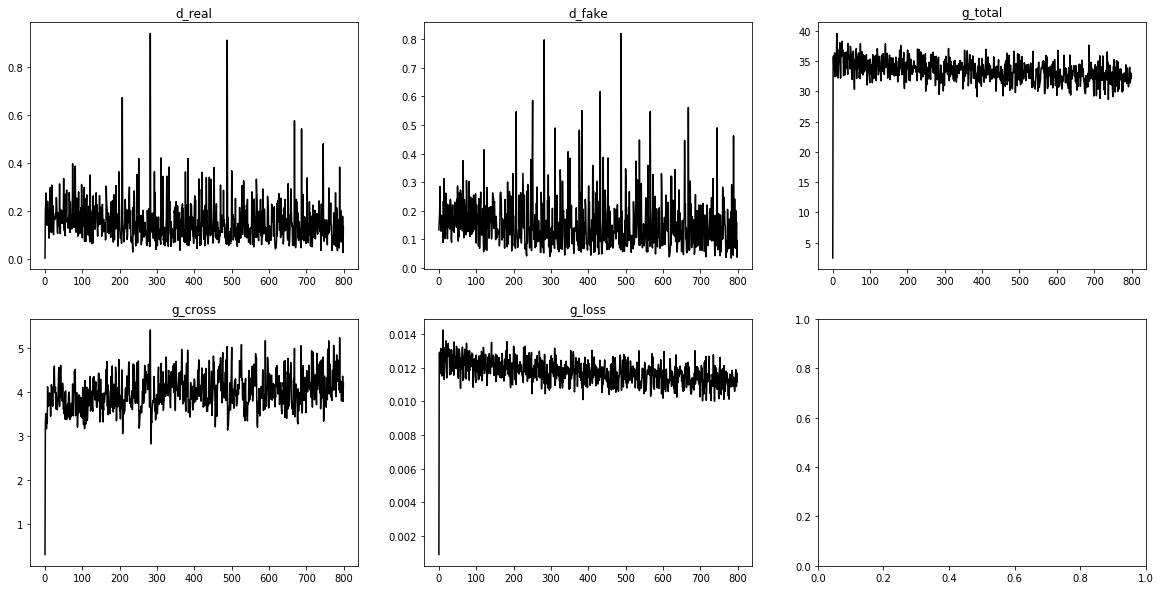

In [19]:
vec = load(dir_name+'/loss__vgg1_(1,2500)w_1.8e3iter_8b')
plot_loss(vec)

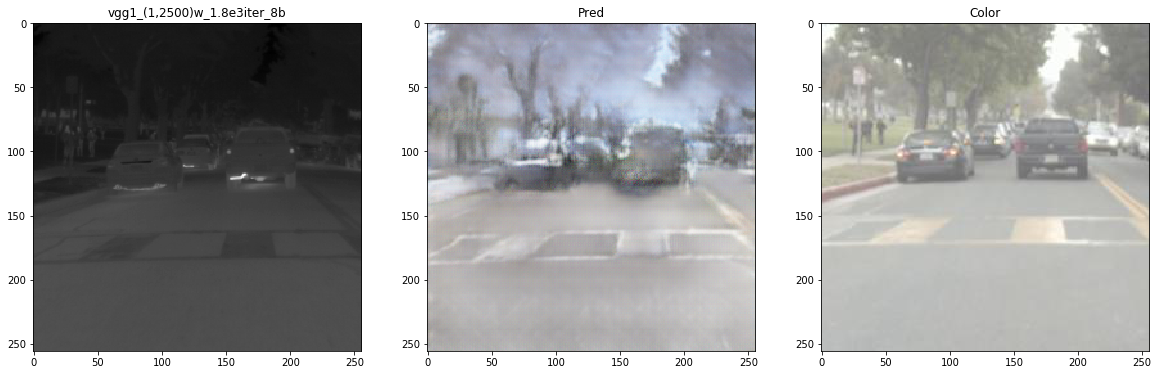

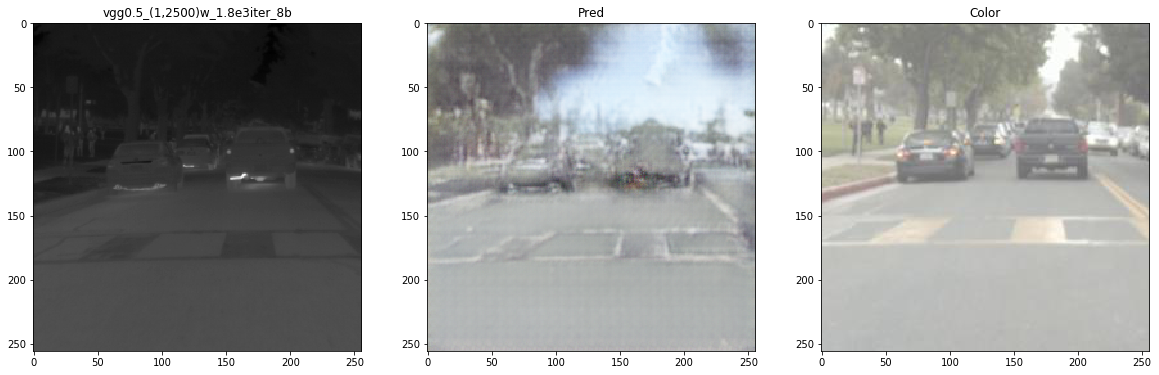

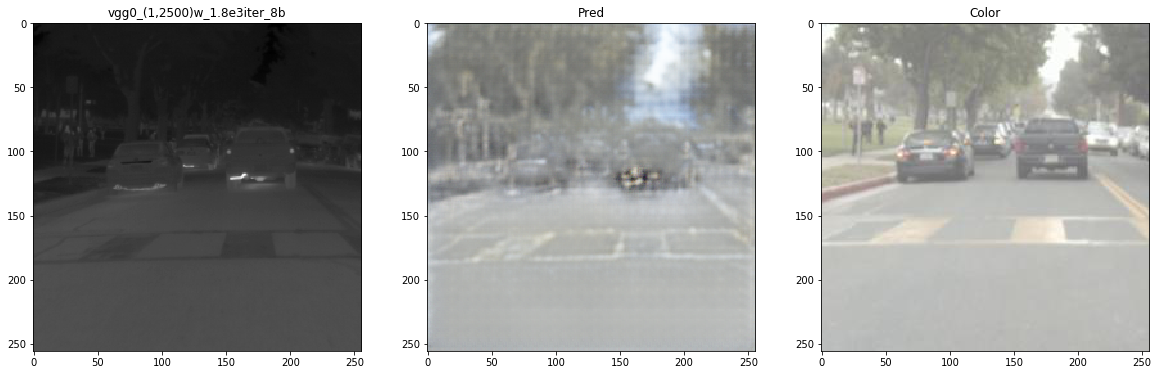

In [33]:
batch_size = 2
data_gen_args = dict(horizontal_flip=True)
image_datagen = ImageDataGenerator(**data_gen_args)        
yimage_generator = image_datagen.flow(y_train, seed=2019, batch_size=batch_size, shuffle=True)
Ximage_generator = image_datagen.flow(X_train, seed=2019, batch_size=batch_size, shuffle=True)
train_generator = zip(Ximage_generator, yimage_generator)
train_crops = crop_generator(train_generator, 256, rand_crop=False)
t_image_shape = (256,256,1);c_image_shape = (256,256,3)
d_model = define_discriminator(t_image_shape, c_image_shape)
g_model = define_generator(t_image_shape)

# define the composite model
gan_model = define_gan(g_model, d_model, t_image_shape)

dir_name = 'schedualer_24.11'
g_names = ['vgg1_(1,2500)w_1.8e3iter_8b','vgg0.5_(1,2500)w_1.8e3iter_8b','vgg0_(1,2500)w_1.8e3iter_8b']
plot_compare(g_names, dir_name, g_model, train_crops)

In [23]:
x = np.zeros((3,3,1,1))
y = np.zeros((3,3,1,1))
ssim = skimage.metrics.structural_similarity
r = ssim(x,y)

AttributeError: module 'skimage' has no attribute 'metrics'